In [133]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_datareader.data as web
import backtrader as bt
from backtrader.feeds import PandasData
import pyfolio as pf

from river import metrics
from river import neighbors

In [6]:
# Getting OHLCV data
data = pd.read_csv('./data/ohlcv.csv')
data.columns = list(map(str.lower, data.columns))
data.date = pd.to_datetime(data.date)
data.set_index(['ticker','date'], inplace=True)
data.sort_index(inplace=True)

### Online Learning: K-Nearest Neighbors

In [46]:
# Preparing input data using lagged prices
gb = data.groupby('ticker')
X = pd.concat([gb.shift(0).close, gb.shift(1).close,gb.shift(5).close,gb.shift(10).close,gb.shift(21).close], axis=1).dropna()
X.columns = ['close','lag1day','lag5day','lag10day','lag21day']
X.sort_index(level=1,inplace=True)
X

close     lag1day     lag5day    lag10day    lag21day
ticker date                                                                  
A      2014-02-03   37.502815   38.838615   38.938812   40.548462   37.542892
AAL    2014-02-03   32.015495   31.628977   28.451939   28.301096   23.907927
AAP    2014-02-03  107.573982  112.053780  112.629616  115.596649  107.105492
AAPL   2014-02-03   15.905712   15.876214   17.458759   17.147015   17.542171
ABBV   2014-02-03   34.662941   36.039219   34.282272   36.646824   37.753345
...                       ...         ...         ...         ...         ...
YUM    2021-08-27  131.699997  131.399994  133.959930  134.458069  122.153992
ZBH    2021-08-27  150.070007  149.589996  145.460007  146.089996  162.559998
ZBRA   2021-08-27  587.960022  578.909973  571.489990  571.070007  545.739990
ZION   2021-08-27   58.549999   55.750000   53.869999   55.410000   52.360001
ZTS    2021-08-27  203.820007  204.020004  207.050003  201.479996  203.270004

[942769 rows x 5 columns]

In [47]:
# Training Online Learning model and storing predictions one by one
model = neighbors.KNNRegressor()
metric = metrics.MSE()

y=[]

for i in range(len(X)):
    y_pred = model.predict_one(X.iloc[i,1:])
    metric = metric.update(X.iloc[i,0], y_pred)
    y.append(y_pred)
    model = model.learn_one(X.iloc[i,1:], X.iloc[i,0])
    if (i%10000==0):
        print(metric)

MSE: 1,406.461151
MSE: 232.700008
MSE: 158.498614
MSE: 130.163881
MSE: 117.15093
MSE: 108.386263
MSE: 102.737906
MSE: 99.201574
MSE: 93.10036
MSE: 89.710818
MSE: 87.970687
MSE: 86.992299
MSE: 88.861951
MSE: 90.797536
MSE: 90.716476
MSE: 90.540998
MSE: 90.46535
MSE: 91.187693
MSE: 93.515794
MSE: 96.06926
MSE: 99.817554
MSE: 103.075587
MSE: 106.884128
MSE: 113.249383
MSE: 118.352096
MSE: 129.786967
MSE: 134.247486
MSE: 140.426839
MSE: 143.941125
MSE: 148.512573
MSE: 153.977128
MSE: 156.48325
MSE: 156.835418
MSE: 155.922393
MSE: 154.345454
MSE: 153.220878
MSE: 152.633588
MSE: 153.487121
MSE: 155.696568
MSE: 159.406159
MSE: 163.097102
MSE: 168.69633
MSE: 177.699775
MSE: 188.244251
MSE: 207.026573
MSE: 230.484975
MSE: 270.471723
MSE: 318.292838
MSE: 370.378751
MSE: 427.538773
MSE: 451.678649
MSE: 468.105355
MSE: 482.003398
MSE: 494.678888
MSE: 505.043955
MSE: 513.90281
MSE: 515.983481
MSE: 516.256356
MSE: 513.390657
MSE: 509.383202
MSE: 507.715713
MSE: 508.190731
MSE: 510.636517
MSE: 513.55

In [48]:
# Converting predictions to DataFrame
knn_preds = pd.DataFrame(y, index=X.index)
knn_preds.columns = ["target1day"]
knn_preds.sort_index(inplace=True)

In [63]:
knn_preds.reset_index(inplace=True)
knn_preds.date = pd.to_datetime(knn_preds.date)
knn_preds.set_index(['ticker','date'], inplace=True)
knn_preds

target1day
ticker date                  
A      2014-02-03    0.000000
       2014-02-04   36.666868
       2014-02-05   37.878144
       2014-02-06   39.367274
       2014-02-07   39.338387
...                       ...
ZTS    2021-08-23  207.082123
       2021-08-24  204.228464
       2021-08-25  201.854001
       2021-08-26  202.169998
       2021-08-27  205.224002

[942769 rows x 1 columns]

In [136]:
# Getting test prediction for comparison
test_preds = pd.read_csv('./predictions/log_preds.csv')
test_preds.date = pd.to_datetime(test_preds.date)
test_preds.set_index(['ticker','date'], inplace=True)
test_preds.sort_index(inplace=True)

In [102]:
# Joining OHLCV data with predictions
ohlcv = test_preds.iloc[:,:5]
ol_preds = ohlcv.join(knn_preds).dropna()
ol_preds.to_csv('./predictions/ol_preds.csv')

### Backtesting

In [104]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']
idx = pd.IndexSlice

In [79]:
# Getting S&P500 data
benchmark = web.DataReader('SP500', 'fred', '2014',).squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

In [125]:
# Initiating Cerebro
cerebro = bt.Cerebro()
cash = 100000
cerebro.broker.setcash(cash)

In [126]:
# Defining input
class SignalData(PandasData):
    
    cols = OHLCV + ['target1day']

    lines = tuple(cols)

    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [127]:
# Feeding data
data = ol_preds
tickers = data.index.get_level_values(0).unique()

for ticker in tickers:
    df = data.loc[idx[ticker,'2015-01-02':], :].droplevel('ticker', axis=0)
    df.index.name = 'datetime'
    bt_data = SignalData(dataname=df)
    cerebro.adddata(bt_data, name=ticker)

In [128]:
# Defining Strategy
class OnlineMLStrategy(bt.Strategy):
    params = (('n_positions', 20),
              ('min_positions', 5),
              ('verbose', False))

    def log(self, txt, dt=None):
        print('%s | %s' % (self.datas[0].datetime.date(0).isoformat(), txt))
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'{trade.data._name}: OPERATION PROFIT {trade.pnl}')

    def notify_order(self, order):
        
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name}: BUY executed {p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name}: SELL executed {p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name}: Order Canceled/Margin/Rejected')

    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()

        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if data.target1day[0] > data.close[0]:
                    up[data._name] = data.target1day[0]/data.close[0] - 1
                elif data.target1day[0] < data.close[0]:
                    down[data._name] = data.target1day[0]/data.close[0] - 1

        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker}: TRADE CLOSING ORDER CREATED')

        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log(f'{ticker}: SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log(f'{ticker}: LONG ORDER CREATED')

In [129]:
# Backtesting
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addstrategy(OnlineMLStrategy)
cerebro.addsizer(bt.sizers.FixedSize, stake=1000)
cerebro.broker.setcommission(0.001)
results = cerebro.run()
ending_value = cerebro.broker.getvalue()

print(f'Final Portfolio Value: {ending_value:,.2f}')

2015-01-02 | NVDA: SHORT ORDER CREATED
2015-01-02 | NVR: SHORT ORDER CREATED
2015-01-02 | REGN: SHORT ORDER CREATED
2015-01-02 | CMG: SHORT ORDER CREATED
2015-01-02 | GWW: SHORT ORDER CREATED
2015-01-02 | BIIB: SHORT ORDER CREATED
2015-01-02 | VRTX: SHORT ORDER CREATED
2015-01-02 | ENPH: SHORT ORDER CREATED
2015-01-02 | MPC: SHORT ORDER CREATED
2015-01-02 | AAL: SHORT ORDER CREATED
2015-01-02 | BKNG: SHORT ORDER CREATED
2015-01-02 | LH: SHORT ORDER CREATED
2015-01-02 | VLO: SHORT ORDER CREATED
2015-01-02 | DGX: SHORT ORDER CREATED
2015-01-02 | HPQ: SHORT ORDER CREATED
2015-01-02 | PEAK: SHORT ORDER CREATED
2015-01-02 | TMO: SHORT ORDER CREATED
2015-01-02 | CF: SHORT ORDER CREATED
2015-01-02 | PLD: SHORT ORDER CREATED
2015-01-02 | TMUS: SHORT ORDER CREATED
2015-01-02 | AMD: LONG ORDER CREATED
2015-01-02 | GOOG: LONG ORDER CREATED
2015-01-02 | PENN: LONG ORDER CREATED
2015-01-02 | HBAN: LONG ORDER CREATED
2015-01-02 | IPG: LONG ORDER CREATED
2015-01-02 | ABMD: LONG ORDER CREATED
2015-01-

2015-01-07 | LH: OPERATION PROFIT 65.55990600585938
2015-01-07 | PENN: OPERATION PROFIT -17.794543688795372
2015-01-07 | BSX: OPERATION PROFIT 14.399986267089844
2015-01-07 | AAPL: OPERATION PROFIT -48.912122979366245
2015-01-07 | FCX: OPERATION PROFIT -49.27994070724935
2015-01-07 | ARE: OPERATION PROFIT -49.058984322213234
2015-01-07 | CAT: OPERATION PROFIT 5.1490718314529715
2015-01-07 | CRL: OPERATION PROFIT -40.03974151611328
2015-01-07 | DLR: OPERATION PROFIT 5.832062876893801
2015-01-07 | DPZ: OPERATION PROFIT -47.99941286110652
2015-01-07 | FRT: OPERATION PROFIT -55.093286307404924
2015-01-07 | HWM: OPERATION PROFIT 85.98637753613855
2015-01-07 | MCK: OPERATION PROFIT -28.554106312022043
2015-01-07 | MRO: OPERATION PROFIT 32.786978008119604
2015-01-07 | NRG: OPERATION PROFIT -31.98363899944969
2015-01-07 | OXY: OPERATION PROFIT 55.651513273444465
2015-01-07 | PXD: OPERATION PROFIT 67.271190413131
2015-01-07 | STZ: OPERATION PROFIT 57.14326058835309
2015-01-07 | XYL: OPERATION P

2015-01-13 | ATVI: OPERATION PROFIT -32.766249493792294
2015-01-13 | BAC: OPERATION PROFIT -56.426816678578405
2015-01-13 | CMA: OPERATION PROFIT 6.705872132343927
2015-01-13 | DAL: OPERATION PROFIT -4.068457471941414
2015-01-13 | DISCK: OPERATION PROFIT -23.09994125366211
2015-01-13 | EQIX: OPERATION PROFIT 45.010684108297085
2015-01-13 | HAS: OPERATION PROFIT -39.66651845664089
2015-01-13 | MSCI: OPERATION PROFIT -63.34514167177806
2015-01-13 | PCAR: OPERATION PROFIT 2.1885900065379644
2015-01-13 | SCHW: OPERATION PROFIT 15.17549883396648
2015-01-13 | SHW: OPERATION PROFIT -17.530869171787984
2015-01-13 | SIVB: OPERATION PROFIT 11.60985565185608
2015-01-13 | STZ: OPERATION PROFIT 33.7611010009376
2015-01-13 | TWTR: OPERATION PROFIT 64.25965499878015
2015-01-13 | UNP: OPERATION PROFIT 27.83792125977834
2015-01-13 | ZION: OPERATION PROFIT -118.37384738320978
2015-01-13 | REGN: TRADE CLOSING ORDER CREATED
2015-01-13 | CF: TRADE CLOSING ORDER CREATED
2015-01-13 | HBAN: TRADE CLOSING ORDE

2015-01-16 | GWW: OPERATION PROFIT 303.2378829232113
2015-01-16 | MPC: OPERATION PROFIT -162.99176061505293
2015-01-16 | BSX: OPERATION PROFIT 112.13012599945185
2015-01-16 | AZO: OPERATION PROFIT -169.33001708984375
2015-01-16 | CNP: OPERATION PROFIT -26.341930826230538
2015-01-16 | DISCA: OPERATION PROFIT -138.5999412536632
2015-01-16 | EOG: OPERATION PROFIT 114.49442373416068
2015-01-16 | FANG: OPERATION PROFIT -216.81801304445952
2015-01-16 | HWM: OPERATION PROFIT -61.79151728468834
2015-01-16 | IDXX: OPERATION PROFIT -122.93037414550781
2015-01-16 | MHK: OPERATION PROFIT 150.39019775390625
2015-01-16 | NEE: OPERATION PROFIT 17.216562436156117
2015-01-16 | SCHW: OPERATION PROFIT -73.30294251201056
2015-01-16 | TSLA: OPERATION PROFIT -90.95993041992188
2015-01-16 | WMT: OPERATION PROFIT 10.58013047047558
2015-01-16 | BBY: OPERATION PROFIT 85.97645582205921
2015-01-16 | TWTR: OPERATION PROFIT 292.32005310058594
2015-01-16 | REGN: TRADE CLOSING ORDER CREATED
2015-01-16 | ENPH: TRADE C

2015-01-23 | FTNT: SHORT ORDER CREATED
2015-01-23 | LUV: SHORT ORDER CREATED
2015-01-23 | SIVB: SHORT ORDER CREATED
2015-01-23 | AMD: LONG ORDER CREATED
2015-01-23 | UPS: LONG ORDER CREATED
2015-01-23 | CE: LONG ORDER CREATED
2015-01-23 | SEE: LONG ORDER CREATED
2015-01-23 | KMB: LONG ORDER CREATED
2015-01-23 | KLAC: LONG ORDER CREATED
2015-01-23 | FFIV: LONG ORDER CREATED
2015-01-23 | RF: LONG ORDER CREATED
2015-01-23 | EMN: LONG ORDER CREATED
2015-01-23 | STT: LONG ORDER CREATED
2015-01-23 | KSU: LONG ORDER CREATED
2015-01-23 | BK: LONG ORDER CREATED
2015-01-23 | AES: LONG ORDER CREATED
2015-01-23 | DFS: LONG ORDER CREATED
2015-01-23 | FCX: LONG ORDER CREATED
2015-01-23 | BLL: LONG ORDER CREATED
2015-01-23 | ALB: LONG ORDER CREATED
2015-01-23 | DHI: LONG ORDER CREATED
2015-01-23 | AXP: LONG ORDER CREATED
2015-01-23 | XLNX: LONG ORDER CREATED
2015-01-26 | AAL: OPERATION PROFIT -40.855922193968695
2015-01-26 | HPQ: OPERATION PROFIT 25.43187396907281
2015-01-26 | BSX: OPERATION PROFIT 6

2015-01-29 | MSFT: LONG ORDER CREATED
2015-01-29 | MRO: LONG ORDER CREATED
2015-01-30 | MPC: OPERATION PROFIT 65.14471475466871
2015-01-30 | AES: OPERATION PROFIT 14.358837482065546
2015-01-30 | AOS: OPERATION PROFIT 32.71623232853955
2015-01-30 | CHTR: OPERATION PROFIT -0.600128173828125
2015-01-30 | COP: OPERATION PROFIT -68.43266274587472
2015-01-30 | DVN: OPERATION PROFIT -62.80420177026123
2015-01-30 | EQIX: OPERATION PROFIT 45.580712571878394
2015-01-30 | FFIV: OPERATION PROFIT 3.2000732421875
2015-01-30 | HBI: OPERATION PROFIT 54.00951403854519
2015-01-30 | INTC: OPERATION PROFIT -102.21444648042967
2015-01-30 | O: OPERATION PROFIT -12.355920930593385
2015-01-30 | PRU: OPERATION PROFIT -76.32402328817022
2015-01-30 | ROK: OPERATION PROFIT -10.399526397651925
2015-01-30 | ROL: OPERATION PROFIT -124.26047848405737
2015-01-30 | SCHW: OPERATION PROFIT -6.967040489052906
2015-01-30 | TEL: OPERATION PROFIT 19.45322753773273
2015-01-30 | ENPH: TRADE CLOSING ORDER CREATED
2015-01-30 | T

2015-02-04 | BKNG: OPERATION PROFIT 65.239990234375
2015-02-04 | VLO: OPERATION PROFIT 56.935378610629144
2015-02-04 | HBAN: OPERATION PROFIT -185.93000776844084
2015-02-04 | STX: OPERATION PROFIT 194.10191891075692
2015-02-04 | FCX: OPERATION PROFIT -142.2213715088339
2015-02-04 | ADSK: OPERATION PROFIT 49.79987335205019
2015-02-04 | APA: OPERATION PROFIT 47.84121761586041
2015-02-04 | CL: OPERATION PROFIT -3.9209120110321862
2015-02-04 | DOV: OPERATION PROFIT 89.11500182124132
2015-02-04 | EA: OPERATION PROFIT -9.514288767383917
2015-02-04 | EQIX: OPERATION PROFIT 68.1709632196771
2015-02-04 | GPC: OPERATION PROFIT 201.44308770698458
2015-02-04 | INTC: OPERATION PROFIT 114.90543683043308
2015-02-04 | MCO: OPERATION PROFIT 110.22255147174891
2015-02-04 | MRK: OPERATION PROFIT -68.22405048599663
2015-02-04 | MRO: OPERATION PROFIT 38.76233406966719
2015-02-04 | PSX: OPERATION PROFIT -158.26876316483663
2015-02-04 | PWR: OPERATION PROFIT -112.07710711103418
2015-02-04 | PXD: OPERATION PR

2015-02-06 | LUV: TRADE CLOSING ORDER CREATED
2015-02-06 | MCHP: TRADE CLOSING ORDER CREATED
2015-02-06 | OKE: TRADE CLOSING ORDER CREATED
2015-02-06 | PCAR: TRADE CLOSING ORDER CREATED
2015-02-06 | PRU: TRADE CLOSING ORDER CREATED
2015-02-06 | RCL: TRADE CLOSING ORDER CREATED
2015-02-06 | SO: TRADE CLOSING ORDER CREATED
2015-02-06 | UAL: TRADE CLOSING ORDER CREATED
2015-02-06 | WMB: TRADE CLOSING ORDER CREATED
2015-02-06 | NVR: SHORT ORDER CREATED
2015-02-06 | TWTR: SHORT ORDER CREATED
2015-02-06 | NVDA: SHORT ORDER CREATED
2015-02-06 | LHX: SHORT ORDER CREATED
2015-02-06 | AZO: SHORT ORDER CREATED
2015-02-06 | ORLY: SHORT ORDER CREATED
2015-02-06 | ENPH: SHORT ORDER CREATED
2015-02-06 | FANG: SHORT ORDER CREATED
2015-02-06 | ABMD: SHORT ORDER CREATED
2015-02-06 | CME: SHORT ORDER CREATED
2015-02-06 | CMG: SHORT ORDER CREATED
2015-02-06 | HBAN: SHORT ORDER CREATED
2015-02-06 | CMA: SHORT ORDER CREATED
2015-02-06 | IPGP: SHORT ORDER CREATED
2015-02-06 | SIVB: SHORT ORDER CREATED
2015-0

2015-02-11 | MPC: OPERATION PROFIT -31.814256186762123
2015-02-11 | AAL: OPERATION PROFIT 131.97056672109682
2015-02-11 | ALK: OPERATION PROFIT 118.82020755936148
2015-02-11 | APTV: OPERATION PROFIT -35.10296911687465
2015-02-11 | AVB: OPERATION PROFIT 34.95385483236532
2015-02-11 | BLK: OPERATION PROFIT 54.02589162473771
2015-02-11 | COP: OPERATION PROFIT 41.25704126015194
2015-02-11 | DAL: OPERATION PROFIT 58.94843137857467
2015-02-11 | DFS: OPERATION PROFIT 50.576341032177424
2015-02-11 | EQIX: OPERATION PROFIT 40.942524727588534
2015-02-11 | FITB: OPERATION PROFIT 0.71892844281302
2015-02-11 | HWM: OPERATION PROFIT 5.657231189631986
2015-02-11 | ILMN: OPERATION PROFIT 13.569915771483721
2015-02-11 | KR: OPERATION PROFIT -47.04369694533113
2015-02-11 | LHX: OPERATION PROFIT 10.042907312906493
2015-02-11 | LNC: OPERATION PROFIT -139.57196365899
2015-02-11 | MSI: OPERATION PROFIT -36.59246334259123
2015-02-11 | NEE: OPERATION PROFIT 101.03508670580337
2015-02-11 | NLOK: OPERATION PROF

2015-02-17 | HBAN: OPERATION PROFIT -129.17543559486285
2015-02-17 | AAP: OPERATION PROFIT -32.55877638200985
2015-02-17 | AES: OPERATION PROFIT -73.29403335452122
2015-02-17 | AKAM: OPERATION PROFIT -83.19992065429688
2015-02-17 | ALK: OPERATION PROFIT 31.680803955892237
2015-02-17 | BLL: OPERATION PROFIT -13.144791921306293
2015-02-17 | BWA: OPERATION PROFIT 10.87581393970595
2015-02-17 | COG: OPERATION PROFIT -50.768187805649845
2015-02-17 | DHI: OPERATION PROFIT 35.70320715035571
2015-02-17 | EFX: OPERATION PROFIT -9.472333548049832
2015-02-17 | ES: OPERATION PROFIT -64.93304831995715
2015-02-17 | EXPE: OPERATION PROFIT -4.447251529574601
2015-02-17 | F: OPERATION PROFIT 35.46181617976024
2015-02-17 | FANG: OPERATION PROFIT 108.84049397738636
2015-02-17 | IFF: OPERATION PROFIT -59.00826149060646
2015-02-17 | IQV: OPERATION PROFIT 49.699668884277344
2015-02-17 | JNJ: OPERATION PROFIT 42.74449780374644
2015-02-17 | K: OPERATION PROFIT 16.68165484982771
2015-02-17 | LNT: OPERATION PRO

2015-02-19 | HII: SHORT ORDER CREATED
2015-02-19 | NCLH: SHORT ORDER CREATED
2015-02-19 | LVS: SHORT ORDER CREATED
2015-02-19 | CTSH: SHORT ORDER CREATED
2015-02-19 | IFF: SHORT ORDER CREATED
2015-02-19 | EXPE: SHORT ORDER CREATED
2015-02-19 | BA: SHORT ORDER CREATED
2015-02-19 | AMD: LONG ORDER CREATED
2015-02-19 | ENPH: LONG ORDER CREATED
2015-02-19 | RF: LONG ORDER CREATED
2015-02-19 | HST: LONG ORDER CREATED
2015-02-19 | RL: LONG ORDER CREATED
2015-02-19 | MTD: LONG ORDER CREATED
2015-02-19 | WMT: LONG ORDER CREATED
2015-02-19 | GRMN: LONG ORDER CREATED
2015-02-19 | NEE: LONG ORDER CREATED
2015-02-19 | PLD: LONG ORDER CREATED
2015-02-19 | ALK: LONG ORDER CREATED
2015-02-19 | BAX: LONG ORDER CREATED
2015-02-19 | SPG: LONG ORDER CREATED
2015-02-19 | EQR: LONG ORDER CREATED
2015-02-19 | PSA: LONG ORDER CREATED
2015-02-19 | VRTX: LONG ORDER CREATED
2015-02-19 | PG: LONG ORDER CREATED
2015-02-19 | AXP: LONG ORDER CREATED
2015-02-19 | AVB: LONG ORDER CREATED
2015-02-19 | SYY: LONG ORDER 

2015-02-24 | EXPE: TRADE CLOSING ORDER CREATED
2015-02-24 | GPS: TRADE CLOSING ORDER CREATED
2015-02-24 | HII: TRADE CLOSING ORDER CREATED
2015-02-24 | HUM: TRADE CLOSING ORDER CREATED
2015-02-24 | INCY: TRADE CLOSING ORDER CREATED
2015-02-24 | MHK: TRADE CLOSING ORDER CREATED
2015-02-24 | MS: TRADE CLOSING ORDER CREATED
2015-02-24 | MSI: TRADE CLOSING ORDER CREATED
2015-02-24 | OXY: TRADE CLOSING ORDER CREATED
2015-02-24 | PGR: TRADE CLOSING ORDER CREATED
2015-02-24 | TSLA: TRADE CLOSING ORDER CREATED
2015-02-24 | UNH: TRADE CLOSING ORDER CREATED
2015-02-24 | NVDA: SHORT ORDER CREATED
2015-02-24 | NVR: SHORT ORDER CREATED
2015-02-24 | CMG: SHORT ORDER CREATED
2015-02-24 | EXPD: SHORT ORDER CREATED
2015-02-24 | BKNG: SHORT ORDER CREATED
2015-02-24 | FCX: SHORT ORDER CREATED
2015-02-24 | TPR: SHORT ORDER CREATED
2015-02-24 | BSX: SHORT ORDER CREATED
2015-02-24 | ABMD: SHORT ORDER CREATED
2015-02-24 | MLM: SHORT ORDER CREATED
2015-02-24 | UAL: SHORT ORDER CREATED
2015-02-24 | DISCA: SHOR

2015-02-27 | REGN: OPERATION PROFIT 39.59991455078125
2015-02-27 | AAL: OPERATION PROFIT -123.1587783318848
2015-02-27 | HBAN: OPERATION PROFIT -4.081627654540743
2015-02-27 | STX: OPERATION PROFIT 27.519703264654026
2015-02-27 | CHTR: OPERATION PROFIT -2.399780273438182
2015-02-27 | COG: OPERATION PROFIT 109.08217584366125
2015-02-27 | FTNT: OPERATION PROFIT 26.000099182128906
2015-02-27 | GRMN: OPERATION PROFIT -178.71271954862775
2015-02-27 | HST: OPERATION PROFIT -149.2985520084843
2015-02-27 | HWM: OPERATION PROFIT 2.9816383178923473
2015-02-27 | LNT: OPERATION PROFIT -56.16175559322922
2015-02-27 | MCD: OPERATION PROFIT -79.57420063545464
2015-02-27 | MHK: OPERATION PROFIT -13.9200439453125
2015-02-27 | NEE: OPERATION PROFIT -11.65385935693735
2015-02-27 | NKE: OPERATION PROFIT -13.44881327483236
2015-02-27 | UDR: OPERATION PROFIT -40.78375195540889
2015-02-27 | WDC: OPERATION PROFIT 28.284867483412157
2015-02-27 | MPC: TRADE CLOSING ORDER CREATED
2015-02-27 | ABMD: TRADE CLOSING

2015-03-04 | BIIB: OPERATION PROFIT -2.7999877929693184
2015-03-04 | MPC: OPERATION PROFIT -26.793389803826727
2015-03-04 | VLO: OPERATION PROFIT 38.15381064675704
2015-03-04 | FCX: OPERATION PROFIT 201.33185316820314
2015-03-04 | AKAM: OPERATION PROFIT 29.890335083007812
2015-03-04 | CNP: OPERATION PROFIT -185.56312242329665
2015-03-04 | CRM: OPERATION PROFIT 220.29007720947266
2015-03-04 | DVN: OPERATION PROFIT -91.38138896349673
2015-03-04 | ED: OPERATION PROFIT 20.479969998845675
2015-03-04 | F: OPERATION PROFIT 26.782666380579496
2015-03-04 | FE: OPERATION PROFIT -47.41112090168254
2015-03-04 | INCY: OPERATION PROFIT 43.1202392578125
2015-03-04 | LKQ: OPERATION PROFIT -49.61012268066401
2015-03-04 | LYV: OPERATION PROFIT 59.04010009765625
2015-03-04 | NCLH: OPERATION PROFIT 63.63981628417969
2015-03-04 | NEE: OPERATION PROFIT 16.47526936315773
2015-03-04 | NRG: OPERATION PROFIT -309.30151694745035
2015-03-04 | PSX: OPERATION PROFIT 9.673841980084035
2015-03-04 | SO: OPERATION PROF

2015-03-09 | REGN: OPERATION PROFIT 42.30010986328068
2015-03-09 | CMG: OPERATION PROFIT 142.7301025390625
2015-03-09 | BIIB: OPERATION PROFIT 70.0
2015-03-09 | GOOG: OPERATION PROFIT -55.986328125
2015-03-09 | BSX: OPERATION PROFIT 19.399543762206655
2015-03-09 | BMY: OPERATION PROFIT 49.35738299030845
2015-03-09 | HWM: OPERATION PROFIT -150.95508236310218
2015-03-09 | INCY: OPERATION PROFIT 62.979827880859375
2015-03-09 | IPGP: OPERATION PROFIT 82.35008239746094
2015-03-09 | JNPR: OPERATION PROFIT 243.47040225919014
2015-03-09 | KR: OPERATION PROFIT -38.011048846583094
2015-03-09 | LRCX: OPERATION PROFIT -55.64956455559127
2015-03-09 | MKTX: OPERATION PROFIT -7.135662139597173
2015-03-09 | MNST: OPERATION PROFIT 161.58322143554662
2015-03-09 | MRO: OPERATION PROFIT -148.39058577131257
2015-03-09 | MSCI: OPERATION PROFIT 14.846581860145307
2015-03-09 | PRGO: OPERATION PROFIT 24.796604414750902
2015-03-09 | RL: OPERATION PROFIT -75.24526802176678
2015-03-09 | ROK: OPERATION PROFIT -19.

2015-03-11 | LVS: LONG ORDER CREATED
2015-03-11 | GLW: LONG ORDER CREATED
2015-03-11 | MO: LONG ORDER CREATED
2015-03-11 | WDC: LONG ORDER CREATED
2015-03-11 | FCX: LONG ORDER CREATED
2015-03-11 | HRL: LONG ORDER CREATED
2015-03-11 | WHR: LONG ORDER CREATED
2015-03-11 | NRG: LONG ORDER CREATED
2015-03-11 | HWM: LONG ORDER CREATED
2015-03-11 | PPG: LONG ORDER CREATED
2015-03-11 | ENPH: LONG ORDER CREATED
2015-03-12 | MPC: OPERATION PROFIT 68.54854152318796
2015-03-12 | BKNG: OPERATION PROFIT 90.2098388671875
2015-03-12 | STX: OPERATION PROFIT -125.28117469466322
2015-03-12 | APA: OPERATION PROFIT 96.15428911981897
2015-03-12 | ESS: OPERATION PROFIT -39.50652641143259
2015-03-12 | EXC: OPERATION PROFIT 31.01176733707412
2015-03-12 | FAST: OPERATION PROFIT -9.597529573998145
2015-03-12 | FE: OPERATION PROFIT -7.551835846239612
2015-03-12 | INTC: OPERATION PROFIT -131.28049237398943
2015-03-12 | MAA: OPERATION PROFIT -53.58605470261338
2015-03-12 | MGM: OPERATION PROFIT -69.2509114581633
2

2015-03-17 | ENPH: TRADE CLOSING ORDER CREATED
2015-03-17 | ABC: TRADE CLOSING ORDER CREATED
2015-03-17 | CNC: TRADE CLOSING ORDER CREATED
2015-03-17 | COO: TRADE CLOSING ORDER CREATED
2015-03-17 | EQIX: TRADE CLOSING ORDER CREATED
2015-03-17 | HBI: TRADE CLOSING ORDER CREATED
2015-03-17 | INCY: TRADE CLOSING ORDER CREATED
2015-03-17 | MHK: TRADE CLOSING ORDER CREATED
2015-03-17 | NEE: TRADE CLOSING ORDER CREATED
2015-03-17 | PBCT: TRADE CLOSING ORDER CREATED
2015-03-17 | PVH: TRADE CLOSING ORDER CREATED
2015-03-17 | UDR: TRADE CLOSING ORDER CREATED
2015-03-17 | URI: TRADE CLOSING ORDER CREATED
2015-03-17 | WAT: TRADE CLOSING ORDER CREATED
2015-03-17 | NVDA: SHORT ORDER CREATED
2015-03-17 | NVR: SHORT ORDER CREATED
2015-03-17 | REGN: SHORT ORDER CREATED
2015-03-17 | AAL: SHORT ORDER CREATED
2015-03-17 | MGM: SHORT ORDER CREATED
2015-03-17 | VTRS: SHORT ORDER CREATED
2015-03-17 | BSX: SHORT ORDER CREATED
2015-03-17 | PRGO: SHORT ORDER CREATED
2015-03-17 | BAC: SHORT ORDER CREATED
2015-0

2015-03-20 | NVDA: OPERATION PROFIT 84.84098206033235
2015-03-20 | VLO: OPERATION PROFIT 17.00200688625408
2015-03-20 | HBAN: OPERATION PROFIT -15.102456112534078
2015-03-20 | WYNN: OPERATION PROFIT -418.9290916610728
2015-03-20 | BSX: OPERATION PROFIT -127.94015884399414
2015-03-20 | ADBE: OPERATION PROFIT 64.25971984863281
2015-03-20 | CMS: OPERATION PROFIT -2.365870595332421
2015-03-20 | CSX: OPERATION PROFIT -63.527127239523175
2015-03-20 | DISCA: OPERATION PROFIT 65.16971588134766
2015-03-20 | DISCK: OPERATION PROFIT 26.030073165893068
2015-03-20 | DXC: OPERATION PROFIT -11.906589388944454
2015-03-20 | FDX: OPERATION PROFIT 12.381713057648085
2015-03-20 | FE: OPERATION PROFIT -18.681637233641226
2015-03-20 | INTC: OPERATION PROFIT 28.540081069573247
2015-03-20 | LRCX: OPERATION PROFIT 105.03906903780972
2015-03-20 | NEE: OPERATION PROFIT 20.871815069553186
2015-03-20 | NI: OPERATION PROFIT 17.327612265840806
2015-03-20 | PHM: OPERATION PROFIT 120.321510060424
2015-03-20 | PPL: OPE

2015-03-25 | TWTR: TRADE CLOSING ORDER CREATED
2015-03-25 | VFC: TRADE CLOSING ORDER CREATED
2015-03-25 | WDC: TRADE CLOSING ORDER CREATED
2015-03-25 | NVR: SHORT ORDER CREATED
2015-03-25 | AMZN: SHORT ORDER CREATED
2015-03-25 | ABMD: SHORT ORDER CREATED
2015-03-25 | VLO: SHORT ORDER CREATED
2015-03-25 | FANG: SHORT ORDER CREATED
2015-03-25 | HAL: SHORT ORDER CREATED
2015-03-25 | PVH: SHORT ORDER CREATED
2015-03-25 | LVS: SHORT ORDER CREATED
2015-03-25 | EL: SHORT ORDER CREATED
2015-03-25 | REGN: SHORT ORDER CREATED
2015-03-25 | SLB: SHORT ORDER CREATED
2015-03-25 | MPC: SHORT ORDER CREATED
2015-03-25 | PXD: SHORT ORDER CREATED
2015-03-25 | PKI: SHORT ORDER CREATED
2015-03-25 | MKC: SHORT ORDER CREATED
2015-03-25 | NI: SHORT ORDER CREATED
2015-03-25 | PSX: SHORT ORDER CREATED
2015-03-25 | SJM: SHORT ORDER CREATED
2015-03-25 | WMB: SHORT ORDER CREATED
2015-03-25 | CMG: SHORT ORDER CREATED
2015-03-25 | AMD: LONG ORDER CREATED
2015-03-25 | RF: LONG ORDER CREATED
2015-03-25 | NVDA: LONG OR

2015-03-30 | VLO: OPERATION PROFIT 153.92921904744142
2015-03-30 | ACN: OPERATION PROFIT -10.434811699421388
2015-03-30 | ADSK: OPERATION PROFIT -145.7200126647948
2015-03-30 | AMAT: OPERATION PROFIT 139.12164403455722
2015-03-30 | BBY: OPERATION PROFIT -18.975966037556063
2015-03-30 | CTXS: OPERATION PROFIT -37.252315445285376
2015-03-30 | DAL: OPERATION PROFIT 93.51207291256839
2015-03-30 | DG: OPERATION PROFIT -46.07972541954335
2015-03-30 | DISCA: OPERATION PROFIT 68.1099681854258
2015-03-30 | DXCM: OPERATION PROFIT 186.88010025024414
2015-03-30 | EOG: OPERATION PROFIT -48.02852397972367
2015-03-30 | FANG: OPERATION PROFIT -66.0721392904284
2015-03-30 | IPGP: OPERATION PROFIT 63.47992706298814
2015-03-30 | MKC: OPERATION PROFIT -90.16772591987967
2015-03-30 | MLM: OPERATION PROFIT -27.84229878981023
2015-03-30 | NFLX: OPERATION PROFIT 27.771240234375
2015-03-30 | PKI: OPERATION PROFIT -80.4298478481106
2015-03-30 | PSA: OPERATION PROFIT -19.70203002368484
2015-03-30 | PVH: OPERATIO

2015-04-06 | GOOG: OPERATION PROFIT -177.103759765625
2015-04-06 | AAP: OPERATION PROFIT -5.280572742945822
2015-04-06 | ABBV: OPERATION PROFIT -47.11268234680072
2015-04-06 | AES: OPERATION PROFIT -0.04772824415505639
2015-04-06 | ALGN: OPERATION PROFIT 26.729839324951172
2015-04-06 | AMAT: OPERATION PROFIT -86.17868648944992
2015-04-06 | ES: OPERATION PROFIT -3.367896778417915
2015-04-06 | GIS: OPERATION PROFIT -99.87006352674885
2015-04-06 | GLW: OPERATION PROFIT 1.9257991902439358
2015-04-06 | ILMN: OPERATION PROFIT -35.64971923828125
2015-04-06 | KLAC: OPERATION PROFIT -47.44842989570142
2015-04-06 | LYB: OPERATION PROFIT 0.9605581620980672
2015-04-06 | MCO: OPERATION PROFIT 19.57439887653419
2015-04-06 | NEE: OPERATION PROFIT -24.583447580959124
2015-04-06 | NRG: OPERATION PROFIT 49.175481409046554
2015-04-06 | PPL: OPERATION PROFIT -39.5608876200053
2015-04-06 | TWTR: OPERATION PROFIT 51.85005187988221
2015-04-06 | UHS: OPERATION PROFIT 115.72334840885273
2015-04-06 | WST: OPERA

2015-04-08 | MPC: TRADE CLOSING ORDER CREATED
2015-04-08 | AAL: TRADE CLOSING ORDER CREATED
2015-04-08 | PENN: TRADE CLOSING ORDER CREATED
2015-04-08 | HBAN: TRADE CLOSING ORDER CREATED
2015-04-08 | CCL: TRADE CLOSING ORDER CREATED
2015-04-08 | COG: TRADE CLOSING ORDER CREATED
2015-04-08 | DAL: TRADE CLOSING ORDER CREATED
2015-04-08 | FANG: TRADE CLOSING ORDER CREATED
2015-04-08 | FAST: TRADE CLOSING ORDER CREATED
2015-04-08 | GM: TRADE CLOSING ORDER CREATED
2015-04-08 | GRMN: TRADE CLOSING ORDER CREATED
2015-04-08 | IRM: TRADE CLOSING ORDER CREATED
2015-04-08 | JNPR: TRADE CLOSING ORDER CREATED
2015-04-08 | LYB: TRADE CLOSING ORDER CREATED
2015-04-08 | MHK: TRADE CLOSING ORDER CREATED
2015-04-08 | MRO: TRADE CLOSING ORDER CREATED
2015-04-08 | PPL: TRADE CLOSING ORDER CREATED
2015-04-08 | PVH: TRADE CLOSING ORDER CREATED
2015-04-08 | RL: TRADE CLOSING ORDER CREATED
2015-04-08 | TAP: TRADE CLOSING ORDER CREATED
2015-04-08 | TWTR: TRADE CLOSING ORDER CREATED
2015-04-08 | WY: TRADE CLOSIN

2015-04-13 | AAL: OPERATION PROFIT -60.925231010413455
2015-04-13 | PLD: OPERATION PROFIT -2.983587084333692
2015-04-13 | WYNN: OPERATION PROFIT 36.359958887742124
2015-04-13 | BSX: OPERATION PROFIT 0.0
2015-04-13 | LVS: OPERATION PROFIT 33.43328794495028
2015-04-13 | BXP: OPERATION PROFIT 0.6118382326085623
2015-04-13 | EQIX: OPERATION PROFIT -14.2193198873411
2015-04-13 | ESS: OPERATION PROFIT -22.55130818836372
2015-04-13 | HLT: OPERATION PROFIT -16.484898563628292
2015-04-13 | KIM: OPERATION PROFIT 8.246031198697523
2015-04-13 | MGM: OPERATION PROFIT 63.618932555038555
2015-04-13 | MSI: OPERATION PROFIT 30.61470656046133
2015-04-13 | NOV: OPERATION PROFIT -3.111361925348291
2015-04-13 | NOW: OPERATION PROFIT -107.63998413085938
2015-04-13 | PXD: OPERATION PROFIT 0.47768410266044725
2015-04-13 | TTWO: OPERATION PROFIT 66.69022178649902
2015-04-13 | UAA: OPERATION PROFIT -50.499725341797586
2015-04-13 | UAL: OPERATION PROFIT -244.53987884521518
2015-04-13 | ULTA: OPERATION PROFIT -12

2015-04-16 | ENPH: OPERATION PROFIT 82.4200725555423
2015-04-16 | BKNG: OPERATION PROFIT -9.9298095703125
2015-04-16 | VLO: OPERATION PROFIT -31.519837212595313
2015-04-16 | PENN: OPERATION PROFIT 102.4705224432077
2015-04-16 | WYNN: OPERATION PROFIT 101.23013756271055
2015-04-16 | LVS: OPERATION PROFIT 82.59191437815554
2015-04-16 | AMAT: OPERATION PROFIT 26.60557171486977
2015-04-16 | AVGO: OPERATION PROFIT 10.198821947369709
2015-04-16 | COP: OPERATION PROFIT -4.898707549541939
2015-04-16 | CSX: OPERATION PROFIT 83.96949780312532
2015-04-16 | FAST: OPERATION PROFIT 34.4175256334386
2015-04-16 | FIS: OPERATION PROFIT -64.51117336349552
2015-04-16 | JBHT: OPERATION PROFIT 30.751804270980983
2015-04-16 | JPM: OPERATION PROFIT -66.89365941716744
2015-04-16 | MNST: OPERATION PROFIT 30.070037841796875
2015-04-16 | NLOK: OPERATION PROFIT -35.479825267514386
2015-04-16 | NXPI: OPERATION PROFIT 69.5688140536534
2015-04-16 | OXY: OPERATION PROFIT -51.97547327960596
2015-04-16 | PRGO: OPERATIO

2015-04-20 | REGN: TRADE CLOSING ORDER CREATED
2015-04-20 | BKNG: TRADE CLOSING ORDER CREATED
2015-04-20 | PENN: TRADE CLOSING ORDER CREATED
2015-04-20 | LVS: TRADE CLOSING ORDER CREATED
2015-04-20 | ALB: TRADE CLOSING ORDER CREATED
2015-04-20 | AMZN: TRADE CLOSING ORDER CREATED
2015-04-20 | AVGO: TRADE CLOSING ORDER CREATED
2015-04-20 | BA: TRADE CLOSING ORDER CREATED
2015-04-20 | CRM: TRADE CLOSING ORDER CREATED
2015-04-20 | CTSH: TRADE CLOSING ORDER CREATED
2015-04-20 | EMN: TRADE CLOSING ORDER CREATED
2015-04-20 | EQIX: TRADE CLOSING ORDER CREATED
2015-04-20 | HST: TRADE CLOSING ORDER CREATED
2015-04-20 | INTC: TRADE CLOSING ORDER CREATED
2015-04-20 | LHX: TRADE CLOSING ORDER CREATED
2015-04-20 | PM: TRADE CLOSING ORDER CREATED
2015-04-20 | QCOM: TRADE CLOSING ORDER CREATED
2015-04-20 | ROST: TRADE CLOSING ORDER CREATED
2015-04-20 | SLB: TRADE CLOSING ORDER CREATED
2015-04-20 | TER: TRADE CLOSING ORDER CREATED
2015-04-20 | VTRS: TRADE CLOSING ORDER CREATED
2015-04-20 | WDC: TRADE C

2015-04-23 | VRTX: OPERATION PROFIT -4.960113525390625
2015-04-23 | WYNN: OPERATION PROFIT -16.362449476749305
2015-04-23 | AKAM: OPERATION PROFIT -0.5496978759765625
2015-04-23 | AMGN: OPERATION PROFIT 123.96477202240558
2015-04-23 | DAL: OPERATION PROFIT 7.213683735996312
2015-04-23 | HES: OPERATION PROFIT 34.70867588154792
2015-04-23 | HIG: OPERATION PROFIT -14.04297975020885
2015-04-23 | HRL: OPERATION PROFIT 8.293611176269344
2015-04-23 | ILMN: OPERATION PROFIT 151.7999267578125
2015-04-23 | IP: OPERATION PROFIT 29.936189984171577
2015-04-23 | ITW: OPERATION PROFIT -7.927454277682628
2015-04-23 | KIM: OPERATION PROFIT -31.336388845391355
2015-04-23 | KMB: OPERATION PROFIT 61.22301814346805
2015-04-23 | LRCX: OPERATION PROFIT 50.580005007676974
2015-04-23 | NLOK: OPERATION PROFIT 15.59259355556724
2015-04-23 | OKE: OPERATION PROFIT 63.19066442944895
2015-04-23 | PAYC: OPERATION PROFIT -60.02036666870117
2015-04-23 | RF: OPERATION PROFIT 118.16967081843147
2015-04-23 | CMG: OPERATIO

2015-04-28 | GOOG: OPERATION PROFIT 61.25
2015-04-28 | ABBV: OPERATION PROFIT 87.60591400586206
2015-04-28 | ADI: OPERATION PROFIT 42.87973845229551
2015-04-28 | ALGN: OPERATION PROFIT 51.060115814209475
2015-04-28 | ALK: OPERATION PROFIT -5.980830512292954
2015-04-28 | AMZN: OPERATION PROFIT -483.00018310546875
2015-04-28 | DPZ: OPERATION PROFIT -16.36150052019508
2015-04-28 | IDXX: OPERATION PROFIT 420.7500457763672
2015-04-28 | IPGP: OPERATION PROFIT 233.4900131225586
2015-04-28 | JCI: OPERATION PROFIT -14.32113745759833
2015-04-28 | MCHP: OPERATION PROFIT -8.67731486254992
2015-04-28 | MPWR: OPERATION PROFIT 57.202214930378744
2015-04-28 | NXPI: OPERATION PROFIT -70.98602030123345
2015-04-28 | ORLY: OPERATION PROFIT 51.30010986328125
2015-04-28 | PHM: OPERATION PROFIT -130.21564392433467
2015-04-28 | RMD: OPERATION PROFIT -66.0950769023944
2015-04-28 | SBUX: OPERATION PROFIT 95.14534898486147
2015-04-28 | TER: OPERATION PROFIT -73.63527936999196
2015-04-28 | VTRS: OPERATION PROFIT 

2015-05-01 | WYNN: OPERATION PROFIT 114.16102089064552
2015-05-01 | ALGN: OPERATION PROFIT 40.01986312866211
2015-05-01 | CHRW: OPERATION PROFIT -6.57818001504296
2015-05-01 | CHTR: OPERATION PROFIT 164.00994873046815
2015-05-01 | DOV: OPERATION PROFIT 30.22756284263508
2015-05-01 | DRE: OPERATION PROFIT -30.503931012747437
2015-05-01 | DVN: OPERATION PROFIT -45.30136882312203
2015-05-01 | FAST: OPERATION PROFIT 31.4147160003551
2015-05-01 | GD: OPERATION PROFIT 2.663823162466997
2015-05-01 | HES: OPERATION PROFIT 70.78031742299422
2015-05-01 | HUM: OPERATION PROFIT -5.031922535104627
2015-05-01 | IRM: OPERATION PROFIT -88.01907013557015
2015-05-01 | MAR: OPERATION PROFIT 80.06626444591183
2015-05-01 | MGM: OPERATION PROFIT 17.436414119047825
2015-05-01 | MSFT: OPERATION PROFIT -115.64961323818088
2015-05-01 | NFLX: OPERATION PROFIT -4.011322021484375
2015-05-01 | TGT: OPERATION PROFIT -4.103276965995036
2015-05-01 | TPR: OPERATION PROFIT -85.04167839641167
2015-05-01 | TSLA: OPERATION

2015-05-06 | ENPH: OPERATION PROFIT -468.8200969696042
2015-05-06 | PLD: OPERATION PROFIT -112.28274844252039
2015-05-06 | FCX: OPERATION PROFIT 14.014159744492162
2015-05-06 | AES: OPERATION PROFIT 33.028630892997796
2015-05-06 | CBOE: OPERATION PROFIT 23.503235069452785
2015-05-06 | CTSH: OPERATION PROFIT 102.56973462222882
2015-05-06 | FB: OPERATION PROFIT -30.16009521484375
2015-05-06 | GNRC: OPERATION PROFIT -167.99011611938448
2015-05-06 | INCY: OPERATION PROFIT 62.00012207031193
2015-05-06 | LEG: OPERATION PROFIT 23.225750016897138
2015-05-06 | MKTX: OPERATION PROFIT -74.77951552855231
2015-05-06 | SCHW: OPERATION PROFIT -65.11804915399694
2015-05-06 | SEE: OPERATION PROFIT -96.39973969011487
2015-05-06 | TRMB: OPERATION PROFIT 0.0
2015-05-06 | TSN: OPERATION PROFIT 54.76172157820736
2015-05-06 | UAA: OPERATION PROFIT 11.660064697265625
2015-05-06 | VFC: OPERATION PROFIT 9.6831356090388
2015-05-06 | WHR: OPERATION PROFIT -10.113363719353373
2015-05-06 | PAYC: OPERATION PROFIT 17

2015-05-11 | REGN: OPERATION PROFIT -5.2001953125
2015-05-11 | CF: OPERATION PROFIT -16.797189642298598
2015-05-11 | FCX: OPERATION PROFIT 23.513698498063498
2015-05-11 | ALB: OPERATION PROFIT 36.96942731272695
2015-05-11 | APA: OPERATION PROFIT -18.337001063272623
2015-05-11 | DAL: OPERATION PROFIT -40.16245606870527
2015-05-11 | DOV: OPERATION PROFIT -34.193605979404296
2015-05-11 | EOG: OPERATION PROFIT -18.723600321100776
2015-05-11 | FANG: OPERATION PROFIT 12.53387047384308
2015-05-11 | HCA: OPERATION PROFIT 18.39315310716745
2015-05-11 | MLM: OPERATION PROFIT -300.762464255327
2015-05-11 | MRO: OPERATION PROFIT -11.425005642487136
2015-05-11 | MU: OPERATION PROFIT -36.480255126953125
2015-05-11 | NOV: OPERATION PROFIT -7.965128383505302
2015-05-11 | OKE: OPERATION PROFIT 3.349295133642954
2015-05-11 | PAYC: OPERATION PROFIT -307.95999908447266
2015-05-11 | SWKS: OPERATION PROFIT 5.451599657470638
2015-05-11 | TER: OPERATION PROFIT -26.73859444884622
2015-05-11 | TSLA: OPERATION P

2015-05-14 | REGN: OPERATION PROFIT -15.919921875
2015-05-14 | LDOS: OPERATION PROFIT 54.88636270845575
2015-05-14 | FCX: OPERATION PROFIT -7.196892487120124
2015-05-14 | CDNS: OPERATION PROFIT -6.4801483154296875
2015-05-14 | DHR: OPERATION PROFIT 96.15956551773522
2015-05-14 | DISCK: OPERATION PROFIT 43.09019088745167
2015-05-14 | GPS: OPERATION PROFIT 38.26404829152828
2015-05-14 | HII: OPERATION PROFIT 54.905757844752685
2015-05-14 | HUM: OPERATION PROFIT -38.86918628825356
2015-05-14 | INCY: OPERATION PROFIT 24.95997619628851
2015-05-14 | LKQ: OPERATION PROFIT -29.40011215209961
2015-05-14 | MGM: OPERATION PROFIT 13.551344183971104
2015-05-14 | MU: OPERATION PROFIT -1.5200347900396025
2015-05-14 | NFLX: OPERATION PROFIT -115.5899124145509
2015-05-14 | RCL: OPERATION PROFIT -2.262236764402587
2015-05-14 | URI: OPERATION PROFIT -32.37007141113226
2015-05-14 | VTRS: OPERATION PROFIT 52.983782572213755
2015-05-14 | PENN: TRADE CLOSING ORDER CREATED
2015-05-14 | ABMD: TRADE CLOSING ORD

2015-05-19 | PAYC: OPERATION PROFIT 5.7999114990234375
2015-05-19 | PKG: OPERATION PROFIT -47.04627871592052
2015-05-19 | PSA: OPERATION PROFIT 4.009306652316269
2015-05-19 | PXD: OPERATION PROFIT 101.03647817811668
2015-05-19 | RF: OPERATION PROFIT 90.81495707637195
2015-05-19 | ROK: OPERATION PROFIT -26.905861324126832
2015-05-19 | TSLA: OPERATION PROFIT -23.451942443847656
2015-05-19 | BIIB: TRADE CLOSING ORDER CREATED
2015-05-19 | ABMD: TRADE CLOSING ORDER CREATED
2015-05-19 | TYL: TRADE CLOSING ORDER CREATED
2015-05-19 | LVS: TRADE CLOSING ORDER CREATED
2015-05-19 | AES: TRADE CLOSING ORDER CREATED
2015-05-19 | BAX: TRADE CLOSING ORDER CREATED
2015-05-19 | DISCA: TRADE CLOSING ORDER CREATED
2015-05-19 | DISCK: TRADE CLOSING ORDER CREATED
2015-05-19 | FMC: TRADE CLOSING ORDER CREATED
2015-05-19 | FTNT: TRADE CLOSING ORDER CREATED
2015-05-19 | KSU: TRADE CLOSING ORDER CREATED
2015-05-19 | LKQ: TRADE CLOSING ORDER CREATED
2015-05-19 | MCHP: TRADE CLOSING ORDER CREATED
2015-05-19 | MN

2015-05-22 | ADI: OPERATION PROFIT 28.29345244029402
2015-05-22 | ALK: OPERATION PROFIT 50.779429890415294
2015-05-22 | APA: OPERATION PROFIT -55.00164561885619
2015-05-22 | ATVI: OPERATION PROFIT 22.087117718876073
2015-05-22 | BBY: OPERATION PROFIT -133.14845250227842
2015-05-22 | CHTR: OPERATION PROFIT 14.719985961914062
2015-05-22 | DAL: OPERATION PROFIT 44.68250514967139
2015-05-22 | DISCA: OPERATION PROFIT 22.99029541015625
2015-05-22 | DXC: OPERATION PROFIT 15.797946377578633
2015-05-22 | EQIX: OPERATION PROFIT -22.321532682090776
2015-05-22 | HII: OPERATION PROFIT 44.2863167875646
2015-05-22 | KSU: OPERATION PROFIT 79.86805344053272
2015-05-22 | LOW: OPERATION PROFIT 21.2692249580019
2015-05-22 | MDLZ: OPERATION PROFIT 42.914826218024785
2015-05-22 | NEE: OPERATION PROFIT 17.02023652938386
2015-05-22 | NWS: OPERATION PROFIT 10.597738390674103
2015-05-22 | PXD: OPERATION PROFIT 24.552336179109716
2015-05-22 | RCL: OPERATION PROFIT 67.4213487650789
2015-05-22 | SWKS: OPERATION PR

2015-05-29 | CMG: OPERATION PROFIT 63.0
2015-05-29 | GWW: OPERATION PROFIT 9.840168076819282
2015-05-29 | AVY: OPERATION PROFIT -49.66360799651219
2015-05-29 | DXCM: OPERATION PROFIT 24.20013427734375
2015-05-29 | IDXX: OPERATION PROFIT -33.05998229980469
2015-05-29 | INTC: OPERATION PROFIT -59.15102517952889
2015-05-29 | LYV: OPERATION PROFIT -3.660064697265618
2015-05-29 | MU: OPERATION PROFIT -32.659934997558594
2015-05-29 | NRG: OPERATION PROFIT 4.7177093688627
2015-05-29 | NWS: OPERATION PROFIT -5.2795901688522235
2015-05-29 | NXPI: OPERATION PROFIT 22.8302009527454
2015-05-29 | QCOM: OPERATION PROFIT 14.555956994631316
2015-05-29 | SEE: OPERATION PROFIT 38.120991065305354
2015-05-29 | STE: OPERATION PROFIT 19.256389154180873
2015-05-29 | SWKS: OPERATION PROFIT -172.93416352250733
2015-05-29 | TPR: OPERATION PROFIT 74.83082719880014
2015-05-29 | TRMB: OPERATION PROFIT -8.350191116333008
2015-05-29 | UHS: OPERATION PROFIT 44.3525113633369
2015-05-29 | ZTS: OPERATION PROFIT -120.319

2015-06-04 | CMG: OPERATION PROFIT -17.400146484375
2015-06-04 | GWW: OPERATION PROFIT 10.949794644808605
2015-06-04 | ABMD: OPERATION PROFIT 49.579856872558594
2015-06-04 | AEP: OPERATION PROFIT -68.92110702984894
2015-06-04 | CMI: OPERATION PROFIT -51.56632695949462
2015-06-04 | CNP: OPERATION PROFIT -34.599460507938005
2015-06-04 | DD: OPERATION PROFIT 9.880662839719442
2015-06-04 | DG: OPERATION PROFIT -13.327554107044548
2015-06-04 | ILMN: OPERATION PROFIT -219.40002441406193
2015-06-04 | MKC: OPERATION PROFIT -11.779779197729852
2015-06-04 | MRO: OPERATION PROFIT -47.307656930634124
2015-06-04 | NRG: OPERATION PROFIT -21.142282120697423
2015-06-04 | NWS: OPERATION PROFIT -13.476311414136731
2015-06-04 | RCL: OPERATION PROFIT -57.900565427463874
2015-06-04 | RL: OPERATION PROFIT -17.01516662408298
2015-06-04 | SO: OPERATION PROFIT -36.991026875582065
2015-06-04 | SWKS: OPERATION PROFIT 215.5103131174252
2015-06-04 | TTWO: OPERATION PROFIT -20.439910888671356
2015-06-04 | XEL: OPER

2015-06-09 | AEE: OPERATION PROFIT -13.336471191725735
2015-06-09 | ATO: OPERATION PROFIT -8.378565378257804
2015-06-09 | AVGO: OPERATION PROFIT 122.57568964380516
2015-06-09 | CHRW: OPERATION PROFIT 49.251402593124
2015-06-09 | COO: OPERATION PROFIT -30.089672424140986
2015-06-09 | EBAY: OPERATION PROFIT 109.34870466300995
2015-06-09 | EVRG: OPERATION PROFIT -39.73637737643246
2015-06-09 | F: OPERATION PROFIT -97.08031433648314
2015-06-09 | FTNT: OPERATION PROFIT 57.95005798339844
2015-06-09 | HII: OPERATION PROFIT 2.2751765963719777
2015-06-09 | IFF: OPERATION PROFIT -63.2982407314762
2015-06-09 | ILMN: OPERATION PROFIT -47.68989562988227
2015-06-09 | LNC: OPERATION PROFIT -5.935257764731141
2015-06-09 | LNT: OPERATION PROFIT -17.43881284581418
2015-06-09 | MO: OPERATION PROFIT 14.549031531996505
2015-06-09 | PM: OPERATION PROFIT 16.665100000292313
2015-06-09 | PRU: OPERATION PROFIT 18.07165550093994
2015-06-09 | PSA: OPERATION PROFIT -13.552386014223941
2015-06-09 | RCL: OPERATION P

2015-06-12 | ALK: OPERATION PROFIT -7.763607625853908
2015-06-12 | AVGO: OPERATION PROFIT 24.351898125646315
2015-06-12 | C: OPERATION PROFIT 13.079473979572917
2015-06-12 | CMA: OPERATION PROFIT 24.127091163166348
2015-06-12 | CME: OPERATION PROFIT -90.77310722556393
2015-06-12 | F: OPERATION PROFIT 23.504656547198
2015-06-12 | FITB: OPERATION PROFIT -73.63837994355696
2015-06-12 | HLT: OPERATION PROFIT -23.047131217633662
2015-06-12 | LEG: OPERATION PROFIT 12.814511954818556
2015-06-12 | LMT: OPERATION PROFIT 23.959160600240693
2015-06-12 | NFLX: OPERATION PROFIT -65.81446075439453
2015-06-12 | NI: OPERATION PROFIT 90.53149409621774
2015-06-12 | NWS: OPERATION PROFIT -35.75330906758101
2015-06-12 | PRU: OPERATION PROFIT 21.217201172403293
2015-06-12 | SNA: OPERATION PROFIT 21.807949772062784
2015-06-12 | TWTR: OPERATION PROFIT 106.82036590576172
2015-06-12 | ZION: OPERATION PROFIT 59.04992846644609
2015-06-12 | ENPH: TRADE CLOSING ORDER CREATED
2015-06-12 | MPC: TRADE CLOSING ORDER C

2015-06-17 | BKNG: OPERATION PROFIT 16.3502197265625
2015-06-17 | ABMD: OPERATION PROFIT -58.800201416015625
2015-06-17 | ALB: OPERATION PROFIT 34.0723182435962
2015-06-17 | ATVI: OPERATION PROFIT 14.458555833498213
2015-06-17 | AVGO: OPERATION PROFIT 21.895535626279326
2015-06-17 | CBOE: OPERATION PROFIT 10.568223786551165
2015-06-17 | CMA: OPERATION PROFIT -45.24003193640352
2015-06-17 | DHI: OPERATION PROFIT 17.737731511653138
2015-06-17 | DRI: OPERATION PROFIT -11.556251697903775
2015-06-17 | HUM: OPERATION PROFIT 230.33408461255007
2015-06-17 | INCY: OPERATION PROFIT 50.540069580078665
2015-06-17 | LUV: OPERATION PROFIT -150.11661550953576
2015-06-17 | MGM: OPERATION PROFIT -10.25275089381471
2015-06-17 | MO: OPERATION PROFIT 29.094866699201333
2015-06-17 | NLOK: OPERATION PROFIT 61.58702770795509
2015-06-17 | TAP: OPERATION PROFIT 56.88545665445454
2015-06-17 | TWTR: OPERATION PROFIT 86.64024353027344
2015-06-17 | WU: OPERATION PROFIT 31.664536261527843
2015-06-17 | ZBRA: OPERATI

2015-06-19 | MDLZ: TRADE CLOSING ORDER CREATED
2015-06-19 | MU: TRADE CLOSING ORDER CREATED
2015-06-19 | NUE: TRADE CLOSING ORDER CREATED
2015-06-19 | RL: TRADE CLOSING ORDER CREATED
2015-06-19 | SIVB: TRADE CLOSING ORDER CREATED
2015-06-19 | TJX: TRADE CLOSING ORDER CREATED
2015-06-19 | UAA: TRADE CLOSING ORDER CREATED
2015-06-19 | VNO: TRADE CLOSING ORDER CREATED
2015-06-19 | WDC: TRADE CLOSING ORDER CREATED
2015-06-19 | WU: TRADE CLOSING ORDER CREATED
2015-06-19 | NVR: SHORT ORDER CREATED
2015-06-19 | CAG: SHORT ORDER CREATED
2015-06-19 | AZO: SHORT ORDER CREATED
2015-06-19 | FISV: SHORT ORDER CREATED
2015-06-19 | ANET: SHORT ORDER CREATED
2015-06-19 | NWSA: SHORT ORDER CREATED
2015-06-19 | CI: SHORT ORDER CREATED
2015-06-19 | EW: SHORT ORDER CREATED
2015-06-19 | NWS: SHORT ORDER CREATED
2015-06-19 | DXCM: SHORT ORDER CREATED
2015-06-19 | GOOGL: SHORT ORDER CREATED
2015-06-19 | MKTX: SHORT ORDER CREATED
2015-06-19 | CNC: SHORT ORDER CREATED
2015-06-19 | DHI: SHORT ORDER CREATED
2015

2015-06-24 | AAL: OPERATION PROFIT 20.338901273670842
2015-06-24 | LH: OPERATION PROFIT -32.320068359374545
2015-06-24 | PEAK: OPERATION PROFIT -58.3328117640914
2015-06-24 | LVS: OPERATION PROFIT 6.7628831940476175
2015-06-24 | ADBE: OPERATION PROFIT -50.400146484375
2015-06-24 | ALK: OPERATION PROFIT 29.29977832897947
2015-06-24 | ANTM: OPERATION PROFIT 15.604837098243252
2015-06-24 | BXP: OPERATION PROFIT -1.5686465474763622
2015-06-24 | CNC: OPERATION PROFIT 39.50004577636719
2015-06-24 | EMN: OPERATION PROFIT -9.88856203762441
2015-06-24 | FITB: OPERATION PROFIT 29.425845296783564
2015-06-24 | IP: OPERATION PROFIT -39.68898428829958
2015-06-24 | KMX: OPERATION PROFIT -48.039909362792855
2015-06-24 | NFLX: OPERATION PROFIT -150.82120513916016
2015-06-24 | OKE: OPERATION PROFIT 27.290675636685066
2015-06-24 | ORCL: OPERATION PROFIT -127.3175092583544
2015-06-24 | PKG: OPERATION PROFIT -16.63199659608552
2015-06-24 | PXD: OPERATION PROFIT -27.758435083878254
2015-06-24 | URI: OPERATI

2015-06-30 | PENN: OPERATION PROFIT -57.5703403312541
2015-06-30 | STX: OPERATION PROFIT -31.64975115492635
2015-06-30 | DE: OPERATION PROFIT -2.3895973754805055
2015-06-30 | DRI: OPERATION PROFIT 9.579929447854951
2015-06-30 | IBM: OPERATION PROFIT 1.6010301707670749
2015-06-30 | LEN: OPERATION PROFIT 5.740940463380944
2015-06-30 | LKQ: OPERATION PROFIT 15.120105743408203
2015-06-30 | MCHP: OPERATION PROFIT -9.63207009424508
2015-06-30 | MNST: OPERATION PROFIT 63.220058441161505
2015-06-30 | MRO: OPERATION PROFIT 33.66374589087669
2015-06-30 | NLOK: OPERATION PROFIT -11.471811121947127
2015-06-30 | NTAP: OPERATION PROFIT -88.5625998665935
2015-06-30 | NWSA: OPERATION PROFIT 130.6439580660613
2015-06-30 | OKE: OPERATION PROFIT -9.746427005027403
2015-06-30 | NVDA: OPERATION PROFIT -141.20790372007824
2015-06-30 | HPQ: TRADE CLOSING ORDER CREATED
2015-06-30 | FCX: TRADE CLOSING ORDER CREATED
2015-06-30 | ALB: TRADE CLOSING ORDER CREATED
2015-06-30 | APH: TRADE CLOSING ORDER CREATED
2015

2015-07-06 | AAL: OPERATION PROFIT 6.926243368203643
2015-07-06 | HBAN: OPERATION PROFIT 35.96283357293205
2015-07-06 | LVS: OPERATION PROFIT 94.01733653674077
2015-07-06 | BKR: OPERATION PROFIT -62.96855217111144
2015-07-06 | CINF: OPERATION PROFIT 49.46200745940962
2015-07-06 | CMCSA: OPERATION PROFIT 29.125183415362603
2015-07-06 | DVN: OPERATION PROFIT -69.96044260403292
2015-07-06 | EXPE: OPERATION PROFIT -43.04777242477243
2015-07-06 | EXR: OPERATION PROFIT 25.303705284879577
2015-07-06 | HAL: OPERATION PROFIT -76.81633323674532
2015-07-06 | HES: OPERATION PROFIT -56.509643605969146
2015-07-06 | HIG: OPERATION PROFIT 63.31556939464999
2015-07-06 | INTC: OPERATION PROFIT -31.637788757486828
2015-07-06 | LKQ: OPERATION PROFIT 83.15998077392489
2015-07-06 | MCHP: OPERATION PROFIT -67.28371529925855
2015-07-06 | PNR: OPERATION PROFIT 23.362060650524533
2015-07-06 | PVH: OPERATION PROFIT -21.286615807265306
2015-07-06 | PXD: OPERATION PROFIT -39.692455924254034
2015-07-06 | URI: OPERA

2015-07-09 | MPC: OPERATION PROFIT 17.450183864733823
2015-07-09 | CF: OPERATION PROFIT -46.375898145825175
2015-07-09 | WYNN: OPERATION PROFIT 78.1626801210667
2015-07-09 | STX: OPERATION PROFIT -59.160861740798296
2015-07-09 | LVS: OPERATION PROFIT 49.236509586022805
2015-07-09 | ADSK: OPERATION PROFIT -24.499893188476562
2015-07-09 | CI: OPERATION PROFIT -19.257368572845962
2015-07-09 | CMA: OPERATION PROFIT -12.958912184778313
2015-07-09 | CNC: OPERATION PROFIT -114.77982330322271
2015-07-09 | HST: OPERATION PROFIT -55.98360136745718
2015-07-09 | INTC: OPERATION PROFIT 40.291289865585725
2015-07-09 | KIM: OPERATION PROFIT -122.7852907209255
2015-07-09 | LEN: OPERATION PROFIT -25.016021337252248
2015-07-09 | MO: OPERATION PROFIT -22.65748904170873
2015-07-09 | NI: OPERATION PROFIT 115.6703788446175
2015-07-09 | PAYC: OPERATION PROFIT 84.0
2015-07-09 | WU: OPERATION PROFIT 53.78729757731668
2015-07-09 | MGM: OPERATION PROFIT 126.40666553251462
2015-07-09 | CAG: TRADE CLOSING ORDER CR

2015-07-13 | SWKS: OPERATION PROFIT 211.33037182457159
2015-07-13 | TGT: OPERATION PROFIT -25.595800839219578
2015-07-13 | TXN: OPERATION PROFIT 20.39055255355658
2015-07-13 | VTRS: OPERATION PROFIT -11.875401297201108
2015-07-13 | XLNX: OPERATION PROFIT 42.094832895287524
2015-07-13 | ABMD: TRADE CLOSING ORDER CREATED
2015-07-13 | FCX: TRADE CLOSING ORDER CREATED
2015-07-13 | APA: TRADE CLOSING ORDER CREATED
2015-07-13 | APTV: TRADE CLOSING ORDER CREATED
2015-07-13 | COST: TRADE CLOSING ORDER CREATED
2015-07-13 | CRL: TRADE CLOSING ORDER CREATED
2015-07-13 | DAL: TRADE CLOSING ORDER CREATED
2015-07-13 | DOV: TRADE CLOSING ORDER CREATED
2015-07-13 | GM: TRADE CLOSING ORDER CREATED
2015-07-13 | LUV: TRADE CLOSING ORDER CREATED
2015-07-13 | LYB: TRADE CLOSING ORDER CREATED
2015-07-13 | MKTX: TRADE CLOSING ORDER CREATED
2015-07-13 | MLM: TRADE CLOSING ORDER CREATED
2015-07-13 | MRO: TRADE CLOSING ORDER CREATED
2015-07-13 | NRG: TRADE CLOSING ORDER CREATED
2015-07-13 | PXD: TRADE CLOSING O

2015-07-16 | MPC: OPERATION PROFIT 59.5613302301615
2015-07-16 | PEAK: OPERATION PROFIT -9.94750824115902
2015-07-16 | GOOG: OPERATION PROFIT -110.159912109375
2015-07-16 | PENN: OPERATION PROFIT 32.73418304675698
2015-07-16 | TYL: OPERATION PROFIT 9.10015869140625
2015-07-16 | AMAT: OPERATION PROFIT -93.63362024674623
2015-07-16 | AMZN: OPERATION PROFIT -25.439941406249545
2015-07-16 | APTV: OPERATION PROFIT -1.4041534725058895
2015-07-16 | DG: OPERATION PROFIT 16.413764090134464
2015-07-16 | FAST: OPERATION PROFIT 8.227809981062173
2015-07-16 | HUM: OPERATION PROFIT 35.000563446786884
2015-07-16 | MU: OPERATION PROFIT 46.0799560546875
2015-07-16 | NRG: OPERATION PROFIT -32.25675366226966
2015-07-16 | PHM: OPERATION PROFIT 36.076863163374256
2015-07-16 | POOL: OPERATION PROFIT 3.6658047376442937
2015-07-16 | PTC: OPERATION PROFIT -57.73985290527347
2015-07-16 | TWTR: OPERATION PROFIT 78.54004669189453
2015-07-16 | WY: OPERATION PROFIT -54.15979881136561
2015-07-16 | ZION: OPERATION PR

2015-07-20 | VTRS: OPERATION PROFIT -4.289604877791959
2015-07-20 | WBA: OPERATION PROFIT -140.74890905025143
2015-07-20 | CF: TRADE CLOSING ORDER CREATED
2015-07-20 | ALK: TRADE CLOSING ORDER CREATED
2015-07-20 | APTV: TRADE CLOSING ORDER CREATED
2015-07-20 | AZO: TRADE CLOSING ORDER CREATED
2015-07-20 | BBY: TRADE CLOSING ORDER CREATED
2015-07-20 | CE: TRADE CLOSING ORDER CREATED
2015-07-20 | CMA: TRADE CLOSING ORDER CREATED
2015-07-20 | COG: TRADE CLOSING ORDER CREATED
2015-07-20 | DISCK: TRADE CLOSING ORDER CREATED
2015-07-20 | GM: TRADE CLOSING ORDER CREATED
2015-07-20 | INCY: TRADE CLOSING ORDER CREATED
2015-07-20 | IRM: TRADE CLOSING ORDER CREATED
2015-07-20 | KSU: TRADE CLOSING ORDER CREATED
2015-07-20 | MAS: TRADE CLOSING ORDER CREATED
2015-07-20 | MU: TRADE CLOSING ORDER CREATED
2015-07-20 | SHW: TRADE CLOSING ORDER CREATED
2015-07-20 | SWK: TRADE CLOSING ORDER CREATED
2015-07-20 | NVR: SHORT ORDER CREATED
2015-07-20 | GOOG: SHORT ORDER CREATED
2015-07-20 | FB: SHORT ORDER CR

2015-07-23 | BKNG: OPERATION PROFIT -27.239990234375
2015-07-23 | HBAN: OPERATION PROFIT -53.33487011174182
2015-07-23 | BK: OPERATION PROFIT -40.006762423330485
2015-07-23 | CHRW: OPERATION PROFIT 15.00923223836844
2015-07-23 | CNP: OPERATION PROFIT -30.794085039621333
2015-07-23 | CRM: OPERATION PROFIT -43.11986541748047
2015-07-23 | DAL: OPERATION PROFIT -145.59692752623056
2015-07-23 | DISCA: OPERATION PROFIT 70.67987823486328
2015-07-23 | DISCK: OPERATION PROFIT 43.04981231689497
2015-07-23 | EBAY: OPERATION PROFIT -12.643911949709171
2015-07-23 | FB: OPERATION PROFIT -41.960021972656236
2015-07-23 | GOOGL: OPERATION PROFIT -794.039794921875
2015-07-23 | MAS: OPERATION PROFIT 128.59273395288184
2015-07-23 | MCK: OPERATION PROFIT 39.6519170143647
2015-07-23 | MLM: OPERATION PROFIT -103.32351224551599
2015-07-23 | MO: OPERATION PROFIT -81.31313193078975
2015-07-23 | ORCL: OPERATION PROFIT 17.409053957949695
2015-07-23 | PNR: OPERATION PROFIT 30.18674763287477
2015-07-23 | PXD: OPERA

2015-07-28 | AAL: OPERATION PROFIT 48.662704559832086
2015-07-28 | CF: OPERATION PROFIT -52.585630399406675
2015-07-28 | GOOG: OPERATION PROFIT 59.15008544921875
2015-07-28 | IPG: OPERATION PROFIT -8.469376431486822
2015-07-28 | ALGN: OPERATION PROFIT 93.38003540039062
2015-07-28 | ANTM: OPERATION PROFIT 37.405092654070415
2015-07-28 | BMY: OPERATION PROFIT -66.404529887941
2015-07-28 | CI: OPERATION PROFIT 43.5079053249749
2015-07-28 | CRM: OPERATION PROFIT 27.260086059570312
2015-07-28 | DD: OPERATION PROFIT -161.7001226372502
2015-07-28 | EMN: OPERATION PROFIT -30.674568720893518
2015-07-28 | FTNT: OPERATION PROFIT -10.240081787109375
2015-07-28 | GOOGL: OPERATION PROFIT 50.95001220703125
2015-07-28 | JNPR: OPERATION PROFIT -10.240450269063189
2015-07-28 | MNST: OPERATION PROFIT -100.49327850341797
2015-07-28 | NFLX: OPERATION PROFIT 314.46985626220703
2015-07-28 | ORLY: OPERATION PROFIT 5.740051269530852
2015-07-28 | PFG: OPERATION PROFIT -48.44021017422883
2015-07-28 | RHI: OPERAT

2015-07-31 | NVDA: OPERATION PROFIT -53.36262072493922
2015-07-31 | LDOS: OPERATION PROFIT -9.545021223645687
2015-07-31 | ADSK: OPERATION PROFIT 61.59980773925781
2015-07-31 | AMZN: OPERATION PROFIT -429.7301025390621
2015-07-31 | CE: OPERATION PROFIT -17.230375804278104
2015-07-31 | CERN: OPERATION PROFIT 14.34645934801523
2015-07-31 | CI: OPERATION PROFIT -42.31904768403615
2015-07-31 | CTXS: OPERATION PROFIT -37.4058564299267
2015-07-31 | EQIX: OPERATION PROFIT -27.071243036157057
2015-07-31 | FE: OPERATION PROFIT 71.826549671922
2015-07-31 | FFIV: OPERATION PROFIT -179.01014709472656
2015-07-31 | HWM: OPERATION PROFIT -60.94379809760919
2015-07-31 | INCY: OPERATION PROFIT 42.90010070800828
2015-07-31 | IP: OPERATION PROFIT 69.52215185726291
2015-07-31 | IPGP: OPERATION PROFIT -181.21997833251953
2015-07-31 | MAS: OPERATION PROFIT -99.26000592811667
2015-07-31 | MHK: OPERATION PROFIT -47.430145263671875
2015-07-31 | MU: OPERATION PROFIT -7.1201629638671875
2015-07-31 | NRG: OPERATI

2015-08-05 | AAPL: TRADE CLOSING ORDER CREATED
2015-08-05 | ADSK: TRADE CLOSING ORDER CREATED
2015-08-05 | AIG: TRADE CLOSING ORDER CREATED
2015-08-05 | ALL: TRADE CLOSING ORDER CREATED
2015-08-05 | BLK: TRADE CLOSING ORDER CREATED
2015-08-05 | CLX: TRADE CLOSING ORDER CREATED
2015-08-05 | CVX: TRADE CLOSING ORDER CREATED
2015-08-05 | EMR: TRADE CLOSING ORDER CREATED
2015-08-05 | EXPE: TRADE CLOSING ORDER CREATED
2015-08-05 | HBI: TRADE CLOSING ORDER CREATED
2015-08-05 | INCY: TRADE CLOSING ORDER CREATED
2015-08-05 | LRCX: TRADE CLOSING ORDER CREATED
2015-08-05 | LUV: TRADE CLOSING ORDER CREATED
2015-08-05 | MHK: TRADE CLOSING ORDER CREATED
2015-08-05 | ROL: TRADE CLOSING ORDER CREATED
2015-08-05 | VMC: TRADE CLOSING ORDER CREATED
2015-08-05 | XOM: TRADE CLOSING ORDER CREATED
2015-08-05 | ENPH: SHORT ORDER CREATED
2015-08-05 | PAYC: SHORT ORDER CREATED
2015-08-05 | NVR: SHORT ORDER CREATED
2015-08-05 | ABMD: SHORT ORDER CREATED
2015-08-05 | MGM: SHORT ORDER CREATED
2015-08-05 | ATVI: S

2015-08-10 | BKNG: OPERATION PROFIT 49.0
2015-08-10 | WYNN: OPERATION PROFIT 147.78427738766467
2015-08-10 | ALL: OPERATION PROFIT 71.92476506092166
2015-08-10 | BAX: OPERATION PROFIT -11.083176794479535
2015-08-10 | CLX: OPERATION PROFIT 27.82014778408393
2015-08-10 | DRI: OPERATION PROFIT 60.322369005051456
2015-08-10 | DXCM: OPERATION PROFIT 36.35980224609324
2015-08-10 | FLT: OPERATION PROFIT -27.930038452148438
2015-08-10 | HBI: OPERATION PROFIT 9.3437605020005
2015-08-10 | HII: OPERATION PROFIT 124.32974563641238
2015-08-10 | INCY: OPERATION PROFIT -44.16015625
2015-08-10 | NFLX: OPERATION PROFIT -13.489822387694929
2015-08-10 | NRG: OPERATION PROFIT -108.92317254184957
2015-08-10 | RL: OPERATION PROFIT 35.67758245777081
2015-08-10 | SWKS: OPERATION PROFIT -172.28284087961615
2015-08-10 | TAP: OPERATION PROFIT 2.7154462267035484
2015-08-10 | TSCO: OPERATION PROFIT 63.48632315166469
2015-08-10 | TSLA: OPERATION PROFIT -73.84790039062548
2015-08-10 | WST: OPERATION PROFIT 33.744449

2015-08-13 | REGN: OPERATION PROFIT 85.2001953125
2015-08-13 | CMG: OPERATION PROFIT -27.7998046875
2015-08-13 | BKNG: OPERATION PROFIT -6.159912109375
2015-08-13 | VLO: OPERATION PROFIT -105.89402035397458
2015-08-13 | CF: OPERATION PROFIT 295.1020571166438
2015-08-13 | GOOG: OPERATION PROFIT 18.78997802734375
2015-08-13 | LDOS: OPERATION PROFIT -41.97723129177287
2015-08-13 | ALK: OPERATION PROFIT 32.7028450416055
2015-08-13 | CSX: OPERATION PROFIT 43.9764402485426
2015-08-13 | DISCK: OPERATION PROFIT -54.47986221313549
2015-08-13 | GM: OPERATION PROFIT 46.983925282060554
2015-08-13 | GNRC: OPERATION PROFIT 106.4699821472168
2015-08-13 | HWM: OPERATION PROFIT 45.254307523802595
2015-08-13 | IDXX: OPERATION PROFIT -53.63981628417969
2015-08-13 | MAS: OPERATION PROFIT -29.212678315677934
2015-08-13 | MNST: OPERATION PROFIT 13.533287048339346
2015-08-13 | MTD: OPERATION PROFIT 132.2998046875
2015-08-13 | NRG: OPERATION PROFIT 228.4880708425788
2015-08-13 | PAYC: OPERATION PROFIT -9.9800

2015-08-18 | CF: OPERATION PROFIT 7.216497812202995
2015-08-18 | IVZ: OPERATION PROFIT 29.098099371966523
2015-08-18 | AAP: OPERATION PROFIT 39.98094329150064
2015-08-18 | ADBE: OPERATION PROFIT -37.24012756347656
2015-08-18 | DIS: OPERATION PROFIT 22.8919759542286
2015-08-18 | DISCA: OPERATION PROFIT -57.2800807952878
2015-08-18 | DISCK: OPERATION PROFIT 58.76994514465288
2015-08-18 | GNRC: OPERATION PROFIT 1.100025177002344
2015-08-18 | GRMN: OPERATION PROFIT 52.30133228103767
2015-08-18 | NFLX: OPERATION PROFIT -7.8000793457034945
2015-08-18 | NRG: OPERATION PROFIT -63.68080370686021
2015-08-18 | NWS: OPERATION PROFIT -33.27768153483699
2015-08-18 | OKE: OPERATION PROFIT 53.68479887310175
2015-08-18 | SWKS: OPERATION PROFIT 80.92435647174682
2015-08-18 | VIAC: OPERATION PROFIT 22.22481661660997
2015-08-18 | NVDA: OPERATION PROFIT -72.4305095521539
2015-08-18 | PEAK: TRADE CLOSING ORDER CREATED
2015-08-18 | HBAN: TRADE CLOSING ORDER CREATED
2015-08-18 | CTLT: TRADE CLOSING ORDER CREA

2015-08-21 | GOOG: OPERATION PROFIT -110.5999755859375
2015-08-21 | STX: OPERATION PROFIT -36.474443186461585
2015-08-21 | FCX: OPERATION PROFIT -102.71043922613123
2015-08-21 | AAP: OPERATION PROFIT 88.9929678538798
2015-08-21 | APA: OPERATION PROFIT -107.31795604908825
2015-08-21 | COP: OPERATION PROFIT -53.598657977827884
2015-08-21 | CSX: OPERATION PROFIT -53.83602991296654
2015-08-21 | DHI: OPERATION PROFIT 62.384888415880184
2015-08-21 | DISCK: OPERATION PROFIT 163.799955368042
2015-08-21 | EOG: OPERATION PROFIT -26.34177007944524
2015-08-21 | F: OPERATION PROFIT 107.85704211180237
2015-08-21 | FBHS: OPERATION PROFIT 101.57224290992667
2015-08-21 | GPN: OPERATION PROFIT 55.86163063585122
2015-08-21 | HD: OPERATION PROFIT 81.84969119537925
2015-08-21 | IDXX: OPERATION PROFIT 86.5198974609375
2015-08-21 | LOW: OPERATION PROFIT 61.26807024416007
2015-08-21 | MAS: OPERATION PROFIT 125.58236825958673
2015-08-21 | MHK: OPERATION PROFIT 112.80006408691406
2015-08-21 | PAYC: OPERATION PR

2015-08-25 | HPQ: TRADE CLOSING ORDER CREATED
2015-08-25 | ABMD: TRADE CLOSING ORDER CREATED
2015-08-25 | WYNN: TRADE CLOSING ORDER CREATED
2015-08-25 | ATO: TRADE CLOSING ORDER CREATED
2015-08-25 | BKR: TRADE CLOSING ORDER CREATED
2015-08-25 | CNC: TRADE CLOSING ORDER CREATED
2015-08-25 | CTXS: TRADE CLOSING ORDER CREATED
2015-08-25 | DISCA: TRADE CLOSING ORDER CREATED
2015-08-25 | DOV: TRADE CLOSING ORDER CREATED
2015-08-25 | FMC: TRADE CLOSING ORDER CREATED
2015-08-25 | HWM: TRADE CLOSING ORDER CREATED
2015-08-25 | L: TRADE CLOSING ORDER CREATED
2015-08-25 | MCHP: TRADE CLOSING ORDER CREATED
2015-08-25 | NEE: TRADE CLOSING ORDER CREATED
2015-08-25 | NFLX: TRADE CLOSING ORDER CREATED
2015-08-25 | RTX: TRADE CLOSING ORDER CREATED
2015-08-25 | SWKS: TRADE CLOSING ORDER CREATED
2015-08-25 | SYY: TRADE CLOSING ORDER CREATED
2015-08-25 | ULTA: TRADE CLOSING ORDER CREATED
2015-08-25 | URI: TRADE CLOSING ORDER CREATED
2015-08-25 | WAB: TRADE CLOSING ORDER CREATED
2015-08-25 | WST: TRADE CLO

2015-08-28 | INTU: OPERATION PROFIT 94.24921375588988
2015-08-28 | JBHT: OPERATION PROFIT 2.224809337423281
2015-08-28 | JNJ: OPERATION PROFIT 5.790835067738271
2015-08-28 | MCHP: OPERATION PROFIT -53.1839143222386
2015-08-28 | MO: OPERATION PROFIT -2.465056197047744
2015-08-28 | NCLH: OPERATION PROFIT -24.51001739501953
2015-08-28 | NSC: OPERATION PROFIT 101.34463063762524
2015-08-28 | PXD: OPERATION PROFIT 87.8282368346798
2015-08-28 | SIVB: OPERATION PROFIT 68.73997497558493
2015-08-28 | SLB: OPERATION PROFIT 83.54585084948357
2015-08-28 | TWTR: OPERATION PROFIT 184.76017379760742
2015-08-28 | TXT: OPERATION PROFIT 61.11057399687204
2015-08-28 | WMB: OPERATION PROFIT 62.985057901547634
2015-08-28 | ZBRA: OPERATION PROFIT 82.81986236572266
2015-08-28 | FCX: OPERATION PROFIT 896.2939826834598
2015-08-28 | BIIB: TRADE CLOSING ORDER CREATED
2015-08-28 | IPG: TRADE CLOSING ORDER CREATED
2015-08-28 | OMC: TRADE CLOSING ORDER CREATED
2015-08-28 | AES: TRADE CLOSING ORDER CREATED
2015-08-28

2015-09-02 | HST: OPERATION PROFIT 43.5762171867447
2015-09-02 | KIM: OPERATION PROFIT 37.738388543237505
2015-09-02 | MCK: OPERATION PROFIT 56.68141214621565
2015-09-02 | MRO: OPERATION PROFIT -250.05456727591556
2015-09-02 | OXY: OPERATION PROFIT -5.036238584111899
2015-09-02 | PFG: OPERATION PROFIT -88.24476477588644
2015-09-02 | PSX: OPERATION PROFIT -42.88895116133191
2015-09-02 | PVH: OPERATION PROFIT -38.636563418349226
2015-09-02 | PXD: OPERATION PROFIT 72.8963597596354
2015-09-02 | TECH: OPERATION PROFIT -111.58608034807742
2015-09-02 | URI: OPERATION PROFIT -9.6002197265625
2015-09-02 | VTR: OPERATION PROFIT -263.3976093105764
2015-09-02 | NVDA: TRADE CLOSING ORDER CREATED
2015-09-02 | REGN: TRADE CLOSING ORDER CREATED
2015-09-02 | MPC: TRADE CLOSING ORDER CREATED
2015-09-02 | HPQ: TRADE CLOSING ORDER CREATED
2015-09-02 | STX: TRADE CLOSING ORDER CREATED
2015-09-02 | ALB: TRADE CLOSING ORDER CREATED
2015-09-02 | ALGN: TRADE CLOSING ORDER CREATED
2015-09-02 | AZO: TRADE CLOSIN

2015-09-08 | GOOG: OPERATION PROFIT -22.550048828125
2015-09-08 | AAPL: OPERATION PROFIT 84.23630025976405
2015-09-08 | ALB: OPERATION PROFIT 85.95568944634691
2015-09-08 | ATVI: OPERATION PROFIT -49.2933564267883
2015-09-08 | AZO: OPERATION PROFIT 3.16015625
2015-09-08 | CDNS: OPERATION PROFIT -68.46001243591309
2015-09-08 | CRL: OPERATION PROFIT 81.82991027832031
2015-09-08 | DHI: OPERATION PROFIT -18.21483699799135
2015-09-08 | DLTR: OPERATION PROFIT -40.749908447265426
2015-09-08 | EQIX: OPERATION PROFIT 19.199738064684766
2015-09-08 | GILD: OPERATION PROFIT 90.59858022148812
2015-09-08 | INTC: OPERATION PROFIT -20.858554007858856
2015-09-08 | KMI: OPERATION PROFIT 28.090885779911854
2015-09-08 | LEN: OPERATION PROFIT -4.53659673918537
2015-09-08 | MGM: OPERATION PROFIT 152.04626006284232
2015-09-08 | MKTX: OPERATION PROFIT -134.94061373023837
2015-09-08 | NWS: OPERATION PROFIT 9.863651868552708
2015-09-08 | PHM: OPERATION PROFIT -29.03740518078814
2015-09-08 | PRGO: OPERATION PROF

2015-09-11 | CTLT: LONG ORDER CREATED
2015-09-11 | KEY: LONG ORDER CREATED
2015-09-11 | MRO: LONG ORDER CREATED
2015-09-11 | RF: LONG ORDER CREATED
2015-09-11 | GOOG: LONG ORDER CREATED
2015-09-11 | OKE: LONG ORDER CREATED
2015-09-11 | SRE: LONG ORDER CREATED
2015-09-11 | NOV: LONG ORDER CREATED
2015-09-14 | AMT: OPERATION PROFIT 27.499538161224507
2015-09-14 | AMZN: OPERATION PROFIT 50.219970703125
2015-09-14 | CE: OPERATION PROFIT 33.382684769459985
2015-09-14 | DG: OPERATION PROFIT 13.85133964966414
2015-09-14 | DLTR: OPERATION PROFIT -141.16976165771504
2015-09-14 | KLAC: OPERATION PROFIT -9.030714305841272
2015-09-14 | MAR: OPERATION PROFIT -56.14975564722012
2015-09-14 | MCHP: OPERATION PROFIT 74.17307131038925
2015-09-14 | MCK: OPERATION PROFIT 1.8093597329780664
2015-09-14 | MGM: OPERATION PROFIT 46.86327051676119
2015-09-14 | MU: OPERATION PROFIT -130.22008132934593
2015-09-14 | URI: OPERATION PROFIT -2.4497756958007812
2015-09-14 | WST: OPERATION PROFIT -53.23544960237253
201

2015-09-17 | TYL: SHORT ORDER CREATED
2015-09-17 | ABMD: SHORT ORDER CREATED
2015-09-17 | CHTR: SHORT ORDER CREATED
2015-09-17 | BLK: SHORT ORDER CREATED
2015-09-17 | ENPH: SHORT ORDER CREATED
2015-09-17 | ZBRA: SHORT ORDER CREATED
2015-09-17 | ALB: SHORT ORDER CREATED
2015-09-17 | GOOGL: SHORT ORDER CREATED
2015-09-17 | ALGN: SHORT ORDER CREATED
2015-09-17 | DISH: SHORT ORDER CREATED
2015-09-17 | NI: SHORT ORDER CREATED
2015-09-17 | ILMN: SHORT ORDER CREATED
2015-09-17 | AMD: LONG ORDER CREATED
2015-09-17 | RF: LONG ORDER CREATED
2015-09-17 | KEY: LONG ORDER CREATED
2015-09-17 | INTU: LONG ORDER CREATED
2015-09-17 | WYNN: LONG ORDER CREATED
2015-09-17 | TRMB: LONG ORDER CREATED
2015-09-17 | HPQ: LONG ORDER CREATED
2015-09-17 | GWW: LONG ORDER CREATED
2015-09-17 | UNM: LONG ORDER CREATED
2015-09-17 | CME: LONG ORDER CREATED
2015-09-17 | PRU: LONG ORDER CREATED
2015-09-17 | FMC: LONG ORDER CREATED
2015-09-17 | RJF: LONG ORDER CREATED
2015-09-17 | ORCL: LONG ORDER CREATED
2015-09-17 | ZI

2015-09-23 | CF: OPERATION PROFIT 23.93928079752628
2015-09-23 | ALK: OPERATION PROFIT 86.84830887890608
2015-09-23 | ANTM: OPERATION PROFIT -4.876804090680395
2015-09-23 | BF-B: OPERATION PROFIT -7.243523489931292
2015-09-23 | CRM: OPERATION PROFIT -4.9500274658203125
2015-09-23 | DE: OPERATION PROFIT 24.841402075685522
2015-09-23 | DISCK: OPERATION PROFIT 21.95980453491211
2015-09-23 | DISH: OPERATION PROFIT -6.240142822265625
2015-09-23 | EA: OPERATION PROFIT 32.07903887008942
2015-09-23 | FMC: OPERATION PROFIT -234.42162949370078
2015-09-23 | GNRC: OPERATION PROFIT 8.959991455078125
2015-09-23 | INCY: OPERATION PROFIT 45.08995056152382
2015-09-23 | KLAC: OPERATION PROFIT 7.2872220861231085
2015-09-23 | KMX: OPERATION PROFIT 76.4400634765625
2015-09-23 | LOW: OPERATION PROFIT 16.827406746821026
2015-09-23 | MLM: OPERATION PROFIT 53.42188965650337
2015-09-23 | NOV: OPERATION PROFIT 67.00314292463727
2015-09-23 | PNR: OPERATION PROFIT 17.77951844828172
2015-09-23 | VTRS: OPERATION PRO

2015-09-28 | CF: OPERATION PROFIT -93.38715477956171
2015-09-28 | AEE: OPERATION PROFIT -17.060956680770488
2015-09-28 | COG: OPERATION PROFIT 103.02287253879877
2015-09-28 | COST: OPERATION PROFIT -21.584140124730197
2015-09-28 | CTXS: OPERATION PROFIT -0.0001431222811305588
2015-09-28 | DRE: OPERATION PROFIT 8.396922751790537
2015-09-28 | HST: OPERATION PROFIT -126.91337656947653
2015-09-28 | INTU: OPERATION PROFIT 53.610947704544174
2015-09-28 | KIM: OPERATION PROFIT 14.320846713441533
2015-09-28 | MNST: OPERATION PROFIT 54.51006317138672
2015-09-28 | NFLX: OPERATION PROFIT 111.90010070800739
2015-09-28 | PKG: OPERATION PROFIT -30.875528727851396
2015-09-28 | RF: OPERATION PROFIT -151.77759671727557
2015-09-28 | RMD: OPERATION PROFIT 92.2464284197541
2015-09-28 | SHW: OPERATION PROFIT -154.5376089618802
2015-09-28 | STE: OPERATION PROFIT 69.47341500565258
2015-09-28 | UHS: OPERATION PROFIT -121.91476664983645
2015-09-28 | URI: OPERATION PROFIT 10.319995880127017
2015-09-28 | VMC: OP

2015-10-01 | EMR: LONG ORDER CREATED
2015-10-01 | GPS: LONG ORDER CREATED
2015-10-01 | FLT: LONG ORDER CREATED
2015-10-01 | COG: LONG ORDER CREATED
2015-10-01 | MU: LONG ORDER CREATED
2015-10-01 | ZBRA: LONG ORDER CREATED
2015-10-01 | ADSK: LONG ORDER CREATED
2015-10-01 | DISCA: LONG ORDER CREATED
2015-10-01 | VIAC: LONG ORDER CREATED
2015-10-02 | GWW: OPERATION PROFIT 89.61262858366854
2015-10-02 | BIIB: OPERATION PROFIT 86.099853515625
2015-10-02 | LH: OPERATION PROFIT 19.599914550780852
2015-10-02 | STX: OPERATION PROFIT 169.30267190770792
2015-10-02 | ADI: OPERATION PROFIT 127.98983639829744
2015-10-02 | ANET: OPERATION PROFIT -151.19998550415056
2015-10-02 | CAT: OPERATION PROFIT -86.39169324459635
2015-10-02 | CBOE: OPERATION PROFIT 16.257605822989916
2015-10-02 | CNC: OPERATION PROFIT -47.46000862121582
2015-10-02 | CTLT: OPERATION PROFIT -167.95992660522484
2015-10-02 | CZR: OPERATION PROFIT 37.24988269805937
2015-10-02 | DISH: OPERATION PROFIT 1.039825439453125
2015-10-02 | EL

2015-10-06 | ABMD: OPERATION PROFIT 118.24004364013646
2015-10-06 | WYNN: OPERATION PROFIT -38.59263794951875
2015-10-06 | STX: OPERATION PROFIT 81.0341091012024
2015-10-06 | CME: OPERATION PROFIT 11.679049471024427
2015-10-06 | EW: OPERATION PROFIT 119.10510635376065
2015-10-06 | GNRC: OPERATION PROFIT 124.19999122619629
2015-10-06 | HAS: OPERATION PROFIT 70.40297328365912
2015-10-06 | INCY: OPERATION PROFIT 145.7498550415039
2015-10-06 | KIM: OPERATION PROFIT -121.68159348492333
2015-10-06 | LNC: OPERATION PROFIT 57.63021245629602
2015-10-06 | MDT: OPERATION PROFIT 44.146307248166394
2015-10-06 | NTRS: OPERATION PROFIT 31.088880880046332
2015-10-06 | PXD: OPERATION PROFIT 14.122073123262524
2015-10-06 | ULTA: OPERATION PROFIT 21.4700927734375
2015-10-06 | URI: OPERATION PROFIT 205.11014556884766
2015-10-06 | VRSK: OPERATION PROFIT -146.3415378882189
2015-10-06 | VZ: OPERATION PROFIT 56.411259627390365
2015-10-06 | WAB: OPERATION PROFIT 84.535793303445
2015-10-06 | ENPH: OPERATION PRO

2015-10-12 | CF: OPERATION PROFIT 74.89601776873187
2015-10-12 | ABMD: OPERATION PROFIT -28.440032958984375
2015-10-12 | AOS: OPERATION PROFIT 28.783775506106366
2015-10-12 | APA: OPERATION PROFIT 56.39496373404692
2015-10-12 | AVGO: OPERATION PROFIT 25.77272384735764
2015-10-12 | BLK: OPERATION PROFIT -56.95502558852138
2015-10-12 | CI: OPERATION PROFIT 71.04588241765595
2015-10-12 | CVX: OPERATION PROFIT -55.453911954256995
2015-10-12 | DG: OPERATION PROFIT 45.99214151856741
2015-10-12 | DPZ: OPERATION PROFIT 66.17272862407205
2015-10-12 | EBAY: OPERATION PROFIT -20.83741679403788
2015-10-12 | FANG: OPERATION PROFIT 3.8518092392410495
2015-10-12 | GPN: OPERATION PROFIT -88.54469147911466
2015-10-12 | HCA: OPERATION PROFIT 33.61666612942258
2015-10-12 | IEX: OPERATION PROFIT -66.06010838169622
2015-10-12 | JNPR: OPERATION PROFIT -2.9866639446856738
2015-10-12 | MU: OPERATION PROFIT -425.7801818847657
2015-10-12 | NCLH: OPERATION PROFIT 36.20995330810547
2015-10-12 | NFLX: OPERATION PR

2015-10-15 | NVDA: OPERATION PROFIT -145.3461694358566
2015-10-15 | CMG: OPERATION PROFIT 113.760009765625
2015-10-15 | ADSK: OPERATION PROFIT -8.699867248535568
2015-10-15 | ALK: OPERATION PROFIT -31.24525437430924
2015-10-15 | ATVI: OPERATION PROFIT -37.469743013133865
2015-10-15 | AVGO: OPERATION PROFIT 129.27871415879875
2015-10-15 | BWA: OPERATION PROFIT 48.61196282045981
2015-10-15 | COG: OPERATION PROFIT 84.95656844142933
2015-10-15 | CRM: OPERATION PROFIT 3.8999404907226562
2015-10-15 | EQIX: OPERATION PROFIT 110.41370034467991
2015-10-15 | EXPE: OPERATION PROFIT 39.22432536384008
2015-10-15 | FTNT: OPERATION PROFIT 23.759857177734375
2015-10-15 | GOOGL: OPERATION PROFIT -43.9599609375
2015-10-15 | INCY: OPERATION PROFIT 53.94001770019531
2015-10-15 | KIM: OPERATION PROFIT 65.42803105750822
2015-10-15 | MNST: OPERATION PROFIT -36.0399169921875
2015-10-15 | MRK: OPERATION PROFIT 4.863028745573473
2015-10-15 | MTD: OPERATION PROFIT 92.79998779296875
2015-10-15 | PHM: OPERATION PR

2015-10-20 | J: OPERATION PROFIT -8.543416079321041
2015-10-20 | LLY: OPERATION PROFIT -36.490205597604415
2015-10-20 | MTD: OPERATION PROFIT -19.2999267578125
2015-10-20 | NFLX: OPERATION PROFIT 28.48995208740274
2015-10-20 | PXD: OPERATION PROFIT 89.84713115948037
2015-10-20 | SHW: OPERATION PROFIT -8.685409259406924
2015-10-20 | SYF: OPERATION PROFIT 174.7141695557803
2015-10-20 | TWTR: OPERATION PROFIT 20.789909362794024
2015-10-20 | URI: OPERATION PROFIT -66.70021057128906
2015-10-20 | GWW: TRADE CLOSING ORDER CREATED
2015-10-20 | BBY: TRADE CLOSING ORDER CREATED
2015-10-20 | CFG: TRADE CLOSING ORDER CREATED
2015-10-20 | CNC: TRADE CLOSING ORDER CREATED
2015-10-20 | GOOGL: TRADE CLOSING ORDER CREATED
2015-10-20 | GPN: TRADE CLOSING ORDER CREATED
2015-10-20 | HAS: TRADE CLOSING ORDER CREATED
2015-10-20 | HBI: TRADE CLOSING ORDER CREATED
2015-10-20 | HII: TRADE CLOSING ORDER CREATED
2015-10-20 | INTC: TRADE CLOSING ORDER CREATED
2015-10-20 | IPGP: TRADE CLOSING ORDER CREATED
2015-10

2015-10-23 | BKNG: OPERATION PROFIT -4.340087890625
2015-10-23 | PENN: OPERATION PROFIT -130.10672960912734
2015-10-23 | IPG: OPERATION PROFIT -59.71809796780269
2015-10-23 | STX: OPERATION PROFIT -113.04039374108852
2015-10-23 | APH: OPERATION PROFIT 110.71600813286256
2015-10-23 | BAX: OPERATION PROFIT 44.8847064772161
2015-10-23 | CB: OPERATION PROFIT -33.3876769830583
2015-10-23 | DHI: OPERATION PROFIT 25.919134008725777
2015-10-23 | F: OPERATION PROFIT -96.97236542364564
2015-10-23 | FDX: OPERATION PROFIT -89.29619995645433
2015-10-23 | GM: OPERATION PROFIT 8.746315969379573
2015-10-23 | GPN: OPERATION PROFIT -74.28272463390262
2015-10-23 | HWM: OPERATION PROFIT 0.0002932552294225843
2015-10-23 | ILMN: OPERATION PROFIT -29.439987182617017
2015-10-23 | ISRG: OPERATION PROFIT 26.16009521484375
2015-10-23 | MKTX: OPERATION PROFIT 96.6832378522367
2015-10-23 | MTD: OPERATION PROFIT -73.29986572265625
2015-10-23 | MU: OPERATION PROFIT 77.61997222900396
2015-10-23 | NRG: OPERATION PROFI

2015-10-28 | REGN: OPERATION PROFIT 304.50015258789074
2015-10-28 | BKNG: OPERATION PROFIT 0.719970703125
2015-10-28 | LH: OPERATION PROFIT -86.84010314941406
2015-10-28 | GOOG: OPERATION PROFIT -23.1201171875
2015-10-28 | ALGN: OPERATION PROFIT -5.400123596191406
2015-10-28 | AMZN: OPERATION PROFIT -50.0
2015-10-28 | COG: OPERATION PROFIT 50.96694109705584
2015-10-28 | DOV: OPERATION PROFIT 9.59271484710321
2015-10-28 | DPZ: OPERATION PROFIT 7.951991648746741
2015-10-28 | EXC: OPERATION PROFIT -42.357304703933885
2015-10-28 | F: OPERATION PROFIT 159.0674768937726
2015-10-28 | GOOGL: OPERATION PROFIT -51.919921875
2015-10-28 | HWM: OPERATION PROFIT -14.099528397611913
2015-10-28 | IPGP: OPERATION PROFIT 325.13001251220703
2015-10-28 | KIM: OPERATION PROFIT -124.52583089327246
2015-10-28 | MSFT: OPERATION PROFIT -59.639912024472615
2015-10-28 | NXPI: OPERATION PROFIT 18.559159079679546
2015-10-28 | OKE: OPERATION PROFIT -45.388795650161235
2015-10-28 | PVH: OPERATION PROFIT 45.517165499

2015-10-30 | VRTX: TRADE CLOSING ORDER CREATED
2015-10-30 | TMUS: TRADE CLOSING ORDER CREATED
2015-10-30 | WYNN: TRADE CLOSING ORDER CREATED
2015-10-30 | AVY: TRADE CLOSING ORDER CREATED
2015-10-30 | BWA: TRADE CLOSING ORDER CREATED
2015-10-30 | CBRE: TRADE CLOSING ORDER CREATED
2015-10-30 | CHTR: TRADE CLOSING ORDER CREATED
2015-10-30 | FMC: TRADE CLOSING ORDER CREATED
2015-10-30 | GNRC: TRADE CLOSING ORDER CREATED
2015-10-30 | HBI: TRADE CLOSING ORDER CREATED
2015-10-30 | HES: TRADE CLOSING ORDER CREATED
2015-10-30 | ITW: TRADE CLOSING ORDER CREATED
2015-10-30 | MSCI: TRADE CLOSING ORDER CREATED
2015-10-30 | NXPI: TRADE CLOSING ORDER CREATED
2015-10-30 | PHM: TRADE CLOSING ORDER CREATED
2015-10-30 | PRGO: TRADE CLOSING ORDER CREATED
2015-10-30 | PVH: TRADE CLOSING ORDER CREATED
2015-10-30 | TWTR: TRADE CLOSING ORDER CREATED
2015-10-30 | VRSK: TRADE CLOSING ORDER CREATED
2015-10-30 | TRMB: SHORT ORDER CREATED
2015-10-30 | NVR: SHORT ORDER CREATED
2015-10-30 | EXPE: SHORT ORDER CREATED

2015-11-04 | ENPH: OPERATION PROFIT -1088.2400255203247
2015-11-04 | BKNG: OPERATION PROFIT -7.83984375
2015-11-04 | ABMD: OPERATION PROFIT 282.9501419067383
2015-11-04 | BSX: OPERATION PROFIT 11.54994964599668
2015-11-04 | ABBV: OPERATION PROFIT -44.66640179562029
2015-11-04 | ADSK: OPERATION PROFIT -54.0
2015-11-04 | CMI: OPERATION PROFIT -5.417586721278354
2015-11-04 | CPRT: OPERATION PROFIT 10.139909744262695
2015-11-04 | EL: OPERATION PROFIT 27.474133573763964
2015-11-04 | EXC: OPERATION PROFIT 60.779543265712064
2015-11-04 | FANG: OPERATION PROFIT 219.44003356087188
2015-11-04 | FAST: OPERATION PROFIT -27.7184964835468
2015-11-04 | FFIV: OPERATION PROFIT 65.24005126953165
2015-11-04 | HBI: OPERATION PROFIT -61.689068278381605
2015-11-04 | HII: OPERATION PROFIT -45.67995338678867
2015-11-04 | IPGP: OPERATION PROFIT -5.03997802734375
2015-11-04 | KMI: OPERATION PROFIT 99.95131638620839
2015-11-04 | MSCI: OPERATION PROFIT 28.423448639406587
2015-11-04 | NXPI: OPERATION PROFIT 105.68

2015-11-09 | MU: OPERATION PROFIT -14.879985809326172
2015-11-09 | OKE: OPERATION PROFIT 51.992512126815775
2015-11-09 | QCOM: OPERATION PROFIT 75.181872075343
2015-11-09 | SBAC: OPERATION PROFIT -17.95335067090565
2015-11-09 | TRMB: OPERATION PROFIT 2.510093688964787
2015-11-09 | VMC: OPERATION PROFIT -29.74632149939498
2015-11-09 | WAB: OPERATION PROFIT 18.972264585247785
2015-11-09 | WMB: OPERATION PROFIT -5.612477395461539
2015-11-09 | WY: OPERATION PROFIT 237.3328849314979
2015-11-09 | PEAK: TRADE CLOSING ORDER CREATED
2015-11-09 | CF: TRADE CLOSING ORDER CREATED
2015-11-09 | AWK: TRADE CLOSING ORDER CREATED
2015-11-09 | BF-B: TRADE CLOSING ORDER CREATED
2015-11-09 | CERN: TRADE CLOSING ORDER CREATED
2015-11-09 | CZR: TRADE CLOSING ORDER CREATED
2015-11-09 | ED: TRADE CLOSING ORDER CREATED
2015-11-09 | EQIX: TRADE CLOSING ORDER CREATED
2015-11-09 | GS: TRADE CLOSING ORDER CREATED
2015-11-09 | INCY: TRADE CLOSING ORDER CREATED
2015-11-09 | LNT: TRADE CLOSING ORDER CREATED
2015-11-0

2015-11-13 | HPQ: OPERATION PROFIT 111.37612432104184
2015-11-13 | CMI: OPERATION PROFIT -59.78770290295671
2015-11-13 | COG: OPERATION PROFIT -29.213969471101116
2015-11-13 | CZR: OPERATION PROFIT 124.4101095199585
2015-11-13 | DG: OPERATION PROFIT -60.66943745414213
2015-11-13 | DHI: OPERATION PROFIT 21.577361497861574
2015-11-13 | EOG: OPERATION PROFIT -25.13573118458453
2015-11-13 | GOOGL: OPERATION PROFIT 24.56005859375
2015-11-13 | IPGP: OPERATION PROFIT 113.19001007080078
2015-11-13 | KSU: OPERATION PROFIT 32.0067426818582
2015-11-13 | MNST: OPERATION PROFIT 104.51332092285156
2015-11-13 | MRO: OPERATION PROFIT 31.861377276629014
2015-11-13 | MSI: OPERATION PROFIT 28.856905762655288
2015-11-13 | OKE: OPERATION PROFIT -106.61542912086175
2015-11-13 | PHM: OPERATION PROFIT 44.71647718729997
2015-11-13 | PVH: OPERATION PROFIT 5.9068657588372275
2015-11-13 | SCHW: OPERATION PROFIT 43.00411448903505
2015-11-13 | HBAN: TRADE CLOSING ORDER CREATED
2015-11-13 | FCX: TRADE CLOSING ORDER 

2015-11-18 | NVDA: OPERATION PROFIT -30.242929165468475
2015-11-18 | REGN: OPERATION PROFIT 14.20013427734375
2015-11-18 | PEAK: OPERATION PROFIT 20.931776038631376
2015-11-18 | AMZN: OPERATION PROFIT 16.56005859375
2015-11-18 | COP: OPERATION PROFIT -16.202441754535535
2015-11-18 | EVRG: OPERATION PROFIT 33.04323667596563
2015-11-18 | EXPE: OPERATION PROFIT -57.76510406575366
2015-11-18 | FANG: OPERATION PROFIT 0.00013822373546190647
2015-11-18 | HES: OPERATION PROFIT 11.826860918885949
2015-11-18 | HRL: OPERATION PROFIT 3.61287708676954
2015-11-18 | MU: OPERATION PROFIT 73.80012512207031
2015-11-18 | NCLH: OPERATION PROFIT 13.43988037109375
2015-11-18 | OKE: OPERATION PROFIT 89.46557750999744
2015-11-18 | PHM: OPERATION PROFIT 14.905539313593508
2015-11-18 | PRGO: OPERATION PROFIT 95.81461756950841
2015-11-18 | ULTA: OPERATION PROFIT 178.6001739501953
2015-11-18 | VFC: OPERATION PROFIT 8.257703644630965
2015-11-18 | WMB: OPERATION PROFIT -36.70236407993482
2015-11-18 | XOM: OPERATION

2015-11-23 | REGN: OPERATION PROFIT -55.050048828125
2015-11-23 | VRTX: OPERATION PROFIT -63.71009826660156
2015-11-23 | CVS: OPERATION PROFIT -38.37118482503084
2015-11-23 | AMAT: OPERATION PROFIT -139.36603555198596
2015-11-23 | ANET: OPERATION PROFIT 10.079910278320312
2015-11-23 | ANTM: OPERATION PROFIT 80.67366898854758
2015-11-23 | CFG: OPERATION PROFIT 14.842242344548268
2015-11-23 | CI: OPERATION PROFIT 93.87009627993108
2015-11-23 | CRM: OPERATION PROFIT 17.01996612548828
2015-11-23 | EQIX: OPERATION PROFIT 98.17212706580864
2015-11-23 | FANG: OPERATION PROFIT 11.556800977261489
2015-11-23 | FE: OPERATION PROFIT -20.2272097973697
2015-11-23 | GPS: OPERATION PROFIT 185.60409919744708
2015-11-23 | HCA: OPERATION PROFIT 18.160567110434187
2015-11-23 | HUM: OPERATION PROFIT 49.86086919632413
2015-11-23 | ILMN: OPERATION PROFIT -208.27980041503906
2015-11-23 | INTC: OPERATION PROFIT -15.754100274909597
2015-11-23 | PVH: OPERATION PROFIT 45.24826102782262
2015-11-23 | QCOM: OPERATIO

2015-11-25 | AAL: TRADE CLOSING ORDER CREATED
2015-11-25 | ADI: TRADE CLOSING ORDER CREATED
2015-11-25 | ADM: TRADE CLOSING ORDER CREATED
2015-11-25 | AKAM: TRADE CLOSING ORDER CREATED
2015-11-25 | BKR: TRADE CLOSING ORDER CREATED
2015-11-25 | EA: TRADE CLOSING ORDER CREATED
2015-11-25 | EQIX: TRADE CLOSING ORDER CREATED
2015-11-25 | EXPE: TRADE CLOSING ORDER CREATED
2015-11-25 | HAL: TRADE CLOSING ORDER CREATED
2015-11-25 | HD: TRADE CLOSING ORDER CREATED
2015-11-25 | MPWR: TRADE CLOSING ORDER CREATED
2015-11-25 | NXPI: TRADE CLOSING ORDER CREATED
2015-11-25 | OKE: TRADE CLOSING ORDER CREATED
2015-11-25 | PHM: TRADE CLOSING ORDER CREATED
2015-11-25 | RCL: TRADE CLOSING ORDER CREATED
2015-11-25 | ROST: TRADE CLOSING ORDER CREATED
2015-11-25 | NVR: SHORT ORDER CREATED
2015-11-25 | MTD: SHORT ORDER CREATED
2015-11-25 | HWM: SHORT ORDER CREATED
2015-11-25 | TSLA: SHORT ORDER CREATED
2015-11-25 | FTNT: SHORT ORDER CREATED
2015-11-25 | HRL: SHORT ORDER CREATED
2015-11-25 | A: SHORT ORDER CR

2015-12-01 | MPC: OPERATION PROFIT -8.384941572672169
2015-12-01 | CF: OPERATION PROFIT 182.08012239286674
2015-12-01 | GE: OPERATION PROFIT -37.215164171659865
2015-12-01 | BSX: OPERATION PROFIT 8.400192260740994
2015-12-01 | ADM: OPERATION PROFIT 22.612653987131637
2015-12-01 | AES: OPERATION PROFIT 141.30445727077435
2015-12-01 | AMZN: OPERATION PROFIT 8.60009765625
2015-12-01 | APA: OPERATION PROFIT -26.091289394584436
2015-12-01 | CZR: OPERATION PROFIT 59.66016769409124
2015-12-01 | DIS: OPERATION PROFIT -37.010386158647805
2015-12-01 | EOG: OPERATION PROFIT 38.833299263095896
2015-12-01 | EW: OPERATION PROFIT 14.429906845092379
2015-12-01 | HCA: OPERATION PROFIT 32.16840793623106
2015-12-01 | HES: OPERATION PROFIT -7.630852276463429e-05
2015-12-01 | HLT: OPERATION PROFIT 14.346080767835588
2015-12-01 | HWM: OPERATION PROFIT -45.99611918691322
2015-12-01 | ILMN: OPERATION PROFIT 18.719970703125455
2015-12-01 | INCY: OPERATION PROFIT 42.12007141113318
2015-12-01 | IPGP: OPERATION P

2015-12-03 | HPQ: TRADE CLOSING ORDER CREATED
2015-12-03 | ABMD: TRADE CLOSING ORDER CREATED
2015-12-03 | WYNN: TRADE CLOSING ORDER CREATED
2015-12-03 | ABBV: TRADE CLOSING ORDER CREATED
2015-12-03 | CHRW: TRADE CLOSING ORDER CREATED
2015-12-03 | COP: TRADE CLOSING ORDER CREATED
2015-12-03 | HD: TRADE CLOSING ORDER CREATED
2015-12-03 | HES: TRADE CLOSING ORDER CREATED
2015-12-03 | HWM: TRADE CLOSING ORDER CREATED
2015-12-03 | IPGP: TRADE CLOSING ORDER CREATED
2015-12-03 | KEYS: TRADE CLOSING ORDER CREATED
2015-12-03 | MRO: TRADE CLOSING ORDER CREATED
2015-12-03 | NRG: TRADE CLOSING ORDER CREATED
2015-12-03 | OKE: TRADE CLOSING ORDER CREATED
2015-12-03 | QCOM: TRADE CLOSING ORDER CREATED
2015-12-03 | RCL: TRADE CLOSING ORDER CREATED
2015-12-03 | ROL: TRADE CLOSING ORDER CREATED
2015-12-03 | ROST: TRADE CLOSING ORDER CREATED
2015-12-03 | TRMB: TRADE CLOSING ORDER CREATED
2015-12-03 | UNH: TRADE CLOSING ORDER CREATED
2015-12-03 | NVR: SHORT ORDER CREATED
2015-12-03 | AVGO: SHORT ORDER CRE

2015-12-08 | NVDA: OPERATION PROFIT 91.53128174271896
2015-12-08 | CF: OPERATION PROFIT -102.04106830958796
2015-12-08 | LDOS: OPERATION PROFIT 66.413663305655
2015-12-08 | BLK: OPERATION PROFIT 44.454894346444746
2015-12-08 | CI: OPERATION PROFIT 75.09791035594694
2015-12-08 | COO: OPERATION PROFIT 39.980419941744685
2015-12-08 | DG: OPERATION PROFIT -50.75101803836
2015-12-08 | HAS: OPERATION PROFIT 25.269966687394074
2015-12-08 | MKTX: OPERATION PROFIT -91.36943862708398
2015-12-08 | NFLX: OPERATION PROFIT 182.33983612060493
2015-12-08 | NXPI: OPERATION PROFIT 110.65882785708723
2015-12-08 | PAYC: OPERATION PROFIT -73.25984191894531
2015-12-08 | SWKS: OPERATION PROFIT 41.28236303438305
2015-12-08 | TWTR: OPERATION PROFIT -112.0998649597168
2015-12-08 | UNP: OPERATION PROFIT -67.32758511952281
2015-12-08 | AAL: TRADE CLOSING ORDER CREATED
2015-12-08 | TMUS: TRADE CLOSING ORDER CREATED
2015-12-08 | GE: TRADE CLOSING ORDER CREATED
2015-12-08 | ALK: TRADE CLOSING ORDER CREATED
2015-12-0

2015-12-11 | BKNG: OPERATION PROFIT -18.93994140625
2015-12-11 | WYNN: OPERATION PROFIT 189.42930922180437
2015-12-11 | FCX: OPERATION PROFIT -471.91659148142196
2015-12-11 | AEP: OPERATION PROFIT 85.73754582305583
2015-12-11 | AKAM: OPERATION PROFIT -16.240051269531648
2015-12-11 | BKR: OPERATION PROFIT 103.54506806137562
2015-12-11 | COO: OPERATION PROFIT 56.45663989821895
2015-12-11 | DD: OPERATION PROFIT 201.18817747357684
2015-12-11 | EA: OPERATION PROFIT -0.8773530348285021
2015-12-11 | FANG: OPERATION PROFIT -47.383449480498015
2015-12-11 | FIS: OPERATION PROFIT 87.583619466076
2015-12-11 | HAL: OPERATION PROFIT 21.09598037924831
2015-12-11 | HRL: OPERATION PROFIT -36.294287161710706
2015-12-11 | MU: OPERATION PROFIT 6.269944190979375
2015-12-11 | NEE: OPERATION PROFIT 57.97759606920022
2015-12-11 | NI: OPERATION PROFIT 54.284278212510806
2015-12-11 | PAYC: OPERATION PROFIT 7.110012054443359
2015-12-11 | ULTA: OPERATION PROFIT 79.199951171875
2015-12-11 | URI: OPERATION PROFIT 4

2015-12-16 | REGN: OPERATION PROFIT 100.95001220703125
2015-12-16 | PENN: OPERATION PROFIT 87.58742312180274
2015-12-16 | IVZ: OPERATION PROFIT 88.50034397030555
2015-12-16 | AMGN: OPERATION PROFIT -47.510204375037574
2015-12-16 | BF-B: OPERATION PROFIT -16.24036705231793
2015-12-16 | CI: OPERATION PROFIT -17.890280549359204
2015-12-16 | DAL: OPERATION PROFIT -42.46054025181684
2015-12-16 | DE: OPERATION PROFIT 69.87683410323136
2015-12-16 | DG: OPERATION PROFIT -27.521691779549045
2015-12-16 | DISCA: OPERATION PROFIT 24.419923782349027
2015-12-16 | EA: OPERATION PROFIT -106.69819368673194
2015-12-16 | ED: OPERATION PROFIT -32.38786873676082
2015-12-16 | FFIV: OPERATION PROFIT 161.39991760253864
2015-12-16 | GS: OPERATION PROFIT 82.48879630916724
2015-12-16 | HSY: OPERATION PROFIT -75.7241735833379
2015-12-16 | MRO: OPERATION PROFIT -191.5176161537433
2015-12-16 | NEE: OPERATION PROFIT -27.632027291068777
2015-12-16 | NWL: OPERATION PROFIT 166.13114798475647
2015-12-16 | PGR: OPERATION

2015-12-21 | BIIB: OPERATION PROFIT 42.0001220703125
2015-12-21 | TMUS: OPERATION PROFIT 21.83990478515625
2015-12-21 | GE: OPERATION PROFIT -2.9165471015356843
2015-12-21 | AEE: OPERATION PROFIT 34.73216841642454
2015-12-21 | ALB: OPERATION PROFIT 22.595503580814032
2015-12-21 | ANTM: OPERATION PROFIT 19.172983282597315
2015-12-21 | APA: OPERATION PROFIT -9.114688667853684
2015-12-21 | CZR: OPERATION PROFIT -118.81989288330078
2015-12-21 | DRE: OPERATION PROFIT 4.267648262539311
2015-12-21 | ED: OPERATION PROFIT 23.469654918548983
2015-12-21 | ES: OPERATION PROFIT 51.837385215843824
2015-12-21 | GPN: OPERATION PROFIT -93.15692321839629
2015-12-21 | HAL: OPERATION PROFIT -192.17237076074719
2015-12-21 | HRL: OPERATION PROFIT 16.919084822128482
2015-12-21 | LNT: OPERATION PROFIT 35.04299598569687
2015-12-21 | NSC: OPERATION PROFIT 18.10944204967086
2015-12-21 | ORCL: OPERATION PROFIT -13.779507265550691
2015-12-21 | TWTR: OPERATION PROFIT -42.569990158081055
2015-12-21 | VTR: OPERATION 

2015-12-24 | REGN: OPERATION PROFIT -0.150146484375
2015-12-24 | BIIB: OPERATION PROFIT 31.5
2015-12-24 | AAL: OPERATION PROFIT -34.18333189789918
2015-12-24 | CF: OPERATION PROFIT -79.78551028986249
2015-12-24 | WYNN: OPERATION PROFIT -123.17698741549935
2015-12-24 | AVGO: OPERATION PROFIT 16.465501875874907
2015-12-24 | BBY: OPERATION PROFIT -25.641062357474297
2015-12-24 | CNP: OPERATION PROFIT -193.42093844745568
2015-12-24 | DRI: OPERATION PROFIT -73.18349842316368
2015-12-24 | F: OPERATION PROFIT -16.813837847894646
2015-12-24 | FANG: OPERATION PROFIT 66.04360858552435
2015-12-24 | INCY: OPERATION PROFIT 28.35008239746132
2015-12-24 | KMI: OPERATION PROFIT 56.29552396669057
2015-12-24 | KMX: OPERATION PROFIT 81.20008850097656
2015-12-24 | NFLX: OPERATION PROFIT 22.999954223633168
2015-12-24 | NLOK: OPERATION PROFIT -107.06183246912755
2015-12-24 | NTAP: OPERATION PROFIT 38.76540502145009
2015-12-24 | PXD: OPERATION PROFIT -183.65987229783696
2015-12-24 | RMD: OPERATION PROFIT 33.

2015-12-30 | BKNG: OPERATION PROFIT 32.199951171875
2015-12-30 | TMUS: OPERATION PROFIT -11.549823760986328
2015-12-30 | CAG: OPERATION PROFIT -79.49499453446542
2015-12-30 | ABBV: OPERATION PROFIT -19.715703985331203
2015-12-30 | ALB: OPERATION PROFIT -101.00081400188856
2015-12-30 | ALLE: OPERATION PROFIT 15.791092421213506
2015-12-30 | COP: OPERATION PROFIT -83.16373865476993
2015-12-30 | CZR: OPERATION PROFIT -359.65013027191213
2015-12-30 | DVN: OPERATION PROFIT -78.37342103874185
2015-12-30 | EOG: OPERATION PROFIT -86.0091926607978
2015-12-30 | GPS: OPERATION PROFIT 45.013975125734596
2015-12-30 | IDXX: OPERATION PROFIT -0.41008758544921875
2015-12-30 | MKTX: OPERATION PROFIT -91.36885228802004
2015-12-30 | MRO: OPERATION PROFIT -146.75657793239134
2015-12-30 | OKE: OPERATION PROFIT 71.22549184068978
2015-12-30 | PSA: OPERATION PROFIT 6.2147385475645365
2015-12-30 | PVH: OPERATION PROFIT 52.557915038793766
2015-12-30 | PENN: TRADE CLOSING ORDER CREATED
2015-12-30 | ABMD: TRADE CL

2016-01-04 | NOV: SHORT ORDER CREATED
2016-01-04 | OKE: SHORT ORDER CREATED
2016-01-04 | MTD: SHORT ORDER CREATED
2016-01-04 | TPR: SHORT ORDER CREATED
2016-01-04 | GPS: SHORT ORDER CREATED
2016-01-04 | CMI: SHORT ORDER CREATED
2016-01-04 | DLTR: SHORT ORDER CREATED
2016-01-04 | EXC: SHORT ORDER CREATED
2016-01-04 | NLOK: SHORT ORDER CREATED
2016-01-04 | QCOM: SHORT ORDER CREATED
2016-01-04 | CNC: SHORT ORDER CREATED
2016-01-04 | TDG: SHORT ORDER CREATED
2016-01-04 | DOV: SHORT ORDER CREATED
2016-01-04 | TGT: SHORT ORDER CREATED
2016-01-04 | GE: SHORT ORDER CREATED
2016-01-04 | WELL: SHORT ORDER CREATED
2016-01-04 | CI: SHORT ORDER CREATED
2016-01-04 | UNP: SHORT ORDER CREATED
2016-01-04 | ROST: SHORT ORDER CREATED
2016-01-04 | AMD: LONG ORDER CREATED
2016-01-04 | CMG: LONG ORDER CREATED
2016-01-04 | FCX: LONG ORDER CREATED
2016-01-04 | AMZN: LONG ORDER CREATED
2016-01-04 | ENPH: LONG ORDER CREATED
2016-01-04 | ORLY: LONG ORDER CREATED
2016-01-04 | NFLX: LONG ORDER CREATED
2016-01-04 |

2016-01-07 | BKNG: OPERATION PROFIT -168.06005859375
2016-01-07 | PEAK: OPERATION PROFIT 102.83881162826745
2016-01-07 | TMUS: OPERATION PROFIT 13.320022583007812
2016-01-07 | WYNN: OPERATION PROFIT 161.3345274854906
2016-01-07 | AMT: OPERATION PROFIT 35.69961578436079
2016-01-07 | CNC: OPERATION PROFIT -5.324981689453416
2016-01-07 | CTLT: OPERATION PROFIT 61.879827499390075
2016-01-07 | EXR: OPERATION PROFIT -5.921816330845218
2016-01-07 | GM: OPERATION PROFIT -156.42426394447932
2016-01-07 | GPS: OPERATION PROFIT 78.4895037213623
2016-01-07 | IPGP: OPERATION PROFIT -95.03997802734375
2016-01-07 | KR: OPERATION PROFIT 30.42647578464797
2016-01-07 | NEE: OPERATION PROFIT 20.142197230264678
2016-01-07 | NRG: OPERATION PROFIT 223.4285616985694
2016-01-07 | NTAP: OPERATION PROFIT -77.44435898566022
2016-01-07 | NWSA: OPERATION PROFIT -21.158043164665177
2016-01-07 | PAYC: OPERATION PROFIT -119.23999023437479
2016-01-07 | PWR: OPERATION PROFIT -15.417792484481225
2016-01-07 | SPG: OPERATI

2016-01-13 | AAL: OPERATION PROFIT -70.18302644175452
2016-01-13 | STX: OPERATION PROFIT -135.90259479990874
2016-01-13 | APA: OPERATION PROFIT -112.51094901143024
2016-01-13 | CAH: OPERATION PROFIT -44.89178205662972
2016-01-13 | CCL: OPERATION PROFIT 3.1419252903508266
2016-01-13 | COST: OPERATION PROFIT -4.596249761596596
2016-01-13 | CSCO: OPERATION PROFIT 10.045244883378729
2016-01-13 | FANG: OPERATION PROFIT 57.65292624991753
2016-01-13 | FE: OPERATION PROFIT -46.69476125776036
2016-01-13 | HCA: OPERATION PROFIT 79.33682863003986
2016-01-13 | NI: OPERATION PROFIT 28.337129419615742
2016-01-13 | O: OPERATION PROFIT 3.745453268647907
2016-01-13 | PM: OPERATION PROFIT 19.155151815982947
2016-01-13 | SBUX: OPERATION PROFIT -68.66019276359305
2016-01-13 | UAA: OPERATION PROFIT 33.20998764038086
2016-01-13 | CF: TRADE CLOSING ORDER CREATED
2016-01-13 | ABMD: TRADE CLOSING ORDER CREATED
2016-01-13 | LDOS: TRADE CLOSING ORDER CREATED
2016-01-13 | ACN: TRADE CLOSING ORDER CREATED
2016-01-

2016-01-20 | CMG: OPERATION PROFIT -94.5
2016-01-20 | MPC: OPERATION PROFIT -142.03333737354527
2016-01-20 | ABMD: OPERATION PROFIT 115.49995422363281
2016-01-20 | WYNN: OPERATION PROFIT 103.84886917435054
2016-01-20 | ABBV: OPERATION PROFIT -73.08732712785879
2016-01-20 | ADSK: OPERATION PROFIT -137.2700080871582
2016-01-20 | AMZN: OPERATION PROFIT -226.080078125
2016-01-20 | BLL: OPERATION PROFIT 71.84894486001724
2016-01-20 | CBOE: OPERATION PROFIT 37.65277378672086
2016-01-20 | CZR: OPERATION PROFIT 7.649931907654262
2016-01-20 | DISCA: OPERATION PROFIT 20.000080108642575
2016-01-20 | FRT: OPERATION PROFIT 0.5225253785473853
2016-01-20 | HAS: OPERATION PROFIT 119.79797901860886
2016-01-20 | INTC: OPERATION PROFIT -55.679209439713475
2016-01-20 | IP: OPERATION PROFIT 122.11596332965561
2016-01-20 | LMT: OPERATION PROFIT 44.122019253286055
2016-01-20 | MU: OPERATION PROFIT -529.7600345611571
2016-01-20 | NLOK: OPERATION PROFIT 254.41023826730208
2016-01-20 | NXPI: OPERATION PROFIT -8

2016-01-26 | ADM: OPERATION PROFIT 1.6420807862096538
2016-01-26 | AES: OPERATION PROFIT 139.21605998213292
2016-01-26 | APA: OPERATION PROFIT 45.75211532070536
2016-01-26 | APTV: OPERATION PROFIT 22.409075662010395
2016-01-26 | AXP: OPERATION PROFIT 36.642817116235236
2016-01-26 | CFG: OPERATION PROFIT -215.5106524602998
2016-01-26 | COG: OPERATION PROFIT -282.0992546472212
2016-01-26 | DHI: OPERATION PROFIT 61.78132412289756
2016-01-26 | DISCK: OPERATION PROFIT 37.08006286621094
2016-01-26 | FLT: OPERATION PROFIT 88.22004699707031
2016-01-26 | FRT: OPERATION PROFIT 6.789370793454452
2016-01-26 | GM: OPERATION PROFIT 7.404463449759806
2016-01-26 | GNRC: OPERATION PROFIT 108.67991638183591
2016-01-26 | KMI: OPERATION PROFIT 89.63747472146375
2016-01-26 | NFLX: OPERATION PROFIT -1.080024719238665
2016-01-26 | NSC: OPERATION PROFIT -24.998319416331185
2016-01-26 | NWL: OPERATION PROFIT 30.810435709313673
2016-01-26 | OKE: OPERATION PROFIT -73.641123797468
2016-01-26 | ORLY: OPERATION PRO

2016-02-01 | ABBV: LONG ORDER CREATED
2016-02-01 | EMN: LONG ORDER CREATED
2016-02-01 | OKE: LONG ORDER CREATED
2016-02-01 | ABT: LONG ORDER CREATED
2016-02-01 | EA: LONG ORDER CREATED
2016-02-01 | HLT: LONG ORDER CREATED
2016-02-01 | JNPR: LONG ORDER CREATED
2016-02-01 | EBAY: LONG ORDER CREATED
2016-02-01 | CE: LONG ORDER CREATED
2016-02-01 | PHM: LONG ORDER CREATED
2016-02-01 | CPRT: LONG ORDER CREATED
2016-02-01 | TXT: LONG ORDER CREATED
2016-02-02 | VRTX: OPERATION PROFIT -37.24005126953165
2016-02-02 | WYNN: OPERATION PROFIT 36.89847218022295
2016-02-02 | LVS: OPERATION PROFIT -196.86190952683745
2016-02-02 | AES: OPERATION PROFIT 30.291728780046267
2016-02-02 | ALGN: OPERATION PROFIT 17.939964294433594
2016-02-02 | APA: OPERATION PROFIT 74.91134354803083
2016-02-02 | AXP: OPERATION PROFIT 56.946077924123685
2016-02-02 | C: OPERATION PROFIT 30.58624928895682
2016-02-02 | FANG: OPERATION PROFIT -198.7689397632462
2016-02-02 | FITB: OPERATION PROFIT -49.71725710544423
2016-02-02 | 

2016-02-05 | VLO: OPERATION PROFIT 15.895342079925513
2016-02-05 | LDOS: OPERATION PROFIT -265.5930949611492
2016-02-05 | FCX: OPERATION PROFIT 257.6132132625113
2016-02-05 | ADSK: OPERATION PROFIT 25.43997573852539
2016-02-05 | APTV: OPERATION PROFIT 30.45316989670274
2016-02-05 | BAC: OPERATION PROFIT 87.65736208643902
2016-02-05 | BKR: OPERATION PROFIT 72.8992500476838
2016-02-05 | CBRE: OPERATION PROFIT 56.64992141723633
2016-02-05 | CFG: OPERATION PROFIT 29.024339515899428
2016-02-05 | CNP: OPERATION PROFIT 2.78727376610464
2016-02-05 | COP: OPERATION PROFIT 308.0677390683266
2016-02-05 | DD: OPERATION PROFIT -101.23980335664581
2016-02-05 | DVN: OPERATION PROFIT 91.44481883831114
2016-02-05 | EOG: OPERATION PROFIT 111.94456231227028
2016-02-05 | ETN: OPERATION PROFIT -75.53638147682933
2016-02-05 | EW: OPERATION PROFIT -8.55001449584961
2016-02-05 | EXC: OPERATION PROFIT -265.6156423534901
2016-02-05 | KMI: OPERATION PROFIT 45.91528052778564
2016-02-05 | LOW: OPERATION PROFIT 9.3

2016-02-09 | CMG: TRADE CLOSING ORDER CREATED
2016-02-09 | MPC: TRADE CLOSING ORDER CREATED
2016-02-09 | ABMD: TRADE CLOSING ORDER CREATED
2016-02-09 | FCX: TRADE CLOSING ORDER CREATED
2016-02-09 | ALGN: TRADE CLOSING ORDER CREATED
2016-02-09 | ANET: TRADE CLOSING ORDER CREATED
2016-02-09 | ATVI: TRADE CLOSING ORDER CREATED
2016-02-09 | BBY: TRADE CLOSING ORDER CREATED
2016-02-09 | CBRE: TRADE CLOSING ORDER CREATED
2016-02-09 | CLX: TRADE CLOSING ORDER CREATED
2016-02-09 | COG: TRADE CLOSING ORDER CREATED
2016-02-09 | COST: TRADE CLOSING ORDER CREATED
2016-02-09 | CRM: TRADE CLOSING ORDER CREATED
2016-02-09 | CVX: TRADE CLOSING ORDER CREATED
2016-02-09 | DXCM: TRADE CLOSING ORDER CREATED
2016-02-09 | EOG: TRADE CLOSING ORDER CREATED
2016-02-09 | HBI: TRADE CLOSING ORDER CREATED
2016-02-09 | HSY: TRADE CLOSING ORDER CREATED
2016-02-09 | JCI: TRADE CLOSING ORDER CREATED
2016-02-09 | KSU: TRADE CLOSING ORDER CREATED
2016-02-09 | NRG: TRADE CLOSING ORDER CREATED
2016-02-09 | TSN: TRADE CLO

2016-02-11 | LNC: LONG ORDER CREATED
2016-02-11 | C: LONG ORDER CREATED
2016-02-11 | NRG: LONG ORDER CREATED
2016-02-11 | PRU: LONG ORDER CREATED
2016-02-11 | INCY: LONG ORDER CREATED
2016-02-11 | PEAK: LONG ORDER CREATED
2016-02-11 | PLD: LONG ORDER CREATED
2016-02-11 | OKE: LONG ORDER CREATED
2016-02-11 | PKG: LONG ORDER CREATED
2016-02-11 | UHS: LONG ORDER CREATED
2016-02-12 | REGN: OPERATION PROFIT -510.9901123046876
2016-02-12 | AIZ: OPERATION PROFIT 101.95847633404651
2016-02-12 | AMZN: OPERATION PROFIT 71.49993896484347
2016-02-12 | ATVI: OPERATION PROFIT 78.67246118829136
2016-02-12 | CRL: OPERATION PROFIT -35.350074768066406
2016-02-12 | CSX: OPERATION PROFIT 79.26584282969995
2016-02-12 | DIS: OPERATION PROFIT 127.93078609135819
2016-02-12 | DXC: OPERATION PROFIT 1.8253370443063197
2016-02-12 | DXCM: OPERATION PROFIT -34.830059051513366
2016-02-12 | FITB: OPERATION PROFIT 122.23372072406003
2016-02-12 | HSIC: OPERATION PROFIT -72.03136825561523
2016-02-12 | ISRG: OPERATION PR

2016-02-18 | MPC: OPERATION PROFIT 97.76271738555238
2016-02-18 | VLO: OPERATION PROFIT 23.88701648615465
2016-02-18 | CF: OPERATION PROFIT -275.8796075246385
2016-02-18 | GOOG: OPERATION PROFIT 35.72991943359375
2016-02-18 | AES: OPERATION PROFIT -56.553714629556175
2016-02-18 | AIZ: OPERATION PROFIT 69.03598636170037
2016-02-18 | AZO: OPERATION PROFIT 36.0
2016-02-18 | COG: OPERATION PROFIT 154.43790783026765
2016-02-18 | CSX: OPERATION PROFIT -4.300369295694367
2016-02-18 | EW: OPERATION PROFIT -48.566822052001285
2016-02-18 | FITB: OPERATION PROFIT -99.09139524838683
2016-02-18 | FRC: OPERATION PROFIT 17.692919995983075
2016-02-18 | HST: OPERATION PROFIT -72.61814230371672
2016-02-18 | MNST: OPERATION PROFIT 27.09326171875
2016-02-18 | MRO: OPERATION PROFIT -25.096112908746516
2016-02-18 | NI: OPERATION PROFIT 10.06603954420445
2016-02-18 | NOW: OPERATION PROFIT -314.7001190185538
2016-02-18 | OKE: OPERATION PROFIT 189.9275868654739
2016-02-18 | TSLA: OPERATION PROFIT 235.984119415

2016-02-23 | AMAT: OPERATION PROFIT 17.64729227797322
2016-02-23 | ANET: OPERATION PROFIT 4.099937438964844
2016-02-23 | APA: OPERATION PROFIT 39.82447535505879
2016-02-23 | CERN: OPERATION PROFIT -27.932079858280225
2016-02-23 | CFG: OPERATION PROFIT 22.443886366975278
2016-02-23 | COO: OPERATION PROFIT 4.743704295148035
2016-02-23 | IP: OPERATION PROFIT -19.687419702642885
2016-02-23 | JNPR: OPERATION PROFIT -4.391640526553083
2016-02-23 | KEYS: OPERATION PROFIT -49.72006034851074
2016-02-23 | LNC: OPERATION PROFIT 18.679011791577807
2016-02-23 | MRO: OPERATION PROFIT 178.7107421393781
2016-02-23 | NXPI: OPERATION PROFIT 115.40267445892675
2016-02-23 | PSA: OPERATION PROFIT 0.0009030742525908408
2016-02-23 | TRMB: OPERATION PROFIT 12.95006942749039
2016-02-23 | TWTR: OPERATION PROFIT -57.879941940307575
2016-02-23 | ULTA: OPERATION PROFIT 101.340087890625
2016-02-23 | WST: OPERATION PROFIT 4.479546932736582
2016-02-23 | WY: OPERATION PROFIT 44.882802064226325
2016-02-23 | ZBRA: OPERA

2016-02-26 | PEAK: TRADE CLOSING ORDER CREATED
2016-02-26 | GOOG: TRADE CLOSING ORDER CREATED
2016-02-26 | HBAN: TRADE CLOSING ORDER CREATED
2016-02-26 | CERN: TRADE CLOSING ORDER CREATED
2016-02-26 | CHTR: TRADE CLOSING ORDER CREATED
2016-02-26 | CRM: TRADE CLOSING ORDER CREATED
2016-02-26 | DISCA: TRADE CLOSING ORDER CREATED
2016-02-26 | DISCK: TRADE CLOSING ORDER CREATED
2016-02-26 | DVN: TRADE CLOSING ORDER CREATED
2016-02-26 | ECL: TRADE CLOSING ORDER CREATED
2016-02-26 | FTNT: TRADE CLOSING ORDER CREATED
2016-02-26 | KMI: TRADE CLOSING ORDER CREATED
2016-02-26 | LKQ: TRADE CLOSING ORDER CREATED
2016-02-26 | MCK: TRADE CLOSING ORDER CREATED
2016-02-26 | NOV: TRADE CLOSING ORDER CREATED
2016-02-26 | NWSA: TRADE CLOSING ORDER CREATED
2016-02-26 | RF: TRADE CLOSING ORDER CREATED
2016-02-26 | RTX: TRADE CLOSING ORDER CREATED
2016-02-26 | TFX: TRADE CLOSING ORDER CREATED
2016-02-26 | TPR: TRADE CLOSING ORDER CREATED
2016-02-26 | WM: TRADE CLOSING ORDER CREATED
2016-02-26 | WY: TRADE CL

2016-03-02 | BKNG: OPERATION PROFIT -94.119873046875
2016-03-02 | HPQ: OPERATION PROFIT -23.45136843330666
2016-03-02 | CF: OPERATION PROFIT 2.928683840064366
2016-03-02 | AMGN: OPERATION PROFIT 69.71219069061075
2016-03-02 | ANET: OPERATION PROFIT 36.560226440429915
2016-03-02 | BKR: OPERATION PROFIT 61.01104774547602
2016-03-02 | CFG: OPERATION PROFIT 131.45167740650356
2016-03-02 | CMA: OPERATION PROFIT 103.3287287858945
2016-03-02 | COG: OPERATION PROFIT 64.80907215397295
2016-03-02 | COP: OPERATION PROFIT 17.28226575911135
2016-03-02 | DPZ: OPERATION PROFIT -6.827289031923982
2016-03-02 | EOG: OPERATION PROFIT -6.437696042668861
2016-03-02 | KEYS: OPERATION PROFIT -1.0600242614746094
2016-03-02 | LYV: OPERATION PROFIT -12.600048065185547
2016-03-02 | MHK: OPERATION PROFIT -86.84989929199219
2016-03-02 | MNST: OPERATION PROFIT 66.66014099121047
2016-03-02 | MTB: OPERATION PROFIT 54.05900693609074
2016-03-02 | MU: OPERATION PROFIT 62.879940032958984
2016-03-02 | NLOK: OPERATION PROF

2016-03-07 | MPC: OPERATION PROFIT 66.67337696274414
2016-03-07 | WYNN: OPERATION PROFIT -471.23782368045545
2016-03-07 | TYL: OPERATION PROFIT -20.009887695311846
2016-03-07 | AEP: OPERATION PROFIT 43.328731394011584
2016-03-07 | AMGN: OPERATION PROFIT -38.625117580024636
2016-03-07 | ATVI: OPERATION PROFIT -75.15216742655029
2016-03-07 | CERN: OPERATION PROFIT -14.18030450781879
2016-03-07 | CTLT: OPERATION PROFIT 4.440101623535156
2016-03-07 | DLTR: OPERATION PROFIT -24.11993408203125
2016-03-07 | FRT: OPERATION PROFIT -15.138149194099526
2016-03-07 | HES: OPERATION PROFIT -115.82625857242812
2016-03-07 | KMI: OPERATION PROFIT -48.50075480458894
2016-03-07 | LLY: OPERATION PROFIT -7.721914454439911
2016-03-07 | MCD: OPERATION PROFIT 7.324890153369594
2016-03-07 | NEE: OPERATION PROFIT 72.37368889095364
2016-03-07 | NOV: OPERATION PROFIT -26.714540272046953
2016-03-07 | OKE: OPERATION PROFIT -118.06980722558313
2016-03-07 | PHM: OPERATION PROFIT 54.69406648414914
2016-03-07 | SIVB: O

2016-03-11 | BIIB: TRADE CLOSING ORDER CREATED
2016-03-11 | VRTX: TRADE CLOSING ORDER CREATED
2016-03-11 | HPQ: TRADE CLOSING ORDER CREATED
2016-03-11 | CF: TRADE CLOSING ORDER CREATED
2016-03-11 | TMUS: TRADE CLOSING ORDER CREATED
2016-03-11 | FCX: TRADE CLOSING ORDER CREATED
2016-03-11 | ANET: TRADE CLOSING ORDER CREATED
2016-03-11 | CVX: TRADE CLOSING ORDER CREATED
2016-03-11 | CZR: TRADE CLOSING ORDER CREATED
2016-03-11 | EVRG: TRADE CLOSING ORDER CREATED
2016-03-11 | FTNT: TRADE CLOSING ORDER CREATED
2016-03-11 | HBI: TRADE CLOSING ORDER CREATED
2016-03-11 | HST: TRADE CLOSING ORDER CREATED
2016-03-11 | INCY: TRADE CLOSING ORDER CREATED
2016-03-11 | IRM: TRADE CLOSING ORDER CREATED
2016-03-11 | JCI: TRADE CLOSING ORDER CREATED
2016-03-11 | KSU: TRADE CLOSING ORDER CREATED
2016-03-11 | MGM: TRADE CLOSING ORDER CREATED
2016-03-11 | NUE: TRADE CLOSING ORDER CREATED
2016-03-11 | OKE: TRADE CLOSING ORDER CREATED
2016-03-11 | SBAC: TRADE CLOSING ORDER CREATED
2016-03-11 | V: TRADE CLOSI

2016-03-16 | TMUS: OPERATION PROFIT 3.0800704956054688
2016-03-16 | BKR: OPERATION PROFIT 89.74358357167431
2016-03-16 | BLK: OPERATION PROFIT 33.971126403065
2016-03-16 | BMY: OPERATION PROFIT -26.176232621142162
2016-03-16 | CCI: OPERATION PROFIT 20.30629391657841
2016-03-16 | EXPE: OPERATION PROFIT -145.80741378277338
2016-03-16 | FANG: OPERATION PROFIT 101.47457599092263
2016-03-16 | FITB: OPERATION PROFIT -14.990770075376709
2016-03-16 | GD: OPERATION PROFIT -17.18571011658264
2016-03-16 | GPN: OPERATION PROFIT -81.33958221105158
2016-03-16 | LNC: OPERATION PROFIT -2.139796728702663
2016-03-16 | MGM: OPERATION PROFIT 69.88482479906173
2016-03-16 | MS: OPERATION PROFIT -36.6296588916357
2016-03-16 | MU: OPERATION PROFIT -113.51989173889115
2016-03-16 | NLOK: OPERATION PROFIT -7.751277040434836
2016-03-16 | NRG: OPERATION PROFIT -52.39504637937976
2016-03-16 | OKE: OPERATION PROFIT -34.738030211853044
2016-03-16 | PKG: OPERATION PROFIT 36.1095030754619
2016-03-16 | PRGO: OPERATION P

2016-03-22 | BIIB: OPERATION PROFIT 25.079986572265625
2016-03-22 | WYNN: OPERATION PROFIT -37.60057990670147
2016-03-22 | AMZN: OPERATION PROFIT -18.99993896484375
2016-03-22 | APA: OPERATION PROFIT -4.505149331785098
2016-03-22 | CSX: OPERATION PROFIT 66.10957715026275
2016-03-22 | FLT: OPERATION PROFIT 26.790069580078125
2016-03-22 | GS: OPERATION PROFIT 30.250999337180872
2016-03-22 | HSY: OPERATION PROFIT -2.1561312442981517
2016-03-22 | MKTX: OPERATION PROFIT -44.38866859230896
2016-03-22 | MO: OPERATION PROFIT 0.00023210933473194473
2016-03-22 | MTD: OPERATION PROFIT -146.880126953125
2016-03-22 | OKE: OPERATION PROFIT 40.90165298749123
2016-03-22 | PRGO: OPERATION PROFIT 65.19812173295347
2016-03-22 | PXD: OPERATION PROFIT 14.361667410802852
2016-03-22 | QCOM: OPERATION PROFIT 13.101189367821036
2016-03-22 | RE: OPERATION PROFIT 20.29254776769676
2016-03-22 | REG: OPERATION PROFIT -6.430041774969368
2016-03-22 | TWTR: OPERATION PROFIT -0.4200801849362108
2016-03-22 | WLTW: OPER

2016-03-30 | GWW: OPERATION PROFIT -51.913804198540674
2016-03-30 | GOOG: OPERATION PROFIT 39.92999267578125
2016-03-30 | ARE: OPERATION PROFIT -58.029614687874385
2016-03-30 | AZO: OPERATION PROFIT 1.43994140625
2016-03-30 | CERN: OPERATION PROFIT 63.41768348450469
2016-03-30 | CSX: OPERATION PROFIT 68.32870624277493
2016-03-30 | EXPE: OPERATION PROFIT 7.160029801639439
2016-03-30 | HES: OPERATION PROFIT 109.41002521350552
2016-03-30 | HST: OPERATION PROFIT 62.21803869502462
2016-03-30 | MAS: OPERATION PROFIT -33.011312512799286
2016-03-30 | NWSA: OPERATION PROFIT -26.79542735735737
2016-03-30 | PKG: OPERATION PROFIT -78.95949816650682
2016-03-30 | POOL: OPERATION PROFIT -68.08542166278038
2016-03-30 | SCHW: OPERATION PROFIT -45.914279220324296
2016-03-30 | STE: OPERATION PROFIT -82.01445846103432
2016-03-30 | TSLA: OPERATION PROFIT -43.848186492919474
2016-03-30 | WMB: OPERATION PROFIT 22.371243124854928
2016-03-30 | STX: TRADE CLOSING ORDER CREATED
2016-03-30 | AES: TRADE CLOSING OR

2016-04-05 | BIIB: OPERATION PROFIT 93.39006042480469
2016-04-05 | MPC: OPERATION PROFIT 22.680179547427088
2016-04-05 | HPQ: OPERATION PROFIT 32.485867055046135
2016-04-05 | AMGN: OPERATION PROFIT 5.754762208469884
2016-04-05 | AMZN: OPERATION PROFIT 23.760009765625
2016-04-05 | ANET: OPERATION PROFIT 39.14995193481445
2016-04-05 | APA: OPERATION PROFIT -68.27755859658987
2016-04-05 | AZO: OPERATION PROFIT 40.5
2016-04-05 | CFG: OPERATION PROFIT 49.363525296131584
2016-04-05 | CRM: OPERATION PROFIT 35.890045166015625
2016-04-05 | IQV: OPERATION PROFIT -21.420089721679688
2016-04-05 | MKTX: OPERATION PROFIT 57.31953522015175
2016-04-05 | MTD: OPERATION PROFIT 4.31982421875
2016-04-05 | NFLX: OPERATION PROFIT 63.18000793457031
2016-04-05 | NOV: OPERATION PROFIT -16.354294020192377
2016-04-05 | NWS: OPERATION PROFIT 94.33518063908939
2016-04-05 | SLB: OPERATION PROFIT -16.905031884434884
2016-04-05 | TWTR: OPERATION PROFIT 143.86993026733404
2016-04-05 | UAL: OPERATION PROFIT -54.9999237

2016-04-08 | REGN: TRADE CLOSING ORDER CREATED
2016-04-08 | FCX: TRADE CLOSING ORDER CREATED
2016-04-08 | AES: TRADE CLOSING ORDER CREATED
2016-04-08 | BEN: TRADE CLOSING ORDER CREATED
2016-04-08 | BWA: TRADE CLOSING ORDER CREATED
2016-04-08 | COG: TRADE CLOSING ORDER CREATED
2016-04-08 | FFIV: TRADE CLOSING ORDER CREATED
2016-04-08 | FMC: TRADE CLOSING ORDER CREATED
2016-04-08 | INCY: TRADE CLOSING ORDER CREATED
2016-04-08 | KMX: TRADE CLOSING ORDER CREATED
2016-04-08 | MGM: TRADE CLOSING ORDER CREATED
2016-04-08 | MTD: TRADE CLOSING ORDER CREATED
2016-04-08 | NOV: TRADE CLOSING ORDER CREATED
2016-04-08 | PFE: TRADE CLOSING ORDER CREATED
2016-04-08 | PSA: TRADE CLOSING ORDER CREATED
2016-04-08 | RJF: TRADE CLOSING ORDER CREATED
2016-04-08 | TSLA: TRADE CLOSING ORDER CREATED
2016-04-08 | ZTS: TRADE CLOSING ORDER CREATED
2016-04-08 | NVR: SHORT ORDER CREATED
2016-04-08 | MRO: SHORT ORDER CREATED
2016-04-08 | WYNN: SHORT ORDER CREATED
2016-04-08 | DVN: SHORT ORDER CREATED
2016-04-08 | PE

2016-04-13 | HAL: OPERATION PROFIT -27.39952462838444
2016-04-13 | HWM: OPERATION PROFIT -71.25664650719514
2016-04-13 | ILMN: OPERATION PROFIT 13.760009765625
2016-04-13 | MTD: OPERATION PROFIT -39.270111083984375
2016-04-13 | NKE: OPERATION PROFIT 48.880815912191984
2016-04-13 | NOC: OPERATION PROFIT 13.050426855529764
2016-04-13 | NRG: OPERATION PROFIT -35.93663408832176
2016-04-13 | NSC: OPERATION PROFIT 0.00037261041501324144
2016-04-13 | PAYC: OPERATION PROFIT 48.97001266479492
2016-04-13 | RL: OPERATION PROFIT 24.335695645516978
2016-04-13 | ZTS: OPERATION PROFIT -18.28602015257784
2016-04-13 | REGN: TRADE CLOSING ORDER CREATED
2016-04-13 | VLO: TRADE CLOSING ORDER CREATED
2016-04-13 | FCX: TRADE CLOSING ORDER CREATED
2016-04-13 | AKAM: TRADE CLOSING ORDER CREATED
2016-04-13 | APA: TRADE CLOSING ORDER CREATED
2016-04-13 | CNC: TRADE CLOSING ORDER CREATED
2016-04-13 | COG: TRADE CLOSING ORDER CREATED
2016-04-13 | DVN: TRADE CLOSING ORDER CREATED
2016-04-13 | EOG: TRADE CLOSING OR

2016-04-15 | TSN: TRADE CLOSING ORDER CREATED
2016-04-15 | NVR: SHORT ORDER CREATED
2016-04-15 | CMG: SHORT ORDER CREATED
2016-04-15 | AMZN: SHORT ORDER CREATED
2016-04-15 | BLK: SHORT ORDER CREATED
2016-04-15 | FCX: SHORT ORDER CREATED
2016-04-15 | GPN: SHORT ORDER CREATED
2016-04-15 | CTLT: SHORT ORDER CREATED
2016-04-15 | DVN: SHORT ORDER CREATED
2016-04-15 | CZR: SHORT ORDER CREATED
2016-04-15 | FITB: SHORT ORDER CREATED
2016-04-15 | NOC: SHORT ORDER CREATED
2016-04-15 | MCK: SHORT ORDER CREATED
2016-04-15 | FRC: SHORT ORDER CREATED
2016-04-15 | EA: SHORT ORDER CREATED
2016-04-15 | ILMN: SHORT ORDER CREATED
2016-04-15 | PKG: SHORT ORDER CREATED
2016-04-15 | MAS: SHORT ORDER CREATED
2016-04-15 | HWM: SHORT ORDER CREATED
2016-04-15 | CMI: SHORT ORDER CREATED
2016-04-15 | TAP: SHORT ORDER CREATED
2016-04-15 | ENPH: LONG ORDER CREATED
2016-04-15 | AMD: LONG ORDER CREATED
2016-04-15 | STX: LONG ORDER CREATED
2016-04-15 | NOV: LONG ORDER CREATED
2016-04-15 | HRL: LONG ORDER CREATED
2016-

2016-04-21 | APA: OPERATION PROFIT -23.13269428634561
2016-04-21 | AVGO: OPERATION PROFIT 25.382981038479173
2016-04-21 | BKR: OPERATION PROFIT -46.01096639008013
2016-04-21 | COP: OPERATION PROFIT -15.315317238228516
2016-04-21 | DE: OPERATION PROFIT -74.41917760658181
2016-04-21 | EBAY: OPERATION PROFIT 37.5836316918714
2016-04-21 | EXR: OPERATION PROFIT -17.623329387435092
2016-04-21 | FFIV: OPERATION PROFIT 159.790061950684
2016-04-21 | FITB: OPERATION PROFIT -215.09336728108696
2016-04-21 | GPC: OPERATION PROFIT -2.255498720682965
2016-04-21 | GPN: OPERATION PROFIT -3.6674146834883032
2016-04-21 | GPS: OPERATION PROFIT -353.6601802688019
2016-04-21 | HES: OPERATION PROFIT -44.306737035682495
2016-04-21 | HWM: OPERATION PROFIT -47.38862327170436
2016-04-21 | IBM: OPERATION PROFIT 44.0306224562097
2016-04-21 | KR: OPERATION PROFIT 26.02224370114655
2016-04-21 | KSU: OPERATION PROFIT 18.574050236606894
2016-04-21 | NCLH: OPERATION PROFIT -95.0801391601567
2016-04-21 | NTRS: OPERATION

2016-04-26 | STX: OPERATION PROFIT -254.52295903439392
2016-04-26 | AMZN: OPERATION PROFIT 38.239990234375
2016-04-26 | BAC: OPERATION PROFIT 0.0003934032055852299
2016-04-26 | COP: OPERATION PROFIT 33.47271093078196
2016-04-26 | DPZ: OPERATION PROFIT 31.837993765183455
2016-04-26 | DVN: OPERATION PROFIT 49.35363431540105
2016-04-26 | HES: OPERATION PROFIT 31.221646442827122
2016-04-26 | KEY: OPERATION PROFIT -102.79891755001717
2016-04-26 | KMB: OPERATION PROFIT 16.044717668031893
2016-04-26 | KR: OPERATION PROFIT 103.1278442806862
2016-04-26 | LNC: OPERATION PROFIT -3.204441060359109
2016-04-26 | MAR: OPERATION PROFIT 27.67053949311112
2016-04-26 | MRO: OPERATION PROFIT 32.033721268289014
2016-04-26 | MSFT: OPERATION PROFIT 26.348646122001185
2016-04-26 | PKG: OPERATION PROFIT 29.231426918880032
2016-04-26 | RCL: OPERATION PROFIT 44.161642823623566
2016-04-26 | SBUX: OPERATION PROFIT 21.396018668381558
2016-04-26 | UNP: OPERATION PROFIT 23.096949809058316
2016-04-26 | WLTW: OPERATION

2016-04-28 | AAL: TRADE CLOSING ORDER CREATED
2016-04-28 | PENN: TRADE CLOSING ORDER CREATED
2016-04-28 | WYNN: TRADE CLOSING ORDER CREATED
2016-04-28 | AIZ: TRADE CLOSING ORDER CREATED
2016-04-28 | AKAM: TRADE CLOSING ORDER CREATED
2016-04-28 | APA: TRADE CLOSING ORDER CREATED
2016-04-28 | CHRW: TRADE CLOSING ORDER CREATED
2016-04-28 | COG: TRADE CLOSING ORDER CREATED
2016-04-28 | EA: TRADE CLOSING ORDER CREATED
2016-04-28 | FTNT: TRADE CLOSING ORDER CREATED
2016-04-28 | HWM: TRADE CLOSING ORDER CREATED
2016-04-28 | NFLX: TRADE CLOSING ORDER CREATED
2016-04-28 | NOC: TRADE CLOSING ORDER CREATED
2016-04-28 | OKE: TRADE CLOSING ORDER CREATED
2016-04-28 | PCAR: TRADE CLOSING ORDER CREATED
2016-04-28 | PSA: TRADE CLOSING ORDER CREATED
2016-04-28 | PXD: TRADE CLOSING ORDER CREATED
2016-04-28 | RE: TRADE CLOSING ORDER CREATED
2016-04-28 | RHI: TRADE CLOSING ORDER CREATED
2016-04-28 | RMD: TRADE CLOSING ORDER CREATED
2016-04-28 | UAL: TRADE CLOSING ORDER CREATED
2016-04-28 | WDC: TRADE CLOSI

2016-05-04 | MPC: OPERATION PROFIT -86.07909999824378
2016-05-04 | AAL: OPERATION PROFIT -66.98323526097788
2016-05-04 | WYNN: OPERATION PROFIT 17.792238481818913
2016-05-04 | AAPL: OPERATION PROFIT -68.41851360747789
2016-05-04 | LVS: OPERATION PROFIT 61.42917965652316
2016-05-04 | FCX: OPERATION PROFIT 79.3115057932184
2016-05-04 | AIZ: OPERATION PROFIT -26.27762759547518
2016-05-04 | ALK: OPERATION PROFIT -35.12206178329919
2016-05-04 | COG: OPERATION PROFIT -30.07753306782801
2016-05-04 | DISCK: OPERATION PROFIT 75.48017120361328
2016-05-04 | DPZ: OPERATION PROFIT -51.41306377823503
2016-05-04 | FAST: OPERATION PROFIT 17.868556305768543
2016-05-04 | FTNT: OPERATION PROFIT 50.99987030029297
2016-05-04 | GLW: OPERATION PROFIT -103.04863461031587
2016-05-04 | NOW: OPERATION PROFIT 72.53972625732422
2016-05-04 | NWL: OPERATION PROFIT -8.757202051337337
2016-05-04 | ORLY: OPERATION PROFIT 35.19989013671875
2016-05-04 | PAYC: OPERATION PROFIT -126.36007690429688
2016-05-04 | RHI: OPERATI

2016-05-10 | AAL: OPERATION PROFIT -3.305417348874819
2016-05-10 | ABC: OPERATION PROFIT -6.2143390703351145
2016-05-10 | ANET: OPERATION PROFIT 39.59991455078125
2016-05-10 | ATVI: OPERATION PROFIT 39.64688540790514
2016-05-10 | CTSH: OPERATION PROFIT -10.254960096961725
2016-05-10 | DPZ: OPERATION PROFIT 55.18353961597802
2016-05-10 | FMC: OPERATION PROFIT 16.21921936534833
2016-05-10 | GPS: OPERATION PROFIT -279.97029924277524
2016-05-10 | ILMN: OPERATION PROFIT 40.28019714355469
2016-05-10 | IPGP: OPERATION PROFIT -79.35986328125
2016-05-10 | IRM: OPERATION PROFIT -15.586552734219282
2016-05-10 | IT: OPERATION PROFIT -21.0
2016-05-10 | KR: OPERATION PROFIT 50.01533100450135
2016-05-10 | LYV: OPERATION PROFIT 13.44009780883789
2016-05-10 | MNST: OPERATION PROFIT -124.46333694458008
2016-05-10 | MSI: OPERATION PROFIT 17.15913075581932
2016-05-10 | PKI: OPERATION PROFIT 15.204481087244659
2016-05-10 | SPG: OPERATION PROFIT -36.98582522660672
2016-05-10 | TER: OPERATION PROFIT 7.209622

2016-05-16 | REGN: OPERATION PROFIT 108.08001708984375
2016-05-16 | BIIB: OPERATION PROFIT 16.199951171875
2016-05-16 | CF: OPERATION PROFIT -12.454832619745375
2016-05-16 | AMD: OPERATION PROFIT 82.28009986877409
2016-05-16 | AAPL: OPERATION PROFIT 70.78187910330786
2016-05-16 | ALB: OPERATION PROFIT -43.649541813364905
2016-05-16 | CNC: OPERATION PROFIT 17.10002899169888
2016-05-16 | CPB: OPERATION PROFIT 16.04400563866016
2016-05-16 | FB: OPERATION PROFIT 22.0
2016-05-16 | GNRC: OPERATION PROFIT 0.7498741149902344
2016-05-16 | HUM: OPERATION PROFIT -14.967085632073122
2016-05-16 | ICE: OPERATION PROFIT 4.55331267735896
2016-05-16 | ILMN: OPERATION PROFIT -64.21980285644531
2016-05-16 | K: OPERATION PROFIT 3.4377501732875118
2016-05-16 | LNC: OPERATION PROFIT 11.851800742433028
2016-05-16 | MU: OPERATION PROFIT -13.950053215026855
2016-05-16 | PNR: OPERATION PROFIT 60.42585917090446
2016-05-16 | SWKS: OPERATION PROFIT 6.095145784509782
2016-05-16 | TROW: OPERATION PROFIT 41.188996056

2016-05-20 | AAL: OPERATION PROFIT 1.6723906605232237
2016-05-20 | CF: OPERATION PROFIT 16.287279368309846
2016-05-20 | LVS: OPERATION PROFIT -1.2091413559182769
2016-05-20 | FCX: OPERATION PROFIT 207.66446867528018
2016-05-20 | AES: OPERATION PROFIT 28.030812466164022
2016-05-20 | BAC: OPERATION PROFIT -7.427944417581699
2016-05-20 | CFG: OPERATION PROFIT -5.917465681656644
2016-05-20 | CMA: OPERATION PROFIT 7.877119641652087
2016-05-20 | D: OPERATION PROFIT 72.46123823495236
2016-05-20 | HRL: OPERATION PROFIT -0.7654754083264237
2016-05-20 | HWM: OPERATION PROFIT 93.75504674187832
2016-05-20 | INCY: OPERATION PROFIT 22.75005340576172
2016-05-20 | KEY: OPERATION PROFIT 10.902443869231488
2016-05-20 | MET: OPERATION PROFIT -0.603398600575062
2016-05-20 | MS: OPERATION PROFIT 22.026459686625792
2016-05-20 | NOV: OPERATION PROFIT 5.188815522294686
2016-05-20 | PEG: OPERATION PROFIT 50.39313675184694
2016-05-20 | PRU: OPERATION PROFIT 6.949780599784454
2016-05-20 | SCHW: OPERATION PROFIT 

2016-05-26 | CF: OPERATION PROFIT 194.36945670920878
2016-05-26 | AMD: OPERATION PROFIT -69.7499270439148
2016-05-26 | HBAN: OPERATION PROFIT -23.84613545770901
2016-05-26 | ANTM: OPERATION PROFIT 48.382675686249314
2016-05-26 | ATVI: OPERATION PROFIT 19.55193864343454
2016-05-26 | BBY: OPERATION PROFIT 183.51841907029538
2016-05-26 | BKR: OPERATION PROFIT 93.12685717617686
2016-05-26 | CSX: OPERATION PROFIT 26.95634420143915
2016-05-26 | CZR: OPERATION PROFIT -9.95003795623744
2016-05-26 | EA: OPERATION PROFIT 27.2574697404649
2016-05-26 | GM: OPERATION PROFIT 89.95338660645056
2016-05-26 | HII: OPERATION PROFIT 12.358902322650465
2016-05-26 | HST: OPERATION PROFIT 43.84930507619244
2016-05-26 | ORLY: OPERATION PROFIT 66.00006103515625
2016-05-26 | RE: OPERATION PROFIT -6.634410200207327
2016-05-26 | ROL: OPERATION PROFIT 26.278313914578924
2016-05-26 | TWTR: OPERATION PROFIT 74.48002243041958
2016-05-26 | UNM: OPERATION PROFIT -65.2674847191043
2016-05-26 | UNP: OPERATION PROFIT 43.7

2016-06-02 | HPQ: SHORT ORDER CREATED
2016-06-02 | PVH: SHORT ORDER CREATED
2016-06-02 | MGM: SHORT ORDER CREATED
2016-06-02 | TDG: SHORT ORDER CREATED
2016-06-02 | CNC: SHORT ORDER CREATED
2016-06-02 | DVN: SHORT ORDER CREATED
2016-06-02 | ENPH: LONG ORDER CREATED
2016-06-02 | CTLT: LONG ORDER CREATED
2016-06-02 | FCX: LONG ORDER CREATED
2016-06-02 | BKNG: LONG ORDER CREATED
2016-06-02 | ESS: LONG ORDER CREATED
2016-06-02 | TSN: LONG ORDER CREATED
2016-06-02 | ORCL: LONG ORDER CREATED
2016-06-02 | ROP: LONG ORDER CREATED
2016-06-02 | TGT: LONG ORDER CREATED
2016-06-02 | BAC: LONG ORDER CREATED
2016-06-02 | UAA: LONG ORDER CREATED
2016-06-02 | PHM: LONG ORDER CREATED
2016-06-02 | AVB: LONG ORDER CREATED
2016-06-02 | DAL: LONG ORDER CREATED
2016-06-02 | BEN: LONG ORDER CREATED
2016-06-02 | VMC: LONG ORDER CREATED
2016-06-02 | CVS: LONG ORDER CREATED
2016-06-02 | HBAN: LONG ORDER CREATED
2016-06-02 | F: LONG ORDER CREATED
2016-06-02 | KSU: LONG ORDER CREATED
2016-06-03 | GWW: OPERATION P

2016-06-08 | MPC: OPERATION PROFIT 118.23451450927524
2016-06-08 | CF: OPERATION PROFIT -50.69289465672472
2016-06-08 | STX: OPERATION PROFIT -90.7334126308232
2016-06-08 | ADI: OPERATION PROFIT 19.036822692585083
2016-06-08 | ALK: OPERATION PROFIT 54.94739439895319
2016-06-08 | BBY: OPERATION PROFIT 28.681815206913086
2016-06-08 | BKR: OPERATION PROFIT 35.68111301981126
2016-06-08 | DAL: OPERATION PROFIT -0.07307336758856309
2016-06-08 | DIS: OPERATION PROFIT -13.95403180466937
2016-06-08 | DOV: OPERATION PROFIT -65.01730739263182
2016-06-08 | DXC: OPERATION PROFIT -67.63532315650852
2016-06-08 | DXCM: OPERATION PROFIT -30.79986572265625
2016-06-08 | EQR: OPERATION PROFIT -9.765599147126437
2016-06-08 | FAST: OPERATION PROFIT 6.551689374641363
2016-06-08 | MAA: OPERATION PROFIT 0.8211511402522405
2016-06-08 | NCLH: OPERATION PROFIT 40.800018310546875
2016-06-08 | PHM: OPERATION PROFIT 97.69086185250018
2016-06-08 | ROST: OPERATION PROFIT 44.51496090690168
2016-06-08 | SEE: OPERATION P

2016-06-13 | REGN: OPERATION PROFIT -51.31011962890625
2016-06-13 | HPQ: OPERATION PROFIT 76.25267329056138
2016-06-13 | CF: OPERATION PROFIT 2.748021147567158
2016-06-13 | AMD: OPERATION PROFIT 48.31995391845703
2016-06-13 | IVZ: OPERATION PROFIT -150.40314861190012
2016-06-13 | ABBV: OPERATION PROFIT 20.794253870768898
2016-06-13 | BAC: OPERATION PROFIT -65.19793278880721
2016-06-13 | COG: OPERATION PROFIT 66.98212881626179
2016-06-13 | CPB: OPERATION PROFIT -11.750874562725976
2016-06-13 | DLR: OPERATION PROFIT -28.327210094218202
2016-06-13 | DXC: OPERATION PROFIT 23.412527905009938
2016-06-13 | EMN: OPERATION PROFIT 57.64024212372786
2016-06-13 | ESS: OPERATION PROFIT -111.01497316603684
2016-06-13 | FAST: OPERATION PROFIT -27.59718020008864
2016-06-13 | HSY: OPERATION PROFIT 1.9831916324687882
2016-06-13 | K: OPERATION PROFIT -22.495183289937188
2016-06-13 | LNT: OPERATION PROFIT 13.133936231988969
2016-06-13 | MRO: OPERATION PROFIT 164.9561775381951
2016-06-13 | MS: OPERATION PR

2016-06-16 | CMG: OPERATION PROFIT 17.400146484375
2016-06-16 | AAL: OPERATION PROFIT -74.33558528867519
2016-06-16 | HBAN: OPERATION PROFIT -19.83940883176826
2016-06-16 | IVZ: OPERATION PROFIT -75.34689259922617
2016-06-16 | AEE: OPERATION PROFIT 22.871725834508396
2016-06-16 | ALK: OPERATION PROFIT -37.73181422279205
2016-06-16 | AXP: OPERATION PROFIT -22.952815212892972
2016-06-16 | CNC: OPERATION PROFIT 29.229915618896484
2016-06-16 | DXCM: OPERATION PROFIT 39.6002197265625
2016-06-16 | KMB: OPERATION PROFIT 24.08534162844296
2016-06-16 | LUV: OPERATION PROFIT -52.970787475463545
2016-06-16 | NI: OPERATION PROFIT -28.42864733275714
2016-06-16 | PAYC: OPERATION PROFIT -32.639892578125
2016-06-16 | RCL: OPERATION PROFIT 18.217854832580542
2016-06-16 | SIVB: OPERATION PROFIT -28.33990478515588
2016-06-16 | STZ: OPERATION PROFIT 45.93722469324268
2016-06-16 | T: OPERATION PROFIT 15.852277319900736
2016-06-16 | TFX: OPERATION PROFIT 1.401766224173116
2016-06-16 | UAL: OPERATION PROFIT 

2016-06-21 | BKNG: OPERATION PROFIT 20.7099609375
2016-06-21 | GOOG: OPERATION PROFIT -1.1099853515625
2016-06-21 | WYNN: OPERATION PROFIT 86.60212189815105
2016-06-21 | ALB: OPERATION PROFIT 17.15897535128046
2016-06-21 | AVGO: OPERATION PROFIT -12.638388208655186
2016-06-21 | BAC: OPERATION PROFIT 77.52564793045542
2016-06-21 | BBY: OPERATION PROFIT 15.475921420369687
2016-06-21 | CTLT: OPERATION PROFIT 65.57005310058531
2016-06-21 | INCY: OPERATION PROFIT 33.659889221191406
2016-06-21 | KMI: OPERATION PROFIT 40.281577620061356
2016-06-21 | MCK: OPERATION PROFIT 13.562529673955481
2016-06-21 | MU: OPERATION PROFIT -147.42001914978027
2016-06-21 | NOV: OPERATION PROFIT 53.24530802687315
2016-06-21 | NOW: OPERATION PROFIT -11.159912109375
2016-06-21 | WMB: OPERATION PROFIT -166.8117969347572
2016-06-21 | NVDA: TRADE CLOSING ORDER CREATED
2016-06-21 | LVS: TRADE CLOSING ORDER CREATED
2016-06-21 | CVS: TRADE CLOSING ORDER CREATED
2016-06-21 | ALK: TRADE CLOSING ORDER CREATED
2016-06-21 |

2016-06-24 | VRTX: OPERATION PROFIT -124.79988098144531
2016-06-24 | DGX: OPERATION PROFIT 69.21814506177395
2016-06-24 | HPQ: OPERATION PROFIT -86.83362889597068
2016-06-24 | CF: OPERATION PROFIT -92.52125561489879
2016-06-24 | ABT: OPERATION PROFIT 44.99045397145183
2016-06-24 | ADBE: OPERATION PROFIT -63.18010711669922
2016-06-24 | ANTM: OPERATION PROFIT -96.8378702693821
2016-06-24 | CFG: OPERATION PROFIT -187.47840653870531
2016-06-24 | COF: OPERATION PROFIT -89.07374654481688
2016-06-24 | COST: OPERATION PROFIT 87.05322783186057
2016-06-24 | EQIX: OPERATION PROFIT 53.98831997977294
2016-06-24 | GNRC: OPERATION PROFIT -128.65003585815472
2016-06-24 | HUM: OPERATION PROFIT 67.91139475404282
2016-06-24 | LRCX: OPERATION PROFIT 99.88515827853618
2016-06-24 | PRGO: OPERATION PROFIT -124.0374554728285
2016-06-24 | SJM: OPERATION PROFIT 48.09824453575516
2016-06-24 | SYF: OPERATION PROFIT -155.89185186026663
2016-06-24 | TFX: OPERATION PROFIT 58.69675489370934
2016-06-24 | TPR: OPERATIO

2016-06-28 | AAL: TRADE CLOSING ORDER CREATED
2016-06-28 | ADSK: TRADE CLOSING ORDER CREATED
2016-06-28 | AMP: TRADE CLOSING ORDER CREATED
2016-06-28 | AWK: TRADE CLOSING ORDER CREATED
2016-06-28 | BWA: TRADE CLOSING ORDER CREATED
2016-06-28 | CBRE: TRADE CLOSING ORDER CREATED
2016-06-28 | CCI: TRADE CLOSING ORDER CREATED
2016-06-28 | CE: TRADE CLOSING ORDER CREATED
2016-06-28 | CLX: TRADE CLOSING ORDER CREATED
2016-06-28 | DG: TRADE CLOSING ORDER CREATED
2016-06-28 | HRL: TRADE CLOSING ORDER CREATED
2016-06-28 | KR: TRADE CLOSING ORDER CREATED
2016-06-28 | MET: TRADE CLOSING ORDER CREATED
2016-06-28 | NLOK: TRADE CLOSING ORDER CREATED
2016-06-28 | NOW: TRADE CLOSING ORDER CREATED
2016-06-28 | O: TRADE CLOSING ORDER CREATED
2016-06-28 | PSA: TRADE CLOSING ORDER CREATED
2016-06-28 | SIVB: TRADE CLOSING ORDER CREATED
2016-06-28 | SJM: TRADE CLOSING ORDER CREATED
2016-06-28 | SO: TRADE CLOSING ORDER CREATED
2016-06-28 | SRE: TRADE CLOSING ORDER CREATED
2016-06-28 | SYF: TRADE CLOSING ORDE

2016-07-01 | MPC: OPERATION PROFIT -33.705763986050904
2016-07-01 | STX: OPERATION PROFIT -43.00765143496133
2016-07-01 | ABT: OPERATION PROFIT -43.12053470398729
2016-07-01 | ANET: OPERATION PROFIT 58.2598876953125
2016-07-01 | BEN: OPERATION PROFIT -66.38266704600585
2016-07-01 | BLK: OPERATION PROFIT 91.86571309564806
2016-07-01 | BWA: OPERATION PROFIT 53.21550989334168
2016-07-01 | C: OPERATION PROFIT -72.71633991497438
2016-07-01 | CCL: OPERATION PROFIT 51.52707390046044
2016-07-01 | CERN: OPERATION PROFIT -35.5736826607307
2016-07-01 | CFG: OPERATION PROFIT 44.084291785063265
2016-07-01 | CHTR: OPERATION PROFIT -19.359939575195312
2016-07-01 | CNC: OPERATION PROFIT -14.200054168701172
2016-07-01 | CNP: OPERATION PROFIT -5.262940246137077
2016-07-01 | GPS: OPERATION PROFIT -43.438233955283444
2016-07-01 | HWM: OPERATION PROFIT 24.86979856512742
2016-07-01 | IEX: OPERATION PROFIT 46.05725134777157
2016-07-01 | MGM: OPERATION PROFIT -17.690282304510344
2016-07-01 | MRO: OPERATION PR

2016-07-07 | IVZ: OPERATION PROFIT 3.358095290232175
2016-07-07 | APTV: OPERATION PROFIT 28.749691247907677
2016-07-07 | BWA: OPERATION PROFIT 65.933600452229
2016-07-07 | COO: OPERATION PROFIT -29.084121253807723
2016-07-07 | DHR: OPERATION PROFIT -25.354666830536047
2016-07-07 | DLR: OPERATION PROFIT -14.446829607237163
2016-07-07 | DPZ: OPERATION PROFIT -40.824429958218445
2016-07-07 | DRI: OPERATION PROFIT 26.659017530571816
2016-07-07 | ESS: OPERATION PROFIT 5.053084486254647
2016-07-07 | FRT: OPERATION PROFIT -7.56015813827247
2016-07-07 | HSY: OPERATION PROFIT 46.49280872659922
2016-07-07 | NFLX: OPERATION PROFIT 13.0
2016-07-07 | O: OPERATION PROFIT 6.558730970766476
2016-07-07 | RF: OPERATION PROFIT -16.679213026608057
2016-07-07 | RJF: OPERATION PROFIT 3.3403666466664674
2016-07-07 | ROL: OPERATION PROFIT 7.824641931557434
2016-07-07 | ROP: OPERATION PROFIT 9.46903004302996
2016-07-07 | SCHW: OPERATION PROFIT -36.43885002592275
2016-07-07 | UDR: OPERATION PROFIT 11.0052499840

2016-07-12 | WYNN: OPERATION PROFIT 167.15702886241857
2016-07-12 | AMGN: OPERATION PROFIT -46.55108584108075
2016-07-12 | APTV: OPERATION PROFIT -99.04788154906154
2016-07-12 | BLK: OPERATION PROFIT 13.889175762082687
2016-07-12 | CFG: OPERATION PROFIT 149.73049018479458
2016-07-12 | FITB: OPERATION PROFIT 40.94567149892506
2016-07-12 | FTNT: OPERATION PROFIT 20.25003433227539
2016-07-12 | HSY: OPERATION PROFIT 5.534694567548115
2016-07-12 | IQV: OPERATION PROFIT 11.900138854980469
2016-07-12 | KMX: OPERATION PROFIT -58.55987548828125
2016-07-12 | MAS: OPERATION PROFIT -53.91657457374731
2016-07-12 | MGM: OPERATION PROFIT 3.2888627096529603
2016-07-12 | MLM: OPERATION PROFIT -31.99470944515545
2016-07-12 | MU: OPERATION PROFIT 42.00000762939453
2016-07-12 | NLOK: OPERATION PROFIT -52.99614907412945
2016-07-12 | SBUX: OPERATION PROFIT -6.673247687404277
2016-07-12 | SIVB: OPERATION PROFIT 44.20011901855469
2016-07-12 | SYF: OPERATION PROFIT -46.241575457003705
2016-07-12 | TECH: OPERAT

2016-07-15 | NVDA: OPERATION PROFIT 20.25074890171188
2016-07-15 | VRTX: OPERATION PROFIT 10.439796447753906
2016-07-15 | BLK: OPERATION PROFIT -10.152533867013972
2016-07-15 | EXPE: OPERATION PROFIT 19.247827194034016
2016-07-15 | GNRC: OPERATION PROFIT 15.180084228516115
2016-07-15 | GPS: OPERATION PROFIT -43.27000184553905
2016-07-15 | HST: OPERATION PROFIT 29.325090528108298
2016-07-15 | HWM: OPERATION PROFIT -195.38476750223128
2016-07-15 | MU: OPERATION PROFIT -13.510125160217285
2016-07-15 | NOV: OPERATION PROFIT 12.902650520756978
2016-07-15 | NSC: OPERATION PROFIT -18.169227441208292
2016-07-15 | NTRS: OPERATION PROFIT 4.951435471641382
2016-07-15 | PSA: OPERATION PROFIT -24.809011961031842
2016-07-15 | PWR: OPERATION PROFIT 21.961235011843797
2016-07-15 | RL: OPERATION PROFIT -9.42951332854392
2016-07-15 | SO: OPERATION PROFIT 17.770534305531925
2016-07-15 | STT: OPERATION PROFIT 28.839752194733535
2016-07-15 | TER: OPERATION PROFIT 54.24401533329526
2016-07-15 | TTWO: OPERAT

2016-07-20 | HBAN: LONG ORDER CREATED
2016-07-20 | GWW: LONG ORDER CREATED
2016-07-20 | NI: LONG ORDER CREATED
2016-07-20 | RF: LONG ORDER CREATED
2016-07-20 | PPL: LONG ORDER CREATED
2016-07-20 | PENN: LONG ORDER CREATED
2016-07-20 | PBCT: LONG ORDER CREATED
2016-07-21 | BKNG: OPERATION PROFIT 257.780029296875
2016-07-21 | BAC: OPERATION PROFIT -65.37772581006962
2016-07-21 | CMA: OPERATION PROFIT 4.398096276329895
2016-07-21 | COP: OPERATION PROFIT 19.55642991345951
2016-07-21 | DXCM: OPERATION PROFIT -21.459938049316406
2016-07-21 | FFIV: OPERATION PROFIT -2.79998779296875
2016-07-21 | INFO: OPERATION PROFIT -134.6052990078603
2016-07-21 | JNPR: OPERATION PROFIT 0.0004730598624291815
2016-07-21 | KSU: OPERATION PROFIT -112.08945034500242
2016-07-21 | MCD: OPERATION PROFIT 8.145450753614256
2016-07-21 | MRO: OPERATION PROFIT 30.295011105090914
2016-07-21 | NCLH: OPERATION PROFIT -73.35992050170879
2016-07-21 | NRG: OPERATION PROFIT 20.312190205938762
2016-07-21 | NTRS: OPERATION PROF

2016-07-26 | CHD: LONG ORDER CREATED
2016-07-26 | APA: LONG ORDER CREATED
2016-07-26 | HES: LONG ORDER CREATED
2016-07-27 | BIIB: OPERATION PROFIT -37.919921875
2016-07-27 | AZO: OPERATION PROFIT -23.72991943359375
2016-07-27 | COP: OPERATION PROFIT -10.2808042067213
2016-07-27 | CTAS: OPERATION PROFIT -34.062035697001875
2016-07-27 | DE: OPERATION PROFIT 10.56150738686327
2016-07-27 | DVN: OPERATION PROFIT 118.45376404028946
2016-07-27 | DXCM: OPERATION PROFIT -14.0
2016-07-27 | FANG: OPERATION PROFIT 24.80509204285994
2016-07-27 | HST: OPERATION PROFIT 7.976039232702362
2016-07-27 | HSY: OPERATION PROFIT 23.467566087611047
2016-07-27 | ITW: OPERATION PROFIT -21.332399205711454
2016-07-27 | LUV: OPERATION PROFIT -21.1883562655998
2016-07-27 | MRO: OPERATION PROFIT -6.498338594831086
2016-07-27 | MS: OPERATION PROFIT -17.578212543404696
2016-07-27 | MTD: OPERATION PROFIT 0.18017578125
2016-07-27 | NOV: OPERATION PROFIT -1.5764321986370078
2016-07-27 | OKE: OPERATION PROFIT 4.8338158427

2016-08-01 | CMG: OPERATION PROFIT -99.53997802734375
2016-08-01 | BIIB: OPERATION PROFIT -91.1201171875
2016-08-01 | BKNG: OPERATION PROFIT 38.739990234375
2016-08-01 | CF: OPERATION PROFIT -9.000114500080723
2016-08-01 | IVZ: OPERATION PROFIT -45.1155469897624
2016-08-01 | ADP: OPERATION PROFIT -89.32412588015126
2016-08-01 | BLK: OPERATION PROFIT -23.38070050540489
2016-08-01 | BWA: OPERATION PROFIT 46.92162539504829
2016-08-01 | CDNS: OPERATION PROFIT -5.099922180175781
2016-08-01 | EXR: OPERATION PROFIT 4.545539356133929
2016-08-01 | HSY: OPERATION PROFIT 41.17923536734551
2016-08-01 | ILMN: OPERATION PROFIT -63.60008239746094
2016-08-01 | IQV: OPERATION PROFIT -51.459877014160156
2016-08-01 | KR: OPERATION PROFIT -7.116776062980762
2016-08-01 | MAS: OPERATION PROFIT -34.2689029872809
2016-08-01 | MLM: OPERATION PROFIT 68.14395014617003
2016-08-01 | MRO: OPERATION PROFIT 42.61840847854995
2016-08-01 | NOW: OPERATION PROFIT 35.52001953125
2016-08-01 | NXPI: OPERATION PROFIT -1.7869

2016-08-04 | AAL: OPERATION PROFIT 7.228671050880919
2016-08-04 | CVS: OPERATION PROFIT 10.680501890125072
2016-08-04 | ABC: OPERATION PROFIT -9.792928740060518
2016-08-04 | AVY: OPERATION PROFIT 9.274384647808688
2016-08-04 | BAC: OPERATION PROFIT 34.34409164520342
2016-08-04 | CAH: OPERATION PROFIT 6.127834481663967
2016-08-04 | DISCA: OPERATION PROFIT 4.549930572509442
2016-08-04 | DISCK: OPERATION PROFIT -36.100101470947266
2016-08-04 | DISH: OPERATION PROFIT 59.289955139160156
2016-08-04 | EBAY: OPERATION PROFIT -93.66925383835645
2016-08-04 | ECL: OPERATION PROFIT 20.112508647592904
2016-08-04 | GM: OPERATION PROFIT 19.290060890513814
2016-08-04 | GNRC: OPERATION PROFIT -30.139915466308388
2016-08-04 | KR: OPERATION PROFIT 37.67771081477207
2016-08-04 | MRO: OPERATION PROFIT 90.21015003544389
2016-08-04 | NCLH: OPERATION PROFIT 32.32992553710981
2016-08-04 | NFLX: OPERATION PROFIT 2.0000457763668322
2016-08-04 | RCL: OPERATION PROFIT 83.12393999878883
2016-08-04 | STT: OPERATION 

2016-08-09 | MPC: OPERATION PROFIT -44.39368234674942
2016-08-09 | CF: OPERATION PROFIT 211.43827792867532
2016-08-09 | ANSS: OPERATION PROFIT -33.27996826171838
2016-08-09 | CNP: OPERATION PROFIT 8.682730820880906
2016-08-09 | CZR: OPERATION PROFIT -17.800067901611644
2016-08-09 | DRE: OPERATION PROFIT 13.126959135774115
2016-08-09 | EXR: OPERATION PROFIT -10.845537372284639
2016-08-09 | F: OPERATION PROFIT 28.4022490636712
2016-08-09 | FE: OPERATION PROFIT -13.689235703231759
2016-08-09 | HUM: OPERATION PROFIT 9.872254986504572
2016-08-09 | MRK: OPERATION PROFIT -7.710822423282259
2016-08-09 | MSI: OPERATION PROFIT -11.837917518729625
2016-08-09 | MU: OPERATION PROFIT -59.35002326965332
2016-08-09 | NFLX: OPERATION PROFIT 19.75002288818324
2016-08-09 | NLOK: OPERATION PROFIT 9.001506387299399
2016-08-09 | PKI: OPERATION PROFIT -7.955835467529155
2016-08-09 | SCHW: OPERATION PROFIT -5.714851125512514
2016-08-09 | UAL: OPERATION PROFIT -30.500030517578125
2016-08-09 | UHS: OPERATION PR

2016-08-12 | CF: OPERATION PROFIT 48.78704491331065
2016-08-12 | STX: OPERATION PROFIT 27.84079079014951
2016-08-12 | AKAM: OPERATION PROFIT -1.839866638183267
2016-08-12 | APA: OPERATION PROFIT 17.861533680965636
2016-08-12 | AVGO: OPERATION PROFIT -0.8082727831274497
2016-08-12 | BLL: OPERATION PROFIT -66.68244236804006
2016-08-12 | CLX: OPERATION PROFIT 12.523919670122723
2016-08-12 | DLTR: OPERATION PROFIT 48.96002197265625
2016-08-12 | DVA: OPERATION PROFIT -66.4098205566404
2016-08-12 | F: OPERATION PROFIT -3.9745476623264366
2016-08-12 | HST: OPERATION PROFIT 53.39395954673023
2016-08-12 | HUM: OPERATION PROFIT 14.47008910919459
2016-08-12 | KR: OPERATION PROFIT -8.313529504116417
2016-08-12 | LRCX: OPERATION PROFIT -2.4014005823023012
2016-08-12 | MET: OPERATION PROFIT -31.236896795016964
2016-08-12 | MSI: OPERATION PROFIT -38.80091609919822
2016-08-12 | PKG: OPERATION PROFIT -4.055863161228615
2016-08-12 | REG: OPERATION PROFIT 53.289028581122935
2016-08-12 | TAP: OPERATION PR

2016-08-17 | MPC: TRADE CLOSING ORDER CREATED
2016-08-17 | PENN: TRADE CLOSING ORDER CREATED
2016-08-17 | GE: TRADE CLOSING ORDER CREATED
2016-08-17 | ANET: TRADE CLOSING ORDER CREATED
2016-08-17 | ATO: TRADE CLOSING ORDER CREATED
2016-08-17 | ATVI: TRADE CLOSING ORDER CREATED
2016-08-17 | BKR: TRADE CLOSING ORDER CREATED
2016-08-17 | CNP: TRADE CLOSING ORDER CREATED
2016-08-17 | DG: TRADE CLOSING ORDER CREATED
2016-08-17 | FTNT: TRADE CLOSING ORDER CREATED
2016-08-17 | KIM: TRADE CLOSING ORDER CREATED
2016-08-17 | LIN: TRADE CLOSING ORDER CREATED
2016-08-17 | LNT: TRADE CLOSING ORDER CREATED
2016-08-17 | MAA: TRADE CLOSING ORDER CREATED
2016-08-17 | PH: TRADE CLOSING ORDER CREATED
2016-08-17 | PSA: TRADE CLOSING ORDER CREATED
2016-08-17 | RL: TRADE CLOSING ORDER CREATED
2016-08-17 | TJX: TRADE CLOSING ORDER CREATED
2016-08-17 | NVR: SHORT ORDER CREATED
2016-08-17 | MRO: SHORT ORDER CREATED
2016-08-17 | DVN: SHORT ORDER CREATED
2016-08-17 | CTAS: SHORT ORDER CREATED
2016-08-17 | CSX: S

2016-08-19 | TWTR: TRADE CLOSING ORDER CREATED
2016-08-19 | UHS: TRADE CLOSING ORDER CREATED
2016-08-19 | URI: TRADE CLOSING ORDER CREATED
2016-08-19 | VRSN: TRADE CLOSING ORDER CREATED
2016-08-19 | NVR: SHORT ORDER CREATED
2016-08-19 | NTAP: SHORT ORDER CREATED
2016-08-19 | DE: SHORT ORDER CREATED
2016-08-19 | ZBRA: SHORT ORDER CREATED
2016-08-19 | AMAT: SHORT ORDER CREATED
2016-08-19 | BKR: SHORT ORDER CREATED
2016-08-19 | WMB: SHORT ORDER CREATED
2016-08-19 | MU: SHORT ORDER CREATED
2016-08-19 | GPS: SHORT ORDER CREATED
2016-08-19 | SWKS: SHORT ORDER CREATED
2016-08-19 | ANET: SHORT ORDER CREATED
2016-08-19 | MCHP: SHORT ORDER CREATED
2016-08-19 | KEYS: SHORT ORDER CREATED
2016-08-19 | UAA: SHORT ORDER CREATED
2016-08-19 | PXD: SHORT ORDER CREATED
2016-08-19 | ULTA: SHORT ORDER CREATED
2016-08-19 | LIN: SHORT ORDER CREATED
2016-08-19 | EMN: SHORT ORDER CREATED
2016-08-19 | ROST: SHORT ORDER CREATED
2016-08-19 | TEL: SHORT ORDER CREATED
2016-08-19 | ENPH: LONG ORDER CREATED
2016-08-1

2016-08-24 | LDOS: OPERATION PROFIT 52.2424703982507
2016-08-24 | FCX: OPERATION PROFIT 13.355331698978986
2016-08-24 | APH: OPERATION PROFIT 11.336372840145081
2016-08-24 | BKR: OPERATION PROFIT 20.548545862620415
2016-08-24 | CZR: OPERATION PROFIT -21.84001922607422
2016-08-24 | DPZ: OPERATION PROFIT -2.139682462973724
2016-08-24 | EXR: OPERATION PROFIT 9.943558176754834
2016-08-24 | INCY: OPERATION PROFIT 34.220008850097656
2016-08-24 | IP: OPERATION PROFIT 1.0390067268349412
2016-08-24 | KEYS: OPERATION PROFIT -1.409885406494027
2016-08-24 | LIN: OPERATION PROFIT 17.28322089659214
2016-08-24 | LOW: OPERATION PROFIT 6.210267391909838
2016-08-24 | MCHP: OPERATION PROFIT -29.129820847720623
2016-08-24 | MGM: OPERATION PROFIT 9.73327956028367
2016-08-24 | NCLH: OPERATION PROFIT -24.619857788085483
2016-08-24 | NOW: OPERATION PROFIT 14.52008056640625
2016-08-24 | NWS: OPERATION PROFIT 15.261447387233982
2016-08-24 | NWSA: OPERATION PROFIT 6.996356253076243
2016-08-24 | OKE: OPERATION PR

2016-08-29 | AMD: OPERATION PROFIT 17.639909744262624
2016-08-29 | CVS: OPERATION PROFIT -14.832974968211659
2016-08-29 | ABC: OPERATION PROFIT 4.122164069757019
2016-08-29 | AIZ: OPERATION PROFIT -2.6949368454840794
2016-08-29 | CAH: OPERATION PROFIT -8.204400371856593
2016-08-29 | CNC: OPERATION PROFIT -5.6801300048828125
2016-08-29 | DE: OPERATION PROFIT 6.5721760459540235
2016-08-29 | DISH: OPERATION PROFIT -29.399925231933594
2016-08-29 | DLTR: OPERATION PROFIT 17.08001708984375
2016-08-29 | DPZ: OPERATION PROFIT 12.52950659560247
2016-08-29 | DVA: OPERATION PROFIT -32.18996047973633
2016-08-29 | GD: OPERATION PROFIT 12.313719381024299
2016-08-29 | GRMN: OPERATION PROFIT 34.92980365854596
2016-08-29 | NFLX: OPERATION PROFIT 8.640014648437159
2016-08-29 | PAYC: OPERATION PROFIT -10.340057373046875
2016-08-29 | VTRS: OPERATION PROFIT -81.43116155932944
2016-08-29 | WMB: OPERATION PROFIT 16.33473573112026
2016-08-29 | WMT: OPERATION PROFIT -8.95180140803258
2016-08-29 | ZBRA: OPERATI

2016-09-02 | HPQ: OPERATION PROFIT 36.04744977508775
2016-09-02 | IVZ: OPERATION PROFIT -3.0270379042922286
2016-09-02 | ABT: OPERATION PROFIT 24.505066298189462
2016-09-02 | ADBE: OPERATION PROFIT -28.979873657226236
2016-09-02 | ALB: OPERATION PROFIT 72.24754390148912
2016-09-02 | BF-B: OPERATION PROFIT -17.357995803987514
2016-09-02 | COF: OPERATION PROFIT 11.55898799018523
2016-09-02 | CSX: OPERATION PROFIT 13.946451059203525
2016-09-02 | DLTR: OPERATION PROFIT -18.200042724609375
2016-09-02 | EQIX: OPERATION PROFIT 6.247165766306239
2016-09-02 | GS: OPERATION PROFIT 10.10013607695683
2016-09-02 | KEY: OPERATION PROFIT 5.607777075054802
2016-09-02 | MET: OPERATION PROFIT -44.15540297145691
2016-09-02 | NI: OPERATION PROFIT -0.9927597915922206
2016-09-02 | NTAP: OPERATION PROFIT -110.69005856797209
2016-09-02 | PNC: OPERATION PROFIT 5.197028465469629
2016-09-02 | SYF: OPERATION PROFIT -2.549242090170196
2016-09-02 | UAA: OPERATION PROFIT -10.029891967773438
2016-09-02 | VFC: OPERATI

2016-09-08 | PEAK: OPERATION PROFIT -3.502621307239025
2016-09-08 | HBAN: OPERATION PROFIT 21.576766762564866
2016-09-08 | LVS: OPERATION PROFIT -86.721389923565
2016-09-08 | ABT: OPERATION PROFIT -1.6712511864880994
2016-09-08 | ATVI: OPERATION PROFIT 20.638016215675805
2016-09-08 | BMY: OPERATION PROFIT -274.3260253826337
2016-09-08 | CMI: OPERATION PROFIT 52.027543340369434
2016-09-08 | CNC: OPERATION PROFIT 61.919769287109375
2016-09-08 | CRL: OPERATION PROFIT 30.16002655029297
2016-09-08 | DISCA: OPERATION PROFIT -11.280078887939453
2016-09-08 | EOG: OPERATION PROFIT -9.90323600507601
2016-09-08 | GOOGL: OPERATION PROFIT 5.4200439453125
2016-09-08 | HSY: OPERATION PROFIT -21.992473571322222
2016-09-08 | JCI: OPERATION PROFIT 63.54203307784475
2016-09-08 | NFLX: OPERATION PROFIT 20.23993682861328
2016-09-08 | NOW: OPERATION PROFIT 29.399871826171875
2016-09-08 | NTAP: OPERATION PROFIT -45.181282451948604
2016-09-08 | ORLY: OPERATION PROFIT -10.39990234375
2016-09-08 | TAP: OPERATIO

2016-09-12 | HBAN: LONG ORDER CREATED
2016-09-12 | ULTA: LONG ORDER CREATED
2016-09-12 | SWKS: LONG ORDER CREATED
2016-09-12 | KR: LONG ORDER CREATED
2016-09-12 | NWL: LONG ORDER CREATED
2016-09-12 | ALB: LONG ORDER CREATED
2016-09-12 | SNA: LONG ORDER CREATED
2016-09-12 | GWW: LONG ORDER CREATED
2016-09-12 | WFC: LONG ORDER CREATED
2016-09-13 | PENN: OPERATION PROFIT 58.50937157943905
2016-09-13 | FCX: OPERATION PROFIT 144.516034369764
2016-09-13 | APA: OPERATION PROFIT -86.19594100477266
2016-09-13 | ARE: OPERATION PROFIT 50.821742707382
2016-09-13 | BIO: OPERATION PROFIT -40.319854736328125
2016-09-13 | CFG: OPERATION PROFIT -11.240850357956539
2016-09-13 | DRE: OPERATION PROFIT 29.370995333861025
2016-09-13 | GNRC: OPERATION PROFIT 43.51995849609375
2016-09-13 | HRL: OPERATION PROFIT 23.118286081693405
2016-09-13 | HWM: OPERATION PROFIT 26.56662335907489
2016-09-13 | ISRG: OPERATION PROFIT 40.99990844726534
2016-09-13 | KIM: OPERATION PROFIT 30.306774084111773
2016-09-13 | KMX: OPE

2016-09-16 | HBAN: LONG ORDER CREATED
2016-09-16 | FAST: LONG ORDER CREATED
2016-09-16 | MAS: LONG ORDER CREATED
2016-09-16 | AZO: LONG ORDER CREATED
2016-09-16 | PSA: LONG ORDER CREATED
2016-09-16 | POOL: LONG ORDER CREATED
2016-09-16 | DVN: LONG ORDER CREATED
2016-09-19 | PENN: OPERATION PROFIT 64.35132985249489
2016-09-19 | LVS: OPERATION PROFIT -119.6112345153161
2016-09-19 | FCX: OPERATION PROFIT 8.182629117550876
2016-09-19 | ADI: OPERATION PROFIT 12.654778908309368
2016-09-19 | ANET: OPERATION PROFIT -25.650123596191406
2016-09-19 | APA: OPERATION PROFIT -52.75521438966274
2016-09-19 | BAX: OPERATION PROFIT -13.070496821405271
2016-09-19 | COP: OPERATION PROFIT 28.48384692049084
2016-09-19 | CTLT: OPERATION PROFIT -23.400020599365554
2016-09-19 | DISCA: OPERATION PROFIT 16.740028381347326
2016-09-19 | DXC: OPERATION PROFIT -37.18273613727382
2016-09-19 | HWM: OPERATION PROFIT 36.5312229725079
2016-09-19 | MRO: OPERATION PROFIT 31.627226213031502
2016-09-19 | NOW: OPERATION PROFI

2016-09-21 | ENPH: LONG ORDER CREATED
2016-09-21 | AMD: LONG ORDER CREATED
2016-09-21 | WST: LONG ORDER CREATED
2016-09-21 | TSCO: LONG ORDER CREATED
2016-09-21 | GPS: LONG ORDER CREATED
2016-09-21 | F: LONG ORDER CREATED
2016-09-21 | AAL: LONG ORDER CREATED
2016-09-21 | PENN: LONG ORDER CREATED
2016-09-21 | KMX: LONG ORDER CREATED
2016-09-21 | WFC: LONG ORDER CREATED
2016-09-21 | HBAN: LONG ORDER CREATED
2016-09-21 | NFLX: LONG ORDER CREATED
2016-09-21 | URI: LONG ORDER CREATED
2016-09-21 | MCK: LONG ORDER CREATED
2016-09-21 | UAL: LONG ORDER CREATED
2016-09-21 | DLTR: LONG ORDER CREATED
2016-09-21 | CF: LONG ORDER CREATED
2016-09-21 | ROL: LONG ORDER CREATED
2016-09-21 | POOL: LONG ORDER CREATED
2016-09-21 | BIIB: LONG ORDER CREATED
2016-09-22 | TMUS: OPERATION PROFIT 57.63005447387695
2016-09-22 | FCX: OPERATION PROFIT 198.13099836499273
2016-09-22 | APH: OPERATION PROFIT -24.747547231852863
2016-09-22 | ATVI: OPERATION PROFIT 1.5418352539328453
2016-09-22 | CDW: OPERATION PROFIT -3

2016-09-27 | VRTX: OPERATION PROFIT -43.67999267578125
2016-09-27 | PLD: OPERATION PROFIT -14.310969146284151
2016-09-27 | ADBE: OPERATION PROFIT 9.870025634765923
2016-09-27 | AZO: OPERATION PROFIT 84.96002197265625
2016-09-27 | BIO: OPERATION PROFIT 5.8499603271484375
2016-09-27 | CNP: OPERATION PROFIT -9.315011871143952
2016-09-27 | CPRT: OPERATION PROFIT 14.940025329589844
2016-09-27 | DVN: OPERATION PROFIT -46.23438230870943
2016-09-27 | DXC: OPERATION PROFIT 4.403657817940299
2016-09-27 | ED: OPERATION PROFIT -12.437128642279362
2016-09-27 | HES: OPERATION PROFIT -1.9004131859148856
2016-09-27 | INCY: OPERATION PROFIT -85.01991271972656
2016-09-27 | JCI: OPERATION PROFIT 15.656373894903481
2016-09-27 | KIM: OPERATION PROFIT -23.32506490683741
2016-09-27 | KMX: OPERATION PROFIT -65.16007614135732
2016-09-27 | NCLH: OPERATION PROFIT 28.799972534179688
2016-09-27 | NOV: OPERATION PROFIT -48.376112201226164
2016-09-27 | NRG: OPERATION PROFIT -78.23439523339411
2016-09-27 | OXY: OPERA

2016-09-30 | FCX: OPERATION PROFIT -18.585992674864034
2016-09-30 | AMGN: OPERATION PROFIT -74.36794119271596
2016-09-30 | BBY: OPERATION PROFIT -3.5530466542104335
2016-09-30 | CE: OPERATION PROFIT 5.6648408619171775
2016-09-30 | CMA: OPERATION PROFIT 27.117124215930772
2016-09-30 | CMS: OPERATION PROFIT -25.496056862396728
2016-09-30 | CSX: OPERATION PROFIT -7.516911256657254
2016-09-30 | DXC: OPERATION PROFIT 31.37802058180779
2016-09-30 | DXCM: OPERATION PROFIT -38.249969482421875
2016-09-30 | ICE: OPERATION PROFIT -1.493751241428555
2016-09-30 | INCY: OPERATION PROFIT 34.32000732421875
2016-09-30 | MGM: OPERATION PROFIT 58.68588071499602
2016-09-30 | NKE: OPERATION PROFIT -14.593114310612009
2016-09-30 | PAYX: OPERATION PROFIT -2.6959704654390393
2016-09-30 | PXD: OPERATION PROFIT -52.87932187531612
2016-09-30 | ROL: OPERATION PROFIT 25.561475877050114
2016-09-30 | SJM: OPERATION PROFIT 34.23160206761058
2016-09-30 | TAP: OPERATION PROFIT 38.140066265659044
2016-09-30 | TJX: OPERA

2016-10-05 | CMG: OPERATION PROFIT 25.69992065429659
2016-10-05 | AAL: OPERATION PROFIT 33.51519787651515
2016-10-05 | LVS: OPERATION PROFIT 35.123570175433
2016-10-05 | FCX: OPERATION PROFIT 109.00429478681367
2016-10-05 | ANTM: OPERATION PROFIT -13.934679658249067
2016-10-05 | ARE: OPERATION PROFIT 0.4025096472526428
2016-10-05 | AVB: OPERATION PROFIT -15.26459138164455
2016-10-05 | DOV: OPERATION PROFIT 3.012314519889131
2016-10-05 | ESS: OPERATION PROFIT -0.7614665552231088
2016-10-05 | F: OPERATION PROFIT 29.391556945803707
2016-10-05 | MSCI: OPERATION PROFIT -16.383175099070257
2016-10-05 | NFLX: OPERATION PROFIT -6.509948730469347
2016-10-05 | NWS: OPERATION PROFIT 31.140686149168758
2016-10-05 | PTC: OPERATION PROFIT -7.839992523193359
2016-10-05 | REG: OPERATION PROFIT -15.73656952679098
2016-10-05 | SPG: OPERATION PROFIT -22.151567345979032
2016-10-05 | TSCO: OPERATION PROFIT 9.153039203737272
2016-10-05 | UDR: OPERATION PROFIT -13.757507739337917
2016-10-05 | VTRS: OPERATION

2016-10-10 | NVDA: TRADE CLOSING ORDER CREATED
2016-10-10 | FCX: TRADE CLOSING ORDER CREATED
2016-10-10 | AMZN: TRADE CLOSING ORDER CREATED
2016-10-10 | BBY: TRADE CLOSING ORDER CREATED
2016-10-10 | CNP: TRADE CLOSING ORDER CREATED
2016-10-10 | GPN: TRADE CLOSING ORDER CREATED
2016-10-10 | HON: TRADE CLOSING ORDER CREATED
2016-10-10 | HWM: TRADE CLOSING ORDER CREATED
2016-10-10 | INCY: TRADE CLOSING ORDER CREATED
2016-10-10 | ISRG: TRADE CLOSING ORDER CREATED
2016-10-10 | KLAC: TRADE CLOSING ORDER CREATED
2016-10-10 | LLY: TRADE CLOSING ORDER CREATED
2016-10-10 | MET: TRADE CLOSING ORDER CREATED
2016-10-10 | NFLX: TRADE CLOSING ORDER CREATED
2016-10-10 | NI: TRADE CLOSING ORDER CREATED
2016-10-10 | NOC: TRADE CLOSING ORDER CREATED
2016-10-10 | NXPI: TRADE CLOSING ORDER CREATED
2016-10-10 | TSN: TRADE CLOSING ORDER CREATED
2016-10-10 | ULTA: TRADE CLOSING ORDER CREATED
2016-10-10 | VMC: TRADE CLOSING ORDER CREATED
2016-10-10 | VTRS: TRADE CLOSING ORDER CREATED
2016-10-10 | NVR: SHORT OR

2016-10-13 | PENN: OPERATION PROFIT 36.78940968327928
2016-10-13 | STX: OPERATION PROFIT -45.58128258936411
2016-10-13 | A: OPERATION PROFIT -43.32941506839518
2016-10-13 | ABT: OPERATION PROFIT -16.235285377730158
2016-10-13 | AMZN: OPERATION PROFIT 10.0
2016-10-13 | BMY: OPERATION PROFIT -1.7033290159828525
2016-10-13 | CZR: OPERATION PROFIT -30.799970626831055
2016-10-13 | DTE: OPERATION PROFIT -8.366966060687446
2016-10-13 | DVN: OPERATION PROFIT 9.632221191879964
2016-10-13 | EVRG: OPERATION PROFIT -8.238352452147552
2016-10-13 | HBI: OPERATION PROFIT 32.042038373852506
2016-10-13 | IRM: OPERATION PROFIT -61.43401265245393
2016-10-13 | MET: OPERATION PROFIT 18.547327788131582
2016-10-13 | MGM: OPERATION PROFIT 44.17986399471579
2016-10-13 | NI: OPERATION PROFIT 60.80062524914353
2016-10-13 | NOV: OPERATION PROFIT 94.81253747312536
2016-10-13 | ROL: OPERATION PROFIT -36.24732681939027
2016-10-13 | SWKS: OPERATION PROFIT 72.4882915432245
2016-10-13 | TTWO: OPERATION PROFIT -75.82009

2016-10-18 | CF: OPERATION PROFIT 56.31740275088475
2016-10-18 | WYNN: OPERATION PROFIT 72.06124734664797
2016-10-18 | CAG: OPERATION PROFIT -13.276732194249412
2016-10-18 | ALK: OPERATION PROFIT 21.1817989987438
2016-10-18 | BAC: OPERATION PROFIT -2.653435130438222
2016-10-18 | CHTR: OPERATION PROFIT 14.39990234375
2016-10-18 | CNC: OPERATION PROFIT 33.59996795654272
2016-10-18 | CRM: OPERATION PROFIT 2.799957275390625
2016-10-18 | CTLT: OPERATION PROFIT -82.3999195098876
2016-10-18 | DXC: OPERATION PROFIT -107.44814282835885
2016-10-18 | GM: OPERATION PROFIT 0.6661643133228061
2016-10-18 | HBI: OPERATION PROFIT -6.974915013008342
2016-10-18 | ICE: OPERATION PROFIT 22.10728257500145
2016-10-18 | INCY: OPERATION PROFIT 20.6400146484375
2016-10-18 | KEY: OPERATION PROFIT -1.0646246906276247e-05
2016-10-18 | NWL: OPERATION PROFIT -26.28885240337854
2016-10-18 | URI: OPERATION PROFIT 54.59991455078125
2016-10-18 | ZION: OPERATION PROFIT -5.452426852800997
2016-10-18 | BIIB: TRADE CLOSING 

2016-10-21 | GWW: OPERATION PROFIT -20.836842955565857
2016-10-21 | AAL: OPERATION PROFIT 49.9688834715475
2016-10-21 | STX: OPERATION PROFIT 19.081916534924314
2016-10-21 | ABT: OPERATION PROFIT 20.9485832276522
2016-10-21 | EXPE: OPERATION PROFIT 36.87770897042705
2016-10-21 | FBHS: OPERATION PROFIT 1.5705571236299392
2016-10-21 | HAL: OPERATION PROFIT 22.68587278064009
2016-10-21 | HES: OPERATION PROFIT -16.082697238874147
2016-10-21 | LUV: OPERATION PROFIT -15.809449752950037
2016-10-21 | MRO: OPERATION PROFIT -14.542367122382842
2016-10-21 | NI: OPERATION PROFIT -11.194652022885684
2016-10-21 | NOW: OPERATION PROFIT 7.020057678222656
2016-10-21 | NRG: OPERATION PROFIT 38.82918766796596
2016-10-21 | PXD: OPERATION PROFIT -5.584881372294404
2016-10-21 | RF: OPERATION PROFIT 4.042504472492272
2016-10-21 | ROL: OPERATION PROFIT -8.27965306224542
2016-10-21 | TAP: OPERATION PROFIT -30.33838987413938
2016-10-21 | TTWO: OPERATION PROFIT 32.16009521484375
2016-10-21 | TYL: TRADE CLOSING O

2016-10-27 | NVDA: OPERATION PROFIT -62.86442487534224
2016-10-27 | REGN: OPERATION PROFIT -168.0000305175784
2016-10-27 | HBAN: OPERATION PROFIT 128.70953075093306
2016-10-27 | FCX: OPERATION PROFIT -38.13586737886831
2016-10-27 | A: OPERATION PROFIT 26.408744778312254
2016-10-27 | CNC: OPERATION PROFIT 63.375024795532454
2016-10-27 | COG: OPERATION PROFIT -201.43684538779794
2016-10-27 | GPS: OPERATION PROFIT -52.95536238105395
2016-10-27 | ILMN: OPERATION PROFIT -24.630004882812386
2016-10-27 | LMT: OPERATION PROFIT -13.370825659048279
2016-10-27 | MAS: OPERATION PROFIT 28.649661435544566
2016-10-27 | MHK: OPERATION PROFIT 17.600067138672188
2016-10-27 | MU: OPERATION PROFIT -62.9200553894043
2016-10-27 | NFLX: OPERATION PROFIT -165.2300033569336
2016-10-27 | PAYC: OPERATION PROFIT 28.39996337890625
2016-10-27 | PBCT: OPERATION PROFIT -14.27998399136532
2016-10-27 | PNR: OPERATION PROFIT 3.7593844250083706
2016-10-27 | SHW: OPERATION PROFIT 14.484755247869543
2016-10-27 | TDG: OPERA

2016-11-01 | LH: OPERATION PROFIT -12.769958496094176
2016-11-01 | CVS: OPERATION PROFIT 24.254300965207747
2016-11-01 | ABC: OPERATION PROFIT 10.278625840158774
2016-11-01 | AMZN: OPERATION PROFIT 35.93994140625
2016-11-01 | AVY: OPERATION PROFIT 35.596970452986746
2016-11-01 | BKR: OPERATION PROFIT 230.74616037987914
2016-11-01 | CAH: OPERATION PROFIT -0.00036227665194132896
2016-11-01 | COG: OPERATION PROFIT 54.53348785628805
2016-11-01 | CVX: OPERATION PROFIT -33.861908275205366
2016-11-01 | DVN: OPERATION PROFIT -31.036423455975637
2016-11-01 | EMN: OPERATION PROFIT -1.7186894892662465
2016-11-01 | EXPE: OPERATION PROFIT 27.458503191091722
2016-11-01 | HBI: OPERATION PROFIT 3.252826332225112
2016-11-01 | HSY: OPERATION PROFIT -3.2764608860315576
2016-11-01 | MA: OPERATION PROFIT 7.784206848019153
2016-11-01 | NCLH: OPERATION PROFIT -36.85010910034219
2016-11-01 | PTC: OPERATION PROFIT -89.6998596191403
2016-11-01 | HPQ: TRADE CLOSING ORDER CREATED
2016-11-01 | HBAN: TRADE CLOSING 

2016-11-04 | HPQ: OPERATION PROFIT 24.86525333299059
2016-11-04 | PEAK: OPERATION PROFIT -33.43796866102626
2016-11-04 | PENN: OPERATION PROFIT -29.72918031386301
2016-11-04 | XRAY: OPERATION PROFIT 171.11005076743305
2016-11-04 | ADP: OPERATION PROFIT 45.50408831306788
2016-11-04 | BIO: OPERATION PROFIT 7.0799560546875
2016-11-04 | BXP: OPERATION PROFIT 5.417626951235377
2016-11-04 | CERN: OPERATION PROFIT -73.62597552032784
2016-11-04 | EL: OPERATION PROFIT -43.93316200014702
2016-11-04 | EQIX: OPERATION PROFIT 47.043926298153224
2016-11-04 | EW: OPERATION PROFIT 0.4798278808588634
2016-11-04 | FRT: OPERATION PROFIT 25.83858244620413
2016-11-04 | HSIC: OPERATION PROFIT 34.03923034667969
2016-11-04 | IBM: OPERATION PROFIT 1.4928988513566992
2016-11-04 | KR: OPERATION PROFIT 83.17592725459762
2016-11-04 | NOV: OPERATION PROFIT -91.97638445240459
2016-11-04 | NRG: OPERATION PROFIT 179.7775101200852
2016-11-04 | PAYC: OPERATION PROFIT -38.22012710571324
2016-11-04 | TRMB: OPERATION PROFI

2016-11-10 | CMG: OPERATION PROFIT 5.249938964844034
2016-11-10 | HBAN: OPERATION PROFIT 145.56326777623656
2016-11-10 | WYNN: OPERATION PROFIT 30.172887179215166
2016-11-10 | TYL: OPERATION PROFIT 0.389984130859375
2016-11-10 | ALB: OPERATION PROFIT -29.698976131509184
2016-11-10 | BMY: OPERATION PROFIT -69.9407562784344
2016-11-10 | CDW: OPERATION PROFIT 40.15470153456029
2016-11-10 | CHTR: OPERATION PROFIT -96.56005859375
2016-11-10 | CI: OPERATION PROFIT -136.8210831664669
2016-11-10 | CNP: OPERATION PROFIT 26.049119611787887
2016-11-10 | CPB: OPERATION PROFIT -8.353300688561347
2016-11-10 | CTLT: OPERATION PROFIT -88.1099796295166
2016-11-10 | CTSH: OPERATION PROFIT 50.174371876309515
2016-11-10 | EQIX: OPERATION PROFIT -0.7107138889393809
2016-11-10 | EXPD: OPERATION PROFIT 16.44187368345218
2016-11-10 | F: OPERATION PROFIT 15.078253890093329
2016-11-10 | FLT: OPERATION PROFIT -10.360076904296875
2016-11-10 | HWM: OPERATION PROFIT -136.52875041882353
2016-11-10 | IT: OPERATION PR

2016-11-14 | NVDA: TRADE CLOSING ORDER CREATED
2016-11-14 | CF: TRADE CLOSING ORDER CREATED
2016-11-14 | CVS: TRADE CLOSING ORDER CREATED
2016-11-14 | FCX: TRADE CLOSING ORDER CREATED
2016-11-14 | ADM: TRADE CLOSING ORDER CREATED
2016-11-14 | AIZ: TRADE CLOSING ORDER CREATED
2016-11-14 | AMT: TRADE CLOSING ORDER CREATED
2016-11-14 | CERN: TRADE CLOSING ORDER CREATED
2016-11-14 | COP: TRADE CLOSING ORDER CREATED
2016-11-14 | CRL: TRADE CLOSING ORDER CREATED
2016-11-14 | CZR: TRADE CLOSING ORDER CREATED
2016-11-14 | DHR: TRADE CLOSING ORDER CREATED
2016-11-14 | EQIX: TRADE CLOSING ORDER CREATED
2016-11-14 | FANG: TRADE CLOSING ORDER CREATED
2016-11-14 | GM: TRADE CLOSING ORDER CREATED
2016-11-14 | GS: TRADE CLOSING ORDER CREATED
2016-11-14 | HES: TRADE CLOSING ORDER CREATED
2016-11-14 | KEY: TRADE CLOSING ORDER CREATED
2016-11-14 | KEYS: TRADE CLOSING ORDER CREATED
2016-11-14 | MDLZ: TRADE CLOSING ORDER CREATED
2016-11-14 | MU: TRADE CLOSING ORDER CREATED
2016-11-14 | NEE: TRADE CLOSING 

2016-11-17 | BIO: OPERATION PROFIT 14.739959716796875
2016-11-17 | BKR: OPERATION PROFIT -9.01886706389412
2016-11-17 | DFS: OPERATION PROFIT -68.15577657904008
2016-11-17 | DVN: OPERATION PROFIT 18.649312739443147
2016-11-17 | ETN: OPERATION PROFIT 18.915145620127802
2016-11-17 | EXR: OPERATION PROFIT -30.63444814577656
2016-11-17 | F: OPERATION PROFIT -16.944012608970098
2016-11-17 | HES: OPERATION PROFIT -48.24822896650136
2016-11-17 | IFF: OPERATION PROFIT 53.4726175590817
2016-11-17 | KEY: OPERATION PROFIT -13.13937764877202
2016-11-17 | LYV: OPERATION PROFIT 6.570011138915756
2016-11-17 | NCLH: OPERATION PROFIT -26.500129699707387
2016-11-17 | NLOK: OPERATION PROFIT -62.20033438298081
2016-11-17 | NOV: OPERATION PROFIT -22.998776803149973
2016-11-17 | REG: OPERATION PROFIT -1.8112229768504733
2016-11-17 | RF: OPERATION PROFIT 3.182208160582256
2016-11-17 | RJF: OPERATION PROFIT -6.704328166087805
2016-11-17 | SIVB: OPERATION PROFIT -24.5
2016-11-17 | SRE: OPERATION PROFIT 55.9526

2016-11-22 | REGN: OPERATION PROFIT 36.349945068359375
2016-11-22 | CF: OPERATION PROFIT -12.723446619587392
2016-11-22 | BAC: OPERATION PROFIT -23.61795628886385
2016-11-22 | BLK: OPERATION PROFIT -3.6175558381618202
2016-11-22 | CMA: OPERATION PROFIT -7.6257198346888515
2016-11-22 | DFS: OPERATION PROFIT -35.494860835295995
2016-11-22 | DHR: OPERATION PROFIT -10.143207915519582
2016-11-22 | FITB: OPERATION PROFIT -97.8773906757696
2016-11-22 | FTNT: OPERATION PROFIT -91.0799446105957
2016-11-22 | IDXX: OPERATION PROFIT 15.300025939941648
2016-11-22 | ILMN: OPERATION PROFIT 94.94979858398438
2016-11-22 | KEY: OPERATION PROFIT -14.435351394513606
2016-11-22 | NLOK: OPERATION PROFIT 56.16647047503984
2016-11-22 | NOV: OPERATION PROFIT -38.59087667721525
2016-11-22 | NTAP: OPERATION PROFIT -26.0741602957781
2016-11-22 | PEP: OPERATION PROFIT 22.576236353529964
2016-11-22 | PFE: OPERATION PROFIT 27.268038640231616
2016-11-22 | RF: OPERATION PROFIT -6.390565662228839
2016-11-22 | ROST: OPE

2016-11-28 | TMO: OPERATION PROFIT 11.600965007263767
2016-11-28 | WYNN: OPERATION PROFIT -88.66726332901564
2016-11-28 | BBY: OPERATION PROFIT -52.26049567215434
2016-11-28 | BF-B: OPERATION PROFIT 24.034824991509538
2016-11-28 | CMS: OPERATION PROFIT 46.910535449963135
2016-11-28 | CNC: OPERATION PROFIT 41.60997772216797
2016-11-28 | COG: OPERATION PROFIT -12.340143191951256
2016-11-28 | CSX: OPERATION PROFIT 1.8353124122351847
2016-11-28 | CTSH: OPERATION PROFIT 211.34249909019138
2016-11-28 | DFS: OPERATION PROFIT -26.433230772619936
2016-11-28 | HST: OPERATION PROFIT 1.217022633807943
2016-11-28 | HUM: OPERATION PROFIT 6.675445047869175
2016-11-28 | J: OPERATION PROFIT -0.9781247899597219
2016-11-28 | MRO: OPERATION PROFIT -17.434492979768457
2016-11-28 | NI: OPERATION PROFIT 45.520102834602554
2016-11-28 | PCAR: OPERATION PROFIT 10.19635438835006
2016-11-28 | PPL: OPERATION PROFIT 32.43260227675876
2016-11-28 | SJM: OPERATION PROFIT 6.139558340123585e-05
2016-11-28 | URI: OPERATI

2016-12-01 | REGN: TRADE CLOSING ORDER CREATED
2016-12-01 | BIIB: TRADE CLOSING ORDER CREATED
2016-12-01 | VLO: TRADE CLOSING ORDER CREATED
2016-12-01 | CF: TRADE CLOSING ORDER CREATED
2016-12-01 | PENN: TRADE CLOSING ORDER CREATED
2016-12-01 | ADBE: TRADE CLOSING ORDER CREATED
2016-12-01 | AMT: TRADE CLOSING ORDER CREATED
2016-12-01 | APA: TRADE CLOSING ORDER CREATED
2016-12-01 | ATO: TRADE CLOSING ORDER CREATED
2016-12-01 | BAC: TRADE CLOSING ORDER CREATED
2016-12-01 | CMA: TRADE CLOSING ORDER CREATED
2016-12-01 | COP: TRADE CLOSING ORDER CREATED
2016-12-01 | EFX: TRADE CLOSING ORDER CREATED
2016-12-01 | EW: TRADE CLOSING ORDER CREATED
2016-12-01 | HBI: TRADE CLOSING ORDER CREATED
2016-12-01 | HES: TRADE CLOSING ORDER CREATED
2016-12-01 | KR: TRADE CLOSING ORDER CREATED
2016-12-01 | LYB: TRADE CLOSING ORDER CREATED
2016-12-01 | PXD: TRADE CLOSING ORDER CREATED
2016-12-01 | RL: TRADE CLOSING ORDER CREATED
2016-12-01 | V: TRADE CLOSING ORDER CREATED
2016-12-01 | VFC: TRADE CLOSING ORDE

2016-12-06 | PKG: OPERATION PROFIT 6.839830924922964
2016-12-06 | PVH: OPERATION PROFIT 69.3576642916074
2016-12-06 | ROL: OPERATION PROFIT -6.829521429576047
2016-12-06 | TFX: OPERATION PROFIT -25.728131725804815
2016-12-06 | ULTA: OPERATION PROFIT 27.519897460937273
2016-12-06 | UNH: OPERATION PROFIT 36.989961974266976
2016-12-06 | URI: OPERATION PROFIT -66.15003204345733
2016-12-06 | VNO: OPERATION PROFIT -19.74932839779097
2016-12-06 | NVDA: TRADE CLOSING ORDER CREATED
2016-12-06 | VRTX: TRADE CLOSING ORDER CREATED
2016-12-06 | AMD: TRADE CLOSING ORDER CREATED
2016-12-06 | ALB: TRADE CLOSING ORDER CREATED
2016-12-06 | APD: TRADE CLOSING ORDER CREATED
2016-12-06 | ATVI: TRADE CLOSING ORDER CREATED
2016-12-06 | COG: TRADE CLOSING ORDER CREATED
2016-12-06 | COP: TRADE CLOSING ORDER CREATED
2016-12-06 | DXCM: TRADE CLOSING ORDER CREATED
2016-12-06 | FAST: TRADE CLOSING ORDER CREATED
2016-12-06 | FLT: TRADE CLOSING ORDER CREATED
2016-12-06 | HLT: TRADE CLOSING ORDER CREATED
2016-12-06 |

2016-12-09 | REGN: OPERATION PROFIT -20.309997558593636
2016-12-09 | CMG: OPERATION PROFIT 1.67999267578125
2016-12-09 | BIIB: OPERATION PROFIT 44.09991455078125
2016-12-09 | VRTX: OPERATION PROFIT 49.87981414794922
2016-12-09 | AMD: OPERATION PROFIT 112.32011604309123
2016-12-09 | ABMD: OPERATION PROFIT -36.86004638671902
2016-12-09 | BSX: OPERATION PROFIT 9.720016479492188
2016-12-09 | FCX: OPERATION PROFIT 24.607181371868858
2016-12-09 | ABC: OPERATION PROFIT 27.103651309559936
2016-12-09 | AMGN: OPERATION PROFIT 10.527055761927983
2016-12-09 | APTV: OPERATION PROFIT -24.079353148465948
2016-12-09 | DFS: OPERATION PROFIT -0.00013084313675904014
2016-12-09 | DXCM: OPERATION PROFIT 60.549983978271484
2016-12-09 | F: OPERATION PROFIT 11.9742188601621
2016-12-09 | FAST: OPERATION PROFIT -1.3535314899679598
2016-12-09 | FE: OPERATION PROFIT 14.141031454438782
2016-12-09 | HBI: OPERATION PROFIT 11.823197789360151
2016-12-09 | HUM: OPERATION PROFIT 31.077112921302955
2016-12-09 | LOW: OPER

2016-12-13 | CF: OPERATION PROFIT 125.2085918761025
2016-12-13 | PENN: OPERATION PROFIT 32.42675143449997
2016-12-13 | BSX: OPERATION PROFIT 26.75
2016-12-13 | TYL: OPERATION PROFIT 56.25
2016-12-13 | LVS: OPERATION PROFIT -19.762882237328654
2016-12-13 | AES: OPERATION PROFIT 39.23250690336007
2016-12-13 | AKAM: OPERATION PROFIT -6.1200103759765625
2016-12-13 | AVGO: OPERATION PROFIT -8.158987624723636
2016-12-13 | CDW: OPERATION PROFIT -2.0850955800982547
2016-12-13 | CNP: OPERATION PROFIT -23.620066233243577
2016-12-13 | COO: OPERATION PROFIT 88.1756955452721
2016-12-13 | COST: OPERATION PROFIT -30.17741660587376
2016-12-13 | CZR: OPERATION PROFIT 47.249794006347656
2016-12-13 | DHI: OPERATION PROFIT 59.70359004331376
2016-12-13 | GOOGL: OPERATION PROFIT -15.1400146484375
2016-12-13 | GPS: OPERATION PROFIT 1.7200768272682723
2016-12-13 | GRMN: OPERATION PROFIT 20.113266505012867
2016-12-13 | HII: OPERATION PROFIT 1.557844803740437
2016-12-13 | HUM: OPERATION PROFIT 13.72866984807083

2016-12-16 | ADSK: OPERATION PROFIT 62.92994689941406
2016-12-16 | AKAM: OPERATION PROFIT -36.63002014160156
2016-12-16 | ANET: OPERATION PROFIT 28.380020141601875
2016-12-16 | BKR: OPERATION PROFIT 40.13061978457614
2016-12-16 | BMY: OPERATION PROFIT -15.673741574514736
2016-12-16 | BWA: OPERATION PROFIT 24.39827291092238
2016-12-16 | CNC: OPERATION PROFIT 56.880096435546875
2016-12-16 | CRL: OPERATION PROFIT -35.959938049316406
2016-12-16 | EW: OPERATION PROFIT -37.0
2016-12-16 | EXPE: OPERATION PROFIT 20.74488798654683
2016-12-16 | GPS: OPERATION PROFIT -2.6314059303495654
2016-12-16 | GS: OPERATION PROFIT -2.8678657063363744
2016-12-16 | IBM: OPERATION PROFIT -12.375220493865527
2016-12-16 | INFO: OPERATION PROFIT -31.360240772121664
2016-12-16 | IRM: OPERATION PROFIT -86.34912385336362
2016-12-16 | NCLH: OPERATION PROFIT -51.50012969970703
2016-12-16 | TRV: OPERATION PROFIT 0.718755656913288
2016-12-16 | UHS: OPERATION PROFIT -140.63096880444718
2016-12-16 | WMB: OPERATION PROFIT 

2016-12-21 | TYL: TRADE CLOSING ORDER CREATED
2016-12-21 | LVS: TRADE CLOSING ORDER CREATED
2016-12-21 | BLK: TRADE CLOSING ORDER CREATED
2016-12-21 | CCL: TRADE CLOSING ORDER CREATED
2016-12-21 | CHTR: TRADE CLOSING ORDER CREATED
2016-12-21 | CNP: TRADE CLOSING ORDER CREATED
2016-12-21 | COG: TRADE CLOSING ORDER CREATED
2016-12-21 | GIS: TRADE CLOSING ORDER CREATED
2016-12-21 | GS: TRADE CLOSING ORDER CREATED
2016-12-21 | HBI: TRADE CLOSING ORDER CREATED
2016-12-21 | LIN: TRADE CLOSING ORDER CREATED
2016-12-21 | MRK: TRADE CLOSING ORDER CREATED
2016-12-21 | MU: TRADE CLOSING ORDER CREATED
2016-12-21 | NCLH: TRADE CLOSING ORDER CREATED
2016-12-21 | SCHW: TRADE CLOSING ORDER CREATED
2016-12-21 | STZ: TRADE CLOSING ORDER CREATED
2016-12-21 | TSLA: TRADE CLOSING ORDER CREATED
2016-12-21 | ZBH: TRADE CLOSING ORDER CREATED
2016-12-21 | ZBRA: TRADE CLOSING ORDER CREATED
2016-12-21 | NVR: SHORT ORDER CREATED
2016-12-21 | AMD: SHORT ORDER CREATED
2016-12-21 | BKNG: SHORT ORDER CREATED
2016-12-

2016-12-27 | VRTX: OPERATION PROFIT 51.29997253417969
2016-12-27 | GE: OPERATION PROFIT -23.665638707007417
2016-12-27 | CNP: OPERATION PROFIT 6.1239014548534385
2016-12-27 | DG: OPERATION PROFIT -1.4329847721884903
2016-12-27 | DXCM: OPERATION PROFIT -4.550037384033203
2016-12-27 | FRC: OPERATION PROFIT -15.33147346384817
2016-12-27 | FTNT: OPERATION PROFIT 34.199913024902344
2016-12-27 | IPGP: OPERATION PROFIT 22.89008331298828
2016-12-27 | LKQ: OPERATION PROFIT 2.1000480651850495
2016-12-27 | NOW: OPERATION PROFIT 40.890106201171875
2016-12-27 | O: OPERATION PROFIT 2.682639139852384
2016-12-27 | SIVB: OPERATION PROFIT -6.24005126953125
2016-12-27 | SYK: OPERATION PROFIT -13.662116764932719
2016-12-27 | TPR: OPERATION PROFIT 1.2684709419573608
2016-12-27 | VFC: OPERATION PROFIT -5.6113672236115235
2016-12-27 | VRSN: OPERATION PROFIT 7.559906005859375
2016-12-27 | VZ: OPERATION PROFIT -1.6200627437548576
2016-12-27 | WDC: OPERATION PROFIT 13.30836101911639
2016-12-27 | REGN: TRADE CLO

2017-01-03 | CMG: OPERATION PROFIT 12.949981689453125
2017-01-03 | CF: OPERATION PROFIT -136.01042567626888
2017-01-03 | IVZ: OPERATION PROFIT 42.01422644367827
2017-01-03 | CAG: OPERATION PROFIT 7.387563261316501
2017-01-03 | AEE: OPERATION PROFIT -3.967691432598386
2017-01-03 | CLX: OPERATION PROFIT 8.941395283021052
2017-01-03 | DLR: OPERATION PROFIT -15.8647241563461
2017-01-03 | DLTR: OPERATION PROFIT -51.02998352050781
2017-01-03 | ES: OPERATION PROFIT 13.173931583193372
2017-01-03 | EW: OPERATION PROFIT 2.0400466918942897
2017-01-03 | FITB: OPERATION PROFIT 39.55585688123877
2017-01-03 | GPS: OPERATION PROFIT -100.63636354983092
2017-01-03 | J: OPERATION PROFIT 10.930796540587295
2017-01-03 | LNT: OPERATION PROFIT 14.971552262017667
2017-01-03 | MCO: OPERATION PROFIT 8.088599256515991
2017-01-03 | MKTX: OPERATION PROFIT -98.44461191205085
2017-01-03 | NCLH: OPERATION PROFIT 24.99010467529297
2017-01-03 | NEE: OPERATION PROFIT 11.810722255321405
2017-01-03 | NI: OPERATION PROFIT 

2017-01-06 | MPC: OPERATION PROFIT -16.30433423744506
2017-01-06 | VLO: OPERATION PROFIT -21.61632539238031
2017-01-06 | PENN: OPERATION PROFIT -45.56120721898315
2017-01-06 | ABMD: OPERATION PROFIT 15.299972534179943
2017-01-06 | STX: OPERATION PROFIT -0.546881912234543
2017-01-06 | FCX: OPERATION PROFIT -7.2855896702238585
2017-01-06 | ABC: OPERATION PROFIT -23.965512538828648
2017-01-06 | APA: OPERATION PROFIT -9.383589853615312
2017-01-06 | AVGO: OPERATION PROFIT -25.210558282391048
2017-01-06 | BRK-B: OPERATION PROFIT -8.0599365234375
2017-01-06 | CERN: OPERATION PROFIT -4.938597531303657
2017-01-06 | EVRG: OPERATION PROFIT -16.579296686036677
2017-01-06 | F: OPERATION PROFIT 67.13253564675836
2017-01-06 | FANG: OPERATION PROFIT -5.994745082908111
2017-01-06 | GM: OPERATION PROFIT 34.637937038846395
2017-01-06 | GPS: OPERATION PROFIT 9.686311723838216
2017-01-06 | HUM: OPERATION PROFIT 22.243120676347218
2017-01-06 | IDXX: OPERATION PROFIT -2.880065917969006
2017-01-06 | KSU: OPER

2017-01-10 | REGN: TRADE CLOSING ORDER CREATED
2017-01-10 | AAL: TRADE CLOSING ORDER CREATED
2017-01-10 | CF: TRADE CLOSING ORDER CREATED
2017-01-10 | ABC: TRADE CLOSING ORDER CREATED
2017-01-10 | APA: TRADE CLOSING ORDER CREATED
2017-01-10 | CZR: TRADE CLOSING ORDER CREATED
2017-01-10 | DLTR: TRADE CLOSING ORDER CREATED
2017-01-10 | DVN: TRADE CLOSING ORDER CREATED
2017-01-10 | EQIX: TRADE CLOSING ORDER CREATED
2017-01-10 | GPN: TRADE CLOSING ORDER CREATED
2017-01-10 | GRMN: TRADE CLOSING ORDER CREATED
2017-01-10 | HCA: TRADE CLOSING ORDER CREATED
2017-01-10 | IT: TRADE CLOSING ORDER CREATED
2017-01-10 | KSU: TRADE CLOSING ORDER CREATED
2017-01-10 | LLY: TRADE CLOSING ORDER CREATED
2017-01-10 | MRO: TRADE CLOSING ORDER CREATED
2017-01-10 | PAYC: TRADE CLOSING ORDER CREATED
2017-01-10 | PNR: TRADE CLOSING ORDER CREATED
2017-01-10 | PVH: TRADE CLOSING ORDER CREATED
2017-01-10 | SBUX: TRADE CLOSING ORDER CREATED
2017-01-10 | TROW: TRADE CLOSING ORDER CREATED
2017-01-10 | TSLA: TRADE CLOS

2017-01-13 | NVDA: TRADE CLOSING ORDER CREATED
2017-01-13 | REGN: TRADE CLOSING ORDER CREATED
2017-01-13 | XRAY: TRADE CLOSING ORDER CREATED
2017-01-13 | STX: TRADE CLOSING ORDER CREATED
2017-01-13 | AMGN: TRADE CLOSING ORDER CREATED
2017-01-13 | CE: TRADE CLOSING ORDER CREATED
2017-01-13 | CNC: TRADE CLOSING ORDER CREATED
2017-01-13 | CPB: TRADE CLOSING ORDER CREATED
2017-01-13 | DISCA: TRADE CLOSING ORDER CREATED
2017-01-13 | IRM: TRADE CLOSING ORDER CREATED
2017-01-13 | LLY: TRADE CLOSING ORDER CREATED
2017-01-13 | MNST: TRADE CLOSING ORDER CREATED
2017-01-13 | MRO: TRADE CLOSING ORDER CREATED
2017-01-13 | ROL: TRADE CLOSING ORDER CREATED
2017-01-13 | VTRS: TRADE CLOSING ORDER CREATED
2017-01-13 | XYL: TRADE CLOSING ORDER CREATED
2017-01-13 | DXCM: SHORT ORDER CREATED
2017-01-13 | NVR: SHORT ORDER CREATED
2017-01-13 | ILMN: SHORT ORDER CREATED
2017-01-13 | TSLA: SHORT ORDER CREATED
2017-01-13 | NLOK: SHORT ORDER CREATED
2017-01-13 | NRG: SHORT ORDER CREATED
2017-01-13 | BKNG: SHORT 

2017-01-19 | BSX: OPERATION PROFIT -29.51999282836882
2017-01-19 | BAC: OPERATION PROFIT 41.18156736639211
2017-01-19 | BBY: OPERATION PROFIT -24.975914493564197
2017-01-19 | CFG: OPERATION PROFIT 35.27591181889117
2017-01-19 | CHD: OPERATION PROFIT -12.417573601393059
2017-01-19 | CMA: OPERATION PROFIT 47.64480293358078
2017-01-19 | COG: OPERATION PROFIT 19.484147993434746
2017-01-19 | FITB: OPERATION PROFIT 21.240276408996337
2017-01-19 | GLW: OPERATION PROFIT 22.719695827530018
2017-01-19 | HBI: OPERATION PROFIT 70.40365715000848
2017-01-19 | INFO: OPERATION PROFIT -0.5519201606679758
2017-01-19 | JNPR: OPERATION PROFIT -10.78685443040958
2017-01-19 | KEY: OPERATION PROFIT 38.40950489832647
2017-01-19 | KMI: OPERATION PROFIT -1.1870568238481418
2017-01-19 | MCO: OPERATION PROFIT 11.919188035585591
2017-01-19 | PNC: OPERATION PROFIT 36.40078938210044
2017-01-19 | PRGO: OPERATION PROFIT -42.99845824882759
2017-01-19 | PVH: OPERATION PROFIT 32.82856354263623
2017-01-19 | QCOM: OPERATIO

2017-01-25 | AMD: OPERATION PROFIT 6.809958457946864
2017-01-25 | WYNN: OPERATION PROFIT -38.468870219179735
2017-01-25 | ANET: OPERATION PROFIT 85.56002807617188
2017-01-25 | ARE: OPERATION PROFIT -12.519440802070392
2017-01-25 | C: OPERATION PROFIT 71.77705338876287
2017-01-25 | CSX: OPERATION PROFIT -127.49720396805675
2017-01-25 | DAL: OPERATION PROFIT 45.899871513549954
2017-01-25 | DLTR: OPERATION PROFIT 50.490074157714844
2017-01-25 | DXC: OPERATION PROFIT 70.99404261098135
2017-01-25 | DXCM: OPERATION PROFIT 133.66010284423845
2017-01-25 | GOOGL: OPERATION PROFIT -13.1400146484375
2017-01-25 | ILMN: OPERATION PROFIT -292.40003967285156
2017-01-25 | INCY: OPERATION PROFIT -65.33995056152318
2017-01-25 | IRM: OPERATION PROFIT -49.62762187511157
2017-01-25 | LMT: OPERATION PROFIT 40.79019394004618
2017-01-25 | MTD: OPERATION PROFIT -7.39990234375
2017-01-25 | NRG: OPERATION PROFIT -504.06414791281776
2017-01-25 | NTRS: OPERATION PROFIT 28.5632724961809
2017-01-25 | ORLY: OPERATION

2017-01-27 | HES: LONG ORDER CREATED
2017-01-27 | APD: LONG ORDER CREATED
2017-01-27 | TDG: LONG ORDER CREATED
2017-01-27 | CL: LONG ORDER CREATED
2017-01-27 | WMB: LONG ORDER CREATED
2017-01-27 | FFIV: LONG ORDER CREATED
2017-01-27 | AES: LONG ORDER CREATED
2017-01-27 | PLD: LONG ORDER CREATED
2017-01-27 | TROW: LONG ORDER CREATED
2017-01-27 | IVZ: LONG ORDER CREATED
2017-01-27 | PVH: LONG ORDER CREATED
2017-01-30 | AAL: OPERATION PROFIT 177.76693407710923
2017-01-30 | BKNG: OPERATION PROFIT -146.010009765625
2017-01-30 | TMUS: OPERATION PROFIT 54.87001419067383
2017-01-30 | ABMD: OPERATION PROFIT 42.75
2017-01-30 | LVS: OPERATION PROFIT 9.573527220381237
2017-01-30 | CMCSA: OPERATION PROFIT -9.548574693277658
2017-01-30 | CTXS: OPERATION PROFIT 4.687150131755388
2017-01-30 | CZR: OPERATION PROFIT -19.499950408935316
2017-01-30 | DHI: OPERATION PROFIT 2.2301148408525187
2017-01-30 | DISH: OPERATION PROFIT 29.57996368408203
2017-01-30 | EBAY: OPERATION PROFIT -17.565993321847255
2017-0

2017-02-01 | ADP: LONG ORDER CREATED
2017-02-01 | ORLY: LONG ORDER CREATED
2017-02-01 | D: LONG ORDER CREATED
2017-02-01 | PAYC: LONG ORDER CREATED
2017-02-01 | AFL: LONG ORDER CREATED
2017-02-01 | APA: LONG ORDER CREATED
2017-02-01 | APD: LONG ORDER CREATED
2017-02-01 | AES: LONG ORDER CREATED
2017-02-01 | COG: LONG ORDER CREATED
2017-02-01 | QCOM: LONG ORDER CREATED
2017-02-01 | KMX: LONG ORDER CREATED
2017-02-01 | PVH: LONG ORDER CREATED
2017-02-01 | FFIV: LONG ORDER CREATED
2017-02-01 | WU: LONG ORDER CREATED
2017-02-01 | BLK: LONG ORDER CREATED
2017-02-01 | ABMD: LONG ORDER CREATED
2017-02-02 | CMG: OPERATION PROFIT -13.0799560546875
2017-02-02 | VLO: OPERATION PROFIT -46.09146368156836
2017-02-02 | TMO: OPERATION PROFIT -1.7971205630742304
2017-02-02 | ABC: OPERATION PROFIT -7.822493279735454
2017-02-02 | AEE: OPERATION PROFIT 14.406527265430313
2017-02-02 | CSX: OPERATION PROFIT 6.099708054819967
2017-02-02 | CTSH: OPERATION PROFIT 24.807509934557572
2017-02-02 | FITB: OPERATION

2017-02-07 | STX: OPERATION PROFIT -133.73276133348773
2017-02-07 | CVS: OPERATION PROFIT 20.50962822612391
2017-02-07 | AMGN: OPERATION PROFIT -9.3058378919485
2017-02-07 | AOS: OPERATION PROFIT -9.192879290600239
2017-02-07 | BAC: OPERATION PROFIT -11.026543568150792
2017-02-07 | BLK: OPERATION PROFIT 59.8402371194062
2017-02-07 | FRT: OPERATION PROFIT 3.809185857484181
2017-02-07 | GS: OPERATION PROFIT -11.472990478147267
2017-02-07 | IRM: OPERATION PROFIT 5.97506172775395
2017-02-07 | KMI: OPERATION PROFIT 45.11041323062851
2017-02-07 | MCK: OPERATION PROFIT 20.20044899013058
2017-02-07 | MRO: OPERATION PROFIT 98.76862492852118
2017-02-07 | PKI: OPERATION PROFIT 10.10395120804381
2017-02-07 | PSX: OPERATION PROFIT -21.706572915590584
2017-02-07 | PVH: OPERATION PROFIT 8.535188386652408
2017-02-07 | URI: OPERATION PROFIT 16.800041198730256
2017-02-07 | WST: OPERATION PROFIT 7.8904874595586705
2017-02-07 | LH: TRADE CLOSING ORDER CREATED
2017-02-07 | IPG: TRADE CLOSING ORDER CREATED


2017-02-10 | ABMD: OPERATION PROFIT -11.519989013671875
2017-02-10 | ALK: OPERATION PROFIT -25.45227552307101
2017-02-10 | CFG: OPERATION PROFIT 44.93580588241927
2017-02-10 | CNC: OPERATION PROFIT -63.13020706176758
2017-02-10 | DPZ: OPERATION PROFIT -21.639721863977456
2017-02-10 | EBAY: OPERATION PROFIT 10.770859888279375
2017-02-10 | FITB: OPERATION PROFIT 29.40887447481689
2017-02-10 | GLW: OPERATION PROFIT 24.252310813577598
2017-02-10 | HES: OPERATION PROFIT 20.27507840581579
2017-02-10 | ICE: OPERATION PROFIT 20.636524307769974
2017-02-10 | IDXX: OPERATION PROFIT -35.56011962890625
2017-02-10 | LYB: OPERATION PROFIT 7.251559118254363
2017-02-10 | MCHP: OPERATION PROFIT 42.13045866949585
2017-02-10 | QCOM: OPERATION PROFIT 7.204218957848269
2017-02-10 | RE: OPERATION PROFIT -18.374583206778283
2017-02-10 | TDG: OPERATION PROFIT -38.24555329144624
2017-02-10 | TSLA: OPERATION PROFIT -26.904006958007812
2017-02-10 | WU: OPERATION PROFIT -17.061280109876808
2017-02-10 | TWTR: OPERA

2017-02-14 | AMD: SHORT ORDER CREATED
2017-02-14 | RF: SHORT ORDER CREATED
2017-02-14 | MSCI: SHORT ORDER CREATED
2017-02-14 | FITB: SHORT ORDER CREATED
2017-02-14 | ENPH: LONG ORDER CREATED
2017-02-14 | AZO: LONG ORDER CREATED
2017-02-14 | AES: LONG ORDER CREATED
2017-02-14 | GNRC: LONG ORDER CREATED
2017-02-14 | APA: LONG ORDER CREATED
2017-02-14 | ADM: LONG ORDER CREATED
2017-02-14 | CHTR: LONG ORDER CREATED
2017-02-14 | MU: LONG ORDER CREATED
2017-02-14 | NVDA: LONG ORDER CREATED
2017-02-14 | ALB: LONG ORDER CREATED
2017-02-14 | IRM: LONG ORDER CREATED
2017-02-14 | GILD: LONG ORDER CREATED
2017-02-14 | NFLX: LONG ORDER CREATED
2017-02-14 | EW: LONG ORDER CREATED
2017-02-14 | KIM: LONG ORDER CREATED
2017-02-14 | MGM: LONG ORDER CREATED
2017-02-14 | MPWR: LONG ORDER CREATED
2017-02-14 | VZ: LONG ORDER CREATED
2017-02-14 | HOLX: LONG ORDER CREATED
2017-02-14 | KO: LONG ORDER CREATED
2017-02-15 | CMG: OPERATION PROFIT 23.599975585937727
2017-02-15 | BKNG: OPERATION PROFIT 20.6999511718

2017-02-17 | IVZ: OPERATION PROFIT 40.07193686291778
2017-02-17 | AIG: OPERATION PROFIT 43.173842441559515
2017-02-17 | AKAM: OPERATION PROFIT -12.47998046875
2017-02-17 | APA: OPERATION PROFIT -2.9098663768394317
2017-02-17 | BMY: OPERATION PROFIT 28.65086432280323
2017-02-17 | CMA: OPERATION PROFIT 27.865326554338345
2017-02-17 | CSX: OPERATION PROFIT 0.4354350381475598
2017-02-17 | DVN: OPERATION PROFIT -26.0031718104986
2017-02-17 | FANG: OPERATION PROFIT 63.731606704958054
2017-02-17 | IPGP: OPERATION PROFIT 57.119995117187045
2017-02-17 | IQV: OPERATION PROFIT -5.9800872802734375
2017-02-17 | KO: OPERATION PROFIT 36.025264525624294
2017-02-17 | MLM: OPERATION PROFIT -9.77999401091563
2017-02-17 | NRG: OPERATION PROFIT 44.5908845235505
2017-02-17 | PGR: OPERATION PROFIT -6.417172115018062
2017-02-17 | PRGO: OPERATION PROFIT 34.2525216219137
2017-02-17 | TTWO: OPERATION PROFIT -10.540046691894531
2017-02-17 | VTRS: OPERATION PROFIT 35.26918756300563
2017-02-17 | VZ: OPERATION PROFI

2017-02-23 | ANSS: SHORT ORDER CREATED
2017-02-23 | NI: SHORT ORDER CREATED
2017-02-23 | UAA: SHORT ORDER CREATED
2017-02-23 | IFF: SHORT ORDER CREATED
2017-02-23 | EW: SHORT ORDER CREATED
2017-02-23 | ETR: SHORT ORDER CREATED
2017-02-23 | O: SHORT ORDER CREATED
2017-02-23 | SIVB: SHORT ORDER CREATED
2017-02-23 | ISRG: SHORT ORDER CREATED
2017-02-23 | CL: SHORT ORDER CREATED
2017-02-23 | CB: SHORT ORDER CREATED
2017-02-23 | FE: SHORT ORDER CREATED
2017-02-23 | AIZ: SHORT ORDER CREATED
2017-02-23 | VZ: SHORT ORDER CREATED
2017-02-23 | ENPH: LONG ORDER CREATED
2017-02-23 | NVDA: LONG ORDER CREATED
2017-02-23 | FCX: LONG ORDER CREATED
2017-02-23 | CF: LONG ORDER CREATED
2017-02-23 | AZO: LONG ORDER CREATED
2017-02-23 | MLM: LONG ORDER CREATED
2017-02-23 | MGM: LONG ORDER CREATED
2017-02-23 | TSLA: LONG ORDER CREATED
2017-02-23 | WAB: LONG ORDER CREATED
2017-02-23 | VMC: LONG ORDER CREATED
2017-02-23 | APA: LONG ORDER CREATED
2017-02-23 | HRL: LONG ORDER CREATED
2017-02-23 | GPS: LONG ORDE

2017-02-28 | CMG: OPERATION PROFIT -8.719970703125
2017-02-28 | HBAN: OPERATION PROFIT 2.905302507184903
2017-02-28 | XRAY: OPERATION PROFIT 17.420909076360488
2017-02-28 | ATVI: OPERATION PROFIT -7.5840670050966
2017-02-28 | CNP: OPERATION PROFIT 82.59138530524768
2017-02-28 | EXC: OPERATION PROFIT 33.99111977357802
2017-02-28 | FANG: OPERATION PROFIT -70.44059532205884
2017-02-28 | FE: OPERATION PROFIT -16.14244429252389
2017-02-28 | GNRC: OPERATION PROFIT 34.83990478515588
2017-02-28 | HAL: OPERATION PROFIT 5.391361901214609
2017-02-28 | HRL: OPERATION PROFIT -30.982665656836197
2017-02-28 | INTU: OPERATION PROFIT 18.97158505315838
2017-02-28 | ISRG: OPERATION PROFIT 3.7332763671875
2017-02-28 | LYV: OPERATION PROFIT 9.939956665039315
2017-02-28 | MLM: OPERATION PROFIT 82.40984990974766
2017-02-28 | MRO: OPERATION PROFIT -28.876702810603227
2017-02-28 | MU: OPERATION PROFIT 37.84002685546906
2017-02-28 | OKE: OPERATION PROFIT 13.350608072715403
2017-02-28 | PAYC: OPERATION PROFIT 32

2017-03-03 | HPQ: OPERATION PROFIT -182.6785588265972
2017-03-03 | WYNN: OPERATION PROFIT 51.82253921337927
2017-03-03 | GE: OPERATION PROFIT 12.990884522914769
2017-03-03 | XRAY: OPERATION PROFIT 10.527543082322815
2017-03-03 | ATVI: OPERATION PROFIT 25.312825937577408
2017-03-03 | BAC: OPERATION PROFIT 30.593441241096343
2017-03-03 | BBY: OPERATION PROFIT 106.21685167253494
2017-03-03 | DG: OPERATION PROFIT -35.19728283084433
2017-03-03 | HBI: OPERATION PROFIT -16.57012159643021
2017-03-03 | HRL: OPERATION PROFIT -2.874241798047052
2017-03-03 | LEN: OPERATION PROFIT 12.876596053194092
2017-03-03 | LOW: OPERATION PROFIT 19.1720263670379
2017-03-03 | NTAP: OPERATION PROFIT 38.245188658398774
2017-03-03 | NWS: OPERATION PROFIT 22.94725805641187
2017-03-03 | REG: OPERATION PROFIT 5.61778628056441
2017-03-03 | RF: OPERATION PROFIT 84.97317977625335
2017-03-03 | ROST: OPERATION PROFIT 32.95806049549401
2017-03-03 | TSLA: OPERATION PROFIT 8.44589614868164
2017-03-03 | TTWO: OPERATION PROFIT

2017-03-07 | HWM: LONG ORDER CREATED
2017-03-07 | REG: LONG ORDER CREATED
2017-03-07 | TSLA: LONG ORDER CREATED
2017-03-07 | KR: LONG ORDER CREATED
2017-03-07 | AAP: LONG ORDER CREATED
2017-03-08 | NVDA: OPERATION PROFIT 43.819150756773986
2017-03-08 | CMG: OPERATION PROFIT -72.3699951171875
2017-03-08 | PENN: OPERATION PROFIT 28.715292802265907
2017-03-08 | ADSK: OPERATION PROFIT 3.3599853515625
2017-03-08 | ATVI: OPERATION PROFIT -58.46166846947423
2017-03-08 | BLL: OPERATION PROFIT -9.616242817755627
2017-03-08 | CI: OPERATION PROFIT 10.433959890340162
2017-03-08 | CNP: OPERATION PROFIT 12.278444466820364
2017-03-08 | COG: OPERATION PROFIT 26.18871353160376
2017-03-08 | COST: OPERATION PROFIT 5.361167183519228
2017-03-08 | DG: OPERATION PROFIT -35.47509806330224
2017-03-08 | DXCM: OPERATION PROFIT 2.0000457763671875
2017-03-08 | EW: OPERATION PROFIT 17.64339637756324
2017-03-08 | MU: OPERATION PROFIT -11.059951782226843
2017-03-08 | NWS: OPERATION PROFIT 45.61293767571165
2017-03-08

2017-03-13 | ABBV: TRADE CLOSING ORDER CREATED
2017-03-13 | AVGO: TRADE CLOSING ORDER CREATED
2017-03-13 | CCL: TRADE CLOSING ORDER CREATED
2017-03-13 | CMI: TRADE CLOSING ORDER CREATED
2017-03-13 | DVN: TRADE CLOSING ORDER CREATED
2017-03-13 | F: TRADE CLOSING ORDER CREATED
2017-03-13 | FRT: TRADE CLOSING ORDER CREATED
2017-03-13 | KIM: TRADE CLOSING ORDER CREATED
2017-03-13 | LEN: TRADE CLOSING ORDER CREATED
2017-03-13 | NCLH: TRADE CLOSING ORDER CREATED
2017-03-13 | REG: TRADE CLOSING ORDER CREATED
2017-03-13 | SBAC: TRADE CLOSING ORDER CREATED
2017-03-13 | TDG: TRADE CLOSING ORDER CREATED
2017-03-13 | TSLA: TRADE CLOSING ORDER CREATED
2017-03-13 | TWTR: TRADE CLOSING ORDER CREATED
2017-03-13 | ULTA: TRADE CLOSING ORDER CREATED
2017-03-13 | NVR: SHORT ORDER CREATED
2017-03-13 | MTD: SHORT ORDER CREATED
2017-03-13 | CZR: SHORT ORDER CREATED
2017-03-13 | PENN: SHORT ORDER CREATED
2017-03-13 | REGN: SHORT ORDER CREATED
2017-03-13 | CTXS: SHORT ORDER CREATED
2017-03-13 | WYNN: SHORT ORD

2017-03-17 | ANET: OPERATION PROFIT 0.15003204345703125
2017-03-17 | APTV: OPERATION PROFIT -68.03168523466468
2017-03-17 | BIO: OPERATION PROFIT 11.970016479492699
2017-03-17 | CMA: OPERATION PROFIT 6.298152076636825
2017-03-17 | FITB: OPERATION PROFIT 5.916183531803917
2017-03-17 | FRC: OPERATION PROFIT 9.773341499566712
2017-03-17 | HES: OPERATION PROFIT 17.846539771537678
2017-03-17 | INCY: OPERATION PROFIT -179.80003356933594
2017-03-17 | ISRG: OPERATION PROFIT -26.343353271483977
2017-03-17 | MSCI: OPERATION PROFIT 35.115566463889536
2017-03-17 | NWS: OPERATION PROFIT -30.83696826283067
2017-03-17 | O: OPERATION PROFIT -0.9892288253428205
2017-03-17 | PNC: OPERATION PROFIT 2.3636890974923688
2017-03-17 | PRGO: OPERATION PROFIT -77.3143211306575
2017-03-17 | RF: OPERATION PROFIT -7.8619536362037294
2017-03-17 | TDG: OPERATION PROFIT -13.233362750368087
2017-03-17 | TWTR: OPERATION PROFIT 15.719985008239513
2017-03-17 | ZION: OPERATION PROFIT 1.7646811111371505
2017-03-17 | HPQ: TR

2017-03-22 | PENN: TRADE CLOSING ORDER CREATED
2017-03-22 | AMP: TRADE CLOSING ORDER CREATED
2017-03-22 | BF-B: TRADE CLOSING ORDER CREATED
2017-03-22 | BKR: TRADE CLOSING ORDER CREATED
2017-03-22 | BWA: TRADE CLOSING ORDER CREATED
2017-03-22 | CFG: TRADE CLOSING ORDER CREATED
2017-03-22 | CMA: TRADE CLOSING ORDER CREATED
2017-03-22 | CMS: TRADE CLOSING ORDER CREATED
2017-03-22 | ED: TRADE CLOSING ORDER CREATED
2017-03-22 | KEY: TRADE CLOSING ORDER CREATED
2017-03-22 | KEYS: TRADE CLOSING ORDER CREATED
2017-03-22 | KO: TRADE CLOSING ORDER CREATED
2017-03-22 | NRG: TRADE CLOSING ORDER CREATED
2017-03-22 | PBCT: TRADE CLOSING ORDER CREATED
2017-03-22 | PNC: TRADE CLOSING ORDER CREATED
2017-03-22 | RF: TRADE CLOSING ORDER CREATED
2017-03-22 | RJF: TRADE CLOSING ORDER CREATED
2017-03-22 | STZ: TRADE CLOSING ORDER CREATED
2017-03-22 | WEC: TRADE CLOSING ORDER CREATED
2017-03-22 | XEL: TRADE CLOSING ORDER CREATED
2017-03-22 | ZION: TRADE CLOSING ORDER CREATED
2017-03-22 | NVR: SHORT ORDER CR

2017-03-28 | CF: OPERATION PROFIT 34.350928634770455
2017-03-28 | GOOG: OPERATION PROFIT 0.659912109375
2017-03-28 | ACN: OPERATION PROFIT -15.131022781986559
2017-03-28 | CI: OPERATION PROFIT 23.192920519199333
2017-03-28 | COG: OPERATION PROFIT -26.199148834502903
2017-03-28 | EQIX: OPERATION PROFIT 7.502444881604902
2017-03-28 | FLT: OPERATION PROFIT -40.08013916015625
2017-03-28 | LKQ: OPERATION PROFIT 5.940010070800781
2017-03-28 | MRO: OPERATION PROFIT 4.296275368670965
2017-03-28 | NUE: OPERATION PROFIT 27.318131120423267
2017-03-28 | PRGO: OPERATION PROFIT 56.709009163638484
2017-03-28 | PTC: OPERATION PROFIT -33.630088806152216
2017-03-28 | SBUX: OPERATION PROFIT -14.967499122914603
2017-03-28 | TDG: OPERATION PROFIT -55.021554553680375
2017-03-28 | TSLA: OPERATION PROFIT -118.22401428222656
2017-03-28 | URI: OPERATION PROFIT 34.0799560546875
2017-03-28 | VTR: OPERATION PROFIT -23.824970806125066
2017-03-28 | REGN: TRADE CLOSING ORDER CREATED
2017-03-28 | FCX: TRADE CLOSING OR

2017-03-31 | CZR: OPERATION PROFIT -156.50007247924805
2017-03-31 | DXC: OPERATION PROFIT 49.79695346774997
2017-03-31 | FFIV: OPERATION PROFIT 12.22003173828125
2017-03-31 | GPS: OPERATION PROFIT 22.392174851133632
2017-03-31 | HBI: OPERATION PROFIT 15.432936084989752
2017-03-31 | HES: OPERATION PROFIT 44.61987050047008
2017-03-31 | HWM: OPERATION PROFIT 26.3280774601224
2017-03-31 | KIM: OPERATION PROFIT 6.13974159760113
2017-03-31 | MRO: OPERATION PROFIT 30.21716820082247
2017-03-31 | MTB: OPERATION PROFIT 20.376824573717755
2017-03-31 | NLSN: OPERATION PROFIT 5.075322965369082
2017-03-31 | NRG: OPERATION PROFIT 32.782084027856335
2017-03-31 | PKG: OPERATION PROFIT 16.584860467553995
2017-03-31 | USB: OPERATION PROFIT 5.8860051930834345
2017-03-31 | VNO: OPERATION PROFIT 6.551773404705003
2017-03-31 | COG: OPERATION PROFIT 12.258827199326372
2017-03-31 | FCX: TRADE CLOSING ORDER CREATED
2017-03-31 | BKR: TRADE CLOSING ORDER CREATED
2017-03-31 | CNP: TRADE CLOSING ORDER CREATED
2017-

2017-04-06 | WYNN: OPERATION PROFIT -2.8495081598998553
2017-04-06 | AAP: OPERATION PROFIT -0.12667121173495843
2017-04-06 | ALGN: OPERATION PROFIT 28.640014648437727
2017-04-06 | ALK: OPERATION PROFIT -10.988733552192286
2017-04-06 | BBY: OPERATION PROFIT 18.10398858659493
2017-04-06 | DVN: OPERATION PROFIT 46.05701460278162
2017-04-06 | FANG: OPERATION PROFIT 69.08780564212306
2017-04-06 | FMC: OPERATION PROFIT -26.838491837624346
2017-04-06 | KMX: OPERATION PROFIT -43.859901428222656
2017-04-06 | LLY: OPERATION PROFIT 9.792469260522353
2017-04-06 | PAYX: OPERATION PROFIT -20.930535889224203
2017-04-06 | RL: OPERATION PROFIT 46.20615770635288
2017-04-06 | TSLA: OPERATION PROFIT 0.06396484374977263
2017-04-06 | UAA: OPERATION PROFIT -14.389963150024077
2017-04-06 | VTRS: OPERATION PROFIT -55.565230201997196
2017-04-06 | WHR: OPERATION PROFIT -6.111228981911438
2017-04-06 | ZBRA: OPERATION PROFIT 31.399993896484375
2017-04-06 | NVDA: TRADE CLOSING ORDER CREATED
2017-04-06 | REGN: TRADE

2017-04-10 | EQR: SHORT ORDER CREATED
2017-04-10 | ENPH: LONG ORDER CREATED
2017-04-10 | AZO: LONG ORDER CREATED
2017-04-10 | AMD: LONG ORDER CREATED
2017-04-10 | HBAN: LONG ORDER CREATED
2017-04-10 | NVDA: LONG ORDER CREATED
2017-04-10 | CHTR: LONG ORDER CREATED
2017-04-10 | DPZ: LONG ORDER CREATED
2017-04-10 | MU: LONG ORDER CREATED
2017-04-10 | DXCM: LONG ORDER CREATED
2017-04-10 | NWSA: LONG ORDER CREATED
2017-04-10 | UAA: LONG ORDER CREATED
2017-04-10 | GOOG: LONG ORDER CREATED
2017-04-10 | BAC: LONG ORDER CREATED
2017-04-10 | LVS: LONG ORDER CREATED
2017-04-10 | FLT: LONG ORDER CREATED
2017-04-10 | NLOK: LONG ORDER CREATED
2017-04-10 | IPG: LONG ORDER CREATED
2017-04-10 | GPC: LONG ORDER CREATED
2017-04-10 | CME: LONG ORDER CREATED
2017-04-10 | RHI: LONG ORDER CREATED
2017-04-11 | REGN: OPERATION PROFIT 37.550048828125
2017-04-11 | PENN: OPERATION PROFIT 3.430227885499505
2017-04-11 | WYNN: OPERATION PROFIT 21.529838675126953
2017-04-11 | CBRE: OPERATION PROFIT 2.3198318481445312

2017-04-17 | AAL: OPERATION PROFIT 56.24949306463486
2017-04-17 | PENN: OPERATION PROFIT 60.429270837434814
2017-04-17 | AES: OPERATION PROFIT -15.147336799490231
2017-04-17 | AVGO: OPERATION PROFIT 27.048736387125132
2017-04-17 | CBOE: OPERATION PROFIT 2.2568631786926687
2017-04-17 | CCI: OPERATION PROFIT -0.5694630245137375
2017-04-17 | DXCM: OPERATION PROFIT -47.03997802734375
2017-04-17 | FMC: OPERATION PROFIT -2.343704130255219
2017-04-17 | GPS: OPERATION PROFIT -1.7182407769629648
2017-04-17 | J: OPERATION PROFIT 0.7114668038617467
2017-04-17 | LUV: OPERATION PROFIT 29.75164933253705
2017-04-17 | NUE: OPERATION PROFIT -21.927197736076224
2017-04-17 | PH: OPERATION PROFIT 0.24167554308411354
2017-04-17 | PHM: OPERATION PROFIT 6.0342327060425305e-05
2017-04-17 | QCOM: OPERATION PROFIT -4.9930981508376036
2017-04-17 | TDG: OPERATION PROFIT -19.31586723900665
2017-04-17 | UAA: OPERATION PROFIT -38.80996322631813
2017-04-17 | URI: OPERATION PROFIT -19.649963378906037
2017-04-17 | NVDA

2017-04-19 | ISRG: SHORT ORDER CREATED
2017-04-19 | LRCX: SHORT ORDER CREATED
2017-04-19 | CMG: SHORT ORDER CREATED
2017-04-19 | HBI: SHORT ORDER CREATED
2017-04-19 | EQIX: SHORT ORDER CREATED
2017-04-19 | DLR: SHORT ORDER CREATED
2017-04-19 | AMAT: SHORT ORDER CREATED
2017-04-19 | AMZN: SHORT ORDER CREATED
2017-04-19 | IP: SHORT ORDER CREATED
2017-04-19 | FB: SHORT ORDER CREATED
2017-04-19 | BWA: SHORT ORDER CREATED
2017-04-19 | TTWO: SHORT ORDER CREATED
2017-04-19 | KMX: SHORT ORDER CREATED
2017-04-19 | HST: SHORT ORDER CREATED
2017-04-19 | WHR: SHORT ORDER CREATED
2017-04-19 | DISCA: SHORT ORDER CREATED
2017-04-19 | ILMN: SHORT ORDER CREATED
2017-04-19 | UAA: SHORT ORDER CREATED
2017-04-19 | ENPH: LONG ORDER CREATED
2017-04-19 | AZO: LONG ORDER CREATED
2017-04-19 | GWW: LONG ORDER CREATED
2017-04-19 | CAH: LONG ORDER CREATED
2017-04-19 | INCY: LONG ORDER CREATED
2017-04-19 | AMD: LONG ORDER CREATED
2017-04-19 | CF: LONG ORDER CREATED
2017-04-19 | DVN: LONG ORDER CREATED
2017-04-19 |

2017-04-24 | AAP: OPERATION PROFIT -16.60041295219378
2017-04-24 | APA: OPERATION PROFIT -34.09566910727783
2017-04-24 | AXP: OPERATION PROFIT -17.11827752538602
2017-04-24 | CZR: OPERATION PROFIT 58.20003700256348
2017-04-24 | EVRG: OPERATION PROFIT 22.112644895301827
2017-04-24 | FANG: OPERATION PROFIT 7.67661192851763
2017-04-24 | FE: OPERATION PROFIT -2.417542495881243
2017-04-24 | HBI: OPERATION PROFIT -54.52945926102166
2017-04-24 | ISRG: OPERATION PROFIT -21.0
2017-04-24 | KEY: OPERATION PROFIT -69.19407608777803
2017-04-24 | KMB: OPERATION PROFIT -43.0499225792787
2017-04-24 | NWS: OPERATION PROFIT -13.905213023536714
2017-04-24 | PHM: OPERATION PROFIT 26.231984667275427
2017-04-24 | SIVB: OPERATION PROFIT -53.0999755859375
2017-04-24 | UHS: OPERATION PROFIT 17.88602378549463
2017-04-24 | CMG: TRADE CLOSING ORDER CREATED
2017-04-24 | VRTX: TRADE CLOSING ORDER CREATED
2017-04-24 | DGX: TRADE CLOSING ORDER CREATED
2017-04-24 | HBAN: TRADE CLOSING ORDER CREATED
2017-04-24 | BKR: T

2017-04-26 | TSCO: LONG ORDER CREATED
2017-04-26 | ORLY: LONG ORDER CREATED
2017-04-27 | BIIB: OPERATION PROFIT 34.25994873046875
2017-04-27 | CAG: OPERATION PROFIT -8.946660818986778
2017-04-27 | FCX: OPERATION PROFIT -60.58170382732836
2017-04-27 | CAH: OPERATION PROFIT 4.380594914969151
2017-04-27 | CAT: OPERATION PROFIT -21.82914918303291
2017-04-27 | CDNS: OPERATION PROFIT -9.119991302490437
2017-04-27 | CNC: OPERATION PROFIT 27.499961853027344
2017-04-27 | F: OPERATION PROFIT 28.97524335634162
2017-04-27 | HWM: OPERATION PROFIT -27.985740376950723
2017-04-27 | ILMN: OPERATION PROFIT -35.400085449218466
2017-04-27 | LEN: OPERATION PROFIT 6.188822007783202
2017-04-27 | LLY: OPERATION PROFIT -8.387636988526026
2017-04-27 | LRCX: OPERATION PROFIT -120.90122999807696
2017-04-27 | MCD: OPERATION PROFIT -2.2726464740190124
2017-04-27 | MS: OPERATION PROFIT -7.772262439672787
2017-04-27 | NFLX: OPERATION PROFIT 11.159912109375
2017-04-27 | NRG: OPERATION PROFIT 19.432227382666284
2017-04

2017-05-02 | BWA: OPERATION PROFIT -1.6800706985680947
2017-05-02 | CERN: OPERATION PROFIT -5.738397898258
2017-05-02 | FAST: OPERATION PROFIT -2.397841791768087
2017-05-02 | FB: OPERATION PROFIT -17.599899291992188
2017-05-02 | GOOGL: OPERATION PROFIT -9.119995117187614
2017-05-02 | GPS: OPERATION PROFIT 56.65649573798458
2017-05-02 | NOW: OPERATION PROFIT -9.879936218261989
2017-05-02 | PBCT: OPERATION PROFIT 2.045599373467681
2017-05-02 | PSA: OPERATION PROFIT -40.59566743843959
2017-05-02 | RMD: OPERATION PROFIT 10.99103935518562
2017-05-02 | SIVB: OPERATION PROFIT 17.30010986328125
2017-05-02 | SNA: OPERATION PROFIT -8.011507951142136
2017-05-02 | TRMB: OPERATION PROFIT -11.499977111816406
2017-05-02 | UAA: OPERATION PROFIT 39.839962005614936
2017-05-02 | URI: OPERATION PROFIT -62.5599365234375
2017-05-02 | WDC: OPERATION PROFIT 3.9664746428174453
2017-05-02 | GWW: TRADE CLOSING ORDER CREATED
2017-05-02 | AAL: TRADE CLOSING ORDER CREATED
2017-05-02 | PENN: TRADE CLOSING ORDER CREA

2017-05-05 | ABC: TRADE CLOSING ORDER CREATED
2017-05-05 | ALGN: TRADE CLOSING ORDER CREATED
2017-05-05 | APTV: TRADE CLOSING ORDER CREATED
2017-05-05 | BLL: TRADE CLOSING ORDER CREATED
2017-05-05 | DVN: TRADE CLOSING ORDER CREATED
2017-05-05 | EOG: TRADE CLOSING ORDER CREATED
2017-05-05 | FANG: TRADE CLOSING ORDER CREATED
2017-05-05 | GPN: TRADE CLOSING ORDER CREATED
2017-05-05 | HES: TRADE CLOSING ORDER CREATED
2017-05-05 | HII: TRADE CLOSING ORDER CREATED
2017-05-05 | MCK: TRADE CLOSING ORDER CREATED
2017-05-05 | MRO: TRADE CLOSING ORDER CREATED
2017-05-05 | NOV: TRADE CLOSING ORDER CREATED
2017-05-05 | OKE: TRADE CLOSING ORDER CREATED
2017-05-05 | OXY: TRADE CLOSING ORDER CREATED
2017-05-05 | PAYC: TRADE CLOSING ORDER CREATED
2017-05-05 | PXD: TRADE CLOSING ORDER CREATED
2017-05-05 | TSLA: TRADE CLOSING ORDER CREATED
2017-05-05 | TT: TRADE CLOSING ORDER CREATED
2017-05-05 | WLTW: TRADE CLOSING ORDER CREATED
2017-05-05 | YUM: TRADE CLOSING ORDER CREATED
2017-05-05 | ZTS: TRADE CLOSI

2017-05-11 | IPGP: SHORT ORDER CREATED
2017-05-11 | AES: SHORT ORDER CREATED
2017-05-11 | TPR: SHORT ORDER CREATED
2017-05-11 | DISCA: SHORT ORDER CREATED
2017-05-11 | ENPH: LONG ORDER CREATED
2017-05-11 | AKAM: LONG ORDER CREATED
2017-05-11 | DXCM: LONG ORDER CREATED
2017-05-11 | SYF: LONG ORDER CREATED
2017-05-11 | HBAN: LONG ORDER CREATED
2017-05-11 | BIIB: LONG ORDER CREATED
2017-05-11 | JKHY: LONG ORDER CREATED
2017-05-11 | O: LONG ORDER CREATED
2017-05-11 | HOLX: LONG ORDER CREATED
2017-05-11 | INCY: LONG ORDER CREATED
2017-05-11 | PENN: LONG ORDER CREATED
2017-05-11 | RL: LONG ORDER CREATED
2017-05-11 | KEY: LONG ORDER CREATED
2017-05-11 | CBRE: LONG ORDER CREATED
2017-05-11 | KIM: LONG ORDER CREATED
2017-05-11 | GLW: LONG ORDER CREATED
2017-05-11 | TSCO: LONG ORDER CREATED
2017-05-11 | BXP: LONG ORDER CREATED
2017-05-11 | IBM: LONG ORDER CREATED
2017-05-11 | SPG: LONG ORDER CREATED
2017-05-12 | AMD: OPERATION PROFIT 154.79997253417946
2017-05-12 | XRAY: OPERATION PROFIT -12.643

2017-05-17 | RJF: LONG ORDER CREATED
2017-05-17 | FAST: LONG ORDER CREATED
2017-05-17 | AKAM: LONG ORDER CREATED
2017-05-17 | GWW: LONG ORDER CREATED
2017-05-17 | GS: LONG ORDER CREATED
2017-05-17 | PWR: LONG ORDER CREATED
2017-05-17 | CMA: LONG ORDER CREATED
2017-05-17 | TER: LONG ORDER CREATED
2017-05-17 | CFG: LONG ORDER CREATED
2017-05-17 | NCLH: LONG ORDER CREATED
2017-05-17 | ADSK: LONG ORDER CREATED
2017-05-17 | SCHW: LONG ORDER CREATED
2017-05-18 | NVDA: OPERATION PROFIT -143.12469875742406
2017-05-18 | CF: OPERATION PROFIT 62.056796334709276
2017-05-18 | PENN: OPERATION PROFIT 45.960959591709646
2017-05-18 | STX: OPERATION PROFIT 29.540042475621547
2017-05-18 | AMAT: OPERATION PROFIT 12.629049402167333
2017-05-18 | BR: OPERATION PROFIT 15.648274421910969
2017-05-18 | DISCK: OPERATION PROFIT -48.83998489379906
2017-05-18 | DVA: OPERATION PROFIT 52.25995635986328
2017-05-18 | DXCM: OPERATION PROFIT -36.799964904785156
2017-05-18 | EA: OPERATION PROFIT 41.28448882321335
2017-05-1

2017-05-23 | GWW: OPERATION PROFIT -59.38600483118762
2017-05-23 | CF: OPERATION PROFIT 17.073956447323997
2017-05-23 | CVS: OPERATION PROFIT 3.527594695061609
2017-05-23 | AAP: OPERATION PROFIT 126.80674184954913
2017-05-23 | ABC: OPERATION PROFIT -13.548232758822962
2017-05-23 | CPB: OPERATION PROFIT 53.45064313561751
2017-05-23 | DISCA: OPERATION PROFIT -22.750024795532227
2017-05-23 | DXCM: OPERATION PROFIT 2.249908447265625
2017-05-23 | EA: OPERATION PROFIT -40.048993810683626
2017-05-23 | EQIX: OPERATION PROFIT 41.09963747726374
2017-05-23 | MGM: OPERATION PROFIT -9.737687081444417
2017-05-23 | NLOK: OPERATION PROFIT 30.80127022182937
2017-05-23 | PTC: OPERATION PROFIT -26.700096130371307
2017-05-23 | TFX: OPERATION PROFIT 45.59602986683922
2017-05-23 | TJX: OPERATION PROFIT 15.877091069628591
2017-05-23 | TSCO: OPERATION PROFIT -36.91019464803373
2017-05-23 | UAL: OPERATION PROFIT -14.069961547851562
2017-05-23 | NVDA: TRADE CLOSING ORDER CREATED
2017-05-23 | AIZ: TRADE CLOSING 

2017-05-31 | AAL: OPERATION PROFIT 4.076223009399662
2017-05-31 | AMD: OPERATION PROFIT 48.919953346252505
2017-05-31 | GE: OPERATION PROFIT -7.505670017176271
2017-05-31 | ADSK: OPERATION PROFIT -53.99997711181662
2017-05-31 | BKR: OPERATION PROFIT -16.79471913413728
2017-05-31 | DAL: OPERATION PROFIT 45.63885057857956
2017-05-31 | FITB: OPERATION PROFIT -6.225680383828092
2017-05-31 | FLT: OPERATION PROFIT -2.1999664306640625
2017-05-31 | GPS: OPERATION PROFIT -99.91961593883957
2017-05-31 | GRMN: OPERATION PROFIT 3.1858388145689105
2017-05-31 | HRL: OPERATION PROFIT 12.607796780853775
2017-05-31 | INFO: OPERATION PROFIT -5.467949692942497
2017-05-31 | KSU: OPERATION PROFIT -9.93694512623992
2017-05-31 | LMT: OPERATION PROFIT -1.478408067831424
2017-05-31 | O: OPERATION PROFIT -2.6995754398184033
2017-05-31 | PWR: OPERATION PROFIT -102.0059212179713
2017-05-31 | RL: OPERATION PROFIT -94.92196671035272
2017-05-31 | TPR: OPERATION PROFIT 12.393387554904876
2017-05-31 | UHS: OPERATION P

2017-06-07 | VRTX: OPERATION PROFIT 2.2099761962890625
2017-06-07 | ADI: OPERATION PROFIT -18.431145882851453
2017-06-07 | ADSK: OPERATION PROFIT 13.719940185546676
2017-06-07 | AIZ: OPERATION PROFIT 10.028624462714902
2017-06-07 | AVB: OPERATION PROFIT 33.946444618735114
2017-06-07 | BBY: OPERATION PROFIT 42.71201611827272
2017-06-07 | BMY: OPERATION PROFIT -13.953421031192704
2017-06-07 | CFG: OPERATION PROFIT -6.330305360424603
2017-06-07 | COP: OPERATION PROFIT -4.491202699794869
2017-06-07 | DVN: OPERATION PROFIT 34.5565529433118
2017-06-07 | DXCM: OPERATION PROFIT -5.75
2017-06-07 | FANG: OPERATION PROFIT -96.35436841744736
2017-06-07 | FB: OPERATION PROFIT 1.399993896484375
2017-06-07 | FLT: OPERATION PROFIT 34.760040283203125
2017-06-07 | HII: OPERATION PROFIT -9.933218895489148
2017-06-07 | INTU: OPERATION PROFIT 5.8008019793384165
2017-06-07 | ISRG: OPERATION PROFIT 17.90008544921875
2017-06-07 | KMX: OPERATION PROFIT -1.8199920654296875
2017-06-07 | MCK: OPERATION PROFIT -93

2017-06-09 | FTNT: LONG ORDER CREATED
2017-06-09 | WDC: LONG ORDER CREATED
2017-06-09 | PAYC: LONG ORDER CREATED
2017-06-09 | AVGO: LONG ORDER CREATED
2017-06-09 | AMAT: LONG ORDER CREATED
2017-06-09 | GOOG: LONG ORDER CREATED
2017-06-09 | CHTR: LONG ORDER CREATED
2017-06-09 | CRM: LONG ORDER CREATED
2017-06-09 | TER: LONG ORDER CREATED
2017-06-09 | DLR: LONG ORDER CREATED
2017-06-09 | EA: LONG ORDER CREATED
2017-06-09 | KMX: LONG ORDER CREATED
2017-06-09 | TMUS: LONG ORDER CREATED
2017-06-12 | NVDA: OPERATION PROFIT 191.29951315915787
2017-06-12 | REGN: OPERATION PROFIT -45.660003662109375
2017-06-12 | AAL: OPERATION PROFIT 46.897936145790936
2017-06-12 | AMD: OPERATION PROFIT -90.66993808746338
2017-06-12 | IPG: OPERATION PROFIT 25.399887000797005
2017-06-12 | LVS: OPERATION PROFIT 21.7481321555224
2017-06-12 | OMC: OPERATION PROFIT 19.832672610011898
2017-06-12 | AAP: OPERATION PROFIT -78.87078545883662
2017-06-12 | BF-B: OPERATION PROFIT -3.2256842748260794
2017-06-12 | CME: OPERAT

2017-06-14 | GOOG: OPERATION PROFIT 20.3599853515625
2017-06-14 | GE: OPERATION PROFIT 36.95298742706086
2017-06-14 | AAPL: OPERATION PROFIT 3.8786375191352818
2017-06-14 | ADP: OPERATION PROFIT -9.048317781093402
2017-06-14 | ALGN: OPERATION PROFIT 13.310073852539062
2017-06-14 | BAX: OPERATION PROFIT 20.95926348729577
2017-06-14 | BXP: OPERATION PROFIT -10.181180215689096
2017-06-14 | CME: OPERATION PROFIT 3.3037545676133817
2017-06-14 | CRM: OPERATION PROFIT 29.829994201660156
2017-06-14 | DXCM: OPERATION PROFIT -25.070091247558594
2017-06-14 | EBAY: OPERATION PROFIT 20.26875601866891
2017-06-14 | EQIX: OPERATION PROFIT 40.175247881392124
2017-06-14 | FTNT: OPERATION PROFIT 54.11997985839844
2017-06-14 | HBI: OPERATION PROFIT -0.7260055008877764
2017-06-14 | HST: OPERATION PROFIT -15.160648922065494
2017-06-14 | IDXX: OPERATION PROFIT 29.59991455078125
2017-06-14 | ILMN: OPERATION PROFIT 25.19989013671875
2017-06-14 | INCY: OPERATION PROFIT 38.77995300292969
2017-06-14 | JBHT: OPERA

2017-06-19 | REGN: OPERATION PROFIT 34.260040283203125
2017-06-19 | CF: OPERATION PROFIT 63.015170942835674
2017-06-19 | PLD: OPERATION PROFIT 14.212987427802005
2017-06-19 | AMD: OPERATION PROFIT -4.349961280822754
2017-06-19 | GE: OPERATION PROFIT 1.0189025952209647
2017-06-19 | ALB: OPERATION PROFIT 8.129576041981863
2017-06-19 | CCL: OPERATION PROFIT -42.24639006491918
2017-06-19 | CHRW: OPERATION PROFIT -19.21474795854155
2017-06-19 | COO: OPERATION PROFIT 3.9164142420412418
2017-06-19 | DVN: OPERATION PROFIT -45.51483427117144
2017-06-19 | EFX: OPERATION PROFIT -17.88403282105287
2017-06-19 | EXPD: OPERATION PROFIT -7.136520021462758
2017-06-19 | FANG: OPERATION PROFIT -64.4554337599132
2017-06-19 | GPC: OPERATION PROFIT -19.808845988345354
2017-06-19 | HES: OPERATION PROFIT -11.785122780328877
2017-06-19 | IEX: OPERATION PROFIT -17.546128208142875
2017-06-19 | KMI: OPERATION PROFIT -1.3690965598667528
2017-06-19 | LRCX: OPERATION PROFIT 15.230296210910524
2017-06-19 | MCK: OPERA

2017-06-22 | KMI: TRADE CLOSING ORDER CREATED
2017-06-22 | MU: TRADE CLOSING ORDER CREATED
2017-06-22 | NOW: TRADE CLOSING ORDER CREATED
2017-06-22 | PAYC: TRADE CLOSING ORDER CREATED
2017-06-22 | RF: TRADE CLOSING ORDER CREATED
2017-06-22 | URI: TRADE CLOSING ORDER CREATED
2017-06-22 | WDC: TRADE CLOSING ORDER CREATED
2017-06-22 | NVR: SHORT ORDER CREATED
2017-06-22 | REGN: SHORT ORDER CREATED
2017-06-22 | ORCL: SHORT ORDER CREATED
2017-06-22 | AMD: SHORT ORDER CREATED
2017-06-22 | BIIB: SHORT ORDER CREATED
2017-06-22 | GILD: SHORT ORDER CREATED
2017-06-22 | INCY: SHORT ORDER CREATED
2017-06-22 | CHTR: SHORT ORDER CREATED
2017-06-22 | LH: SHORT ORDER CREATED
2017-06-22 | KMX: SHORT ORDER CREATED
2017-06-22 | CNC: SHORT ORDER CREATED
2017-06-22 | BMY: SHORT ORDER CREATED
2017-06-22 | ILMN: SHORT ORDER CREATED
2017-06-22 | VRTX: SHORT ORDER CREATED
2017-06-22 | PVH: SHORT ORDER CREATED
2017-06-22 | NCLH: SHORT ORDER CREATED
2017-06-22 | PENN: SHORT ORDER CREATED
2017-06-22 | AMGN: SHORT

2017-06-27 | NLOK: LONG ORDER CREATED
2017-06-27 | MKTX: LONG ORDER CREATED
2017-06-27 | EA: LONG ORDER CREATED
2017-06-27 | NFLX: LONG ORDER CREATED
2017-06-27 | ULTA: LONG ORDER CREATED
2017-06-27 | TER: LONG ORDER CREATED
2017-06-27 | CMG: LONG ORDER CREATED
2017-06-28 | AMD: OPERATION PROFIT -212.02001667022682
2017-06-28 | PENN: OPERATION PROFIT -6.750011444091797
2017-06-28 | ANTM: OPERATION PROFIT -1.0278511326991975
2017-06-28 | APA: OPERATION PROFIT -0.3472323550439995
2017-06-28 | CBRE: OPERATION PROFIT -15.83985900878875
2017-06-28 | CHTR: OPERATION PROFIT 13.479980468750227
2017-06-28 | COP: OPERATION PROFIT -17.173247025001295
2017-06-28 | DPZ: OPERATION PROFIT 40.023622848818235
2017-06-28 | FANG: OPERATION PROFIT 12.138887580193156
2017-06-28 | GILD: OPERATION PROFIT 9.685390473238186
2017-06-28 | HAL: OPERATION PROFIT -8.892313584488633
2017-06-28 | INTC: OPERATION PROFIT -10.962552023939896
2017-06-28 | KR: OPERATION PROFIT 108.95295984234805
2017-06-28 | LOW: OPERATIO

2017-06-30 | CMG: OPERATION PROFIT -13.169952392578125
2017-06-30 | TMUS: OPERATION PROFIT -3.3799285888671875
2017-06-30 | ANET: OPERATION PROFIT 43.50006103515625
2017-06-30 | CHTR: OPERATION PROFIT 4.3599853515625
2017-06-30 | CSX: OPERATION PROFIT -5.700844255384272
2017-06-30 | CTLT: OPERATION PROFIT -38.180084228515625
2017-06-30 | DTE: OPERATION PROFIT 6.9939178707264205
2017-06-30 | F: OPERATION PROFIT -13.757937786928093
2017-06-30 | FDX: OPERATION PROFIT 3.4602454722505342
2017-06-30 | FLT: OPERATION PROFIT 4.399932861328125
2017-06-30 | GILD: OPERATION PROFIT 9.910329641600683
2017-06-30 | HSY: OPERATION PROFIT -12.613461545315886
2017-06-30 | ILMN: OPERATION PROFIT 17.190032958984375
2017-06-30 | JBHT: OPERATION PROFIT -2.6046676885532634
2017-06-30 | MAA: OPERATION PROFIT 1.2376072513374368
2017-06-30 | MRO: OPERATION PROFIT 9.722057900346655
2017-06-30 | NI: OPERATION PROFIT 11.500750779350543
2017-06-30 | NWS: OPERATION PROFIT 5.770137367788934
2017-06-30 | ORCL: OPERATI

2017-07-06 | NVDA: OPERATION PROFIT -0.3488395443770216
2017-07-06 | CMG: OPERATION PROFIT 12.14996337890625
2017-07-06 | GOOG: OPERATION PROFIT -21.929992675781136
2017-07-06 | WYNN: OPERATION PROFIT 5.348786156935859
2017-07-06 | ADI: OPERATION PROFIT 8.879304637951662
2017-07-06 | C: OPERATION PROFIT -2.763213498465376
2017-07-06 | CHRW: OPERATION PROFIT 15.419085283102973
2017-07-06 | DLTR: OPERATION PROFIT 45.310028076171875
2017-07-06 | DVN: OPERATION PROFIT 63.568211323682746
2017-07-06 | HES: OPERATION PROFIT -14.641763407337535
2017-07-06 | LRCX: OPERATION PROFIT -21.61343393611355
2017-07-06 | MCHP: OPERATION PROFIT 22.34115330871839
2017-07-06 | MGM: OPERATION PROFIT -8.904115537583746
2017-07-06 | NFLX: OPERATION PROFIT -4.9499664306640625
2017-07-06 | NKE: OPERATION PROFIT 25.539661572844764
2017-07-06 | NLOK: OPERATION PROFIT 9.99599429719726
2017-07-06 | PAYC: OPERATION PROFIT 4.32000732421875
2017-07-06 | PTC: OPERATION PROFIT 40.49995422363281
2017-07-06 | PXD: OPERATI

2017-07-11 | ILMN: TRADE CLOSING ORDER CREATED
2017-07-11 | INFO: TRADE CLOSING ORDER CREATED
2017-07-11 | KEY: TRADE CLOSING ORDER CREATED
2017-07-11 | TSLA: TRADE CLOSING ORDER CREATED
2017-07-11 | NVR: SHORT ORDER CREATED
2017-07-11 | MTD: SHORT ORDER CREATED
2017-07-11 | CHTR: SHORT ORDER CREATED
2017-07-11 | REGN: SHORT ORDER CREATED
2017-07-11 | AMD: SHORT ORDER CREATED
2017-07-11 | AMAT: SHORT ORDER CREATED
2017-07-11 | TWTR: SHORT ORDER CREATED
2017-07-11 | DHI: SHORT ORDER CREATED
2017-07-11 | NVDA: SHORT ORDER CREATED
2017-07-11 | WDC: SHORT ORDER CREATED
2017-07-11 | TTWO: SHORT ORDER CREATED
2017-07-11 | MU: SHORT ORDER CREATED
2017-07-11 | TER: SHORT ORDER CREATED
2017-07-11 | AMZN: SHORT ORDER CREATED
2017-07-11 | XLNX: SHORT ORDER CREATED
2017-07-11 | LMT: SHORT ORDER CREATED
2017-07-11 | BA: SHORT ORDER CREATED
2017-07-11 | LHX: SHORT ORDER CREATED
2017-07-11 | APTV: SHORT ORDER CREATED
2017-07-11 | STX: SHORT ORDER CREATED
2017-07-11 | ENPH: LONG ORDER CREATED
2017-07-

2017-07-14 | CME: LONG ORDER CREATED
2017-07-14 | WYNN: LONG ORDER CREATED
2017-07-14 | EVRG: LONG ORDER CREATED
2017-07-14 | BAC: LONG ORDER CREATED
2017-07-14 | TSLA: LONG ORDER CREATED
2017-07-14 | NCLH: LONG ORDER CREATED
2017-07-14 | CSX: LONG ORDER CREATED
2017-07-14 | ICE: LONG ORDER CREATED
2017-07-14 | ULTA: LONG ORDER CREATED
2017-07-14 | POOL: LONG ORDER CREATED
2017-07-17 | GWW: OPERATION PROFIT 29.324464233804974
2017-07-17 | HPQ: OPERATION PROFIT 29.245366608412837
2017-07-17 | CAG: OPERATION PROFIT 14.39385866169114
2017-07-17 | STX: OPERATION PROFIT 24.936832424854725
2017-07-17 | AES: OPERATION PROFIT -8.702887929526852
2017-07-17 | ALB: OPERATION PROFIT 9.352844229812263
2017-07-17 | AMZN: OPERATION PROFIT -40.030029296875
2017-07-17 | BKR: OPERATION PROFIT 30.500873968566466
2017-07-17 | DXCM: OPERATION PROFIT 36.52008056640625
2017-07-17 | HAL: OPERATION PROFIT -8.974910062397782
2017-07-17 | K: OPERATION PROFIT -6.7411299197216294
2017-07-17 | KEYS: OPERATION PROFI

2017-07-21 | AON: LONG ORDER CREATED
2017-07-21 | HST: LONG ORDER CREATED
2017-07-21 | HD: LONG ORDER CREATED
2017-07-21 | LOW: LONG ORDER CREATED
2017-07-21 | SIVB: LONG ORDER CREATED
2017-07-21 | GWW: LONG ORDER CREATED
2017-07-21 | ADI: LONG ORDER CREATED
2017-07-24 | REGN: OPERATION PROFIT -55.260040283203125
2017-07-24 | AMD: OPERATION PROFIT -34.50002193450928
2017-07-24 | ANET: OPERATION PROFIT -58.0999755859375
2017-07-24 | BBY: OPERATION PROFIT 21.916157426224117
2017-07-24 | CHRW: OPERATION PROFIT 20.875322208318735
2017-07-24 | CZR: OPERATION PROFIT 7.700029373168945
2017-07-24 | GPC: OPERATION PROFIT -44.72928827425514
2017-07-24 | KMI: OPERATION PROFIT -13.835331913794448
2017-07-24 | PEG: OPERATION PROFIT -13.572900325522838
2017-07-24 | PTC: OPERATION PROFIT 35.67009735107422
2017-07-24 | PWR: OPERATION PROFIT 17.918347228080158
2017-07-24 | QCOM: OPERATION PROFIT 2.6087508598545384
2017-07-24 | RCL: OPERATION PROFIT 4.581364650642911
2017-07-24 | ROL: OPERATION PROFIT -

2017-07-28 | TYL: TRADE CLOSING ORDER CREATED
2017-07-28 | AMZN: TRADE CLOSING ORDER CREATED
2017-07-28 | APA: TRADE CLOSING ORDER CREATED
2017-07-28 | DXCM: TRADE CLOSING ORDER CREATED
2017-07-28 | EXR: TRADE CLOSING ORDER CREATED
2017-07-28 | FFIV: TRADE CLOSING ORDER CREATED
2017-07-28 | FTNT: TRADE CLOSING ORDER CREATED
2017-07-28 | GPS: TRADE CLOSING ORDER CREATED
2017-07-28 | ISRG: TRADE CLOSING ORDER CREATED
2017-07-28 | KIM: TRADE CLOSING ORDER CREATED
2017-07-28 | LUV: TRADE CLOSING ORDER CREATED
2017-07-28 | MNST: TRADE CLOSING ORDER CREATED
2017-07-28 | NLSN: TRADE CLOSING ORDER CREATED
2017-07-28 | ORLY: TRADE CLOSING ORDER CREATED
2017-07-28 | OXY: TRADE CLOSING ORDER CREATED
2017-07-28 | RHI: TRADE CLOSING ORDER CREATED
2017-07-28 | T: TRADE CLOSING ORDER CREATED
2017-07-28 | TSCO: TRADE CLOSING ORDER CREATED
2017-07-28 | UAL: TRADE CLOSING ORDER CREATED
2017-07-28 | WAB: TRADE CLOSING ORDER CREATED
2017-07-28 | NVR: SHORT ORDER CREATED
2017-07-28 | ALGN: SHORT ORDER CREA

2017-08-04 | VRTX: OPERATION PROFIT 9.360076904296875
2017-08-04 | AAPL: OPERATION PROFIT 9.781826204087125
2017-08-04 | STX: OPERATION PROFIT 18.246288101190615
2017-08-04 | ALL: OPERATION PROFIT -3.1505287152608332
2017-08-04 | AME: OPERATION PROFIT -4.136066915763692
2017-08-04 | AMZN: OPERATION PROFIT 9.78997802734375
2017-08-04 | ANET: OPERATION PROFIT 237.79998779296875
2017-08-04 | AVGO: OPERATION PROFIT 12.41657479445388
2017-08-04 | AZO: OPERATION PROFIT 31.1400146484375
2017-08-04 | CHTR: OPERATION PROFIT -78.43994140625
2017-08-04 | CSCO: OPERATION PROFIT -4.937285309971713
2017-08-04 | DXCM: OPERATION PROFIT 0.65997314453125
2017-08-04 | EQIX: OPERATION PROFIT -30.048381755320747
2017-08-04 | INCY: OPERATION PROFIT 2.7599487304685795
2017-08-04 | KLAC: OPERATION PROFIT -14.796047395340821
2017-08-04 | LUV: OPERATION PROFIT 14.03559813248313
2017-08-04 | NLSN: OPERATION PROFIT 3.2583865425108485
2017-08-04 | NRG: OPERATION PROFIT 18.420011825789032
2017-08-04 | RMD: OPERATIO

2017-08-10 | DISCK: LONG ORDER CREATED
2017-08-10 | STX: LONG ORDER CREATED
2017-08-10 | IPG: LONG ORDER CREATED
2017-08-10 | BIO: LONG ORDER CREATED
2017-08-10 | XRAY: LONG ORDER CREATED
2017-08-10 | AMAT: LONG ORDER CREATED
2017-08-10 | HAS: LONG ORDER CREATED
2017-08-10 | SIVB: LONG ORDER CREATED
2017-08-10 | IT: LONG ORDER CREATED
2017-08-10 | ZBH: LONG ORDER CREATED
2017-08-10 | GPS: LONG ORDER CREATED
2017-08-11 | ABMD: OPERATION PROFIT 44.4000244140625
2017-08-11 | WYNN: OPERATION PROFIT 38.63746457060677
2017-08-11 | ABC: OPERATION PROFIT -55.278440027771964
2017-08-11 | ALGN: OPERATION PROFIT 25.280029296875
2017-08-11 | CAH: OPERATION PROFIT -10.556962860902573
2017-08-11 | DISCA: OPERATION PROFIT -30.359939575195312
2017-08-11 | DVA: OPERATION PROFIT -5.940032958984567
2017-08-11 | DXC: OPERATION PROFIT 13.783994663040687
2017-08-11 | EL: OPERATION PROFIT 16.179363232073882
2017-08-11 | FMC: OPERATION PROFIT 15.952815511658628
2017-08-11 | HSIC: OPERATION PROFIT -44.55688476

2017-08-17 | ANET: SHORT ORDER CREATED
2017-08-17 | BF-B: SHORT ORDER CREATED
2017-08-17 | K: SHORT ORDER CREATED
2017-08-17 | PBCT: SHORT ORDER CREATED
2017-08-17 | CLX: SHORT ORDER CREATED
2017-08-17 | BA: SHORT ORDER CREATED
2017-08-17 | PGR: SHORT ORDER CREATED
2017-08-17 | ENPH: LONG ORDER CREATED
2017-08-17 | BKNG: LONG ORDER CREATED
2017-08-17 | APA: LONG ORDER CREATED
2017-08-17 | F: LONG ORDER CREATED
2017-08-17 | MRO: LONG ORDER CREATED
2017-08-17 | PRU: LONG ORDER CREATED
2017-08-17 | NTAP: LONG ORDER CREATED
2017-08-17 | VTRS: LONG ORDER CREATED
2017-08-17 | MPC: LONG ORDER CREATED
2017-08-17 | WAB: LONG ORDER CREATED
2017-08-17 | ADP: LONG ORDER CREATED
2017-08-17 | CMG: LONG ORDER CREATED
2017-08-17 | DAL: LONG ORDER CREATED
2017-08-17 | BIO: LONG ORDER CREATED
2017-08-17 | AAP: LONG ORDER CREATED
2017-08-17 | ALK: LONG ORDER CREATED
2017-08-17 | HAS: LONG ORDER CREATED
2017-08-17 | DISCK: LONG ORDER CREATED
2017-08-17 | JKHY: LONG ORDER CREATED
2017-08-17 | CF: LONG ORDE

2017-08-22 | BLK: LONG ORDER CREATED
2017-08-22 | AMD: LONG ORDER CREATED
2017-08-22 | NKE: LONG ORDER CREATED
2017-08-22 | GLW: LONG ORDER CREATED
2017-08-22 | WMB: LONG ORDER CREATED
2017-08-22 | PXD: LONG ORDER CREATED
2017-08-22 | NTAP: LONG ORDER CREATED
2017-08-23 | XRAY: OPERATION PROFIT 19.19453477716594
2017-08-23 | AIZ: OPERATION PROFIT -3.4156797303356257
2017-08-23 | BIO: OPERATION PROFIT 52.64002990722636
2017-08-23 | CERN: OPERATION PROFIT -4.918935762788067
2017-08-23 | CHD: OPERATION PROFIT -3.126107391745741
2017-08-23 | CTAS: OPERATION PROFIT -11.767262632135157
2017-08-23 | DE: OPERATION PROFIT -5.494918991760471
2017-08-23 | DRE: OPERATION PROFIT 16.74318547364571
2017-08-23 | ESS: OPERATION PROFIT -2.545969084049773
2017-08-23 | HAS: OPERATION PROFIT -34.408264402999265
2017-08-23 | MNST: OPERATION PROFIT -39.15006637573242
2017-08-23 | NWS: OPERATION PROFIT -0.047184611528832576
2017-08-23 | PGR: OPERATION PROFIT -9.574216882618963
2017-08-23 | PKG: OPERATION PROF

2017-08-28 | AAL: OPERATION PROFIT 38.512635830888314
2017-08-28 | IPG: OPERATION PROFIT -17.508043157445847
2017-08-28 | CAG: OPERATION PROFIT -12.76812463261949
2017-08-28 | XRAY: OPERATION PROFIT -5.903388012882324
2017-08-28 | CVS: OPERATION PROFIT -1.3679163408995407
2017-08-28 | OMC: OPERATION PROFIT 11.024025911252238
2017-08-28 | AAP: OPERATION PROFIT 27.641357954667683
2017-08-28 | ABC: OPERATION PROFIT 0.9790772673986794
2017-08-28 | ALK: OPERATION PROFIT -78.66007221835537
2017-08-28 | AVGO: OPERATION PROFIT 69.75979613561469
2017-08-28 | CFG: OPERATION PROFIT 7.59136220566937
2017-08-28 | COST: OPERATION PROFIT -4.411099313848581
2017-08-28 | CZR: OPERATION PROFIT -90.59999847412107
2017-08-28 | EL: OPERATION PROFIT 3.7559951301054184
2017-08-28 | MET: OPERATION PROFIT -4.763396068932501
2017-08-28 | PVH: OPERATION PROFIT 16.970431442840663
2017-08-28 | TGT: OPERATION PROFIT 5.862311732811065
2017-08-28 | TWTR: OPERATION PROFIT 41.85991668701172
2017-08-28 | UAL: OPERATION 

2017-08-31 | AMD: OPERATION PROFIT 80.01001453399681
2017-08-31 | IVZ: OPERATION PROFIT 27.00708300199839
2017-08-31 | AAP: OPERATION PROFIT 34.08016447160435
2017-08-31 | ADBE: OPERATION PROFIT -23.0999755859375
2017-08-31 | AMZN: OPERATION PROFIT -16.260009765625
2017-08-31 | BAC: OPERATION PROFIT 19.65089204699684
2017-08-31 | BMY: OPERATION PROFIT -32.927897771256404
2017-08-31 | DRI: OPERATION PROFIT 3.287344754651258
2017-08-31 | HRL: OPERATION PROFIT -30.848411548701755
2017-08-31 | HUM: OPERATION PROFIT 3.850853224697289
2017-08-31 | J: OPERATION PROFIT -26.394992895308675
2017-08-31 | LUV: OPERATION PROFIT 18.822579168532506
2017-08-31 | NLOK: OPERATION PROFIT -18.14697378599749
2017-08-31 | NTAP: OPERATION PROFIT 19.308942716559727
2017-08-31 | POOL: OPERATION PROFIT 12.319555809912572
2017-08-31 | PWR: OPERATION PROFIT -15.655052461096233
2017-08-31 | ROL: OPERATION PROFIT 12.337583959074344
2017-08-31 | ROST: OPERATION PROFIT 6.268080913160468
2017-08-31 | RTX: OPERATION PR

2017-09-06 | CMG: TRADE CLOSING ORDER CREATED
2017-09-06 | PENN: TRADE CLOSING ORDER CREATED
2017-09-06 | WYNN: TRADE CLOSING ORDER CREATED
2017-09-06 | AIZ: TRADE CLOSING ORDER CREATED
2017-09-06 | ALK: TRADE CLOSING ORDER CREATED
2017-09-06 | ALL: TRADE CLOSING ORDER CREATED
2017-09-06 | CB: TRADE CLOSING ORDER CREATED
2017-09-06 | CFG: TRADE CLOSING ORDER CREATED
2017-09-06 | COG: TRADE CLOSING ORDER CREATED
2017-09-06 | DAL: TRADE CLOSING ORDER CREATED
2017-09-06 | DISCA: TRADE CLOSING ORDER CREATED
2017-09-06 | DISCK: TRADE CLOSING ORDER CREATED
2017-09-06 | GILD: TRADE CLOSING ORDER CREATED
2017-09-06 | IRM: TRADE CLOSING ORDER CREATED
2017-09-06 | KMX: TRADE CLOSING ORDER CREATED
2017-09-06 | LOW: TRADE CLOSING ORDER CREATED
2017-09-06 | PGR: TRADE CLOSING ORDER CREATED
2017-09-06 | SLB: TRADE CLOSING ORDER CREATED
2017-09-06 | TGT: TRADE CLOSING ORDER CREATED
2017-09-06 | TRV: TRADE CLOSING ORDER CREATED
2017-09-06 | WRB: TRADE CLOSING ORDER CREATED
2017-09-06 | NVR: SHORT ORDE

2017-09-12 | CF: OPERATION PROFIT -64.42544284104005
2017-09-12 | ABMD: OPERATION PROFIT -9.990005493164062
2017-09-12 | AAP: OPERATION PROFIT -57.95236876838885
2017-09-12 | APA: OPERATION PROFIT 22.764660420189088
2017-09-12 | EXPE: OPERATION PROFIT 17.54197500528028
2017-09-12 | HRL: OPERATION PROFIT -0.488265959484238
2017-09-12 | IRM: OPERATION PROFIT -12.209380047316582
2017-09-12 | KEY: OPERATION PROFIT 22.401664401293765
2017-09-12 | KR: OPERATION PROFIT 47.07565029223588
2017-09-12 | LEG: OPERATION PROFIT 2.0223570981870083
2017-09-12 | LOW: OPERATION PROFIT 3.3245569761253932
2017-09-12 | MMC: OPERATION PROFIT 2.0395972903673965
2017-09-12 | RE: OPERATION PROFIT -77.23878907698514
2017-09-12 | SIVB: OPERATION PROFIT 16.9200439453125
2017-09-12 | SYF: OPERATION PROFIT 38.74142407225342
2017-09-12 | URI: OPERATION PROFIT -67.32000732421875
2017-09-12 | WST: OPERATION PROFIT 15.376851479248998
2017-09-12 | WY: OPERATION PROFIT 20.10842536307102
2017-09-12 | ZBRA: OPERATION PROFI

2017-09-14 | MS: SHORT ORDER CREATED
2017-09-14 | SPG: SHORT ORDER CREATED
2017-09-14 | AMZN: SHORT ORDER CREATED
2017-09-14 | ENPH: LONG ORDER CREATED
2017-09-14 | EFX: LONG ORDER CREATED
2017-09-14 | INCY: LONG ORDER CREATED
2017-09-14 | HSIC: LONG ORDER CREATED
2017-09-14 | VIAC: LONG ORDER CREATED
2017-09-14 | CMCSA: LONG ORDER CREATED
2017-09-14 | HBI: LONG ORDER CREATED
2017-09-14 | MLM: LONG ORDER CREATED
2017-09-14 | RE: LONG ORDER CREATED
2017-09-14 | CPB: LONG ORDER CREATED
2017-09-14 | CHTR: LONG ORDER CREATED
2017-09-14 | MGM: LONG ORDER CREATED
2017-09-14 | KR: LONG ORDER CREATED
2017-09-14 | AVB: LONG ORDER CREATED
2017-09-14 | REGN: LONG ORDER CREATED
2017-09-14 | MCK: LONG ORDER CREATED
2017-09-14 | VMC: LONG ORDER CREATED
2017-09-14 | NWL: LONG ORDER CREATED
2017-09-14 | CMG: LONG ORDER CREATED
2017-09-14 | DISH: LONG ORDER CREATED
2017-09-15 | AAPL: OPERATION PROFIT -4.9626445396481245
2017-09-15 | FCX: OPERATION PROFIT -3.271337814929481
2017-09-15 | BAC: OPERATION P

2017-09-20 | NVDA: OPERATION PROFIT -19.375322634269395
2017-09-20 | CMG: OPERATION PROFIT 2.5
2017-09-20 | AMD: OPERATION PROFIT 20.88003540039042
2017-09-20 | ALK: OPERATION PROFIT -53.82342236436568
2017-09-20 | CAT: OPERATION PROFIT -11.870306361470199
2017-09-20 | CCL: OPERATION PROFIT -5.942884244272406
2017-09-20 | CMCSA: OPERATION PROFIT -40.403676671172235
2017-09-20 | DISCA: OPERATION PROFIT 3.550081253051758
2017-09-20 | DXCM: OPERATION PROFIT -31.040069580078267
2017-09-20 | LRCX: OPERATION PROFIT 1.3474583875581345
2017-09-20 | MGM: OPERATION PROFIT 35.82720209376369
2017-09-20 | NOV: OPERATION PROFIT -17.249920268409255
2017-09-20 | ROL: OPERATION PROFIT 11.78518389475012
2017-09-20 | TPR: OPERATION PROFIT -7.403967788175443
2017-09-20 | VIAC: OPERATION PROFIT 26.123528234838297
2017-09-20 | WST: OPERATION PROFIT 17.146379585801014
2017-09-20 | ZBRA: OPERATION PROFIT -3.7799530029294885
2017-09-20 | MPC: TRADE CLOSING ORDER CREATED
2017-09-20 | DGX: TRADE CLOSING ORDER CR

2017-09-26 | ABMD: OPERATION PROFIT -4.6800384521484375
2017-09-26 | CAG: OPERATION PROFIT 0.8942662576512106
2017-09-26 | STX: OPERATION PROFIT 10.564407179602025
2017-09-26 | AES: OPERATION PROFIT -1.3440573031655774
2017-09-26 | AMT: OPERATION PROFIT -4.171421770391518
2017-09-26 | BBY: OPERATION PROFIT 13.052301277196179
2017-09-26 | CHTR: OPERATION PROFIT -65.5999755859375
2017-09-26 | CLX: OPERATION PROFIT -4.343409381448623
2017-09-26 | CMS: OPERATION PROFIT 17.691472704639693
2017-09-26 | COO: OPERATION PROFIT -1.2592378842453513
2017-09-26 | CPB: OPERATION PROFIT 25.37992461586395
2017-09-26 | DVA: OPERATION PROFIT 10.139984130859375
2017-09-26 | GIS: OPERATION PROFIT 6.533602137563513
2017-09-26 | ISRG: OPERATION PROFIT -118.24996948242188
2017-09-26 | MHK: OPERATION PROFIT 1.019989013671875
2017-09-26 | NI: OPERATION PROFIT 11.63039485813897
2017-09-26 | NTAP: OPERATION PROFIT -28.936564714115086
2017-09-26 | ORCL: OPERATION PROFIT -24.094770055694568
2017-09-26 | PAYX: OPER

2017-09-28 | AEE: TRADE CLOSING ORDER CREATED
2017-09-28 | AMT: TRADE CLOSING ORDER CREATED
2017-09-28 | APTV: TRADE CLOSING ORDER CREATED
2017-09-28 | BKR: TRADE CLOSING ORDER CREATED
2017-09-28 | CHD: TRADE CLOSING ORDER CREATED
2017-09-28 | EFX: TRADE CLOSING ORDER CREATED
2017-09-28 | EOG: TRADE CLOSING ORDER CREATED
2017-09-28 | IRM: TRADE CLOSING ORDER CREATED
2017-09-28 | KIM: TRADE CLOSING ORDER CREATED
2017-09-28 | KLAC: TRADE CLOSING ORDER CREATED
2017-09-28 | NCLH: TRADE CLOSING ORDER CREATED
2017-09-28 | NI: TRADE CLOSING ORDER CREATED
2017-09-28 | NOC: TRADE CLOSING ORDER CREATED
2017-09-28 | PXD: TRADE CLOSING ORDER CREATED
2017-09-28 | RF: TRADE CLOSING ORDER CREATED
2017-09-28 | SYF: TRADE CLOSING ORDER CREATED
2017-09-28 | WELL: TRADE CLOSING ORDER CREATED
2017-09-28 | NVR: SHORT ORDER CREATED
2017-09-28 | BKNG: SHORT ORDER CREATED
2017-09-28 | MTD: SHORT ORDER CREATED
2017-09-28 | ISRG: SHORT ORDER CREATED
2017-09-28 | BLK: SHORT ORDER CREATED
2017-09-28 | MKC: SHORT 

2017-10-03 | WYNN: OPERATION PROFIT -5.25636162485057
2017-10-03 | IVZ: OPERATION PROFIT -20.831231412243294
2017-10-03 | ACN: OPERATION PROFIT -4.018828003640493
2017-10-03 | AEE: OPERATION PROFIT 5.3060672198952545
2017-10-03 | AMAT: OPERATION PROFIT -98.13914801793595
2017-10-03 | APTV: OPERATION PROFIT 30.590094319372298
2017-10-03 | DHI: OPERATION PROFIT 8.335461880943782
2017-10-03 | DISCK: OPERATION PROFIT 1.440032958984375
2017-10-03 | DRI: OPERATION PROFIT 16.436690155977658
2017-10-03 | FTNT: OPERATION PROFIT 25.83004379272461
2017-10-03 | HWM: OPERATION PROFIT 52.311484866381406
2017-10-03 | ILMN: OPERATION PROFIT 21.48994445800801
2017-10-03 | JBHT: OPERATION PROFIT 24.01311143764157
2017-10-03 | LRCX: OPERATION PROFIT -59.286287779089434
2017-10-03 | NKE: OPERATION PROFIT -4.457007729859235
2017-10-03 | NRG: OPERATION PROFIT -5.697797004203451
2017-10-03 | O: OPERATION PROFIT -2.2835488488593825
2017-10-03 | PHM: OPERATION PROFIT -9.074533839550526
2017-10-03 | TAP: OPERAT

2017-10-06 | CMG: TRADE CLOSING ORDER CREATED
2017-10-06 | ALB: TRADE CLOSING ORDER CREATED
2017-10-06 | BKR: TRADE CLOSING ORDER CREATED
2017-10-06 | DPZ: TRADE CLOSING ORDER CREATED
2017-10-06 | EQIX: TRADE CLOSING ORDER CREATED
2017-10-06 | HBI: TRADE CLOSING ORDER CREATED
2017-10-06 | INCY: TRADE CLOSING ORDER CREATED
2017-10-06 | INFO: TRADE CLOSING ORDER CREATED
2017-10-06 | ISRG: TRADE CLOSING ORDER CREATED
2017-10-06 | JBHT: TRADE CLOSING ORDER CREATED
2017-10-06 | LEN: TRADE CLOSING ORDER CREATED
2017-10-06 | MKC: TRADE CLOSING ORDER CREATED
2017-10-06 | NCLH: TRADE CLOSING ORDER CREATED
2017-10-06 | NFLX: TRADE CLOSING ORDER CREATED
2017-10-06 | NLSN: TRADE CLOSING ORDER CREATED
2017-10-06 | PBCT: TRADE CLOSING ORDER CREATED
2017-10-06 | ROL: TRADE CLOSING ORDER CREATED
2017-10-06 | SNA: TRADE CLOSING ORDER CREATED
2017-10-06 | SRE: TRADE CLOSING ORDER CREATED
2017-10-06 | SYK: TRADE CLOSING ORDER CREATED
2017-10-06 | TDG: TRADE CLOSING ORDER CREATED
2017-10-06 | TWTR: TRADE 

2017-10-12 | REGN: OPERATION PROFIT -62.219970703125
2017-10-12 | GWW: OPERATION PROFIT 19.553073771105346
2017-10-12 | ATVI: OPERATION PROFIT 7.025530621644634
2017-10-12 | CFG: OPERATION PROFIT 1.5110899167360117
2017-10-12 | COO: OPERATION PROFIT 24.041221193562535
2017-10-12 | DPZ: OPERATION PROFIT 67.99652291519288
2017-10-12 | FITB: OPERATION PROFIT 1.014625489113584
2017-10-12 | HSIC: OPERATION PROFIT 16.054832458496094
2017-10-12 | MPWR: OPERATION PROFIT -9.923130754182154
2017-10-12 | NLOK: OPERATION PROFIT 9.087046878161885
2017-10-12 | PPL: OPERATION PROFIT -5.238638285906788
2017-10-12 | SLB: OPERATION PROFIT 2.0890641116945403
2017-10-12 | TFX: OPERATION PROFIT 0.17699947776173985
2017-10-12 | TWTR: OPERATION PROFIT -24.900094985961914
2017-10-12 | UAL: OPERATION PROFIT 13.2301025390625
2017-10-12 | UHS: OPERATION PROFIT 0.6412513382311147
2017-10-12 | WHR: OPERATION PROFIT -3.7282339969266616
2017-10-12 | WMT: OPERATION PROFIT -18.567036785266822
2017-10-12 | AAL: TRADE C

2017-10-16 | CMG: TRADE CLOSING ORDER CREATED
2017-10-16 | DGX: TRADE CLOSING ORDER CREATED
2017-10-16 | PEAK: TRADE CLOSING ORDER CREATED
2017-10-16 | CF: TRADE CLOSING ORDER CREATED
2017-10-16 | STX: TRADE CLOSING ORDER CREATED
2017-10-16 | ANTM: TRADE CLOSING ORDER CREATED
2017-10-16 | APA: TRADE CLOSING ORDER CREATED
2017-10-16 | DISH: TRADE CLOSING ORDER CREATED
2017-10-16 | FRC: TRADE CLOSING ORDER CREATED
2017-10-16 | HLT: TRADE CLOSING ORDER CREATED
2017-10-16 | KLAC: TRADE CLOSING ORDER CREATED
2017-10-16 | MGM: TRADE CLOSING ORDER CREATED
2017-10-16 | RE: TRADE CLOSING ORDER CREATED
2017-10-16 | UAL: TRADE CLOSING ORDER CREATED
2017-10-16 | UHS: TRADE CLOSING ORDER CREATED
2017-10-16 | VNO: TRADE CLOSING ORDER CREATED
2017-10-16 | WMT: TRADE CLOSING ORDER CREATED
2017-10-16 | WY: TRADE CLOSING ORDER CREATED
2017-10-16 | BKNG: SHORT ORDER CREATED
2017-10-16 | NVR: SHORT ORDER CREATED
2017-10-16 | MTD: SHORT ORDER CREATED
2017-10-16 | HPQ: SHORT ORDER CREATED
2017-10-16 | FCX: 

2017-10-19 | BIIB: OPERATION PROFIT 12.640014648437273
2017-10-19 | TMO: OPERATION PROFIT 4.435732811648677
2017-10-19 | CF: OPERATION PROFIT 18.315866410781226
2017-10-19 | AAP: OPERATION PROFIT -49.34526769845502
2017-10-19 | APA: OPERATION PROFIT -23.14971719053264
2017-10-19 | CE: OPERATION PROFIT -20.435131831994795
2017-10-19 | DISCK: OPERATION PROFIT -100.11004447937003
2017-10-19 | DXC: OPERATION PROFIT 24.43425823296542
2017-10-19 | EFX: OPERATION PROFIT -22.416528143937185
2017-10-19 | ETR: OPERATION PROFIT -25.263178699899854
2017-10-19 | EXPD: OPERATION PROFIT 9.040022506967915
2017-10-19 | GPS: OPERATION PROFIT -5.322366902793107
2017-10-19 | HII: OPERATION PROFIT 11.497163322042923
2017-10-19 | JNJ: OPERATION PROFIT 0.791703161112622
2017-10-19 | SCHW: OPERATION PROFIT -19.342700047708988
2017-10-19 | STZ: OPERATION PROFIT -10.702945366661453
2017-10-19 | UHS: OPERATION PROFIT 7.315400056348821
2017-10-19 | UNH: OPERATION PROFIT -11.041497291794087
2017-10-19 | VTR: OPERA

2017-10-23 | PEAK: TRADE CLOSING ORDER CREATED
2017-10-23 | CVS: TRADE CLOSING ORDER CREATED
2017-10-23 | CHD: TRADE CLOSING ORDER CREATED
2017-10-23 | CLX: TRADE CLOSING ORDER CREATED
2017-10-23 | CMA: TRADE CLOSING ORDER CREATED
2017-10-23 | COF: TRADE CLOSING ORDER CREATED
2017-10-23 | DFS: TRADE CLOSING ORDER CREATED
2017-10-23 | HD: TRADE CLOSING ORDER CREATED
2017-10-23 | IBM: TRADE CLOSING ORDER CREATED
2017-10-23 | MLM: TRADE CLOSING ORDER CREATED
2017-10-23 | NOW: TRADE CLOSING ORDER CREATED
2017-10-23 | NWL: TRADE CLOSING ORDER CREATED
2017-10-23 | PBCT: TRADE CLOSING ORDER CREATED
2017-10-23 | PG: TRADE CLOSING ORDER CREATED
2017-10-23 | POOL: TRADE CLOSING ORDER CREATED
2017-10-23 | PPG: TRADE CLOSING ORDER CREATED
2017-10-23 | RCL: TRADE CLOSING ORDER CREATED
2017-10-23 | RL: TRADE CLOSING ORDER CREATED
2017-10-23 | SYF: TRADE CLOSING ORDER CREATED
2017-10-23 | TSLA: TRADE CLOSING ORDER CREATED
2017-10-23 | UAA: TRADE CLOSING ORDER CREATED
2017-10-23 | VNO: TRADE CLOSING O

2017-10-26 | GWW: OPERATION PROFIT 5.268997561363221
2017-10-26 | BIIB: OPERATION PROFIT -31.8399658203125
2017-10-26 | PEAK: OPERATION PROFIT -0.5419729064360865
2017-10-26 | CF: OPERATION PROFIT 5.8211706815220055
2017-10-26 | GE: OPERATION PROFIT -32.344658938743805
2017-10-26 | AAP: OPERATION PROFIT -12.886342492433641
2017-10-26 | CAT: OPERATION PROFIT 3.3013174614977316
2017-10-26 | DPZ: OPERATION PROFIT -46.6841560111566
2017-10-26 | GLW: OPERATION PROFIT 4.785335037119751
2017-10-26 | HWM: OPERATION PROFIT 26.704363613060153
2017-10-26 | IPGP: OPERATION PROFIT -4.3800659179685795
2017-10-26 | LEN: OPERATION PROFIT 9.121712710802754
2017-10-26 | ORLY: OPERATION PROFIT -57.480010986328125
2017-10-26 | PCAR: OPERATION PROFIT 17.61585979784431
2017-10-26 | POOL: OPERATION PROFIT 1.2704064583331132
2017-10-26 | SWK: OPERATION PROFIT 0.8412124285895288
2017-10-26 | UAA: OPERATION PROFIT -16.15004539489746
2017-10-26 | VFC: OPERATION PROFIT -3.9562552851860033
2017-10-26 | VTR: OPERAT

2017-10-31 | NVDA: TRADE CLOSING ORDER CREATED
2017-10-31 | GE: TRADE CLOSING ORDER CREATED
2017-10-31 | AAPL: TRADE CLOSING ORDER CREATED
2017-10-31 | ADBE: TRADE CLOSING ORDER CREATED
2017-10-31 | AVGO: TRADE CLOSING ORDER CREATED
2017-10-31 | CHD: TRADE CLOSING ORDER CREATED
2017-10-31 | JBHT: TRADE CLOSING ORDER CREATED
2017-10-31 | LEG: TRADE CLOSING ORDER CREATED
2017-10-31 | LEN: TRADE CLOSING ORDER CREATED
2017-10-31 | LYB: TRADE CLOSING ORDER CREATED
2017-10-31 | MDLZ: TRADE CLOSING ORDER CREATED
2017-10-31 | MKTX: TRADE CLOSING ORDER CREATED
2017-10-31 | NLOK: TRADE CLOSING ORDER CREATED
2017-10-31 | SJM: TRADE CLOSING ORDER CREATED
2017-10-31 | SPGI: TRADE CLOSING ORDER CREATED
2017-10-31 | SWKS: TRADE CLOSING ORDER CREATED
2017-10-31 | TER: TRADE CLOSING ORDER CREATED
2017-10-31 | TFX: TRADE CLOSING ORDER CREATED
2017-10-31 | TSCO: TRADE CLOSING ORDER CREATED
2017-10-31 | TWTR: TRADE CLOSING ORDER CREATED
2017-10-31 | NVR: SHORT ORDER CREATED
2017-10-31 | BKNG: SHORT ORDER 

2017-11-06 | AMD: OPERATION PROFIT -30.679986000061128
2017-11-06 | IPG: OPERATION PROFIT -13.784240608472285
2017-11-06 | ABC: OPERATION PROFIT 27.220720399382117
2017-11-06 | ADBE: OPERATION PROFIT -1.75
2017-11-06 | ALK: OPERATION PROFIT -46.29423407563449
2017-11-06 | BDX: OPERATION PROFIT -35.65601234241433
2017-11-06 | COO: OPERATION PROFIT 13.249719624914349
2017-11-06 | CSX: OPERATION PROFIT 15.450459826452473
2017-11-06 | FLT: OPERATION PROFIT 26.879974365234773
2017-11-06 | IDXX: OPERATION PROFIT -31.239990234374915
2017-11-06 | KIM: OPERATION PROFIT 23.95462822073937
2017-11-06 | MRK: OPERATION PROFIT 8.143875326158359
2017-11-06 | MSCI: OPERATION PROFIT -5.915259173028247
2017-11-06 | NLOK: OPERATION PROFIT 39.07399294955641
2017-11-06 | PBCT: OPERATION PROFIT 22.71956193899851
2017-11-06 | T: OPERATION PROFIT -31.99231355749079
2017-11-06 | TFX: OPERATION PROFIT -2.3583868929736695
2017-11-06 | TSLA: OPERATION PROFIT 33.0
2017-11-06 | UAA: OPERATION PROFIT -101.94998264312

2017-11-09 | PENN: TRADE CLOSING ORDER CREATED
2017-11-09 | HBAN: TRADE CLOSING ORDER CREATED
2017-11-09 | ALK: TRADE CLOSING ORDER CREATED
2017-11-09 | ANET: TRADE CLOSING ORDER CREATED
2017-11-09 | ATVI: TRADE CLOSING ORDER CREATED
2017-11-09 | AVGO: TRADE CLOSING ORDER CREATED
2017-11-09 | BAC: TRADE CLOSING ORDER CREATED
2017-11-09 | CFG: TRADE CLOSING ORDER CREATED
2017-11-09 | DPZ: TRADE CLOSING ORDER CREATED
2017-11-09 | DVA: TRADE CLOSING ORDER CREATED
2017-11-09 | DXC: TRADE CLOSING ORDER CREATED
2017-11-09 | HII: TRADE CLOSING ORDER CREATED
2017-11-09 | HST: TRADE CLOSING ORDER CREATED
2017-11-09 | HUM: TRADE CLOSING ORDER CREATED
2017-11-09 | MGM: TRADE CLOSING ORDER CREATED
2017-11-09 | RL: TRADE CLOSING ORDER CREATED
2017-11-09 | SYF: TRADE CLOSING ORDER CREATED
2017-11-09 | T: TRADE CLOSING ORDER CREATED
2017-11-09 | TTWO: TRADE CLOSING ORDER CREATED
2017-11-09 | ULTA: TRADE CLOSING ORDER CREATED
2017-11-09 | NVR: SHORT ORDER CREATED
2017-11-09 | BKNG: SHORT ORDER CREATED

2017-11-13 | EQIX: SHORT ORDER CREATED
2017-11-13 | EL: SHORT ORDER CREATED
2017-11-13 | HOLX: SHORT ORDER CREATED
2017-11-13 | ALGN: SHORT ORDER CREATED
2017-11-13 | KR: SHORT ORDER CREATED
2017-11-13 | DXCM: SHORT ORDER CREATED
2017-11-13 | NWS: SHORT ORDER CREATED
2017-11-13 | SJM: SHORT ORDER CREATED
2017-11-13 | ENPH: LONG ORDER CREATED
2017-11-13 | NWL: LONG ORDER CREATED
2017-11-13 | GE: LONG ORDER CREATED
2017-11-13 | REGN: LONG ORDER CREATED
2017-11-13 | HSIC: LONG ORDER CREATED
2017-11-13 | JCI: LONG ORDER CREATED
2017-11-13 | EXPE: LONG ORDER CREATED
2017-11-13 | KMI: LONG ORDER CREATED
2017-11-13 | GWW: LONG ORDER CREATED
2017-11-13 | HWM: LONG ORDER CREATED
2017-11-13 | AES: LONG ORDER CREATED
2017-11-13 | AMD: LONG ORDER CREATED
2017-11-13 | CRL: LONG ORDER CREATED
2017-11-13 | NLOK: LONG ORDER CREATED
2017-11-13 | RF: LONG ORDER CREATED
2017-11-13 | GPC: LONG ORDER CREATED
2017-11-13 | BKR: LONG ORDER CREATED
2017-11-13 | ALK: LONG ORDER CREATED
2017-11-13 | CAH: LONG OR

2017-11-17 | AES: LONG ORDER CREATED
2017-11-17 | PCAR: LONG ORDER CREATED
2017-11-17 | HSIC: LONG ORDER CREATED
2017-11-17 | NLOK: LONG ORDER CREATED
2017-11-17 | CRL: LONG ORDER CREATED
2017-11-17 | NI: LONG ORDER CREATED
2017-11-17 | GOOG: LONG ORDER CREATED
2017-11-17 | EA: LONG ORDER CREATED
2017-11-17 | HII: LONG ORDER CREATED
2017-11-17 | WMB: LONG ORDER CREATED
2017-11-17 | KLAC: LONG ORDER CREATED
2017-11-17 | HUM: LONG ORDER CREATED
2017-11-17 | KMX: LONG ORDER CREATED
2017-11-17 | UHS: LONG ORDER CREATED
2017-11-17 | CHRW: LONG ORDER CREATED
2017-11-20 | TMUS: OPERATION PROFIT -4.600017547607422
2017-11-20 | FCX: OPERATION PROFIT 14.966591793072856
2017-11-20 | ABC: OPERATION PROFIT 22.760391855798474
2017-11-20 | ALGN: OPERATION PROFIT 0.5000305175784092
2017-11-20 | ANET: OPERATION PROFIT -12.699966430664062
2017-11-20 | APA: OPERATION PROFIT -11.449912235721115
2017-11-20 | BBY: OPERATION PROFIT 10.523255293915817
2017-11-20 | BKR: OPERATION PROFIT -22.223288816913875
201

2017-11-24 | AOS: OPERATION PROFIT -3.371770734694792
2017-11-24 | CAH: OPERATION PROFIT 47.49862089771008
2017-11-24 | COO: OPERATION PROFIT 10.2919523479936
2017-11-24 | CPB: OPERATION PROFIT 31.583949918052042
2017-11-24 | CRL: OPERATION PROFIT 14.560035705566591
2017-11-24 | DLTR: OPERATION PROFIT -6.1099166870119035
2017-11-24 | DRI: OPERATION PROFIT -3.148065089899518
2017-11-24 | FE: OPERATION PROFIT 0.3945146084218507
2017-11-24 | HES: OPERATION PROFIT 2.704704626863318
2017-11-24 | HRL: OPERATION PROFIT -3.1883512432615895
2017-11-24 | INCY: OPERATION PROFIT -8.450019836425781
2017-11-24 | ISRG: OPERATION PROFIT 4.230010986328125
2017-11-24 | J: OPERATION PROFIT 2.2393955875489766
2017-11-24 | JCI: OPERATION PROFIT 30.436083625552286
2017-11-24 | MDT: OPERATION PROFIT 1.1604952244671836
2017-11-24 | MKTX: OPERATION PROFIT 5.539468052397808
2017-11-24 | MLM: OPERATION PROFIT -4.236406053722419
2017-11-24 | MTB: OPERATION PROFIT 0.7318668185860702
2017-11-24 | NLOK: OPERATION PR

2017-11-30 | BIIB: OPERATION PROFIT -26.280029296875
2017-11-30 | AMD: OPERATION PROFIT -25.830004692077857
2017-11-30 | BSX: OPERATION PROFIT -23.92005157470703
2017-11-30 | ABC: OPERATION PROFIT -22.92903193792
2017-11-30 | ADI: OPERATION PROFIT -12.675801410410841
2017-11-30 | AMZN: OPERATION PROFIT -44.280029296875
2017-11-30 | ARE: OPERATION PROFIT 10.273954824181885
2017-11-30 | BKR: OPERATION PROFIT -0.4517727593238554
2017-11-30 | BLK: OPERATION PROFIT -22.108304360841203
2017-11-30 | CPRT: OPERATION PROFIT -36.959964752197266
2017-11-30 | DPZ: OPERATION PROFIT 33.94535895531567
2017-11-30 | EBAY: OPERATION PROFIT -36.29030449775428
2017-11-30 | EXR: OPERATION PROFIT 0.47495370290980077
2017-11-30 | INCY: OPERATION PROFIT -2.1000213623044885
2017-11-30 | IRM: OPERATION PROFIT -1.024089310096592
2017-11-30 | KIM: OPERATION PROFIT 37.708264151507976
2017-11-30 | MCK: OPERATION PROFIT -9.792977247359971
2017-11-30 | MKTX: OPERATION PROFIT -51.22303029899473
2017-11-30 | MTD: OPERA

2017-12-05 | VRTX: OPERATION PROFIT -30.509994506835938
2017-12-05 | AAL: OPERATION PROFIT -6.82297510814476
2017-12-05 | GOOG: OPERATION PROFIT -46.74005126953125
2017-12-05 | GE: OPERATION PROFIT -16.172166297953368
2017-12-05 | ADM: OPERATION PROFIT -14.11049748332033
2017-12-05 | AMAT: OPERATION PROFIT -107.51526597452525
2017-12-05 | AMZN: OPERATION PROFIT 43.7900390625
2017-12-05 | APA: OPERATION PROFIT 28.09357257662805
2017-12-05 | AVB: OPERATION PROFIT -4.287071024744137
2017-12-05 | BBY: OPERATION PROFIT -34.15389619226164
2017-12-05 | CHTR: OPERATION PROFIT -9.209930419921875
2017-12-05 | COG: OPERATION PROFIT -36.61823864405376
2017-12-05 | COST: OPERATION PROFIT -16.143164587741296
2017-12-05 | CSX: OPERATION PROFIT -42.97299230113481
2017-12-05 | CZR: OPERATION PROFIT 12.899967193603516
2017-12-05 | GS: OPERATION PROFIT 19.1596642437797
2017-12-05 | KIM: OPERATION PROFIT 41.13825891346173
2017-12-05 | MLM: OPERATION PROFIT 24.483197808130456
2017-12-05 | MPWR: OPERATION P

2017-12-08 | AMD: OPERATION PROFIT 34.78990650176969
2017-12-08 | IVZ: OPERATION PROFIT -17.355443247950564
2017-12-08 | ADSK: OPERATION PROFIT -0.480010986328125
2017-12-08 | CHTR: OPERATION PROFIT 23.280029296875
2017-12-08 | COO: OPERATION PROFIT 19.6346529014248
2017-12-08 | COST: OPERATION PROFIT 5.468891458372468
2017-12-08 | CZR: OPERATION PROFIT -44.10004806518525
2017-12-08 | DISH: OPERATION PROFIT 7.290012359619141
2017-12-08 | DVA: OPERATION PROFIT 38.76001739501953
2017-12-08 | EIX: OPERATION PROFIT 65.15100319458321
2017-12-08 | ETN: OPERATION PROFIT -31.96431200682595
2017-12-08 | FE: OPERATION PROFIT 10.696961492018318
2017-12-08 | FMC: OPERATION PROFIT 18.826855361899078
2017-12-08 | ISRG: OPERATION PROFIT -14.699981689453125
2017-12-08 | J: OPERATION PROFIT 18.805354113329997
2017-12-08 | KIM: OPERATION PROFIT 16.972606414779168
2017-12-08 | LOW: OPERATION PROFIT 22.913214726617483
2017-12-08 | MGM: OPERATION PROFIT 12.4567993660988
2017-12-08 | MO: OPERATION PROFIT 0.

2017-12-13 | AMD: TRADE CLOSING ORDER CREATED
2017-12-13 | AAP: TRADE CLOSING ORDER CREATED
2017-12-13 | AWK: TRADE CLOSING ORDER CREATED
2017-12-13 | CMCSA: TRADE CLOSING ORDER CREATED
2017-12-13 | CNP: TRADE CLOSING ORDER CREATED
2017-12-13 | DXCM: TRADE CLOSING ORDER CREATED
2017-12-13 | IRM: TRADE CLOSING ORDER CREATED
2017-12-13 | JNPR: TRADE CLOSING ORDER CREATED
2017-12-13 | LRCX: TRADE CLOSING ORDER CREATED
2017-12-13 | NCLH: TRADE CLOSING ORDER CREATED
2017-12-13 | NI: TRADE CLOSING ORDER CREATED
2017-12-13 | SRE: TRADE CLOSING ORDER CREATED
2017-12-13 | T: TRADE CLOSING ORDER CREATED
2017-12-13 | TSLA: TRADE CLOSING ORDER CREATED
2017-12-13 | WDC: TRADE CLOSING ORDER CREATED
2017-12-13 | WFC: TRADE CLOSING ORDER CREATED
2017-12-13 | NVR: SHORT ORDER CREATED
2017-12-13 | BKNG: SHORT ORDER CREATED
2017-12-13 | AZO: SHORT ORDER CREATED
2017-12-13 | BLK: SHORT ORDER CREATED
2017-12-13 | FCX: SHORT ORDER CREATED
2017-12-13 | BA: SHORT ORDER CREATED
2017-12-13 | DVA: SHORT ORDER CR

2017-12-18 | HPQ: OPERATION PROFIT 11.42506169606385
2017-12-18 | ALGN: OPERATION PROFIT -4.949951171875426
2017-12-18 | APA: OPERATION PROFIT -31.550160646195906
2017-12-18 | BA: OPERATION PROFIT -20.96601892039166
2017-12-18 | BKR: OPERATION PROFIT 14.460944946791471
2017-12-18 | BWA: OPERATION PROFIT -0.207465988378857
2017-12-18 | CB: OPERATION PROFIT 18.0854032110324
2017-12-18 | CI: OPERATION PROFIT 5.649550413088832
2017-12-18 | COG: OPERATION PROFIT -29.144970798643456
2017-12-18 | DIS: OPERATION PROFIT 1.6338820698249492
2017-12-18 | HES: OPERATION PROFIT -0.8632324275099421
2017-12-18 | IPGP: OPERATION PROFIT 22.5
2017-12-18 | LUV: OPERATION PROFIT -17.762045947485227
2017-12-18 | MCHP: OPERATION PROFIT 16.079634349935304
2017-12-18 | MLM: OPERATION PROFIT 10.002678176101142
2017-12-18 | NUE: OPERATION PROFIT -3.2274189962524247
2017-12-18 | TPR: OPERATION PROFIT 3.304220596866138
2017-12-18 | TWTR: OPERATION PROFIT -35.95993804931661
2017-12-18 | UHS: OPERATION PROFIT 0.5434

2017-12-20 | EVRG: TRADE CLOSING ORDER CREATED
2017-12-20 | FTNT: TRADE CLOSING ORDER CREATED
2017-12-20 | KLAC: TRADE CLOSING ORDER CREATED
2017-12-20 | MAA: TRADE CLOSING ORDER CREATED
2017-12-20 | WELL: TRADE CLOSING ORDER CREATED
2017-12-20 | ZBH: TRADE CLOSING ORDER CREATED
2017-12-20 | NVR: SHORT ORDER CREATED
2017-12-20 | BKNG: SHORT ORDER CREATED
2017-12-20 | AZO: SHORT ORDER CREATED
2017-12-20 | BLK: SHORT ORDER CREATED
2017-12-20 | FCX: SHORT ORDER CREATED
2017-12-20 | DISCA: SHORT ORDER CREATED
2017-12-20 | TSCO: SHORT ORDER CREATED
2017-12-20 | TWTR: SHORT ORDER CREATED
2017-12-20 | AKAM: SHORT ORDER CREATED
2017-12-20 | HAL: SHORT ORDER CREATED
2017-12-20 | DISCK: SHORT ORDER CREATED
2017-12-20 | AMZN: SHORT ORDER CREATED
2017-12-20 | MRO: SHORT ORDER CREATED
2017-12-20 | PXD: SHORT ORDER CREATED
2017-12-20 | MU: SHORT ORDER CREATED
2017-12-20 | COP: SHORT ORDER CREATED
2017-12-20 | BIIB: SHORT ORDER CREATED
2017-12-20 | FANG: SHORT ORDER CREATED
2017-12-20 | PENN: SHORT O

2017-12-27 | GOOG: OPERATION PROFIT -0.679931640625
2017-12-27 | ANET: OPERATION PROFIT 2.799987792969034
2017-12-27 | BAC: OPERATION PROFIT 3.2612687842261323
2017-12-27 | CAT: OPERATION PROFIT -6.548235993613616
2017-12-27 | COO: OPERATION PROFIT 7.993715780855837
2017-12-27 | CRM: OPERATION PROFIT 5.159912109375
2017-12-27 | DRI: OPERATION PROFIT -8.974271424702138
2017-12-27 | EW: OPERATION PROFIT 1.5400772094726562
2017-12-27 | KIM: OPERATION PROFIT -0.876151137479571
2017-12-27 | KR: OPERATION PROFIT 21.29498187528117
2017-12-27 | NRG: OPERATION PROFIT -20.657984909647865
2017-12-27 | WY: OPERATION PROFIT 4.966293546102349
2017-12-27 | ATO: TRADE CLOSING ORDER CREATED
2017-12-27 | COP: TRADE CLOSING ORDER CREATED
2017-12-27 | COST: TRADE CLOSING ORDER CREATED
2017-12-27 | CZR: TRADE CLOSING ORDER CREATED
2017-12-27 | DISCA: TRADE CLOSING ORDER CREATED
2017-12-27 | DVN: TRADE CLOSING ORDER CREATED
2017-12-27 | EOG: TRADE CLOSING ORDER CREATED
2017-12-27 | EQIX: TRADE CLOSING ORDER

2017-12-29 | MU: LONG ORDER CREATED
2017-12-29 | EQIX: LONG ORDER CREATED
2017-12-29 | GILD: LONG ORDER CREATED
2017-12-29 | CSX: LONG ORDER CREATED
2017-12-29 | DISCK: LONG ORDER CREATED
2017-12-29 | AMD: LONG ORDER CREATED
2017-12-29 | SWKS: LONG ORDER CREATED
2017-12-29 | INCY: LONG ORDER CREATED
2018-01-02 | GWW: OPERATION PROFIT -9.95903673748927
2018-01-02 | ALLE: OPERATION PROFIT 1.0783825198041086
2018-01-02 | ANET: OPERATION PROFIT 21.59996032714872
2018-01-02 | BDX: OPERATION PROFIT -7.339063486318651
2018-01-02 | BKR: OPERATION PROFIT 5.068325697796553
2018-01-02 | COO: OPERATION PROFIT -12.44031613046161
2018-01-02 | CZR: OPERATION PROFIT 9.25
2018-01-02 | DLR: OPERATION PROFIT 2.764938611923128
2018-01-02 | DRI: OPERATION PROFIT 9.692157380737456
2018-01-02 | HII: OPERATION PROFIT 18.846800711029914
2018-01-02 | HWM: OPERATION PROFIT -0.4516299514708848
2018-01-02 | ISRG: OPERATION PROFIT -0.809967041015625
2018-01-02 | KSU: OPERATION PROFIT -3.230978270115031
2018-01-02 |

2018-01-08 | AAP: OPERATION PROFIT -0.9731260369931078
2018-01-08 | ALL: OPERATION PROFIT 6.684874570667262
2018-01-08 | ANET: OPERATION PROFIT 23.950042724609517
2018-01-08 | BKR: OPERATION PROFIT -23.499398500558836
2018-01-08 | DISCK: OPERATION PROFIT -48.11001014709475
2018-01-08 | DTE: OPERATION PROFIT -3.966214363612224
2018-01-08 | DVA: OPERATION PROFIT -8.800048828125
2018-01-08 | EIX: OPERATION PROFIT -111.85982620726763
2018-01-08 | ESS: OPERATION PROFIT -8.698822381401499
2018-01-08 | GM: OPERATION PROFIT 12.569206538001296
2018-01-08 | IPGP: OPERATION PROFIT -26.549987792969034
2018-01-08 | KR: OPERATION PROFIT -27.731020882605776
2018-01-08 | KSU: OPERATION PROFIT 13.221568323504172
2018-01-08 | MRO: OPERATION PROFIT -50.23014630224107
2018-01-08 | MU: OPERATION PROFIT 20.49999237060547
2018-01-08 | NOV: OPERATION PROFIT -65.70851856607044
2018-01-08 | ORLY: OPERATION PROFIT -21.560058593750227
2018-01-08 | REG: OPERATION PROFIT -5.370067341462743
2018-01-08 | SPG: OPERATI

2018-01-11 | CMG: OPERATION PROFIT -25.529937744140625
2018-01-11 | LH: OPERATION PROFIT -5.040008544921875
2018-01-11 | PEAK: OPERATION PROFIT -30.920806149167802
2018-01-11 | BSX: OPERATION PROFIT 5.160036087036286
2018-01-11 | ALGN: OPERATION PROFIT 8.0
2018-01-11 | ALK: OPERATION PROFIT 38.26405953718714
2018-01-11 | COST: OPERATION PROFIT -1.8071143882943375
2018-01-11 | DHR: OPERATION PROFIT -5.544818630912346
2018-01-11 | DISCK: OPERATION PROFIT 80.83004951477051
2018-01-11 | EXR: OPERATION PROFIT -5.113481953204882
2018-01-11 | FRT: OPERATION PROFIT -5.886434750443712
2018-01-11 | GILD: OPERATION PROFIT -8.952276095165288
2018-01-11 | GPS: OPERATION PROFIT 17.50162309516079
2018-01-11 | INCY: OPERATION PROFIT 3.959930419921875
2018-01-11 | IPGP: OPERATION PROFIT 19.040039062499886
2018-01-11 | LNC: OPERATION PROFIT -22.2457660624018
2018-01-11 | LUV: OPERATION PROFIT 20.503779641234857
2018-01-11 | MRO: OPERATION PROFIT 6.014091952739946
2018-01-11 | MU: OPERATION PROFIT 43.959

2018-01-17 | AAL: OPERATION PROFIT 9.356830863421663
2018-01-17 | PEAK: OPERATION PROFIT -12.676111300877011
2018-01-17 | ADBE: OPERATION PROFIT 11.39996337890642
2018-01-17 | AEP: OPERATION PROFIT 7.199178839848109
2018-01-17 | AFL: OPERATION PROFIT 27.974262230421374
2018-01-17 | AMT: OPERATION PROFIT 6.136829113518743
2018-01-17 | AWK: OPERATION PROFIT 11.805112351380345
2018-01-17 | BKR: OPERATION PROFIT 22.329728720506488
2018-01-17 | CRL: OPERATION PROFIT 7.150016784667969
2018-01-17 | DLR: OPERATION PROFIT -3.0841251682677466
2018-01-17 | ESS: OPERATION PROFIT 7.443338157978587
2018-01-17 | FB: OPERATION PROFIT -13.440032958984375
2018-01-17 | HWM: OPERATION PROFIT -48.43043440270121
2018-01-17 | LOW: OPERATION PROFIT 2.695739262334314
2018-01-17 | MHK: OPERATION PROFIT 16.1199951171875
2018-01-17 | MRO: OPERATION PROFIT 20.590548749483084
2018-01-17 | NUE: OPERATION PROFIT 5.4832587512396955
2018-01-17 | PAYC: OPERATION PROFIT 26.77996826171875
2018-01-17 | PSA: OPERATION PROFI

2018-01-22 | REGN: OPERATION PROFIT 22.32000732421892
2018-01-22 | AMD: OPERATION PROFIT -40.799939155578784
2018-01-22 | ABMD: OPERATION PROFIT -9.499969482421733
2018-01-22 | ADI: OPERATION PROFIT 13.935924460790659
2018-01-22 | ALGN: OPERATION PROFIT -17.9200439453125
2018-01-22 | BK: OPERATION PROFIT 21.697695371328038
2018-01-22 | DRE: OPERATION PROFIT 13.573922846614117
2018-01-22 | FRC: OPERATION PROFIT 49.28990810335782
2018-01-22 | KIM: OPERATION PROFIT -93.4150180094026
2018-01-22 | KMI: OPERATION PROFIT 0.6081537817310689
2018-01-22 | MGM: OPERATION PROFIT -14.665952987323806
2018-01-22 | MRO: OPERATION PROFIT 6.61514034723556
2018-01-22 | MTB: OPERATION PROFIT -3.104062396790198
2018-01-22 | MTD: OPERATION PROFIT 8.8699951171875
2018-01-22 | NLOK: OPERATION PROFIT -57.10748242199606
2018-01-22 | NOC: OPERATION PROFIT -0.36693892460198185
2018-01-22 | NOV: OPERATION PROFIT 14.606487347807004
2018-01-22 | NRG: OPERATION PROFIT 11.184690423758603
2018-01-22 | PPG: OPERATION PR

2018-01-25 | NVDA: OPERATION PROFIT 4.89611503606087
2018-01-25 | XRAY: OPERATION PROFIT 30.476942297906383
2018-01-25 | STX: OPERATION PROFIT -148.41698380715474
2018-01-25 | AES: OPERATION PROFIT -24.360393330144852
2018-01-25 | ALL: OPERATION PROFIT -11.58671447451303
2018-01-25 | CMCSA: OPERATION PROFIT 11.32471180450704
2018-01-25 | DISCK: OPERATION PROFIT 6.5799713134765625
2018-01-25 | ECL: OPERATION PROFIT 1.6993031370791414
2018-01-25 | F: OPERATION PROFIT -8.7313238670065
2018-01-25 | FDX: OPERATION PROFIT -5.117956915135437
2018-01-25 | FMC: OPERATION PROFIT 4.4365247047906
2018-01-25 | JNJ: OPERATION PROFIT -9.693309364433446
2018-01-25 | LRCX: OPERATION PROFIT -8.491631918755047
2018-01-25 | MKTX: OPERATION PROFIT -20.311650931363488
2018-01-25 | MTD: OPERATION PROFIT 7.92999267578125
2018-01-25 | NLOK: OPERATION PROFIT 19.52386666534295
2018-01-25 | PTC: OPERATION PROFIT 8.100013732910156
2018-01-25 | TRV: OPERATION PROFIT -3.824386429087781
2018-01-25 | UAA: OPERATION PR

2018-01-30 | REGN: OPERATION PROFIT 27.89996337890642
2018-01-30 | CMG: OPERATION PROFIT 8.07000732421875
2018-01-30 | GWW: OPERATION PROFIT 5.6855173498919385
2018-01-30 | BIIB: OPERATION PROFIT 29.03997802734375
2018-01-30 | AAL: OPERATION PROFIT -32.89496185033573
2018-01-30 | GE: OPERATION PROFIT -26.64626685554248
2018-01-30 | STX: OPERATION PROFIT 9.355025749613333e-05
2018-01-30 | AJG: OPERATION PROFIT 10.81153463166956
2018-01-30 | ALK: OPERATION PROFIT 35.03053157877266
2018-01-30 | CL: OPERATION PROFIT 5.7829698246578545
2018-01-30 | COG: OPERATION PROFIT 28.421236415532533
2018-01-30 | KIM: OPERATION PROFIT -5.797169482904579
2018-01-30 | MKTX: OPERATION PROFIT -24.795801043171082
2018-01-30 | NOW: OPERATION PROFIT 24.639923095703125
2018-01-30 | RCL: OPERATION PROFIT 2.8048634008965223
2018-01-30 | SBUX: OPERATION PROFIT -11.55072195071645
2018-01-30 | UNP: OPERATION PROFIT 12.37559065495688
2018-01-30 | NVDA: TRADE CLOSING ORDER CREATED
2018-01-30 | WYNN: TRADE CLOSING ORD

2018-02-02 | NVDA: OPERATION PROFIT 7.156025978455389
2018-02-02 | GWW: OPERATION PROFIT 40.62154563225306
2018-02-02 | AMD: OPERATION PROFIT 48.449974060058594
2018-02-02 | WYNN: OPERATION PROFIT 12.789498200284498
2018-02-02 | ATVI: OPERATION PROFIT 12.802031004970104
2018-02-02 | AVY: OPERATION PROFIT -2.9056056452243695
2018-02-02 | BBY: OPERATION PROFIT -0.15477764020396023
2018-02-02 | BEN: OPERATION PROFIT -36.57661790778471
2018-02-02 | DISCK: OPERATION PROFIT 8.059991836547795
2018-02-02 | DVN: OPERATION PROFIT -1.6725338238115697
2018-02-02 | GNRC: OPERATION PROFIT 2.7599754333496094
2018-02-02 | JNPR: OPERATION PROFIT 19.803046629728335
2018-02-02 | LEN: OPERATION PROFIT -87.3120122636594
2018-02-02 | LHX: OPERATION PROFIT 1.1872189394679822
2018-02-02 | LLY: OPERATION PROFIT 4.713692754701171
2018-02-02 | MET: OPERATION PROFIT -3.9797944364763964
2018-02-02 | MKC: OPERATION PROFIT -23.35132707892643
2018-02-02 | MSFT: OPERATION PROFIT 13.166694929774906
2018-02-02 | NFLX: O

2018-02-07 | REGN: OPERATION PROFIT 31.0799560546875
2018-02-07 | WYNN: OPERATION PROFIT -79.50501535509682
2018-02-07 | ABC: OPERATION PROFIT -11.93293912387989
2018-02-07 | AMGN: OPERATION PROFIT -10.929797178080179
2018-02-07 | CHD: OPERATION PROFIT -36.35956013732648
2018-02-07 | CHTR: OPERATION PROFIT 73.47006225585938
2018-02-07 | CSX: OPERATION PROFIT 48.36280923543731
2018-02-07 | CVX: OPERATION PROFIT 62.61888860372767
2018-02-07 | DISCK: OPERATION PROFIT 5.400001525878988
2018-02-07 | DXCM: OPERATION PROFIT -7.769977569579929
2018-02-07 | EL: OPERATION PROFIT -34.364630933649096
2018-02-07 | HBI: OPERATION PROFIT -72.04256381781761
2018-02-07 | HES: OPERATION PROFIT 12.141404899221982
2018-02-07 | IRM: OPERATION PROFIT -26.795646772368993
2018-02-07 | LEN: OPERATION PROFIT 26.488389070104127
2018-02-07 | LRCX: OPERATION PROFIT 2.167678675919973
2018-02-07 | MKTX: OPERATION PROFIT -2.051692591089079
2018-02-07 | MSI: OPERATION PROFIT 8.72552491197888
2018-02-07 | NFLX: OPERATI

2018-02-12 | PENN: OPERATION PROFIT -45.71999359130845
2018-02-12 | IPG: OPERATION PROFIT -27.429935394494063
2018-02-12 | FCX: OPERATION PROFIT 21.1331155590906
2018-02-12 | OMC: OPERATION PROFIT -23.132912455885872
2018-02-12 | ALGN: OPERATION PROFIT 47.5
2018-02-12 | ALK: OPERATION PROFIT -7.973381090033513
2018-02-12 | ALL: OPERATION PROFIT 7.798650514088251
2018-02-12 | BR: OPERATION PROFIT -0.2642023923988006
2018-02-12 | CAH: OPERATION PROFIT 4.206753995587746
2018-02-12 | CDNS: OPERATION PROFIT 19.8399658203125
2018-02-12 | HBI: OPERATION PROFIT -14.146991841855751
2018-02-12 | NLSN: OPERATION PROFIT -6.670265030435019
2018-02-12 | NXPI: OPERATION PROFIT -0.09626458869547605
2018-02-12 | PHM: OPERATION PROFIT -0.8410984257319001
2018-02-12 | PM: OPERATION PROFIT 7.215108504439911
2018-02-12 | RE: OPERATION PROFIT 3.4140846065179176
2018-02-12 | SRE: OPERATION PROFIT -28.32338933416463
2018-02-12 | TSLA: OPERATION PROFIT -14.43996810913113
2018-02-12 | TSN: OPERATION PROFIT -2.8

2018-02-14 | NVDA: TRADE CLOSING ORDER CREATED
2018-02-14 | REGN: TRADE CLOSING ORDER CREATED
2018-02-14 | GWW: TRADE CLOSING ORDER CREATED
2018-02-14 | GE: TRADE CLOSING ORDER CREATED
2018-02-14 | ABC: TRADE CLOSING ORDER CREATED
2018-02-14 | AES: TRADE CLOSING ORDER CREATED
2018-02-14 | APA: TRADE CLOSING ORDER CREATED
2018-02-14 | CBOE: TRADE CLOSING ORDER CREATED
2018-02-14 | CDNS: TRADE CLOSING ORDER CREATED
2018-02-14 | DVN: TRADE CLOSING ORDER CREATED
2018-02-14 | EQIX: TRADE CLOSING ORDER CREATED
2018-02-14 | FE: TRADE CLOSING ORDER CREATED
2018-02-14 | FTNT: TRADE CLOSING ORDER CREATED
2018-02-14 | GNRC: TRADE CLOSING ORDER CREATED
2018-02-14 | HES: TRADE CLOSING ORDER CREATED
2018-02-14 | HOLX: TRADE CLOSING ORDER CREATED
2018-02-14 | PFG: TRADE CLOSING ORDER CREATED
2018-02-14 | RE: TRADE CLOSING ORDER CREATED
2018-02-14 | TDY: TRADE CLOSING ORDER CREATED
2018-02-14 | TER: TRADE CLOSING ORDER CREATED
2018-02-14 | TPR: TRADE CLOSING ORDER CREATED
2018-02-14 | UAL: TRADE CLOSI

2018-02-20 | CMG: OPERATION PROFIT 69.8800048828125
2018-02-20 | CF: OPERATION PROFIT 6.54403021393798
2018-02-20 | HBAN: OPERATION PROFIT 3.049120288094322
2018-02-20 | ABMD: OPERATION PROFIT -35.280029296875
2018-02-20 | OMC: OPERATION PROFIT 10.474896856382713
2018-02-20 | BKR: OPERATION PROFIT 42.16394477423704
2018-02-20 | BMY: OPERATION PROFIT 6.314876644733445
2018-02-20 | CI: OPERATION PROFIT -22.538672207390277
2018-02-20 | EW: OPERATION PROFIT 4.1400604248046875
2018-02-20 | GNRC: OPERATION PROFIT -4.41995239257794
2018-02-20 | HAL: OPERATION PROFIT 21.841488957823373
2018-02-20 | ILMN: OPERATION PROFIT 2.499999999999858
2018-02-20 | INCY: OPERATION PROFIT 0.6999359130859375
2018-02-20 | KIM: OPERATION PROFIT 48.69225746847681
2018-02-20 | KMI: OPERATION PROFIT -36.96354032768605
2018-02-20 | UAA: OPERATION PROFIT -67.09007263183594
2018-02-20 | ANET: OPERATION PROFIT 148.0
2018-02-20 | GWW: TRADE CLOSING ORDER CREATED
2018-02-20 | AMD: TRADE CLOSING ORDER CREATED
2018-02-20 

2018-02-23 | ABMD: OPERATION PROFIT 27.919921875
2018-02-23 | AAP: OPERATION PROFIT 38.82019493353795
2018-02-23 | ALLE: OPERATION PROFIT -4.986253919053411
2018-02-23 | ANET: OPERATION PROFIT 31.750030517577983
2018-02-23 | COG: OPERATION PROFIT 50.45792551692923
2018-02-23 | CPB: OPERATION PROFIT 28.78249657792795
2018-02-23 | DE: OPERATION PROFIT 1.4519206873028168
2018-02-23 | GRMN: OPERATION PROFIT -37.6593395115843
2018-02-23 | HII: OPERATION PROFIT -27.210108958914816
2018-02-23 | IRM: OPERATION PROFIT -4.091181876886019
2018-02-23 | MAA: OPERATION PROFIT 10.30864149184481
2018-02-23 | NFLX: OPERATION PROFIT -9.0799560546875
2018-02-23 | NOW: OPERATION PROFIT 6.4399871826171875
2018-02-23 | NXPI: OPERATION PROFIT 0.9637728139291823
2018-02-23 | RHI: OPERATION PROFIT 2.2549168848855317
2018-02-23 | WAB: OPERATION PROFIT -35.95994689935701
2018-02-23 | WMT: OPERATION PROFIT -29.056058468748688
2018-02-23 | HBAN: TRADE CLOSING ORDER CREATED
2018-02-23 | WYNN: TRADE CLOSING ORDER CR

2018-02-28 | HBAN: TRADE CLOSING ORDER CREATED
2018-02-28 | AES: TRADE CLOSING ORDER CREATED
2018-02-28 | AVB: TRADE CLOSING ORDER CREATED
2018-02-28 | BA: TRADE CLOSING ORDER CREATED
2018-02-28 | BWA: TRADE CLOSING ORDER CREATED
2018-02-28 | CFG: TRADE CLOSING ORDER CREATED
2018-02-28 | CSCO: TRADE CLOSING ORDER CREATED
2018-02-28 | DISCA: TRADE CLOSING ORDER CREATED
2018-02-28 | EXPE: TRADE CLOSING ORDER CREATED
2018-02-28 | GIS: TRADE CLOSING ORDER CREATED
2018-02-28 | GPS: TRADE CLOSING ORDER CREATED
2018-02-28 | HST: TRADE CLOSING ORDER CREATED
2018-02-28 | INTC: TRADE CLOSING ORDER CREATED
2018-02-28 | MCHP: TRADE CLOSING ORDER CREATED
2018-02-28 | NOW: TRADE CLOSING ORDER CREATED
2018-02-28 | ORLY: TRADE CLOSING ORDER CREATED
2018-02-28 | PRGO: TRADE CLOSING ORDER CREATED
2018-02-28 | PXD: TRADE CLOSING ORDER CREATED
2018-02-28 | SWKS: TRADE CLOSING ORDER CREATED
2018-02-28 | VRSK: TRADE CLOSING ORDER CREATED
2018-02-28 | WELL: TRADE CLOSING ORDER CREATED
2018-02-28 | BKNG: SHOR

2018-03-05 | PXD: TRADE CLOSING ORDER CREATED
2018-03-05 | UAA: TRADE CLOSING ORDER CREATED
2018-03-05 | UHS: TRADE CLOSING ORDER CREATED
2018-03-05 | ULTA: TRADE CLOSING ORDER CREATED
2018-03-05 | NVR: SHORT ORDER CREATED
2018-03-05 | BKNG: SHORT ORDER CREATED
2018-03-05 | AMZN: SHORT ORDER CREATED
2018-03-05 | BLK: SHORT ORDER CREATED
2018-03-05 | NFLX: SHORT ORDER CREATED
2018-03-05 | ISRG: SHORT ORDER CREATED
2018-03-05 | TWTR: SHORT ORDER CREATED
2018-03-05 | MU: SHORT ORDER CREATED
2018-03-05 | AZO: SHORT ORDER CREATED
2018-03-05 | RE: SHORT ORDER CREATED
2018-03-05 | NRG: SHORT ORDER CREATED
2018-03-05 | ANET: SHORT ORDER CREATED
2018-03-05 | KEYS: SHORT ORDER CREATED
2018-03-05 | CF: SHORT ORDER CREATED
2018-03-05 | MCHP: SHORT ORDER CREATED
2018-03-05 | EQIX: SHORT ORDER CREATED
2018-03-05 | ZBRA: SHORT ORDER CREATED
2018-03-05 | ABMD: SHORT ORDER CREATED
2018-03-05 | GPS: SHORT ORDER CREATED
2018-03-05 | NWL: SHORT ORDER CREATED
2018-03-05 | ENPH: LONG ORDER CREATED
2018-03-0

2018-03-08 | AES: LONG ORDER CREATED
2018-03-08 | FFIV: LONG ORDER CREATED
2018-03-08 | NI: LONG ORDER CREATED
2018-03-08 | LOW: LONG ORDER CREATED
2018-03-08 | MRO: LONG ORDER CREATED
2018-03-08 | BIIB: LONG ORDER CREATED
2018-03-08 | WMB: LONG ORDER CREATED
2018-03-08 | OXY: LONG ORDER CREATED
2018-03-09 | IPG: OPERATION PROFIT 7.689912350664091
2018-03-09 | BF-B: OPERATION PROFIT 19.765318015178707
2018-03-09 | DISCK: OPERATION PROFIT -23.160028457641467
2018-03-09 | DXCM: OPERATION PROFIT -10.799942016601705
2018-03-09 | EQIX: OPERATION PROFIT -9.570560985130896
2018-03-09 | FANG: OPERATION PROFIT -6.389272785025639
2018-03-09 | IP: OPERATION PROFIT 1.0705182676860048
2018-03-09 | KEY: OPERATION PROFIT -0.550259106543475
2018-03-09 | LRCX: OPERATION PROFIT -47.69174388699571
2018-03-09 | MNST: OPERATION PROFIT 74.79994964599594
2018-03-09 | NCLH: OPERATION PROFIT -0.42000961303696016
2018-03-09 | NFLX: OPERATION PROFIT -130.3199462890625
2018-03-09 | ORLY: OPERATION PROFIT 0.100021

2018-03-14 | WYNN: OPERATION PROFIT 21.82139836510069
2018-03-14 | ANTM: OPERATION PROFIT -1.921985000309121
2018-03-14 | AVGO: OPERATION PROFIT 19.184095491826554
2018-03-14 | BLK: OPERATION PROFIT -110.60986958434569
2018-03-14 | CHTR: OPERATION PROFIT 29.099945068359546
2018-03-14 | CMI: OPERATION PROFIT 1.5946668798615065
2018-03-14 | CNC: OPERATION PROFIT 17.400054931640625
2018-03-14 | CPRT: OPERATION PROFIT 7.589954376220703
2018-03-14 | EOG: OPERATION PROFIT -6.335869942205818
2018-03-14 | HAS: OPERATION PROFIT -28.731938373259368
2018-03-14 | IP: OPERATION PROFIT 1.2847026863564537
2018-03-14 | LUV: OPERATION PROFIT 6.2354736782084785
2018-03-14 | MCHP: OPERATION PROFIT 11.426649646191606
2018-03-14 | MPWR: OPERATION PROFIT 15.070724882966474
2018-03-14 | MRO: OPERATION PROFIT -21.46085736641414
2018-03-14 | NCLH: OPERATION PROFIT -3.7800064086914062
2018-03-14 | SNA: OPERATION PROFIT -1.1000451190282092
2018-03-14 | WDC: OPERATION PROFIT -37.97614654321552
2018-03-14 | BIIB: 

2018-03-16 | ABMD: TRADE CLOSING ORDER CREATED
2018-03-16 | WYNN: TRADE CLOSING ORDER CREATED
2018-03-16 | ANET: TRADE CLOSING ORDER CREATED
2018-03-16 | AVGO: TRADE CLOSING ORDER CREATED
2018-03-16 | BBY: TRADE CLOSING ORDER CREATED
2018-03-16 | DD: TRADE CLOSING ORDER CREATED
2018-03-16 | DG: TRADE CLOSING ORDER CREATED
2018-03-16 | DISH: TRADE CLOSING ORDER CREATED
2018-03-16 | DVN: TRADE CLOSING ORDER CREATED
2018-03-16 | HAL: TRADE CLOSING ORDER CREATED
2018-03-16 | INCY: TRADE CLOSING ORDER CREATED
2018-03-16 | LRCX: TRADE CLOSING ORDER CREATED
2018-03-16 | MCD: TRADE CLOSING ORDER CREATED
2018-03-16 | NRG: TRADE CLOSING ORDER CREATED
2018-03-16 | NWL: TRADE CLOSING ORDER CREATED
2018-03-16 | SJM: TRADE CLOSING ORDER CREATED
2018-03-16 | SYF: TRADE CLOSING ORDER CREATED
2018-03-16 | TT: TRADE CLOSING ORDER CREATED
2018-03-16 | TWTR: TRADE CLOSING ORDER CREATED
2018-03-16 | WMB: TRADE CLOSING ORDER CREATED
2018-03-16 | NVR: SHORT ORDER CREATED
2018-03-16 | AMZN: SHORT ORDER CREATE

2018-03-21 | REGN: OPERATION PROFIT 26.730010986328125
2018-03-21 | PEAK: OPERATION PROFIT 26.22738203964768
2018-03-21 | AMGN: OPERATION PROFIT -10.316267791229194
2018-03-21 | ANET: OPERATION PROFIT 22.6400146484375
2018-03-21 | ATVI: OPERATION PROFIT 3.3175012956698993
2018-03-21 | CHRW: OPERATION PROFIT -12.727648279875865
2018-03-21 | DXCM: OPERATION PROFIT -29.160049438476562
2018-03-21 | EA: OPERATION PROFIT 6.724578531984676
2018-03-21 | FB: OPERATION PROFIT -18.689987182617188
2018-03-21 | HES: OPERATION PROFIT 38.95943174695239
2018-03-21 | INCY: OPERATION PROFIT 13.299957275390625
2018-03-21 | KMI: OPERATION PROFIT -10.633378428336467
2018-03-21 | KR: OPERATION PROFIT -11.675000449351728
2018-03-21 | LIN: OPERATION PROFIT 0.15076311427515066
2018-03-21 | NRG: OPERATION PROFIT -1.6102149789246454
2018-03-21 | PEG: OPERATION PROFIT 3.8671596458840582
2018-03-21 | PG: OPERATION PROFIT 10.636430170021939
2018-03-21 | QCOM: OPERATION PROFIT -30.957154469335435
2018-03-21 | RCL: O

2018-03-23 | CMG: TRADE CLOSING ORDER CREATED
2018-03-23 | MPC: TRADE CLOSING ORDER CREATED
2018-03-23 | IPG: TRADE CLOSING ORDER CREATED
2018-03-23 | ABBV: TRADE CLOSING ORDER CREATED
2018-03-23 | ACN: TRADE CLOSING ORDER CREATED
2018-03-23 | BA: TRADE CLOSING ORDER CREATED
2018-03-23 | DRI: TRADE CLOSING ORDER CREATED
2018-03-23 | DTE: TRADE CLOSING ORDER CREATED
2018-03-23 | EIX: TRADE CLOSING ORDER CREATED
2018-03-23 | FE: TRADE CLOSING ORDER CREATED
2018-03-23 | FRC: TRADE CLOSING ORDER CREATED
2018-03-23 | HWM: TRADE CLOSING ORDER CREATED
2018-03-23 | IP: TRADE CLOSING ORDER CREATED
2018-03-23 | LMT: TRADE CLOSING ORDER CREATED
2018-03-23 | MMM: TRADE CLOSING ORDER CREATED
2018-03-23 | NEE: TRADE CLOSING ORDER CREATED
2018-03-23 | NUE: TRADE CLOSING ORDER CREATED
2018-03-23 | ORCL: TRADE CLOSING ORDER CREATED
2018-03-23 | PHM: TRADE CLOSING ORDER CREATED
2018-03-23 | PPL: TRADE CLOSING ORDER CREATED
2018-03-23 | TWTR: TRADE CLOSING ORDER CREATED
2018-03-23 | VTR: TRADE CLOSING OR

2018-03-28 | ABMD: OPERATION PROFIT 38.3199462890625
2018-03-28 | GE: OPERATION PROFIT 53.73353340597117
2018-03-28 | CAG: OPERATION PROFIT 5.537667186627033
2018-03-28 | XRAY: OPERATION PROFIT -20.335055943627765
2018-03-28 | ADBE: OPERATION PROFIT 80.89996337890653
2018-03-28 | ADI: OPERATION PROFIT 37.27192377981508
2018-03-28 | ADP: OPERATION PROFIT 18.159660442868542
2018-03-28 | AMAT: OPERATION PROFIT 79.80696507320613
2018-03-28 | CHTR: OPERATION PROFIT -12.989959716796875
2018-03-28 | CMCSA: OPERATION PROFIT -47.371934490388185
2018-03-28 | DISCK: OPERATION PROFIT -19.86001014709451
2018-03-28 | DISH: OPERATION PROFIT 3.5198974609375
2018-03-28 | DRI: OPERATION PROFIT -6.947812977883174
2018-03-28 | EQIX: OPERATION PROFIT -39.15573617600347
2018-03-28 | FANG: OPERATION PROFIT 43.465281332027914
2018-03-28 | GIS: OPERATION PROFIT -39.221543014674744
2018-03-28 | LOW: OPERATION PROFIT 38.27919098371757
2018-03-28 | MCHP: OPERATION PROFIT 52.56341424169784
2018-03-28 | MHK: OPERAT

2018-04-02 | LYV: LONG ORDER CREATED
2018-04-02 | TSLA: LONG ORDER CREATED
2018-04-02 | ALK: LONG ORDER CREATED
2018-04-02 | ABBV: LONG ORDER CREATED
2018-04-02 | AAL: LONG ORDER CREATED
2018-04-02 | AMAT: LONG ORDER CREATED
2018-04-02 | SWKS: LONG ORDER CREATED
2018-04-02 | XRAY: LONG ORDER CREATED
2018-04-02 | TWTR: LONG ORDER CREATED
2018-04-02 | ALB: LONG ORDER CREATED
2018-04-02 | NFLX: LONG ORDER CREATED
2018-04-02 | TSN: LONG ORDER CREATED
2018-04-02 | TER: LONG ORDER CREATED
2018-04-02 | WBA: LONG ORDER CREATED
2018-04-02 | CMG: LONG ORDER CREATED
2018-04-02 | MCHP: LONG ORDER CREATED
2018-04-02 | QCOM: LONG ORDER CREATED
2018-04-02 | MU: LONG ORDER CREATED
2018-04-03 | NVDA: OPERATION PROFIT 4.894178023081366
2018-04-03 | ABMD: OPERATION PROFIT 42.52001953125
2018-04-03 | CAG: OPERATION PROFIT 24.774388372112803
2018-04-03 | ADSK: OPERATION PROFIT -3.4199752807619745
2018-04-03 | AVGO: OPERATION PROFIT -16.292934305257802
2018-04-03 | BLK: OPERATION PROFIT 28.11187757407788
20

2018-04-05 | IPGP: TRADE CLOSING ORDER CREATED
2018-04-05 | J: TRADE CLOSING ORDER CREATED
2018-04-05 | LYV: TRADE CLOSING ORDER CREATED
2018-04-05 | NSC: TRADE CLOSING ORDER CREATED
2018-04-05 | NXPI: TRADE CLOSING ORDER CREATED
2018-04-05 | OKE: TRADE CLOSING ORDER CREATED
2018-04-05 | TRMB: TRADE CLOSING ORDER CREATED
2018-04-05 | UAA: TRADE CLOSING ORDER CREATED
2018-04-05 | ZBH: TRADE CLOSING ORDER CREATED
2018-04-05 | NVR: SHORT ORDER CREATED
2018-04-05 | AMZN: SHORT ORDER CREATED
2018-04-05 | AZO: SHORT ORDER CREATED
2018-04-05 | GOOG: SHORT ORDER CREATED
2018-04-05 | TSLA: SHORT ORDER CREATED
2018-04-05 | ISRG: SHORT ORDER CREATED
2018-04-05 | ABMD: SHORT ORDER CREATED
2018-04-05 | MRO: SHORT ORDER CREATED
2018-04-05 | LEN: SHORT ORDER CREATED
2018-04-05 | BLK: SHORT ORDER CREATED
2018-04-05 | PVH: SHORT ORDER CREATED
2018-04-05 | PHM: SHORT ORDER CREATED
2018-04-05 | APD: SHORT ORDER CREATED
2018-04-05 | BWA: SHORT ORDER CREATED
2018-04-05 | DISCK: SHORT ORDER CREATED
2018-04-

2018-04-10 | AMD: OPERATION PROFIT -222.470022201538
2018-04-10 | PENN: OPERATION PROFIT 3.2199859619143893
2018-04-10 | IPG: OPERATION PROFIT -11.991051100704126
2018-04-10 | ABBV: OPERATION PROFIT 1.4775809140676301
2018-04-10 | ABT: OPERATION PROFIT 24.106817219042767
2018-04-10 | AMAT: OPERATION PROFIT 31.04860220507851
2018-04-10 | BKR: OPERATION PROFIT 0.4098308075788353
2018-04-10 | DISCK: OPERATION PROFIT -8.85009002685526
2018-04-10 | FAST: OPERATION PROFIT 6.573023315139892
2018-04-10 | FE: OPERATION PROFIT -4.621204563320969
2018-04-10 | GLW: OPERATION PROFIT 18.325408428784407
2018-04-10 | IPGP: OPERATION PROFIT 16.699981689453125
2018-04-10 | NFLX: OPERATION PROFIT 48.919921875
2018-04-10 | NLOK: OPERATION PROFIT 14.4986509741214
2018-04-10 | NTAP: OPERATION PROFIT -18.984672126091944
2018-04-10 | PSX: OPERATION PROFIT -21.575746089476866
2018-04-10 | PVH: OPERATION PROFIT 9.486204953831304
2018-04-10 | SWKS: OPERATION PROFIT 13.676357893425518
2018-04-10 | T: OPERATION PR

2018-04-12 | AMD: OPERATION PROFIT -13.52995777130127
2018-04-12 | ABMD: OPERATION PROFIT -28.5999755859375
2018-04-12 | FCX: OPERATION PROFIT 13.999182825156083
2018-04-12 | AEE: OPERATION PROFIT -2.1083250993080185
2018-04-12 | ALGN: OPERATION PROFIT -16.15997314453125
2018-04-12 | AMT: OPERATION PROFIT 37.52375086934515
2018-04-12 | APTV: OPERATION PROFIT -7.306010309887654
2018-04-12 | BKR: OPERATION PROFIT -21.562990554061358
2018-04-12 | CCI: OPERATION PROFIT 27.12968249744644
2018-04-12 | CCL: OPERATION PROFIT 15.564375961089702
2018-04-12 | DD: OPERATION PROFIT -6.305748033490659
2018-04-12 | EOG: OPERATION PROFIT -22.675206741737554
2018-04-12 | HSIC: OPERATION PROFIT -12.941230773925938
2018-04-12 | HSY: OPERATION PROFIT 13.083243105140994
2018-04-12 | LYV: OPERATION PROFIT 9.2799072265625
2018-04-12 | MAR: OPERATION PROFIT 15.403586128371899
2018-04-12 | NSC: OPERATION PROFIT 11.618227530922951
2018-04-12 | NTAP: OPERATION PROFIT -29.652729368425952
2018-04-12 | RCL: OPERATI

2018-04-17 | CFG: LONG ORDER CREATED
2018-04-17 | GOOG: LONG ORDER CREATED
2018-04-17 | RF: LONG ORDER CREATED
2018-04-17 | SIVB: LONG ORDER CREATED
2018-04-17 | PAYX: LONG ORDER CREATED
2018-04-17 | SNA: LONG ORDER CREATED
2018-04-17 | ZION: LONG ORDER CREATED
2018-04-17 | TSCO: LONG ORDER CREATED
2018-04-17 | HAS: LONG ORDER CREATED
2018-04-17 | ORLY: LONG ORDER CREATED
2018-04-17 | FRC: LONG ORDER CREATED
2018-04-18 | REGN: OPERATION PROFIT 11.25
2018-04-18 | VRTX: OPERATION PROFIT 31.220046997070312
2018-04-18 | VLO: OPERATION PROFIT -59.04579146001436
2018-04-18 | PEAK: OPERATION PROFIT 33.199217179311546
2018-04-18 | AAP: OPERATION PROFIT 20.767391064331747
2018-04-18 | ABBV: OPERATION PROFIT 17.4335154048066
2018-04-18 | ALK: OPERATION PROFIT -19.933973906548772
2018-04-18 | AMT: OPERATION PROFIT 13.014861601310088
2018-04-18 | ANET: OPERATION PROFIT 47.94998168945284
2018-04-18 | BKR: OPERATION PROFIT -29.885227559655604
2018-04-18 | COP: OPERATION PROFIT -38.63510579034831
201

2018-04-23 | GWW: OPERATION PROFIT 49.205908811021345
2018-04-23 | ADI: OPERATION PROFIT 10.19816526746368
2018-04-23 | AES: OPERATION PROFIT 7.372936604086803
2018-04-23 | AMAT: OPERATION PROFIT -46.12649163543221
2018-04-23 | AXP: OPERATION PROFIT 16.232508855850313
2018-04-23 | CSX: OPERATION PROFIT 18.525250375210838
2018-04-23 | DVN: OPERATION PROFIT 46.20212202326383
2018-04-23 | FANG: OPERATION PROFIT 0.09422267113905036
2018-04-23 | KLAC: OPERATION PROFIT -4.487719823610078
2018-04-23 | MS: OPERATION PROFIT 7.524015434020015
2018-04-23 | PHM: OPERATION PROFIT -6.902306715628228
2018-04-23 | SNA: OPERATION PROFIT 29.772549016746098
2018-04-23 | TER: OPERATION PROFIT -32.26187371809118
2018-04-23 | XLNX: OPERATION PROFIT -39.47901719450145
2018-04-23 | GOOG: OPERATION PROFIT 40.8599853515625
2018-04-23 | PENN: TRADE CLOSING ORDER CREATED
2018-04-23 | GE: TRADE CLOSING ORDER CREATED
2018-04-23 | AAPL: TRADE CLOSING ORDER CREATED
2018-04-23 | BK: TRADE CLOSING ORDER CREATED
2018-04

2018-04-25 | ABMD: LONG ORDER CREATED
2018-04-25 | CNP: LONG ORDER CREATED
2018-04-25 | LRCX: LONG ORDER CREATED
2018-04-25 | COF: LONG ORDER CREATED
2018-04-25 | SWKS: LONG ORDER CREATED
2018-04-25 | CBRE: LONG ORDER CREATED
2018-04-25 | NXPI: LONG ORDER CREATED
2018-04-25 | NOW: LONG ORDER CREATED
2018-04-25 | AAL: LONG ORDER CREATED
2018-04-25 | AOS: LONG ORDER CREATED
2018-04-26 | GE: OPERATION PROFIT 50.07692799793766
2018-04-26 | ALGN: OPERATION PROFIT 47.79992675781244
2018-04-26 | BKR: OPERATION PROFIT -1.0423879254338182
2018-04-26 | CAT: OPERATION PROFIT 12.314040788210377
2018-04-26 | CDNS: OPERATION PROFIT 3.300018310547088
2018-04-26 | CHTR: OPERATION PROFIT 7.3599853515625
2018-04-26 | CZR: OPERATION PROFIT 13.500022888183594
2018-04-26 | FDX: OPERATION PROFIT -8.27669080579156
2018-04-26 | FITB: OPERATION PROFIT -9.057904341233694
2018-04-26 | KMI: OPERATION PROFIT -12.323823473850899
2018-04-26 | KR: OPERATION PROFIT -18.835981806700943
2018-04-26 | MAS: OPERATION PROFI

2018-05-01 | BA: TRADE CLOSING ORDER CREATED
2018-05-01 | BWA: TRADE CLOSING ORDER CREATED
2018-05-01 | CHTR: TRADE CLOSING ORDER CREATED
2018-05-01 | CMCSA: TRADE CLOSING ORDER CREATED
2018-05-01 | CZR: TRADE CLOSING ORDER CREATED
2018-05-01 | DISH: TRADE CLOSING ORDER CREATED
2018-05-01 | DVN: TRADE CLOSING ORDER CREATED
2018-05-01 | F: TRADE CLOSING ORDER CREATED
2018-05-01 | GPS: TRADE CLOSING ORDER CREATED
2018-05-01 | IT: TRADE CLOSING ORDER CREATED
2018-05-01 | MCD: TRADE CLOSING ORDER CREATED
2018-05-01 | MHK: TRADE CLOSING ORDER CREATED
2018-05-01 | MU: TRADE CLOSING ORDER CREATED
2018-05-01 | NFLX: TRADE CLOSING ORDER CREATED
2018-05-01 | PM: TRADE CLOSING ORDER CREATED
2018-05-01 | PXD: TRADE CLOSING ORDER CREATED
2018-05-01 | REG: TRADE CLOSING ORDER CREATED
2018-05-01 | TSCO: TRADE CLOSING ORDER CREATED
2018-05-01 | ULTA: TRADE CLOSING ORDER CREATED
2018-05-01 | V: TRADE CLOSING ORDER CREATED
2018-05-01 | WDC: TRADE CLOSING ORDER CREATED
2018-05-01 | WMT: TRADE CLOSING ORD

2018-05-04 | CMG: OPERATION PROFIT -91.71002197265625
2018-05-04 | TMUS: OPERATION PROFIT -16.17000961303711
2018-05-04 | AAPL: OPERATION PROFIT -15.954869196873744
2018-05-04 | CDW: OPERATION PROFIT 20.764355189992102
2018-05-04 | CHRW: OPERATION PROFIT -10.158017475364076
2018-05-04 | CMI: OPERATION PROFIT -58.827350446745015
2018-05-04 | CNC: OPERATION PROFIT -5.670009613037408
2018-05-04 | CNP: OPERATION PROFIT -74.3957029676795
2018-05-04 | COG: OPERATION PROFIT 25.78148446857584
2018-05-04 | DVN: OPERATION PROFIT 22.065188096548987
2018-05-04 | EL: OPERATION PROFIT -9.619569521002177
2018-05-04 | GRMN: OPERATION PROFIT 38.554381669205945
2018-05-04 | KMI: OPERATION PROFIT 31.603840132364812
2018-05-04 | MET: OPERATION PROFIT -33.00881318768331
2018-05-04 | NCLH: OPERATION PROFIT -22.079978942871094
2018-05-04 | NLSN: OPERATION PROFIT -18.80023078376867
2018-05-04 | OKE: OPERATION PROFIT -2.2543657492083753
2018-05-04 | ORLY: OPERATION PROFIT 4.320068359375
2018-05-04 | PAYC: OPER

2018-05-08 | TAP: TRADE CLOSING ORDER CREATED
2018-05-08 | TJX: TRADE CLOSING ORDER CREATED
2018-05-08 | TSLA: TRADE CLOSING ORDER CREATED
2018-05-08 | TTWO: TRADE CLOSING ORDER CREATED
2018-05-08 | VTR: TRADE CLOSING ORDER CREATED
2018-05-08 | NVR: SHORT ORDER CREATED
2018-05-08 | AMZN: SHORT ORDER CREATED
2018-05-08 | AZO: SHORT ORDER CREATED
2018-05-08 | ZBRA: SHORT ORDER CREATED
2018-05-08 | EXPD: SHORT ORDER CREATED
2018-05-08 | CMG: SHORT ORDER CREATED
2018-05-08 | J: SHORT ORDER CREATED
2018-05-08 | GOOG: SHORT ORDER CREATED
2018-05-08 | SIVB: SHORT ORDER CREATED
2018-05-08 | MRO: SHORT ORDER CREATED
2018-05-08 | NVDA: SHORT ORDER CREATED
2018-05-08 | DVN: SHORT ORDER CREATED
2018-05-08 | AMD: SHORT ORDER CREATED
2018-05-08 | TDG: SHORT ORDER CREATED
2018-05-08 | NOC: SHORT ORDER CREATED
2018-05-08 | HES: SHORT ORDER CREATED
2018-05-08 | LMT: SHORT ORDER CREATED
2018-05-08 | DXCM: SHORT ORDER CREATED
2018-05-08 | SWKS: SHORT ORDER CREATED
2018-05-08 | FANG: SHORT ORDER CREATED
2

2018-05-11 | MPC: TRADE CLOSING ORDER CREATED
2018-05-11 | AMD: TRADE CLOSING ORDER CREATED
2018-05-11 | FCX: TRADE CLOSING ORDER CREATED
2018-05-11 | BMY: TRADE CLOSING ORDER CREATED
2018-05-11 | BR: TRADE CLOSING ORDER CREATED
2018-05-11 | CAH: TRADE CLOSING ORDER CREATED
2018-05-11 | CDW: TRADE CLOSING ORDER CREATED
2018-05-11 | CHTR: TRADE CLOSING ORDER CREATED
2018-05-11 | DG: TRADE CLOSING ORDER CREATED
2018-05-11 | DLTR: TRADE CLOSING ORDER CREATED
2018-05-11 | GD: TRADE CLOSING ORDER CREATED
2018-05-11 | LKQ: TRADE CLOSING ORDER CREATED
2018-05-11 | MTD: TRADE CLOSING ORDER CREATED
2018-05-11 | MU: TRADE CLOSING ORDER CREATED
2018-05-11 | PEP: TRADE CLOSING ORDER CREATED
2018-05-11 | SIVB: TRADE CLOSING ORDER CREATED
2018-05-11 | TTWO: TRADE CLOSING ORDER CREATED
2018-05-11 | NVR: SHORT ORDER CREATED
2018-05-11 | AMZN: SHORT ORDER CREATED
2018-05-11 | AZO: SHORT ORDER CREATED
2018-05-11 | GOOG: SHORT ORDER CREATED
2018-05-11 | ABMD: SHORT ORDER CREATED
2018-05-11 | ZBRA: SHORT 

2018-05-16 | WYNN: OPERATION PROFIT -3.9677245810249815
2018-05-16 | CVS: OPERATION PROFIT 6.8866830376745725
2018-05-16 | AJG: OPERATION PROFIT -5.898653411640687
2018-05-16 | DRI: OPERATION PROFIT 9.666918030866867
2018-05-16 | DXCM: OPERATION PROFIT -16.120071411132812
2018-05-16 | HBI: OPERATION PROFIT 73.67698902864964
2018-05-16 | LMT: OPERATION PROFIT 8.634020058659189
2018-05-16 | MO: OPERATION PROFIT -10.724019640994854
2018-05-16 | MRO: OPERATION PROFIT 2.2653629253041743
2018-05-16 | NXPI: OPERATION PROFIT 37.96607699444867
2018-05-16 | PRGO: OPERATION PROFIT 23.86066995571852
2018-05-16 | SIVB: OPERATION PROFIT -5.88006591796875
2018-05-16 | TPR: OPERATION PROFIT -14.625800419200829
2018-05-16 | TSCO: OPERATION PROFIT -4.23360359205563
2018-05-16 | CF: TRADE CLOSING ORDER CREATED
2018-05-16 | PENN: TRADE CLOSING ORDER CREATED
2018-05-16 | CAH: TRADE CLOSING ORDER CREATED
2018-05-16 | CHTR: TRADE CLOSING ORDER CREATED
2018-05-16 | DVN: TRADE CLOSING ORDER CREATED
2018-05-16 

2018-05-21 | MPC: OPERATION PROFIT 8.883709159054462
2018-05-21 | VLO: OPERATION PROFIT -13.827708036016887
2018-05-21 | AES: OPERATION PROFIT -7.07302172240631
2018-05-21 | ALB: OPERATION PROFIT -5.692487466165915
2018-05-21 | ANET: OPERATION PROFIT -34.679992675781136
2018-05-21 | APA: OPERATION PROFIT -5.421065451552884
2018-05-21 | ARE: OPERATION PROFIT -5.484990753960517
2018-05-21 | CSCO: OPERATION PROFIT 0.815763565967984
2018-05-21 | DRE: OPERATION PROFIT -0.8818878432020938
2018-05-21 | DVN: OPERATION PROFIT -7.817354524876038
2018-05-21 | EOG: OPERATION PROFIT -5.56698323070421
2018-05-21 | HES: OPERATION PROFIT -6.092633964196899
2018-05-21 | IRM: OPERATION PROFIT 3.388115394957424
2018-05-21 | KIM: OPERATION PROFIT -36.3888542673848
2018-05-21 | PAYC: OPERATION PROFIT 35.75998687744152
2018-05-21 | PXD: OPERATION PROFIT 3.5972689362206722
2018-05-21 | RJF: OPERATION PROFIT -11.943823427412184
2018-05-21 | ROP: OPERATION PROFIT 7.384986561793767
2018-05-21 | SRE: OPERATION P

2018-05-24 | AAL: OPERATION PROFIT 8.51595176420755
2018-05-24 | CF: OPERATION PROFIT 13.660812806604781
2018-05-24 | AMD: OPERATION PROFIT -86.44000911712665
2018-05-24 | CHTR: OPERATION PROFIT 25.5999755859375
2018-05-24 | GM: OPERATION PROFIT 5.631053707649571
2018-05-24 | HST: OPERATION PROFIT -19.970085366035573
2018-05-24 | ILMN: OPERATION PROFIT -20.280029296875
2018-05-24 | ISRG: OPERATION PROFIT 18.44000244140625
2018-05-24 | JNPR: OPERATION PROFIT -5.760484534362295
2018-05-24 | KIM: OPERATION PROFIT -4.837455392915331
2018-05-24 | LEN: OPERATION PROFIT 31.91538571953504
2018-05-24 | LHX: OPERATION PROFIT 24.74197896462306
2018-05-24 | LMT: OPERATION PROFIT 32.442204163141696
2018-05-24 | MGM: OPERATION PROFIT -15.033925209696264
2018-05-24 | NTAP: OPERATION PROFIT -53.338334015810176
2018-05-24 | PBCT: OPERATION PROFIT 7.064221366095502
2018-05-24 | POOL: OPERATION PROFIT 2.563268352490468
2018-05-24 | REG: OPERATION PROFIT -9.748913374933636
2018-05-24 | RJF: OPERATION PROF

2018-05-30 | LH: OPERATION PROFIT 3.4800109863286366
2018-05-30 | DGX: OPERATION PROFIT -5.014771781466266
2018-05-30 | AMD: OPERATION PROFIT -7.199993133545082
2018-05-30 | IPG: OPERATION PROFIT -25.545875514746825
2018-05-30 | ALK: OPERATION PROFIT 11.949403875244968
2018-05-30 | AMZN: OPERATION PROFIT -480.1099853515625
2018-05-30 | APA: OPERATION PROFIT -93.28917768284396
2018-05-30 | COP: OPERATION PROFIT 28.028684680126332
2018-05-30 | CVX: OPERATION PROFIT 14.619432800651865
2018-05-30 | DAL: OPERATION PROFIT 18.895675255854684
2018-05-30 | EVRG: OPERATION PROFIT -8.390884031708765
2018-05-30 | FANG: OPERATION PROFIT -58.02535544450777
2018-05-30 | FITB: OPERATION PROFIT -15.199834397378432
2018-05-30 | GPS: OPERATION PROFIT 10.108759508240112
2018-05-30 | HAL: OPERATION PROFIT 17.71272369853829
2018-05-30 | HES: OPERATION PROFIT 33.07443233800802
2018-05-30 | K: OPERATION PROFIT -0.00014960257274765354
2018-05-30 | LOW: OPERATION PROFIT -30.19553477728148
2018-05-30 | LUV: OPER

2018-06-04 | MSFT: OPERATION PROFIT -22.874681379318247
2018-06-04 | MU: OPERATION PROFIT -27.600021362304688
2018-06-04 | NWL: OPERATION PROFIT -21.842687086144693
2018-06-04 | PCAR: OPERATION PROFIT 7.810063282133257
2018-06-04 | PEG: OPERATION PROFIT 2.9092040618959203
2018-06-04 | TRMB: OPERATION PROFIT 42.840087890625
2018-06-04 | WY: OPERATION PROFIT -17.07759659485174
2018-06-04 | CMG: TRADE CLOSING ORDER CREATED
2018-06-04 | DGX: TRADE CLOSING ORDER CREATED
2018-06-04 | XRAY: TRADE CLOSING ORDER CREATED
2018-06-04 | APA: TRADE CLOSING ORDER CREATED
2018-06-04 | BBY: TRADE CLOSING ORDER CREATED
2018-06-04 | CAH: TRADE CLOSING ORDER CREATED
2018-06-04 | DISCK: TRADE CLOSING ORDER CREATED
2018-06-04 | ES: TRADE CLOSING ORDER CREATED
2018-06-04 | GOOGL: TRADE CLOSING ORDER CREATED
2018-06-04 | HSIC: TRADE CLOSING ORDER CREATED
2018-06-04 | HUM: TRADE CLOSING ORDER CREATED
2018-06-04 | IDXX: TRADE CLOSING ORDER CREATED
2018-06-04 | ISRG: TRADE CLOSING ORDER CREATED
2018-06-04 | MCHP

2018-06-07 | CMG: TRADE CLOSING ORDER CREATED
2018-06-07 | CF: TRADE CLOSING ORDER CREATED
2018-06-07 | AMD: TRADE CLOSING ORDER CREATED
2018-06-07 | XRAY: TRADE CLOSING ORDER CREATED
2018-06-07 | FCX: TRADE CLOSING ORDER CREATED
2018-06-07 | AEP: TRADE CLOSING ORDER CREATED
2018-06-07 | ANET: TRADE CLOSING ORDER CREATED
2018-06-07 | ATO: TRADE CLOSING ORDER CREATED
2018-06-07 | DD: TRADE CLOSING ORDER CREATED
2018-06-07 | F: TRADE CLOSING ORDER CREATED
2018-06-07 | LOW: TRADE CLOSING ORDER CREATED
2018-06-07 | NI: TRADE CLOSING ORDER CREATED
2018-06-07 | NTAP: TRADE CLOSING ORDER CREATED
2018-06-07 | PNW: TRADE CLOSING ORDER CREATED
2018-06-07 | PPL: TRADE CLOSING ORDER CREATED
2018-06-07 | PRGO: TRADE CLOSING ORDER CREATED
2018-06-07 | ROL: TRADE CLOSING ORDER CREATED
2018-06-07 | SRE: TRADE CLOSING ORDER CREATED
2018-06-07 | ULTA: TRADE CLOSING ORDER CREATED
2018-06-07 | WHR: TRADE CLOSING ORDER CREATED
2018-06-07 | XEL: TRADE CLOSING ORDER CREATED
2018-06-07 | NVR: SHORT ORDER CREA

2018-06-13 | VRTX: OPERATION PROFIT 15.609970092773438
2018-06-13 | BSX: OPERATION PROFIT 106.91999244689941
2018-06-13 | AIZ: OPERATION PROFIT 16.527271554713735
2018-06-13 | AMAT: OPERATION PROFIT 5.26520680799058
2018-06-13 | APA: OPERATION PROFIT 51.48158938929351
2018-06-13 | BLK: OPERATION PROFIT 15.931878978920963
2018-06-13 | CMA: OPERATION PROFIT 11.911282730585668
2018-06-13 | COO: OPERATION PROFIT 32.57834041133606
2018-06-13 | DISCA: OPERATION PROFIT -46.559967041015625
2018-06-13 | DTE: OPERATION PROFIT 24.264016000250194
2018-06-13 | ES: OPERATION PROFIT 4.648943941521246
2018-06-13 | EW: OPERATION PROFIT -23.076683044433757
2018-06-13 | FANG: OPERATION PROFIT -13.02517792512289
2018-06-13 | GM: OPERATION PROFIT -3.638080603091339
2018-06-13 | LNT: OPERATION PROFIT 23.99329892913122
2018-06-13 | LRCX: OPERATION PROFIT -10.895133848756359
2018-06-13 | MNST: OPERATION PROFIT -15.960044860839844
2018-06-13 | NLOK: OPERATION PROFIT 27.533782311866698
2018-06-13 | NRG: OPERATI

2018-06-19 | MPC: OPERATION PROFIT 5.800612892123496
2018-06-19 | VLO: OPERATION PROFIT 0.00020270285916978992
2018-06-19 | ABC: OPERATION PROFIT -0.9821971195589754
2018-06-19 | ANTM: OPERATION PROFIT -6.170983919144959
2018-06-19 | APA: OPERATION PROFIT 14.094920068988003
2018-06-19 | BKR: OPERATION PROFIT -7.683814070097657
2018-06-19 | CHD: OPERATION PROFIT -2.534339680967946
2018-06-19 | CMCSA: OPERATION PROFIT 54.53328207016661
2018-06-19 | COP: OPERATION PROFIT 2.593280421978193
2018-06-19 | CRL: OPERATION PROFIT 9.450027465820312
2018-06-19 | CTSH: OPERATION PROFIT 7.6295481051032965
2018-06-19 | DISCK: OPERATION PROFIT -34.39003372192383
2018-06-19 | DVN: OPERATION PROFIT -28.22450947452876
2018-06-19 | EA: OPERATION PROFIT 16.527737043430136
2018-06-19 | EOG: OPERATION PROFIT 5.7523700014311885
2018-06-19 | ETR: OPERATION PROFIT -9.085504624162013
2018-06-19 | HST: OPERATION PROFIT -8.694685754748122
2018-06-19 | HWM: OPERATION PROFIT 4.630641410109195
2018-06-19 | LMT: OPERA

2018-06-21 | APD: TRADE CLOSING ORDER CREATED
2018-06-21 | CMCSA: TRADE CLOSING ORDER CREATED
2018-06-21 | DD: TRADE CLOSING ORDER CREATED
2018-06-21 | DISH: TRADE CLOSING ORDER CREATED
2018-06-21 | FANG: TRADE CLOSING ORDER CREATED
2018-06-21 | FLT: TRADE CLOSING ORDER CREATED
2018-06-21 | KMI: TRADE CLOSING ORDER CREATED
2018-06-21 | NOC: TRADE CLOSING ORDER CREATED
2018-06-21 | PHM: TRADE CLOSING ORDER CREATED
2018-06-21 | WAT: TRADE CLOSING ORDER CREATED
2018-06-21 | WBA: TRADE CLOSING ORDER CREATED
2018-06-21 | WEC: TRADE CLOSING ORDER CREATED
2018-06-21 | NVR: SHORT ORDER CREATED
2018-06-21 | DRI: SHORT ORDER CREATED
2018-06-21 | AZO: SHORT ORDER CREATED
2018-06-21 | KR: SHORT ORDER CREATED
2018-06-21 | GOOG: SHORT ORDER CREATED
2018-06-21 | DISCA: SHORT ORDER CREATED
2018-06-21 | NFLX: SHORT ORDER CREATED
2018-06-21 | HBI: SHORT ORDER CREATED
2018-06-21 | TPR: SHORT ORDER CREATED
2018-06-21 | FRT: SHORT ORDER CREATED
2018-06-21 | IRM: SHORT ORDER CREATED
2018-06-21 | KIM: SHORT 

2018-06-26 | FFIV: OPERATION PROFIT 0.2999267578125
2018-06-26 | HSIC: OPERATION PROFIT 4.023540496826172
2018-06-26 | KLAC: OPERATION PROFIT -3.306321944126182
2018-06-26 | KR: OPERATION PROFIT -20.7807003424843
2018-06-26 | LMT: OPERATION PROFIT -13.161484224474407
2018-06-26 | PH: OPERATION PROFIT -25.797162500773737
2018-06-26 | PHM: OPERATION PROFIT 3.1537058395918507
2018-06-26 | PXD: OPERATION PROFIT 22.102530171444926
2018-06-26 | RL: OPERATION PROFIT -56.50332252138347
2018-06-26 | SBUX: OPERATION PROFIT -39.03571049667045
2018-06-26 | SYK: OPERATION PROFIT 4.8011351939474025
2018-06-26 | TGT: OPERATION PROFIT 7.8460942620477
2018-06-26 | TSLA: OPERATION PROFIT 20.161949157714844
2018-06-26 | VZ: OPERATION PROFIT 4.975969081561857
2018-06-26 | WU: OPERATION PROFIT 11.221981684003712
2018-06-26 | MRO: OPERATION PROFIT 49.62599643389267
2018-06-26 | NVDA: TRADE CLOSING ORDER CREATED
2018-06-26 | MPC: TRADE CLOSING ORDER CREATED
2018-06-26 | ABMD: TRADE CLOSING ORDER CREATED
2018

2018-06-29 | PAYC: OPERATION PROFIT 39.820030212402344
2018-06-29 | PXD: OPERATION PROFIT 20.663601903754
2018-06-29 | TECH: OPERATION PROFIT 14.779864795023059
2018-06-29 | KR: OPERATION PROFIT 0.3922751972145093
2018-06-29 | ABMD: TRADE CLOSING ORDER CREATED
2018-06-29 | BDX: TRADE CLOSING ORDER CREATED
2018-06-29 | DAL: TRADE CLOSING ORDER CREATED
2018-06-29 | DISCA: TRADE CLOSING ORDER CREATED
2018-06-29 | DRI: TRADE CLOSING ORDER CREATED
2018-06-29 | GLW: TRADE CLOSING ORDER CREATED
2018-06-29 | HST: TRADE CLOSING ORDER CREATED
2018-06-29 | INCY: TRADE CLOSING ORDER CREATED
2018-06-29 | ISRG: TRADE CLOSING ORDER CREATED
2018-06-29 | KR: TRADE CLOSING ORDER CREATED
2018-06-29 | LYV: TRADE CLOSING ORDER CREATED
2018-06-29 | UAA: TRADE CLOSING ORDER CREATED
2018-06-29 | VTRS: TRADE CLOSING ORDER CREATED
2018-06-29 | VZ: TRADE CLOSING ORDER CREATED
2018-06-29 | WBA: TRADE CLOSING ORDER CREATED
2018-06-29 | WDC: TRADE CLOSING ORDER CREATED
2018-06-29 | WELL: TRADE CLOSING ORDER CREATED

2018-07-03 | NVDA: LONG ORDER CREATED
2018-07-03 | IPG: LONG ORDER CREATED
2018-07-03 | HBAN: LONG ORDER CREATED
2018-07-03 | F: LONG ORDER CREATED
2018-07-03 | AMAT: LONG ORDER CREATED
2018-07-03 | DISCK: LONG ORDER CREATED
2018-07-03 | TECH: LONG ORDER CREATED
2018-07-03 | WYNN: LONG ORDER CREATED
2018-07-03 | ANET: LONG ORDER CREATED
2018-07-03 | GWW: LONG ORDER CREATED
2018-07-03 | AAL: LONG ORDER CREATED
2018-07-03 | IVZ: LONG ORDER CREATED
2018-07-03 | NUE: LONG ORDER CREATED
2018-07-03 | CME: LONG ORDER CREATED
2018-07-03 | MCHP: LONG ORDER CREATED
2018-07-03 | VLO: LONG ORDER CREATED
2018-07-05 | TYL: OPERATION PROFIT 5.2500152587890625
2018-07-05 | CVS: OPERATION PROFIT -13.428777900301128
2018-07-05 | FCX: OPERATION PROFIT -3.212635013381231
2018-07-05 | COF: OPERATION PROFIT 6.162644120865082
2018-07-05 | CRM: OPERATION PROFIT 10.7200927734375
2018-07-05 | CZR: OPERATION PROFIT 17.00009155273456
2018-07-05 | DRI: OPERATION PROFIT 6.671579342408492
2018-07-05 | DVA: OPERATION

2018-07-10 | LVS: TRADE CLOSING ORDER CREATED
2018-07-10 | FCX: TRADE CLOSING ORDER CREATED
2018-07-10 | AEE: TRADE CLOSING ORDER CREATED
2018-07-10 | AEP: TRADE CLOSING ORDER CREATED
2018-07-10 | AES: TRADE CLOSING ORDER CREATED
2018-07-10 | BAC: TRADE CLOSING ORDER CREATED
2018-07-10 | CMS: TRADE CLOSING ORDER CREATED
2018-07-10 | CNP: TRADE CLOSING ORDER CREATED
2018-07-10 | COF: TRADE CLOSING ORDER CREATED
2018-07-10 | CPB: TRADE CLOSING ORDER CREATED
2018-07-10 | D: TRADE CLOSING ORDER CREATED
2018-07-10 | DTE: TRADE CLOSING ORDER CREATED
2018-07-10 | ED: TRADE CLOSING ORDER CREATED
2018-07-10 | EL: TRADE CLOSING ORDER CREATED
2018-07-10 | ES: TRADE CLOSING ORDER CREATED
2018-07-10 | EVRG: TRADE CLOSING ORDER CREATED
2018-07-10 | GILD: TRADE CLOSING ORDER CREATED
2018-07-10 | HBI: TRADE CLOSING ORDER CREATED
2018-07-10 | NI: TRADE CLOSING ORDER CREATED
2018-07-10 | PNW: TRADE CLOSING ORDER CREATED
2018-07-10 | ROL: TRADE CLOSING ORDER CREATED
2018-07-10 | URI: TRADE CLOSING ORDER 

2018-07-13 | REGN: OPERATION PROFIT 0.8700256347654545
2018-07-13 | MPC: OPERATION PROFIT 5.62631673813172
2018-07-13 | AAL: OPERATION PROFIT -2.9073201277149323
2018-07-13 | CF: OPERATION PROFIT -6.812579377899013
2018-07-13 | HBAN: OPERATION PROFIT -15.93031027188892
2018-07-13 | ALK: OPERATION PROFIT -0.1925904639844589
2018-07-13 | AMAT: OPERATION PROFIT -11.16991622662001
2018-07-13 | AOS: OPERATION PROFIT 14.241380597057123
2018-07-13 | CHD: OPERATION PROFIT -7.180986851613639
2018-07-13 | CPB: OPERATION PROFIT 21.381104159852782
2018-07-13 | EL: OPERATION PROFIT -6.702250571527429
2018-07-13 | IDXX: OPERATION PROFIT -22.550048828125
2018-07-13 | KIM: OPERATION PROFIT 11.476089466482414
2018-07-13 | MCK: OPERATION PROFIT 2.5247508081045567
2018-07-13 | MTD: OPERATION PROFIT -9.26007080078125
2018-07-13 | ORCL: OPERATION PROFIT -4.433604217104332
2018-07-13 | UAL: OPERATION PROFIT 23.800025939941406
2018-07-13 | CMG: TRADE CLOSING ORDER CREATED
2018-07-13 | BIIB: TRADE CLOSING ORD

2018-07-18 | DAL: SHORT ORDER CREATED
2018-07-18 | ENPH: LONG ORDER CREATED
2018-07-18 | F: LONG ORDER CREATED
2018-07-18 | NFLX: LONG ORDER CREATED
2018-07-18 | AVGO: LONG ORDER CREATED
2018-07-18 | TAP: LONG ORDER CREATED
2018-07-18 | DISH: LONG ORDER CREATED
2018-07-18 | OMC: LONG ORDER CREATED
2018-07-18 | HBAN: LONG ORDER CREATED
2018-07-18 | AES: LONG ORDER CREATED
2018-07-18 | WY: LONG ORDER CREATED
2018-07-18 | TSN: LONG ORDER CREATED
2018-07-18 | CLX: LONG ORDER CREATED
2018-07-18 | PSA: LONG ORDER CREATED
2018-07-18 | APA: LONG ORDER CREATED
2018-07-18 | TWTR: LONG ORDER CREATED
2018-07-18 | EXR: LONG ORDER CREATED
2018-07-18 | WAT: LONG ORDER CREATED
2018-07-18 | CPB: LONG ORDER CREATED
2018-07-18 | XRAY: LONG ORDER CREATED
2018-07-18 | HSY: LONG ORDER CREATED
2018-07-19 | PLD: OPERATION PROFIT -3.1631585879613056
2018-07-19 | IPG: OPERATION PROFIT -21.733258914562654
2018-07-19 | WYNN: OPERATION PROFIT 6.904118674459568
2018-07-19 | FCX: OPERATION PROFIT -25.493896601728885

2018-07-24 | HBAN: OPERATION PROFIT 28.17766910231022
2018-07-24 | IPG: OPERATION PROFIT 81.86390413541127
2018-07-24 | AVGO: OPERATION PROFIT 28.32052190842785
2018-07-24 | CTAS: OPERATION PROFIT -4.793152599428993
2018-07-24 | DOV: OPERATION PROFIT -19.412412668612262
2018-07-24 | FDX: OPERATION PROFIT 13.575328154590949
2018-07-24 | HON: OPERATION PROFIT -6.458366922773166
2018-07-24 | IDXX: OPERATION PROFIT -6.0400390625
2018-07-24 | NWL: OPERATION PROFIT 14.326574827404784
2018-07-24 | ORCL: OPERATION PROFIT -3.0909432259665692
2018-07-24 | PM: OPERATION PROFIT 3.2202321019897227
2018-07-24 | RE: OPERATION PROFIT 10.540345268118045
2018-07-24 | SNA: OPERATION PROFIT 13.289878938247057
2018-07-24 | STT: OPERATION PROFIT 37.12575930281638
2018-07-24 | SWK: OPERATION PROFIT 29.968377462279477
2018-07-24 | TAP: OPERATION PROFIT -21.79343183411163
2018-07-24 | TDG: OPERATION PROFIT 12.243163011384581
2018-07-24 | TFC: OPERATION PROFIT 24.2752459614602
2018-07-24 | UAL: OPERATION PROFIT

2018-07-27 | BIIB: TRADE CLOSING ORDER CREATED
2018-07-27 | AAL: TRADE CLOSING ORDER CREATED
2018-07-27 | LH: TRADE CLOSING ORDER CREATED
2018-07-27 | VLO: TRADE CLOSING ORDER CREATED
2018-07-27 | ALK: TRADE CLOSING ORDER CREATED
2018-07-27 | APH: TRADE CLOSING ORDER CREATED
2018-07-27 | DHI: TRADE CLOSING ORDER CREATED
2018-07-27 | DPZ: TRADE CLOSING ORDER CREATED
2018-07-27 | GLW: TRADE CLOSING ORDER CREATED
2018-07-27 | GM: TRADE CLOSING ORDER CREATED
2018-07-27 | NFLX: TRADE CLOSING ORDER CREATED
2018-07-27 | NLOK: TRADE CLOSING ORDER CREATED
2018-07-27 | NXPI: TRADE CLOSING ORDER CREATED
2018-07-27 | QCOM: TRADE CLOSING ORDER CREATED
2018-07-27 | ROP: TRADE CLOSING ORDER CREATED
2018-07-27 | SYF: TRADE CLOSING ORDER CREATED
2018-07-27 | TER: TRADE CLOSING ORDER CREATED
2018-07-27 | TSLA: TRADE CLOSING ORDER CREATED
2018-07-27 | UHS: TRADE CLOSING ORDER CREATED
2018-07-27 | VMC: TRADE CLOSING ORDER CREATED
2018-07-27 | WHR: TRADE CLOSING ORDER CREATED
2018-07-27 | WST: TRADE CLOSIN

2018-08-01 | F: LONG ORDER CREATED
2018-08-01 | TSN: LONG ORDER CREATED
2018-08-01 | NLOK: LONG ORDER CREATED
2018-08-01 | MGM: LONG ORDER CREATED
2018-08-01 | FB: LONG ORDER CREATED
2018-08-01 | RL: LONG ORDER CREATED
2018-08-01 | BEN: LONG ORDER CREATED
2018-08-01 | TTWO: LONG ORDER CREATED
2018-08-01 | LVS: LONG ORDER CREATED
2018-08-01 | FCX: LONG ORDER CREATED
2018-08-01 | BLK: LONG ORDER CREATED
2018-08-01 | SYF: LONG ORDER CREATED
2018-08-01 | JNPR: LONG ORDER CREATED
2018-08-01 | NXPI: LONG ORDER CREATED
2018-08-02 | CMG: OPERATION PROFIT 10.15997314453125
2018-08-02 | ABMD: OPERATION PROFIT -88.530029296875
2018-08-02 | STX: OPERATION PROFIT -0.8612303559287326
2018-08-02 | OMC: OPERATION PROFIT 19.545420966012607
2018-08-02 | APTV: OPERATION PROFIT 33.753957439462
2018-08-02 | CTLT: OPERATION PROFIT -16.520004272460938
2018-08-02 | FAST: OPERATION PROFIT 30.957392383189116
2018-08-02 | HAL: OPERATION PROFIT -16.28252134923298
2018-08-02 | IDXX: OPERATION PROFIT 40.9599609375


2018-08-06 | ADM: TRADE CLOSING ORDER CREATED
2018-08-06 | BLL: TRADE CLOSING ORDER CREATED
2018-08-06 | CERN: TRADE CLOSING ORDER CREATED
2018-08-06 | EOG: TRADE CLOSING ORDER CREATED
2018-08-06 | FANG: TRADE CLOSING ORDER CREATED
2018-08-06 | INCY: TRADE CLOSING ORDER CREATED
2018-08-06 | NFLX: TRADE CLOSING ORDER CREATED
2018-08-06 | NRG: TRADE CLOSING ORDER CREATED
2018-08-06 | TRMB: TRADE CLOSING ORDER CREATED
2018-08-06 | TSN: TRADE CLOSING ORDER CREATED
2018-08-06 | VMC: TRADE CLOSING ORDER CREATED
2018-08-06 | NVR: SHORT ORDER CREATED
2018-08-06 | BKNG: SHORT ORDER CREATED
2018-08-06 | AZO: SHORT ORDER CREATED
2018-08-06 | DISH: SHORT ORDER CREATED
2018-08-06 | GOOG: SHORT ORDER CREATED
2018-08-06 | J: SHORT ORDER CREATED
2018-08-06 | ISRG: SHORT ORDER CREATED
2018-08-06 | EQIX: SHORT ORDER CREATED
2018-08-06 | TMUS: SHORT ORDER CREATED
2018-08-06 | DXCM: SHORT ORDER CREATED
2018-08-06 | PAYC: SHORT ORDER CREATED
2018-08-06 | CMG: SHORT ORDER CREATED
2018-08-06 | ANET: SHORT OR

2018-08-10 | AMD: OPERATION PROFIT 26.40003204345703
2018-08-10 | ABMD: OPERATION PROFIT 7.379974365234375
2018-08-10 | AAPL: OPERATION PROFIT 8.00915400723217
2018-08-10 | LDOS: OPERATION PROFIT 8.910998803572099
2018-08-10 | AES: OPERATION PROFIT 19.894477113546248
2018-08-10 | COP: OPERATION PROFIT -9.320375494761521
2018-08-10 | HST: OPERATION PROFIT -6.8028475025717725
2018-08-10 | KR: OPERATION PROFIT 33.60767512669241
2018-08-10 | LRCX: OPERATION PROFIT 34.671251059321605
2018-08-10 | LUV: OPERATION PROFIT 1.5637348242697158
2018-08-10 | MAR: OPERATION PROFIT -35.46090306937516
2018-08-10 | MKTX: OPERATION PROFIT -5.841083849786173
2018-08-10 | NLSN: OPERATION PROFIT 3.436590081333179
2018-08-10 | TAP: OPERATION PROFIT -5.5512227776022485
2018-08-10 | TFX: OPERATION PROFIT -91.06595199500134
2018-08-10 | TROW: OPERATION PROFIT -13.951297639580815
2018-08-10 | VMC: OPERATION PROFIT -16.076626505086153
2018-08-10 | CMG: TRADE CLOSING ORDER CREATED
2018-08-10 | ALB: TRADE CLOSING O

2018-08-14 | ZBRA: SHORT ORDER CREATED
2018-08-14 | MTD: SHORT ORDER CREATED
2018-08-14 | GWW: SHORT ORDER CREATED
2018-08-14 | NCLH: SHORT ORDER CREATED
2018-08-14 | ENPH: LONG ORDER CREATED
2018-08-14 | IPGP: LONG ORDER CREATED
2018-08-14 | MCHP: LONG ORDER CREATED
2018-08-14 | F: LONG ORDER CREATED
2018-08-14 | NWL: LONG ORDER CREATED
2018-08-14 | GE: LONG ORDER CREATED
2018-08-14 | NLOK: LONG ORDER CREATED
2018-08-14 | HBI: LONG ORDER CREATED
2018-08-14 | WHR: LONG ORDER CREATED
2018-08-14 | NXPI: LONG ORDER CREATED
2018-08-14 | NFLX: LONG ORDER CREATED
2018-08-14 | TSLA: LONG ORDER CREATED
2018-08-14 | WYNN: LONG ORDER CREATED
2018-08-14 | XRAY: LONG ORDER CREATED
2018-08-14 | PRGO: LONG ORDER CREATED
2018-08-14 | NWSA: LONG ORDER CREATED
2018-08-14 | XEL: LONG ORDER CREATED
2018-08-14 | GM: LONG ORDER CREATED
2018-08-14 | AVGO: LONG ORDER CREATED
2018-08-14 | BLK: LONG ORDER CREATED
2018-08-15 | TMUS: OPERATION PROFIT 4.420036315917969
2018-08-15 | BAC: OPERATION PROFIT -4.977126

2018-08-22 | CMG: OPERATION PROFIT -17.51995849609375
2018-08-22 | GWW: OPERATION PROFIT -5.9705932818667975
2018-08-22 | PENN: OPERATION PROFIT -14.9600830078125
2018-08-22 | CBOE: OPERATION PROFIT 14.214429364659864
2018-08-22 | DAL: OPERATION PROFIT 0.605163242036042
2018-08-22 | EL: OPERATION PROFIT 38.65430472921548
2018-08-22 | EXR: OPERATION PROFIT -13.744809039854033
2018-08-22 | FANG: OPERATION PROFIT 41.7475159097458
2018-08-22 | INTC: OPERATION PROFIT 4.828260637024172
2018-08-22 | ITW: OPERATION PROFIT -5.332726433428434
2018-08-22 | LUV: OPERATION PROFIT 12.473418286538582
2018-08-22 | MCHP: OPERATION PROFIT -41.20810940045172
2018-08-22 | NOV: OPERATION PROFIT 31.72707293723991
2018-08-22 | NWS: OPERATION PROFIT -4.122039684501509
2018-08-22 | SYF: OPERATION PROFIT -1.8382105779834035
2018-08-22 | TECH: OPERATION PROFIT -16.479370516238305
2018-08-22 | TSLA: OPERATION PROFIT 105.0120620727539
2018-08-22 | VFC: OPERATION PROFIT -9.932069343838378
2018-08-22 | WHR: OPERATIO

2018-08-24 | NLSN: SHORT ORDER CREATED
2018-08-24 | GOOG: SHORT ORDER CREATED
2018-08-24 | PAYC: SHORT ORDER CREATED
2018-08-24 | AMZN: SHORT ORDER CREATED
2018-08-24 | BKNG: SHORT ORDER CREATED
2018-08-24 | BLK: SHORT ORDER CREATED
2018-08-24 | NFLX: SHORT ORDER CREATED
2018-08-24 | JKHY: SHORT ORDER CREATED
2018-08-24 | MPC: SHORT ORDER CREATED
2018-08-24 | NVDA: SHORT ORDER CREATED
2018-08-24 | NOW: SHORT ORDER CREATED
2018-08-24 | CSX: SHORT ORDER CREATED
2018-08-24 | FTNT: SHORT ORDER CREATED
2018-08-24 | TSCO: SHORT ORDER CREATED
2018-08-24 | MTD: SHORT ORDER CREATED
2018-08-24 | ENPH: LONG ORDER CREATED
2018-08-24 | GPS: LONG ORDER CREATED
2018-08-24 | IPGP: LONG ORDER CREATED
2018-08-24 | HBI: LONG ORDER CREATED
2018-08-24 | NWS: LONG ORDER CREATED
2018-08-24 | PM: LONG ORDER CREATED
2018-08-24 | AES: LONG ORDER CREATED
2018-08-24 | IVZ: LONG ORDER CREATED
2018-08-24 | NWSA: LONG ORDER CREATED
2018-08-24 | NWL: LONG ORDER CREATED
2018-08-24 | FANG: LONG ORDER CREATED
2018-08-24

2018-09-04 | ABMD: OPERATION PROFIT -4.3399658203125
2018-09-04 | IVZ: OPERATION PROFIT -5.969316248250259
2018-09-04 | GE: OPERATION PROFIT 12.423306909382816
2018-09-04 | AAPL: OPERATION PROFIT -9.2038503462949
2018-09-04 | STX: OPERATION PROFIT -41.32706304321954
2018-09-04 | CPB: OPERATION PROFIT -16.598629145009184
2018-09-04 | DVA: OPERATION PROFIT 46.080078125
2018-09-04 | FTNT: OPERATION PROFIT -63.97999572753906
2018-09-04 | GPS: OPERATION PROFIT 3.691700044692965
2018-09-04 | HES: OPERATION PROFIT 6.439656780577103
2018-09-04 | HII: OPERATION PROFIT 11.182351176766815
2018-09-04 | HSIC: OPERATION PROFIT 3.8117752075195312
2018-09-04 | MU: OPERATION PROFIT 11.760028839111328
2018-09-04 | NFLX: OPERATION PROFIT 2.03997802734375
2018-09-04 | NOW: OPERATION PROFIT 17.750015258789062
2018-09-04 | PAYC: OPERATION PROFIT -102.239990234375
2018-09-04 | PKI: OPERATION PROFIT 3.451749485289838
2018-09-04 | TTWO: OPERATION PROFIT 16.320068359375
2018-09-04 | TWTR: OPERATION PROFIT 25.41

2018-09-07 | ABMD: OPERATION PROFIT -13.320007324218636
2018-09-07 | STX: OPERATION PROFIT -0.18069251967379785
2018-09-07 | ALGN: OPERATION PROFIT -9.579956054687614
2018-09-07 | APTV: OPERATION PROFIT -7.05680900486729
2018-09-07 | CNP: OPERATION PROFIT 5.679931066767985
2018-09-07 | D: OPERATION PROFIT -5.7446184592851495
2018-09-07 | EA: OPERATION PROFIT -21.429247928905696
2018-09-07 | EXPE: OPERATION PROFIT -6.365996394820783
2018-09-07 | HAL: OPERATION PROFIT -16.31844920814124
2018-09-07 | INCY: OPERATION PROFIT 37.38008117675781
2018-09-07 | IPGP: OPERATION PROFIT -32.6400146484375
2018-09-07 | MKC: OPERATION PROFIT -14.205499892921296
2018-09-07 | MO: OPERATION PROFIT 1.9460823412952806
2018-09-07 | PCAR: OPERATION PROFIT 16.78373960489762
2018-09-07 | PTC: OPERATION PROFIT 7.920013427734219
2018-09-07 | RHI: OPERATION PROFIT 10.425817053985114
2018-09-07 | WDC: OPERATION PROFIT -46.21107947769025
2018-09-07 | PENN: TRADE CLOSING ORDER CREATED
2018-09-07 | BSX: TRADE CLOSING 

2018-09-12 | HBAN: OPERATION PROFIT 8.69496921002099
2018-09-12 | AMAT: OPERATION PROFIT -27.099658865076634
2018-09-12 | AVGO: OPERATION PROFIT 29.210940693352967
2018-09-12 | BEN: OPERATION PROFIT -5.519826088841864
2018-09-12 | BF-B: OPERATION PROFIT 6.616493120985126
2018-09-12 | BIO: OPERATION PROFIT 1.67999267578125
2018-09-12 | BLK: OPERATION PROFIT 7.451849157297033
2018-09-12 | CHRW: OPERATION PROFIT 5.668686236796532
2018-09-12 | DISCA: OPERATION PROFIT -22.039997100830078
2018-09-12 | FANG: OPERATION PROFIT 35.02081613364396
2018-09-12 | GL: OPERATION PROFIT 7.605466350267818
2018-09-12 | HAL: OPERATION PROFIT 27.391641728807727
2018-09-12 | JBHT: OPERATION PROFIT 7.64518886438907
2018-09-12 | KSU: OPERATION PROFIT 12.059127911450943
2018-09-12 | LYB: OPERATION PROFIT 2.7899842126520866
2018-09-12 | MLM: OPERATION PROFIT 16.73106037742528
2018-09-12 | NLOK: OPERATION PROFIT -5.4240516598855155
2018-09-12 | QCOM: OPERATION PROFIT -3.6842581280975537
2018-09-12 | RE: OPERATION

2018-09-17 | BSX: OPERATION PROFIT -1.3999786376953125
2018-09-17 | ABBV: OPERATION PROFIT 9.91566992543359
2018-09-17 | AVGO: OPERATION PROFIT -21.55211699578217
2018-09-17 | DISH: OPERATION PROFIT 3.479969024658203
2018-09-17 | DVA: OPERATION PROFIT 7.200050354003906
2018-09-17 | EQIX: OPERATION PROFIT -9.241202680154402
2018-09-17 | FITB: OPERATION PROFIT -12.3247939898136
2018-09-17 | HBI: OPERATION PROFIT 10.41255890148296
2018-09-17 | IFF: OPERATION PROFIT 12.81124250237417
2018-09-17 | LYV: OPERATION PROFIT 2.0900115966796875
2018-09-17 | MTB: OPERATION PROFIT -20.606138385346583
2018-09-17 | NFLX: OPERATION PROFIT 15.3800048828125
2018-09-17 | NLOK: OPERATION PROFIT -4.8320465974880165
2018-09-17 | NOV: OPERATION PROFIT 7.093296909682294
2018-09-17 | PBCT: OPERATION PROFIT 3.025793002587811
2018-09-17 | PHM: OPERATION PROFIT 19.39162630744928
2018-09-17 | PVH: OPERATION PROFIT -6.1410265355156355
2018-09-17 | TER: OPERATION PROFIT -4.308055573130886
2018-09-17 | TFC: OPERATION 

2018-09-20 | BF-B: OPERATION PROFIT 4.2395057950167185
2018-09-20 | CCL: OPERATION PROFIT -32.3233413041926
2018-09-20 | FANG: OPERATION PROFIT -65.4948197593429
2018-09-20 | FDX: OPERATION PROFIT 12.889670283524765
2018-09-20 | GPS: OPERATION PROFIT 5.952794953146174
2018-09-20 | LYB: OPERATION PROFIT 43.44634175330748
2018-09-20 | MCHP: OPERATION PROFIT 17.312214196638052
2018-09-20 | MMC: OPERATION PROFIT 23.308297664990477
2018-09-20 | MPWR: OPERATION PROFIT -43.63298249561967
2018-09-20 | MTB: OPERATION PROFIT 18.120196443915574
2018-09-20 | NCLH: OPERATION PROFIT -32.680023193359375
2018-09-20 | NFLX: OPERATION PROFIT 7.380004882812614
2018-09-20 | NLSN: OPERATION PROFIT -17.782866143955864
2018-09-20 | NSC: OPERATION PROFIT -1.1922557226112644
2018-09-20 | QCOM: OPERATION PROFIT 12.296278985895697
2018-09-20 | RCL: OPERATION PROFIT -8.049579643160314
2018-09-20 | ROL: OPERATION PROFIT 20.575173540983165
2018-09-20 | UNM: OPERATION PROFIT -18.987471721351312
2018-09-20 | UNP: OPE

2018-09-25 | CMG: OPERATION PROFIT -24.780029296875
2018-09-25 | AAL: OPERATION PROFIT 31.158912680077222
2018-09-25 | HPQ: OPERATION PROFIT -5.4652250584829005
2018-09-25 | FCX: OPERATION PROFIT -21.82559346292892
2018-09-25 | BIO: OPERATION PROFIT 40.28997802734375
2018-09-25 | CHTR: OPERATION PROFIT 13.379974365234375
2018-09-25 | DHI: OPERATION PROFIT -0.7521355288884592
2018-09-25 | DLTR: OPERATION PROFIT -1.919952392578125
2018-09-25 | DRI: OPERATION PROFIT 24.425845442349612
2018-09-25 | FMC: OPERATION PROFIT 0.23003799778572898
2018-09-25 | HBI: OPERATION PROFIT 30.580466808147513
2018-09-25 | IPGP: OPERATION PROFIT 20.10003662109375
2018-09-25 | JCI: OPERATION PROFIT -19.643326860910754
2018-09-25 | JNPR: OPERATION PROFIT -3.6646713514210205
2018-09-25 | LOW: OPERATION PROFIT 7.599057451297909
2018-09-25 | MKTX: OPERATION PROFIT 14.985874700363695
2018-09-25 | MSI: OPERATION PROFIT -9.954135370938502
2018-09-25 | MU: OPERATION PROFIT 21.599945068359204
2018-09-25 | NLOK: OPERA

2018-09-28 | VRTX: OPERATION PROFIT -8.700027465820455
2018-09-28 | HPQ: OPERATION PROFIT 19.329030339609954
2018-09-28 | ABT: OPERATION PROFIT 3.4323450872299333
2018-09-28 | AIZ: OPERATION PROFIT 14.75545580248479
2018-09-28 | ANET: OPERATION PROFIT 1.639892578125
2018-09-28 | BBY: OPERATION PROFIT 20.403101650244565
2018-09-28 | CBOE: OPERATION PROFIT -15.953330811875333
2018-09-28 | DHR: OPERATION PROFIT 6.6181343496865
2018-09-28 | DLR: OPERATION PROFIT -11.568277960258513
2018-09-28 | DVN: OPERATION PROFIT -21.96835291898644
2018-09-28 | GPS: OPERATION PROFIT -3.6917108557889833
2018-09-28 | HWM: OPERATION PROFIT 5.940707835912207
2018-09-28 | IPGP: OPERATION PROFIT -2.639923095703125
2018-09-28 | KLAC: OPERATION PROFIT -5.719964446008632
2018-09-28 | MCHP: OPERATION PROFIT -2.957514002801503
2018-09-28 | MPWR: OPERATION PROFIT -46.9308720288052
2018-09-28 | PBCT: OPERATION PROFIT -13.694707328093656
2018-09-28 | SYF: OPERATION PROFIT -14.88826112389225
2018-09-28 | TSLA: OPERATI

2018-10-03 | NVDA: OPERATION PROFIT -19.212768424924533
2018-10-03 | REGN: OPERATION PROFIT 11.03997802734375
2018-10-03 | AAL: OPERATION PROFIT -23.847391597841337
2018-10-03 | ABMD: OPERATION PROFIT -19.17999267578125
2018-10-03 | CAG: OPERATION PROFIT -0.6407033679498575
2018-10-03 | BA: OPERATION PROFIT -15.572421607834599
2018-10-03 | BKR: OPERATION PROFIT -25.277459042700954
2018-10-03 | CSX: OPERATION PROFIT -5.934564599604855
2018-10-03 | DVA: OPERATION PROFIT 12.320068359375
2018-10-03 | FANG: OPERATION PROFIT -6.401579509329167
2018-10-03 | FFIV: OPERATION PROFIT -8.850021362304403
2018-10-03 | GS: OPERATION PROFIT 7.236656115817368
2018-10-03 | HES: OPERATION PROFIT 9.126040281799277
2018-10-03 | KMI: OPERATION PROFIT 1.7810707337261267
2018-10-03 | LIN: OPERATION PROFIT -19.941577378582338
2018-10-03 | MCHP: OPERATION PROFIT -4.436146609709226
2018-10-03 | MKTX: OPERATION PROFIT 22.302009437358493
2018-10-03 | MRO: OPERATION PROFIT -9.699743546102525
2018-10-03 | PHM: OPERA

2018-10-05 | CF: TRADE CLOSING ORDER CREATED
2018-10-05 | WYNN: TRADE CLOSING ORDER CREATED
2018-10-05 | AKAM: TRADE CLOSING ORDER CREATED
2018-10-05 | ALGN: TRADE CLOSING ORDER CREATED
2018-10-05 | EL: TRADE CLOSING ORDER CREATED
2018-10-05 | HAL: TRADE CLOSING ORDER CREATED
2018-10-05 | HBI: TRADE CLOSING ORDER CREATED
2018-10-05 | HST: TRADE CLOSING ORDER CREATED
2018-10-05 | ILMN: TRADE CLOSING ORDER CREATED
2018-10-05 | INCY: TRADE CLOSING ORDER CREATED
2018-10-05 | J: TRADE CLOSING ORDER CREATED
2018-10-05 | LEN: TRADE CLOSING ORDER CREATED
2018-10-05 | MKC: TRADE CLOSING ORDER CREATED
2018-10-05 | MKTX: TRADE CLOSING ORDER CREATED
2018-10-05 | MRO: TRADE CLOSING ORDER CREATED
2018-10-05 | NOC: TRADE CLOSING ORDER CREATED
2018-10-05 | PAYC: TRADE CLOSING ORDER CREATED
2018-10-05 | RL: TRADE CLOSING ORDER CREATED
2018-10-05 | STZ: TRADE CLOSING ORDER CREATED
2018-10-05 | T: TRADE CLOSING ORDER CREATED
2018-10-05 | AZO: SHORT ORDER CREATED
2018-10-05 | NVR: SHORT ORDER CREATED
2018

2018-10-10 | APA: TRADE CLOSING ORDER CREATED
2018-10-10 | BA: TRADE CLOSING ORDER CREATED
2018-10-10 | CBOE: TRADE CLOSING ORDER CREATED
2018-10-10 | CE: TRADE CLOSING ORDER CREATED
2018-10-10 | COG: TRADE CLOSING ORDER CREATED
2018-10-10 | CVX: TRADE CLOSING ORDER CREATED
2018-10-10 | CZR: TRADE CLOSING ORDER CREATED
2018-10-10 | DVA: TRADE CLOSING ORDER CREATED
2018-10-10 | IP: TRADE CLOSING ORDER CREATED
2018-10-10 | KEY: TRADE CLOSING ORDER CREATED
2018-10-10 | KR: TRADE CLOSING ORDER CREATED
2018-10-10 | LEG: TRADE CLOSING ORDER CREATED
2018-10-10 | LEN: TRADE CLOSING ORDER CREATED
2018-10-10 | MAS: TRADE CLOSING ORDER CREATED
2018-10-10 | MGM: TRADE CLOSING ORDER CREATED
2018-10-10 | MHK: TRADE CLOSING ORDER CREATED
2018-10-10 | NFLX: TRADE CLOSING ORDER CREATED
2018-10-10 | PHM: TRADE CLOSING ORDER CREATED
2018-10-10 | PXD: TRADE CLOSING ORDER CREATED
2018-10-10 | SEE: TRADE CLOSING ORDER CREATED
2018-10-10 | WHR: TRADE CLOSING ORDER CREATED
2018-10-10 | AZO: SHORT ORDER CREATE

2018-10-15 | NVDA: OPERATION PROFIT 2.189272803401181
2018-10-15 | HPQ: OPERATION PROFIT 7.603804817133934
2018-10-15 | CF: OPERATION PROFIT 9.459575337749321
2018-10-15 | AMD: OPERATION PROFIT 68.48997306823723
2018-10-15 | IVZ: OPERATION PROFIT -28.843107918747137
2018-10-15 | CAG: OPERATION PROFIT -9.957700044587071
2018-10-15 | XRAY: OPERATION PROFIT 4.548236532842225
2018-10-15 | BMY: OPERATION PROFIT -2.016253471396112
2018-10-15 | DAL: OPERATION PROFIT 11.837641267859851
2018-10-15 | DXCM: OPERATION PROFIT -23.44000244140625
2018-10-15 | FAST: OPERATION PROFIT -2.7502487705142897
2018-10-15 | HII: OPERATION PROFIT -29.819540456660093
2018-10-15 | IFF: OPERATION PROFIT 36.76336575864855
2018-10-15 | IQV: OPERATION PROFIT -1.12005615234375
2018-10-15 | JBHT: OPERATION PROFIT -27.20640564017728
2018-10-15 | KMX: OPERATION PROFIT 18.7200927734375
2018-10-15 | LNC: OPERATION PROFIT -19.6989195703502
2018-10-15 | MRO: OPERATION PROFIT 3.137122784342605
2018-10-15 | RJF: OPERATION PROF

2018-10-18 | AMD: OPERATION PROFIT 51.869997024536275
2018-10-18 | ADBE: OPERATION PROFIT 20.0799560546875
2018-10-18 | ADSK: OPERATION PROFIT 2.9399871826171875
2018-10-18 | AES: OPERATION PROFIT -14.511193739306671
2018-10-18 | DISCK: OPERATION PROFIT -17.100028991699084
2018-10-18 | DLTR: OPERATION PROFIT 11.280029296875
2018-10-18 | DPZ: OPERATION PROFIT 19.114000652048162
2018-10-18 | DXCM: OPERATION PROFIT 9.280029296875
2018-10-18 | HES: OPERATION PROFIT -30.220270645574786
2018-10-18 | HIG: OPERATION PROFIT 3.0295850971237215
2018-10-18 | HUM: OPERATION PROFIT -4.6479564633705195
2018-10-18 | INCY: OPERATION PROFIT -7.479911804199219
2018-10-18 | MRO: OPERATION PROFIT -23.633601882531558
2018-10-18 | NOW: OPERATION PROFIT 19.850006103515767
2018-10-18 | NUE: OPERATION PROFIT -4.593053620501877
2018-10-18 | OXY: OPERATION PROFIT -24.057603758047435
2018-10-18 | PFG: OPERATION PROFIT 9.785845661172154
2018-10-18 | PGR: OPERATION PROFIT -1.5854023282747676
2018-10-18 | PKG: OPERAT

2018-10-23 | NVDA: OPERATION PROFIT -51.17195310551862
2018-10-23 | AMD: OPERATION PROFIT -12.87994384765625
2018-10-23 | ABMD: OPERATION PROFIT -12.389923095703125
2018-10-23 | IVZ: OPERATION PROFIT 55.73092451022866
2018-10-23 | FCX: OPERATION PROFIT -50.353380188386424
2018-10-23 | ALGN: OPERATION PROFIT -23.400054931640625
2018-10-23 | ATVI: OPERATION PROFIT -67.14560918860116
2018-10-23 | CL: OPERATION PROFIT 22.261755624147142
2018-10-23 | EBAY: OPERATION PROFIT -27.1018428715861
2018-10-23 | ETR: OPERATION PROFIT 5.524746801081051
2018-10-23 | FRT: OPERATION PROFIT 27.84608137095894
2018-10-23 | INCY: OPERATION PROFIT 43.6800537109375
2018-10-23 | K: OPERATION PROFIT 18.736385390465813
2018-10-23 | KIM: OPERATION PROFIT 16.047834876417653
2018-10-23 | KSU: OPERATION PROFIT 25.535675017795256
2018-10-23 | PKG: OPERATION PROFIT -29.237440591381286
2018-10-23 | PPG: OPERATION PROFIT 15.686474550131578
2018-10-23 | PPL: OPERATION PROFIT 19.263147114633057
2018-10-23 | PSX: OPERATION

2018-10-29 | REGN: OPERATION PROFIT 2.550018310546875
2018-10-29 | ABMD: OPERATION PROFIT 33.870025634765625
2018-10-29 | ADBE: OPERATION PROFIT -27.279968261718864
2018-10-29 | AIG: OPERATION PROFIT -13.344091096415532
2018-10-29 | BR: OPERATION PROFIT -11.325271755470283
2018-10-29 | F: OPERATION PROFIT -48.63972048649889
2018-10-29 | GD: OPERATION PROFIT -12.618300950281366
2018-10-29 | INCY: OPERATION PROFIT -47.0400390625
2018-10-29 | KIM: OPERATION PROFIT 6.773516418915893
2018-10-29 | LUV: OPERATION PROFIT 0.6467040937269672
2018-10-29 | NCLH: OPERATION PROFIT -8.969985961914062
2018-10-29 | NFLX: OPERATION PROFIT -14.25
2018-10-29 | NLOK: OPERATION PROFIT -118.27655510335887
2018-10-29 | NOC: OPERATION PROFIT 23.884281447415674
2018-10-29 | PCAR: OPERATION PROFIT 39.59677818000948
2018-10-29 | PPG: OPERATION PROFIT -23.482179889705463
2018-10-29 | RJF: OPERATION PROFIT -0.13343640318987582
2018-10-29 | SHW: OPERATION PROFIT 29.042642396323444
2018-10-29 | STT: OPERATION PROFIT 

2018-11-01 | AMD: TRADE CLOSING ORDER CREATED
2018-11-01 | ABBV: TRADE CLOSING ORDER CREATED
2018-11-01 | ALGN: TRADE CLOSING ORDER CREATED
2018-11-01 | BA: TRADE CLOSING ORDER CREATED
2018-11-01 | BAX: TRADE CLOSING ORDER CREATED
2018-11-01 | CDW: TRADE CLOSING ORDER CREATED
2018-11-01 | DISCK: TRADE CLOSING ORDER CREATED
2018-11-01 | EL: TRADE CLOSING ORDER CREATED
2018-11-01 | GILD: TRADE CLOSING ORDER CREATED
2018-11-01 | GM: TRADE CLOSING ORDER CREATED
2018-11-01 | HLT: TRADE CLOSING ORDER CREATED
2018-11-01 | MHK: TRADE CLOSING ORDER CREATED
2018-11-01 | MLM: TRADE CLOSING ORDER CREATED
2018-11-01 | NWL: TRADE CLOSING ORDER CREATED
2018-11-01 | PTC: TRADE CLOSING ORDER CREATED
2018-11-01 | TAP: TRADE CLOSING ORDER CREATED
2018-11-01 | TDG: TRADE CLOSING ORDER CREATED
2018-11-01 | TSN: TRADE CLOSING ORDER CREATED
2018-11-01 | TWTR: TRADE CLOSING ORDER CREATED
2018-11-01 | WAB: TRADE CLOSING ORDER CREATED
2018-11-01 | XLNX: TRADE CLOSING ORDER CREATED
2018-11-01 | ZBH: TRADE CLOSIN

2018-11-07 | CMG: OPERATION PROFIT -86.0
2018-11-07 | AMD: OPERATION PROFIT 71.4399604797363
2018-11-07 | AAPL: OPERATION PROFIT 9.475096434043792
2018-11-07 | ALLE: OPERATION PROFIT -17.106476374165197
2018-11-07 | APTV: OPERATION PROFIT 12.98841418261722
2018-11-07 | ATVI: OPERATION PROFIT 15.673214880352155
2018-11-07 | BRK-B: OPERATION PROFIT -12.960021972656364
2018-11-07 | BWA: OPERATION PROFIT 22.668970090376234
2018-11-07 | COG: OPERATION PROFIT -15.416246655689807
2018-11-07 | DHI: OPERATION PROFIT -13.701857537481864
2018-11-07 | EBAY: OPERATION PROFIT -17.855727007477192
2018-11-07 | HRL: OPERATION PROFIT -10.876945582077902
2018-11-07 | PEP: OPERATION PROFIT -13.093716391028778
2018-11-07 | PTC: OPERATION PROFIT 14.760040283203125
2018-11-07 | SIVB: OPERATION PROFIT 13.63995361328125
2018-11-07 | SYY: OPERATION PROFIT 2.3732036051807057
2018-11-07 | TRMB: OPERATION PROFIT 15.659915924072266
2018-11-07 | UAA: OPERATION PROFIT -15.3299980163574
2018-11-07 | URI: OPERATION PRO

2018-11-14 | NVDA: OPERATION PROFIT 69.95499662277028
2018-11-14 | AMD: OPERATION PROFIT 50.39997863769531
2018-11-14 | IPG: OPERATION PROFIT 2.2123765632384718
2018-11-14 | GE: OPERATION PROFIT -143.43101788290448
2018-11-14 | CVS: OPERATION PROFIT -16.345303597489107
2018-11-14 | ABBV: OPERATION PROFIT 10.69723947215384
2018-11-14 | AEE: OPERATION PROFIT -0.5954975611368809
2018-11-14 | CRM: OPERATION PROFIT 21.840087890625
2018-11-14 | D: OPERATION PROFIT -4.268748892200165
2018-11-14 | INCY: OPERATION PROFIT 20.399948120117188
2018-11-14 | IPGP: OPERATION PROFIT 18.9599609375
2018-11-14 | ISRG: OPERATION PROFIT 3.0
2018-11-14 | KO: OPERATION PROFIT -0.8419446840766369
2018-11-14 | MLM: OPERATION PROFIT -23.7648513594753
2018-11-14 | NRG: OPERATION PROFIT 16.298532156289838
2018-11-14 | QCOM: OPERATION PROFIT -57.71456817775506
2018-11-14 | SJM: OPERATION PROFIT 0.273770297544047
2018-11-14 | TAP: OPERATION PROFIT 13.267052945191267
2018-11-14 | TER: OPERATION PROFIT 6.2949445598972

2018-11-20 | GOOG: OPERATION PROFIT 44.7099609375
2018-11-20 | ALK: OPERATION PROFIT 15.568317981432983
2018-11-20 | BLK: OPERATION PROFIT 17.09629625326761
2018-11-20 | CME: OPERATION PROFIT 5.07088874283852
2018-11-20 | DVA: OPERATION PROFIT -36.550025939941406
2018-11-20 | EXPE: OPERATION PROFIT -54.78391704139082
2018-11-20 | FAST: OPERATION PROFIT 9.083627479834888
2018-11-20 | GS: OPERATION PROFIT -31.83213298060906
2018-11-20 | HAL: OPERATION PROFIT -11.515056952309504
2018-11-20 | HBI: OPERATION PROFIT -21.497129041413956
2018-11-20 | IRM: OPERATION PROFIT 15.181430407024035
2018-11-20 | MKTX: OPERATION PROFIT 1.8228148902167618
2018-11-20 | MMM: OPERATION PROFIT -1.5387055842612085
2018-11-20 | MO: OPERATION PROFIT -25.100860625948478
2018-11-20 | PGR: OPERATION PROFIT -39.63769779051192
2018-11-20 | PRU: OPERATION PROFIT -11.503244534300237
2018-11-20 | SYF: OPERATION PROFIT -27.07471963076049
2018-11-20 | TECH: OPERATION PROFIT -40.710782729241146
2018-11-20 | TGT: OPERATION

2018-11-26 | AMD: OPERATION PROFIT 78.29991149902364
2018-11-26 | GOOG: OPERATION PROFIT -1.5899658203125
2018-11-26 | PENN: OPERATION PROFIT -9.180015563964844
2018-11-26 | ABMD: OPERATION PROFIT -123.0
2018-11-26 | ABBV: OPERATION PROFIT 9.580029050537433
2018-11-26 | ADSK: OPERATION PROFIT -16.719970703125
2018-11-26 | AEP: OPERATION PROFIT -1.919816272016135
2018-11-26 | AIG: OPERATION PROFIT -19.521850253980155
2018-11-26 | CPRT: OPERATION PROFIT -1.6799583435058594
2018-11-26 | CZR: OPERATION PROFIT -32.400054931640625
2018-11-26 | DXC: OPERATION PROFIT 24.542831637666865
2018-11-26 | DXCM: OPERATION PROFIT 67.67999267578114
2018-11-26 | FISV: OPERATION PROFIT -20.439987182617188
2018-11-26 | GILD: OPERATION PROFIT 16.001306795204343
2018-11-26 | HBI: OPERATION PROFIT 13.793994036983523
2018-11-26 | KMI: OPERATION PROFIT 12.52856188937373
2018-11-26 | KMX: OPERATION PROFIT -12.240020751953367
2018-11-26 | MLM: OPERATION PROFIT -7.853432586934588
2018-11-26 | MO: OPERATION PROFIT 

2018-11-29 | CF: TRADE CLOSING ORDER CREATED
2018-11-29 | PENN: TRADE CLOSING ORDER CREATED
2018-11-29 | ABMD: TRADE CLOSING ORDER CREATED
2018-11-29 | ADBE: TRADE CLOSING ORDER CREATED
2018-11-29 | ADSK: TRADE CLOSING ORDER CREATED
2018-11-29 | ALGN: TRADE CLOSING ORDER CREATED
2018-11-29 | ALK: TRADE CLOSING ORDER CREATED
2018-11-29 | ANET: TRADE CLOSING ORDER CREATED
2018-11-29 | BAX: TRADE CLOSING ORDER CREATED
2018-11-29 | CME: TRADE CLOSING ORDER CREATED
2018-11-29 | CRM: TRADE CLOSING ORDER CREATED
2018-11-29 | D: TRADE CLOSING ORDER CREATED
2018-11-29 | DISH: TRADE CLOSING ORDER CREATED
2018-11-29 | DVA: TRADE CLOSING ORDER CREATED
2018-11-29 | DXCM: TRADE CLOSING ORDER CREATED
2018-11-29 | EIX: TRADE CLOSING ORDER CREATED
2018-11-29 | HRL: TRADE CLOSING ORDER CREATED
2018-11-29 | KEYS: TRADE CLOSING ORDER CREATED
2018-11-29 | MKTX: TRADE CLOSING ORDER CREATED
2018-11-29 | PAYC: TRADE CLOSING ORDER CREATED
2018-11-29 | PPL: TRADE CLOSING ORDER CREATED
2018-11-29 | PRGO: TRADE C

2018-12-04 | NVDA: OPERATION PROFIT 72.98179782319741
2018-12-04 | CF: OPERATION PROFIT 2.317265935697975
2018-12-04 | GE: OPERATION PROFIT 21.891003195749498
2018-12-04 | ABBV: OPERATION PROFIT -44.38352037091278
2018-12-04 | BKR: OPERATION PROFIT -3.365825686778333
2018-12-04 | CAT: OPERATION PROFIT 28.265470850996735
2018-12-04 | CRM: OPERATION PROFIT 24.99005126953125
2018-12-04 | CZR: OPERATION PROFIT -93.69001007080061
2018-12-04 | EA: OPERATION PROFIT -30.694332519932104
2018-12-04 | EIX: OPERATION PROFIT 42.16286978423106
2018-12-04 | INTC: OPERATION PROFIT 10.315582716744906
2018-12-04 | KLAC: OPERATION PROFIT 13.106216146942245
2018-12-04 | LRCX: OPERATION PROFIT 9.196545793119697
2018-12-04 | MAR: OPERATION PROFIT 26.51224502529439
2018-12-04 | MCK: OPERATION PROFIT 30.39460102601815
2018-12-04 | NOW: OPERATION PROFIT -35.699981689453296
2018-12-04 | NTRS: OPERATION PROFIT 18.678300402108846
2018-12-04 | ORLY: OPERATION PROFIT -11.519989013671875
2018-12-04 | PAYC: OPERATION

2018-12-07 | NOC: OPERATION PROFIT -13.907523293727536
2018-12-07 | NRG: OPERATION PROFIT -29.949535582215283
2018-12-07 | PNW: OPERATION PROFIT -3.290198395004765
2018-12-07 | PXD: OPERATION PROFIT 37.48616005690246
2018-12-07 | RMD: OPERATION PROFIT -9.639051122744178
2018-12-07 | SCHW: OPERATION PROFIT 16.3019733463562
2018-12-07 | URI: OPERATION PROFIT 26.499938964844034
2018-12-07 | VIAC: OPERATION PROFIT 0.6544343785351074
2018-12-07 | VTR: OPERATION PROFIT -35.19317381492641
2018-12-07 | LH: TRADE CLOSING ORDER CREATED
2018-12-07 | PEAK: TRADE CLOSING ORDER CREATED
2018-12-07 | AIG: TRADE CLOSING ORDER CREATED
2018-12-07 | AIZ: TRADE CLOSING ORDER CREATED
2018-12-07 | BKR: TRADE CLOSING ORDER CREATED
2018-12-07 | CCI: TRADE CLOSING ORDER CREATED
2018-12-07 | CSCO: TRADE CLOSING ORDER CREATED
2018-12-07 | CZR: TRADE CLOSING ORDER CREATED
2018-12-07 | DFS: TRADE CLOSING ORDER CREATED
2018-12-07 | EMR: TRADE CLOSING ORDER CREATED
2018-12-07 | FANG: TRADE CLOSING ORDER CREATED
2018-

2018-12-12 | AAL: OPERATION PROFIT 28.57798373923906
2018-12-12 | LH: OPERATION PROFIT 16.449935913085938
2018-12-12 | TYL: OPERATION PROFIT 12.799987792969034
2018-12-12 | AAP: OPERATION PROFIT -4.310306914415378
2018-12-12 | ADBE: OPERATION PROFIT 5.759948730468636
2018-12-12 | ATVI: OPERATION PROFIT 42.84133712475136
2018-12-12 | BKR: OPERATION PROFIT 4.137126277796831
2018-12-12 | BWA: OPERATION PROFIT 0.10514333979071466
2018-12-12 | CDNS: OPERATION PROFIT -14.999961853027344
2018-12-12 | EIX: OPERATION PROFIT -4.118190854507816
2018-12-12 | EW: OPERATION PROFIT -8.466644287109233
2018-12-12 | FB: OPERATION PROFIT 5.6000213623046875
2018-12-12 | FITB: OPERATION PROFIT -8.331585320897755
2018-12-12 | INTC: OPERATION PROFIT -15.884647403484564
2018-12-12 | INTU: OPERATION PROFIT -0.5392648889112195
2018-12-12 | LHX: OPERATION PROFIT -12.643283547538658
2018-12-12 | LMT: OPERATION PROFIT 18.803145950633393
2018-12-12 | MKTX: OPERATION PROFIT -32.860571416277224
2018-12-12 | NOW: OPER

2018-12-14 | LH: OPERATION PROFIT -20.790008544921875
2018-12-14 | PENN: OPERATION PROFIT 37.440032958984375
2018-12-14 | IPG: OPERATION PROFIT 40.97461016507578
2018-12-14 | BSX: OPERATION PROFIT 21.460048675537315
2018-12-14 | XRAY: OPERATION PROFIT 15.884034791048236
2018-12-14 | ADSK: OPERATION PROFIT 22.8800048828125
2018-12-14 | AXP: OPERATION PROFIT 19.1894863822624
2018-12-14 | COG: OPERATION PROFIT -31.04015508868219
2018-12-14 | CZR: OPERATION PROFIT 103.04000854492188
2018-12-14 | DISH: OPERATION PROFIT 65.96001815795887
2018-12-14 | DPZ: OPERATION PROFIT -5.1605115853558345
2018-12-14 | DRE: OPERATION PROFIT 12.525848021969374
2018-12-14 | EQR: OPERATION PROFIT 3.5558894687768827
2018-12-14 | FANG: OPERATION PROFIT -24.4665481102887
2018-12-14 | FB: OPERATION PROFIT 15.610076904296875
2018-12-14 | GS: OPERATION PROFIT -44.50778263300225
2018-12-14 | LOW: OPERATION PROFIT -10.067098150549612
2018-12-14 | NOW: OPERATION PROFIT 24.300003051757955
2018-12-14 | NWS: OPERATION PR

2018-12-19 | NVDA: OPERATION PROFIT 1.7715579997934086
2018-12-19 | REGN: OPERATION PROFIT 25.400024414062614
2018-12-19 | IVZ: OPERATION PROFIT 14.416005252097676
2018-12-19 | XRAY: OPERATION PROFIT 25.234503853492853
2018-12-19 | ADBE: OPERATION PROFIT 16.949996948242188
2018-12-19 | AIZ: OPERATION PROFIT 13.891314834030823
2018-12-19 | ALB: OPERATION PROFIT 1.4765460416454914
2018-12-19 | APA: OPERATION PROFIT 25.813006264653957
2018-12-19 | CAH: OPERATION PROFIT -49.750431573402366
2018-12-19 | CHRW: OPERATION PROFIT 12.931175706451654
2018-12-19 | DLR: OPERATION PROFIT 14.252250767397655
2018-12-19 | DXCM: OPERATION PROFIT -1.2600631713867188
2018-12-19 | FDX: OPERATION PROFIT -164.62078831528663
2018-12-19 | FTNT: OPERATION PROFIT 33.1199951171875
2018-12-19 | GM: OPERATION PROFIT 0.32211498702486097
2018-12-19 | HIG: OPERATION PROFIT -6.5700605107779495
2018-12-19 | JBHT: OPERATION PROFIT 11.14088991138982
2018-12-19 | LIN: OPERATION PROFIT 6.835510599366842
2018-12-19 | LYB: OP

2018-12-21 | GOOG: OPERATION PROFIT 2.8300170898436363
2018-12-21 | WYNN: OPERATION PROFIT -3.59123236314079
2018-12-21 | GE: OPERATION PROFIT -22.81356479249382
2018-12-21 | FCX: OPERATION PROFIT 5.45511110983395
2018-12-21 | ADI: OPERATION PROFIT 2.2561714789598852
2018-12-21 | AFL: OPERATION PROFIT 10.101235891589816
2018-12-21 | AIG: OPERATION PROFIT 30.462430250322612
2018-12-21 | AJG: OPERATION PROFIT 4.30661716502641
2018-12-21 | AMAT: OPERATION PROFIT -35.03835954033184
2018-12-21 | AMP: OPERATION PROFIT -8.125758799806349
2018-12-21 | AMT: OPERATION PROFIT 5.383679845805403
2018-12-21 | ARE: OPERATION PROFIT 21.34641043770344
2018-12-21 | CSX: OPERATION PROFIT -1.2422179696543623
2018-12-21 | EQR: OPERATION PROFIT 3.764573961733859
2018-12-21 | GIS: OPERATION PROFIT -23.466339861640336
2018-12-21 | HBI: OPERATION PROFIT -129.7355407777985
2018-12-21 | HIG: OPERATION PROFIT -2.2806153734786108
2018-12-21 | HSY: OPERATION PROFIT 4.66766372281721
2018-12-21 | HUM: OPERATION PROFI

2018-12-26 | CMG: OPERATION PROFIT -28.91998291015625
2018-12-26 | CF: OPERATION PROFIT 6.133182065858044
2018-12-26 | PENN: OPERATION PROFIT 5.489892959594727
2018-12-26 | ACN: OPERATION PROFIT -13.711942595964047
2018-12-26 | ALGN: OPERATION PROFIT 9.300003051757812
2018-12-26 | ALL: OPERATION PROFIT 23.860436089168275
2018-12-26 | AVGO: OPERATION PROFIT 18.63320166749446
2018-12-26 | CCL: OPERATION PROFIT -90.60080274325679
2018-12-26 | CNP: OPERATION PROFIT 45.508957839564594
2018-12-26 | COG: OPERATION PROFIT 11.548378876196445
2018-12-26 | IPGP: OPERATION PROFIT -7.0999908447265625
2018-12-26 | K: OPERATION PROFIT 26.068008309234045
2018-12-26 | KMB: OPERATION PROFIT 69.8994072122288
2018-12-26 | KMX: OPERATION PROFIT -1.980010986328125
2018-12-26 | MCD: OPERATION PROFIT 23.4470241634657
2018-12-26 | NKE: OPERATION PROFIT 39.47191553728182
2018-12-26 | ORLY: OPERATION PROFIT 2.910003662109375
2018-12-26 | PKI: OPERATION PROFIT -17.271758120329537
2018-12-26 | PM: OPERATION PROFIT

2018-12-28 | VLO: OPERATION PROFIT -41.39794114781082
2018-12-28 | AMD: OPERATION PROFIT -6.10002326965332
2018-12-28 | IVZ: OPERATION PROFIT -38.50630023290323
2018-12-28 | GE: OPERATION PROFIT -1.4463294723515077
2018-12-28 | ALGN: OPERATION PROFIT -29.300003051757955
2018-12-28 | ATVI: OPERATION PROFIT -37.89814402955892
2018-12-28 | BA: OPERATION PROFIT -31.19151613355882
2018-12-28 | BAC: OPERATION PROFIT -36.684912786968596
2018-12-28 | COP: OPERATION PROFIT -36.96117233934968
2018-12-28 | DOV: OPERATION PROFIT 49.04696158863631
2018-12-28 | DVA: OPERATION PROFIT -47.96000671386719
2018-12-28 | ES: OPERATION PROFIT 9.573341773867156
2018-12-28 | FDX: OPERATION PROFIT 1.8235581208113558
2018-12-28 | HD: OPERATION PROFIT -31.458923543581562
2018-12-28 | HOLX: OPERATION PROFIT -39.68992996215801
2018-12-28 | HUM: OPERATION PROFIT 19.22135547120314
2018-12-28 | LMT: OPERATION PROFIT 62.58308716491183
2018-12-28 | MSI: OPERATION PROFIT 17.688463903979255
2018-12-28 | NFLX: OPERATION P

2019-01-02 | BLK: TRADE CLOSING ORDER CREATED
2019-01-02 | BLL: TRADE CLOSING ORDER CREATED
2019-01-02 | CHTR: TRADE CLOSING ORDER CREATED
2019-01-02 | COG: TRADE CLOSING ORDER CREATED
2019-01-02 | CRM: TRADE CLOSING ORDER CREATED
2019-01-02 | D: TRADE CLOSING ORDER CREATED
2019-01-02 | EOG: TRADE CLOSING ORDER CREATED
2019-01-02 | HES: TRADE CLOSING ORDER CREATED
2019-01-02 | HIG: TRADE CLOSING ORDER CREATED
2019-01-02 | IPGP: TRADE CLOSING ORDER CREATED
2019-01-02 | KEYS: TRADE CLOSING ORDER CREATED
2019-01-02 | MLM: TRADE CLOSING ORDER CREATED
2019-01-02 | NCLH: TRADE CLOSING ORDER CREATED
2019-01-02 | NFLX: TRADE CLOSING ORDER CREATED
2019-01-02 | SLB: TRADE CLOSING ORDER CREATED
2019-01-02 | STZ: TRADE CLOSING ORDER CREATED
2019-01-02 | TSCO: TRADE CLOSING ORDER CREATED
2019-01-02 | TT: TRADE CLOSING ORDER CREATED
2019-01-02 | TTWO: TRADE CLOSING ORDER CREATED
2019-01-02 | TWTR: TRADE CLOSING ORDER CREATED
2019-01-02 | VTRS: TRADE CLOSING ORDER CREATED
2019-01-02 | NVR: SHORT ORDE

2019-01-07 | NVDA: OPERATION PROFIT 65.74636673737669
2019-01-07 | AAL: OPERATION PROFIT 56.43731129809337
2019-01-07 | PEAK: OPERATION PROFIT -7.952270505325156
2019-01-07 | WYNN: OPERATION PROFIT -45.42007245615491
2019-01-07 | GE: OPERATION PROFIT -72.61334122730443
2019-01-07 | XRAY: OPERATION PROFIT -29.117860201121744
2019-01-07 | ALB: OPERATION PROFIT 26.390836587464037
2019-01-07 | CCL: OPERATION PROFIT 58.54643805734173
2019-01-07 | CFG: OPERATION PROFIT -43.363779152230805
2019-01-07 | CRL: OPERATION PROFIT 42.09999084472699
2019-01-07 | DAL: OPERATION PROFIT 39.40018390051243
2019-01-07 | DLTR: OPERATION PROFIT -54.719970703125
2019-01-07 | GIS: OPERATION PROFIT -19.365243666512136
2019-01-07 | GLW: OPERATION PROFIT 18.8041424749376
2019-01-07 | HUM: OPERATION PROFIT 18.428023151020625
2019-01-07 | MCHP: OPERATION PROFIT 28.21482362763777
2019-01-07 | PXD: OPERATION PROFIT -12.674744981398817
2019-01-07 | ROST: OPERATION PROFIT -9.066891004536146
2019-01-07 | SO: OPERATION P

2019-01-10 | NVDA: OPERATION PROFIT -0.7699931313800263
2019-01-10 | REGN: OPERATION PROFIT -59.5799560546875
2019-01-10 | AAPL: OPERATION PROFIT 60.769609454681614
2019-01-10 | APTV: OPERATION PROFIT -23.52894514443892
2019-01-10 | BBY: OPERATION PROFIT 14.776287581203604
2019-01-10 | BKR: OPERATION PROFIT 22.64505866114355
2019-01-10 | CLX: OPERATION PROFIT -8.522903619151549
2019-01-10 | CME: OPERATION PROFIT -24.891837443268685
2019-01-10 | CPB: OPERATION PROFIT 12.310991004011171
2019-01-10 | CZR: OPERATION PROFIT -59.10005187988281
2019-01-10 | DAL: OPERATION PROFIT -40.02858649038841
2019-01-10 | DLTR: OPERATION PROFIT 47.519996643066094
2019-01-10 | DXC: OPERATION PROFIT 9.68314787633652
2019-01-10 | FANG: OPERATION PROFIT 18.764469094168064
2019-01-10 | GPS: OPERATION PROFIT -9.940991560402075
2019-01-10 | HWM: OPERATION PROFIT -16.126892045229113
2019-01-10 | ILMN: OPERATION PROFIT 24.660003662109375
2019-01-10 | INCY: OPERATION PROFIT -68.64005279541016
2019-01-10 | KMI: OPE

2019-01-14 | CMG: TRADE CLOSING ORDER CREATED
2019-01-14 | VRTX: TRADE CLOSING ORDER CREATED
2019-01-14 | GOOG: TRADE CLOSING ORDER CREATED
2019-01-14 | PENN: TRADE CLOSING ORDER CREATED
2019-01-14 | IVZ: TRADE CLOSING ORDER CREATED
2019-01-14 | GE: TRADE CLOSING ORDER CREATED
2019-01-14 | AAP: TRADE CLOSING ORDER CREATED
2019-01-14 | ATVI: TRADE CLOSING ORDER CREATED
2019-01-14 | BEN: TRADE CLOSING ORDER CREATED
2019-01-14 | CBOE: TRADE CLOSING ORDER CREATED
2019-01-14 | DLTR: TRADE CLOSING ORDER CREATED
2019-01-14 | FRC: TRADE CLOSING ORDER CREATED
2019-01-14 | GM: TRADE CLOSING ORDER CREATED
2019-01-14 | GPS: TRADE CLOSING ORDER CREATED
2019-01-14 | HES: TRADE CLOSING ORDER CREATED
2019-01-14 | ILMN: TRADE CLOSING ORDER CREATED
2019-01-14 | ISRG: TRADE CLOSING ORDER CREATED
2019-01-14 | LEN: TRADE CLOSING ORDER CREATED
2019-01-14 | MNST: TRADE CLOSING ORDER CREATED
2019-01-14 | NFLX: TRADE CLOSING ORDER CREATED
2019-01-14 | PVH: TRADE CLOSING ORDER CREATED
2019-01-14 | STZ: TRADE CL

2019-01-17 | HOLX: OPERATION PROFIT -7.799980163574219
2019-01-17 | INCY: OPERATION PROFIT 13.159927368164062
2019-01-17 | MKTX: OPERATION PROFIT 37.491941087040885
2019-01-17 | NFLX: OPERATION PROFIT 13.5
2019-01-17 | PAYC: OPERATION PROFIT 6.9600830078125
2019-01-17 | SHW: OPERATION PROFIT 12.941052100318714
2019-01-17 | UNP: OPERATION PROFIT -11.954919335748798
2019-01-17 | CF: TRADE CLOSING ORDER CREATED
2019-01-17 | AMD: TRADE CLOSING ORDER CREATED
2019-01-17 | ABMD: TRADE CLOSING ORDER CREATED
2019-01-17 | ALB: TRADE CLOSING ORDER CREATED
2019-01-17 | C: TRADE CLOSING ORDER CREATED
2019-01-17 | CMA: TRADE CLOSING ORDER CREATED
2019-01-17 | COO: TRADE CLOSING ORDER CREATED
2019-01-17 | COP: TRADE CLOSING ORDER CREATED
2019-01-17 | F: TRADE CLOSING ORDER CREATED
2019-01-17 | GRMN: TRADE CLOSING ORDER CREATED
2019-01-17 | HUM: TRADE CLOSING ORDER CREATED
2019-01-17 | JNJ: TRADE CLOSING ORDER CREATED
2019-01-17 | LNC: TRADE CLOSING ORDER CREATED
2019-01-17 | SCHW: TRADE CLOSING ORDER

2019-01-23 | GWW: OPERATION PROFIT 4.541609808492126
2019-01-23 | GOOG: OPERATION PROFIT 2.6500244140625
2019-01-23 | CAG: OPERATION PROFIT -1.0495369567663921
2019-01-23 | AES: OPERATION PROFIT 13.7941399306757
2019-01-23 | ALGN: OPERATION PROFIT 18.39996337890625
2019-01-23 | CMI: OPERATION PROFIT 20.402192870441468
2019-01-23 | CPB: OPERATION PROFIT 4.720854800086599
2019-01-23 | D: OPERATION PROFIT -1.4568158033370224
2019-01-23 | EW: OPERATION PROFIT -9.199981689453125
2019-01-23 | FFIV: OPERATION PROFIT 5.6000213623046875
2019-01-23 | FTNT: OPERATION PROFIT 20.6400146484375
2019-01-23 | GS: OPERATION PROFIT -9.118175928696417
2019-01-23 | JBHT: OPERATION PROFIT 17.1021285103987
2019-01-23 | KSU: OPERATION PROFIT 3.5085056483333688
2019-01-23 | LEN: OPERATION PROFIT -1.0185376525466552
2019-01-23 | LKQ: OPERATION PROFIT -0.4300098419189453
2019-01-23 | PHM: OPERATION PROFIT -17.972653080135345
2019-01-23 | PPG: OPERATION PROFIT -5.882238276808039
2019-01-23 | SLB: OPERATION PROFIT

2019-01-28 | NVDA: OPERATION PROFIT 136.11668414778504
2019-01-28 | CMG: OPERATION PROFIT -3.199951171875
2019-01-28 | CF: OPERATION PROFIT 0.27591964133712565
2019-01-28 | FCX: OPERATION PROFIT 5.331988229659828
2019-01-28 | CTXS: OPERATION PROFIT -5.439761260106039
2019-01-28 | HRL: OPERATION PROFIT -3.459522486482143
2019-01-28 | IPGP: OPERATION PROFIT -4.3199462890625
2019-01-28 | KMX: OPERATION PROFIT -22.22003936767581
2019-01-28 | LRCX: OPERATION PROFIT 20.337522235994697
2019-01-28 | LUV: OPERATION PROFIT 2.2703049093294254
2019-01-28 | MO: OPERATION PROFIT -9.968060974455163
2019-01-28 | MRK: OPERATION PROFIT -19.84878536575077
2019-01-28 | NLSN: OPERATION PROFIT -14.75885625317369
2019-01-28 | NXPI: OPERATION PROFIT 26.744740715804454
2019-01-28 | PTC: OPERATION PROFIT 0.1400299072265625
2019-01-28 | QCOM: OPERATION PROFIT -35.473781146829765
2019-01-28 | SWK: OPERATION PROFIT 11.368241704878557
2019-01-28 | TER: OPERATION PROFIT -5.994682021720109
2019-01-28 | TSLA: OPERATIO

2019-01-31 | DXCM: LONG ORDER CREATED
2019-01-31 | JNPR: LONG ORDER CREATED
2019-01-31 | RMD: LONG ORDER CREATED
2019-01-31 | TSCO: LONG ORDER CREATED
2019-01-31 | HWM: LONG ORDER CREATED
2019-01-31 | V: LONG ORDER CREATED
2019-01-31 | RF: LONG ORDER CREATED
2019-01-31 | ABBV: LONG ORDER CREATED
2019-01-31 | HBAN: LONG ORDER CREATED
2019-01-31 | VTRS: LONG ORDER CREATED
2019-01-31 | AAL: LONG ORDER CREATED
2019-01-31 | CBOE: LONG ORDER CREATED
2019-02-01 | BIIB: OPERATION PROFIT 16.530029296875
2019-02-01 | ADSK: OPERATION PROFIT -11.060012817382812
2019-02-01 | AMAT: OPERATION PROFIT 5.7818135911495006
2019-02-01 | BA: OPERATION PROFIT 3.0607459875169525
2019-02-01 | BEN: OPERATION PROFIT 32.47594462273905
2019-02-01 | CLX: OPERATION PROFIT 22.61876844398762
2019-02-01 | CMCSA: OPERATION PROFIT 26.04330423977762
2019-02-01 | CME: OPERATION PROFIT 18.220110730237195
2019-02-01 | ISRG: OPERATION PROFIT 27.49993896484375
2019-02-01 | KLAC: OPERATION PROFIT -15.937230704794459
2019-02-01 

2019-02-06 | CF: OPERATION PROFIT 0.5333011864403332
2019-02-06 | ABMD: OPERATION PROFIT 33.269989013671875
2019-02-06 | ABBV: OPERATION PROFIT 14.590109599044581
2019-02-06 | ABC: OPERATION PROFIT -48.023816278657534
2019-02-06 | AMGN: OPERATION PROFIT -21.449147615135928
2019-02-06 | ANTM: OPERATION PROFIT -15.005662945361792
2019-02-06 | CMA: OPERATION PROFIT 4.668260743733299
2019-02-06 | COST: OPERATION PROFIT 3.6619158188707956
2019-02-06 | DD: OPERATION PROFIT 6.905639746144288
2019-02-06 | EA: OPERATION PROFIT -128.47576661497064
2019-02-06 | EBAY: OPERATION PROFIT -18.704704279826117
2019-02-06 | F: OPERATION PROFIT -11.923672717500512
2019-02-06 | FB: OPERATION PROFIT -12.300018310546875
2019-02-06 | HWM: OPERATION PROFIT -31.64821928187866
2019-02-06 | MKC: OPERATION PROFIT 21.159545929775703
2019-02-06 | MMC: OPERATION PROFIT 0.4982577326002513
2019-02-06 | NFLX: OPERATION PROFIT -11.39996337890625
2019-02-06 | NLOK: OPERATION PROFIT 20.5066326634807
2019-02-06 | NSC: OPERA

2019-02-08 | IPG: OPERATION PROFIT 26.245119890448336
2019-02-08 | WYNN: OPERATION PROFIT 41.65568215877616
2019-02-08 | OMC: OPERATION PROFIT 8.351850260648177
2019-02-08 | AAP: OPERATION PROFIT 13.7134772630408
2019-02-08 | ALL: OPERATION PROFIT 6.27736853115411
2019-02-08 | ANTM: OPERATION PROFIT 9.945798451185397
2019-02-08 | ATVI: OPERATION PROFIT 15.094489650534122
2019-02-08 | CB: OPERATION PROFIT 1.6194089422103417
2019-02-08 | COF: OPERATION PROFIT -23.004301546176507
2019-02-08 | CPB: OPERATION PROFIT 12.662830480849252
2019-02-08 | CTSH: OPERATION PROFIT 26.556442114720994
2019-02-08 | DD: OPERATION PROFIT -23.7377449804751
2019-02-08 | DXCM: OPERATION PROFIT -12.4000244140625
2019-02-08 | GNRC: OPERATION PROFIT -17.59998321533203
2019-02-08 | MCHP: OPERATION PROFIT 11.415184507890544
2019-02-08 | MU: OPERATION PROFIT 84.28005981445312
2019-02-08 | NXPI: OPERATION PROFIT -14.080192029168359
2019-02-08 | PAYC: OPERATION PROFIT -1.9200439453125
2019-02-08 | RMD: OPERATION PROF

2019-02-14 | REGN: OPERATION PROFIT -5.260009765625
2019-02-14 | IPG: OPERATION PROFIT 29.333965802221442
2019-02-14 | CAG: OPERATION PROFIT 16.070188595964048
2019-02-14 | FCX: OPERATION PROFIT 66.94915791726899
2019-02-14 | ANET: OPERATION PROFIT 16.149978637695455
2019-02-14 | ATVI: OPERATION PROFIT 15.320129484247076
2019-02-14 | DHI: OPERATION PROFIT 31.49537226425565
2019-02-14 | DIS: OPERATION PROFIT -3.9122376531921788
2019-02-14 | F: OPERATION PROFIT -9.915815077657726
2019-02-14 | FMC: OPERATION PROFIT 4.081771465343621
2019-02-14 | GILD: OPERATION PROFIT 10.141623854167818
2019-02-14 | IRM: OPERATION PROFIT 4.6224678050349155
2019-02-14 | MCHP: OPERATION PROFIT -6.214118171274606
2019-02-14 | NLOK: OPERATION PROFIT 25.046493910658462
2019-02-14 | NOW: OPERATION PROFIT -7.7500152587890625
2019-02-14 | ORLY: OPERATION PROFIT 9.24005126953125
2019-02-14 | RE: OPERATION PROFIT 3.9971804509061144
2019-02-14 | TER: OPERATION PROFIT -3.362240409158119
2019-02-14 | TGT: OPERATION PR

2019-02-19 | REGN: TRADE CLOSING ORDER CREATED
2019-02-19 | AAL: TRADE CLOSING ORDER CREATED
2019-02-19 | CAG: TRADE CLOSING ORDER CREATED
2019-02-19 | BEN: TRADE CLOSING ORDER CREATED
2019-02-19 | CMA: TRADE CLOSING ORDER CREATED
2019-02-19 | CME: TRADE CLOSING ORDER CREATED
2019-02-19 | CRL: TRADE CLOSING ORDER CREATED
2019-02-19 | DISCA: TRADE CLOSING ORDER CREATED
2019-02-19 | DVN: TRADE CLOSING ORDER CREATED
2019-02-19 | DXC: TRADE CLOSING ORDER CREATED
2019-02-19 | EA: TRADE CLOSING ORDER CREATED
2019-02-19 | FB: TRADE CLOSING ORDER CREATED
2019-02-19 | HAS: TRADE CLOSING ORDER CREATED
2019-02-19 | HWM: TRADE CLOSING ORDER CREATED
2019-02-19 | IQV: TRADE CLOSING ORDER CREATED
2019-02-19 | MGM: TRADE CLOSING ORDER CREATED
2019-02-19 | NFLX: TRADE CLOSING ORDER CREATED
2019-02-19 | PAYC: TRADE CLOSING ORDER CREATED
2019-02-19 | UAA: TRADE CLOSING ORDER CREATED
2019-02-19 | WU: TRADE CLOSING ORDER CREATED
2019-02-19 | ZTS: TRADE CLOSING ORDER CREATED
2019-02-19 | NVR: SHORT ORDER CR

2019-02-22 | CF: OPERATION PROFIT 16.650030822491928
2019-02-22 | FCX: OPERATION PROFIT 22.952397484285463
2019-02-22 | ALK: OPERATION PROFIT -16.540725058935365
2019-02-22 | AMGN: OPERATION PROFIT -3.258179223402351
2019-02-22 | CDNS: OPERATION PROFIT -12.320030212402344
2019-02-22 | CTLT: OPERATION PROFIT 6.1600341796875
2019-02-22 | DD: OPERATION PROFIT 13.163882380291852
2019-02-22 | EA: OPERATION PROFIT -20.44300642184811
2019-02-22 | EIX: OPERATION PROFIT 1.7839585353288925
2019-02-22 | HES: OPERATION PROFIT -0.6017360259466855
2019-02-22 | HSIC: OPERATION PROFIT 1.6000366210934658
2019-02-22 | J: OPERATION PROFIT -44.003754297110746
2019-02-22 | KO: OPERATION PROFIT -3.745399916650072
2019-02-22 | LUV: OPERATION PROFIT -1.513472739517752
2019-02-22 | MAR: OPERATION PROFIT -7.8653406100257826
2019-02-22 | STZ: OPERATION PROFIT -10.9817201384449
2019-02-22 | TPR: OPERATION PROFIT -27.757572363936454
2019-02-22 | AZO: OPERATION PROFIT -6.349975585937614
2019-02-22 | F: OPERATION PR

2019-02-27 | COO: OPERATION PROFIT 26.628644130342536
2019-02-27 | CPB: OPERATION PROFIT 40.45994874781471
2019-02-27 | DD: OPERATION PROFIT 2.8418634363985262
2019-02-27 | DIS: OPERATION PROFIT -5.433580308220911
2019-02-27 | EA: OPERATION PROFIT 37.89729629982628
2019-02-27 | INCY: OPERATION PROFIT 21.71007537841797
2019-02-27 | IRM: OPERATION PROFIT -9.813983789924048
2019-02-27 | KMB: OPERATION PROFIT -8.33957522641117
2019-02-27 | LNT: OPERATION PROFIT 7.818228207017512
2019-02-27 | MA: OPERATION PROFIT 4.343950283267475
2019-02-27 | NOV: OPERATION PROFIT -0.00016341498808003507
2019-02-27 | ORLY: OPERATION PROFIT -8.160003662109375
2019-02-27 | TER: OPERATION PROFIT 13.833762743697037
2019-02-27 | WAB: OPERATION PROFIT 42.207101760883035
2019-02-27 | XLNX: OPERATION PROFIT -22.024221430570776
2019-02-27 | TPR: OPERATION PROFIT 35.44686994411169
2019-02-27 | GWW: TRADE CLOSING ORDER CREATED
2019-02-27 | BIIB: TRADE CLOSING ORDER CREATED
2019-02-27 | WYNN: TRADE CLOSING ORDER CREAT

2019-03-01 | MPC: TRADE CLOSING ORDER CREATED
2019-03-01 | VLO: TRADE CLOSING ORDER CREATED
2019-03-01 | CF: TRADE CLOSING ORDER CREATED
2019-03-01 | ABMD: TRADE CLOSING ORDER CREATED
2019-03-01 | IVZ: TRADE CLOSING ORDER CREATED
2019-03-01 | LDOS: TRADE CLOSING ORDER CREATED
2019-03-01 | AIZ: TRADE CLOSING ORDER CREATED
2019-03-01 | BA: TRADE CLOSING ORDER CREATED
2019-03-01 | CPRT: TRADE CLOSING ORDER CREATED
2019-03-01 | DD: TRADE CLOSING ORDER CREATED
2019-03-01 | DHI: TRADE CLOSING ORDER CREATED
2019-03-01 | DISH: TRADE CLOSING ORDER CREATED
2019-03-01 | DXCM: TRADE CLOSING ORDER CREATED
2019-03-01 | EA: TRADE CLOSING ORDER CREATED
2019-03-01 | EXPE: TRADE CLOSING ORDER CREATED
2019-03-01 | GPN: TRADE CLOSING ORDER CREATED
2019-03-01 | GRMN: TRADE CLOSING ORDER CREATED
2019-03-01 | HUM: TRADE CLOSING ORDER CREATED
2019-03-01 | MGM: TRADE CLOSING ORDER CREATED
2019-03-01 | NLSN: TRADE CLOSING ORDER CREATED
2019-03-01 | TPR: TRADE CLOSING ORDER CREATED
2019-03-01 | TROW: TRADE CLOSI

2019-03-06 | CMG: OPERATION PROFIT 2.469970703125
2019-03-06 | AAL: OPERATION PROFIT -53.986150816858526
2019-03-06 | ANTM: OPERATION PROFIT 19.19312467134023
2019-03-06 | BF-B: OPERATION PROFIT 8.67502668641282
2019-03-06 | BKR: OPERATION PROFIT 10.970714690833063
2019-03-06 | GPN: OPERATION PROFIT 5.537913607913225
2019-03-06 | GPS: OPERATION PROFIT 100.56632529521748
2019-03-06 | GRMN: OPERATION PROFIT 4.656175108738836
2019-03-06 | HUM: OPERATION PROFIT -2.3969515581302403
2019-03-06 | ISRG: OPERATION PROFIT -6.239990234375
2019-03-06 | LKQ: OPERATION PROFIT -7.5600128173828125
2019-03-06 | MNST: OPERATION PROFIT 29.520057678222656
2019-03-06 | NOC: OPERATION PROFIT -1.8034306208453472
2019-03-06 | SWK: OPERATION PROFIT 1.8158541081860449
2019-03-06 | UAL: OPERATION PROFIT -28.479988098144503
2019-03-06 | UNH: OPERATION PROFIT -38.22824466974012
2019-03-06 | VMC: OPERATION PROFIT 0.9761333050755638
2019-03-06 | WBA: OPERATION PROFIT -61.18917950272831
2019-03-06 | WDC: OPERATION PR

2019-03-11 | TSN: OPERATION PROFIT 21.731965762396328
2019-03-11 | UNH: OPERATION PROFIT 19.572865222421285
2019-03-11 | CMG: TRADE CLOSING ORDER CREATED
2019-03-11 | AIG: TRADE CLOSING ORDER CREATED
2019-03-11 | APA: TRADE CLOSING ORDER CREATED
2019-03-11 | DHI: TRADE CLOSING ORDER CREATED
2019-03-11 | DPZ: TRADE CLOSING ORDER CREATED
2019-03-11 | DVA: TRADE CLOSING ORDER CREATED
2019-03-11 | DVN: TRADE CLOSING ORDER CREATED
2019-03-11 | EA: TRADE CLOSING ORDER CREATED
2019-03-11 | FANG: TRADE CLOSING ORDER CREATED
2019-03-11 | FB: TRADE CLOSING ORDER CREATED
2019-03-11 | HAL: TRADE CLOSING ORDER CREATED
2019-03-11 | JCI: TRADE CLOSING ORDER CREATED
2019-03-11 | MO: TRADE CLOSING ORDER CREATED
2019-03-11 | MRO: TRADE CLOSING ORDER CREATED
2019-03-11 | NCLH: TRADE CLOSING ORDER CREATED
2019-03-11 | NI: TRADE CLOSING ORDER CREATED
2019-03-11 | PHM: TRADE CLOSING ORDER CREATED
2019-03-11 | ROST: TRADE CLOSING ORDER CREATED
2019-03-11 | SCHW: TRADE CLOSING ORDER CREATED
2019-03-11 | SLB: 

2019-03-14 | REGN: OPERATION PROFIT 18.97998046875
2019-03-14 | CMG: OPERATION PROFIT -3.57000732421875
2019-03-14 | AAL: OPERATION PROFIT -7.667200434552186
2019-03-14 | ALGN: OPERATION PROFIT 5.4000244140625
2019-03-14 | ALK: OPERATION PROFIT 16.335316309111533
2019-03-14 | AON: OPERATION PROFIT -3.490499292850785
2019-03-14 | BBY: OPERATION PROFIT 12.793698739020456
2019-03-14 | CAH: OPERATION PROFIT 42.30557805564929
2019-03-14 | CI: OPERATION PROFIT 30.33359187868652
2019-03-14 | DHR: OPERATION PROFIT -23.86349929691376
2019-03-14 | EIX: OPERATION PROFIT -17.300818512843534
2019-03-14 | GPS: OPERATION PROFIT 2.207966011131191
2019-03-14 | HST: OPERATION PROFIT -5.397610902326733
2019-03-14 | NDAQ: OPERATION PROFIT 13.022817154818085
2019-03-14 | UAL: OPERATION PROFIT 9.799957275390625
2019-03-14 | NVDA: TRADE CLOSING ORDER CREATED
2019-03-14 | TMO: TRADE CLOSING ORDER CREATED
2019-03-14 | CVS: TRADE CLOSING ORDER CREATED
2019-03-14 | ANET: TRADE CLOSING ORDER CREATED
2019-03-14 | 

2019-03-19 | REGN: OPERATION PROFIT 4.52001953125
2019-03-19 | BIIB: OPERATION PROFIT 6.86993408203125
2019-03-19 | AAPL: OPERATION PROFIT -15.56090829793515
2019-03-19 | ADBE: OPERATION PROFIT 9.280029296875
2019-03-19 | AIZ: OPERATION PROFIT 5.366165098333056
2019-03-19 | ALK: OPERATION PROFIT 8.42194248027188
2019-03-19 | AMAT: OPERATION PROFIT 6.101901238041236
2019-03-19 | BBY: OPERATION PROFIT -18.579600107066028
2019-03-19 | BWA: OPERATION PROFIT -4.168828993309035
2019-03-19 | IDXX: OPERATION PROFIT -1.7000579833982954
2019-03-19 | IP: OPERATION PROFIT 21.185088627363797
2019-03-19 | LRCX: OPERATION PROFIT -0.2720131414999969
2019-03-19 | MGM: OPERATION PROFIT 17.56034706392635
2019-03-19 | NTAP: OPERATION PROFIT 12.076731108456727
2019-03-19 | PKG: OPERATION PROFIT 24.381823058046834
2019-03-19 | QCOM: OPERATION PROFIT -11.396989138156286
2019-03-19 | TPR: OPERATION PROFIT 26.99017900554889
2019-03-19 | TXN: OPERATION PROFIT -5.456997279645833
2019-03-19 | URI: OPERATION PROFI

2019-03-21 | ZBRA: OPERATION PROFIT -6.0500335693359375
2019-03-21 | HPQ: TRADE CLOSING ORDER CREATED
2019-03-21 | GOOG: TRADE CLOSING ORDER CREATED
2019-03-21 | GE: TRADE CLOSING ORDER CREATED
2019-03-21 | AIZ: TRADE CLOSING ORDER CREATED
2019-03-21 | DVN: TRADE CLOSING ORDER CREATED
2019-03-21 | EOG: TRADE CLOSING ORDER CREATED
2019-03-21 | EW: TRADE CLOSING ORDER CREATED
2019-03-21 | HAL: TRADE CLOSING ORDER CREATED
2019-03-21 | HWM: TRADE CLOSING ORDER CREATED
2019-03-21 | KR: TRADE CLOSING ORDER CREATED
2019-03-21 | LUV: TRADE CLOSING ORDER CREATED
2019-03-21 | MHK: TRADE CLOSING ORDER CREATED
2019-03-21 | NLOK: TRADE CLOSING ORDER CREATED
2019-03-21 | PHM: TRADE CLOSING ORDER CREATED
2019-03-21 | PNC: TRADE CLOSING ORDER CREATED
2019-03-21 | PXD: TRADE CLOSING ORDER CREATED
2019-03-21 | RJF: TRADE CLOSING ORDER CREATED
2019-03-21 | TPR: TRADE CLOSING ORDER CREATED
2019-03-21 | TWTR: TRADE CLOSING ORDER CREATED
2019-03-21 | URI: TRADE CLOSING ORDER CREATED
2019-03-21 | WHR: TRADE 

2019-03-26 | AKAM: TRADE CLOSING ORDER CREATED
2019-03-26 | ALB: TRADE CLOSING ORDER CREATED
2019-03-26 | BBY: TRADE CLOSING ORDER CREATED
2019-03-26 | C: TRADE CLOSING ORDER CREATED
2019-03-26 | CFG: TRADE CLOSING ORDER CREATED
2019-03-26 | CZR: TRADE CLOSING ORDER CREATED
2019-03-26 | DPZ: TRADE CLOSING ORDER CREATED
2019-03-26 | DUK: TRADE CLOSING ORDER CREATED
2019-03-26 | FBHS: TRADE CLOSING ORDER CREATED
2019-03-26 | FITB: TRADE CLOSING ORDER CREATED
2019-03-26 | HD: TRADE CLOSING ORDER CREATED
2019-03-26 | HST: TRADE CLOSING ORDER CREATED
2019-03-26 | INTU: TRADE CLOSING ORDER CREATED
2019-03-26 | LEN: TRADE CLOSING ORDER CREATED
2019-03-26 | LNC: TRADE CLOSING ORDER CREATED
2019-03-26 | MTB: TRADE CLOSING ORDER CREATED
2019-03-26 | NXPI: TRADE CLOSING ORDER CREATED
2019-03-26 | PHM: TRADE CLOSING ORDER CREATED
2019-03-26 | PSA: TRADE CLOSING ORDER CREATED
2019-03-26 | SJM: TRADE CLOSING ORDER CREATED
2019-03-26 | TSN: TRADE CLOSING ORDER CREATED
2019-03-26 | NVR: SHORT ORDER CR

2019-03-29 | NLSN: LONG ORDER CREATED
2019-03-29 | BIIB: LONG ORDER CREATED
2019-03-29 | AZO: LONG ORDER CREATED
2019-03-29 | F: LONG ORDER CREATED
2019-03-29 | ABMD: LONG ORDER CREATED
2019-03-29 | HBAN: LONG ORDER CREATED
2019-03-29 | DXCM: LONG ORDER CREATED
2019-03-29 | RF: LONG ORDER CREATED
2019-03-29 | ISRG: LONG ORDER CREATED
2019-03-29 | CHTR: LONG ORDER CREATED
2019-03-29 | EXPE: LONG ORDER CREATED
2019-03-29 | SIVB: LONG ORDER CREATED
2019-03-29 | DIS: LONG ORDER CREATED
2019-03-29 | TMUS: LONG ORDER CREATED
2019-03-29 | MRO: LONG ORDER CREATED
2019-03-29 | CMA: LONG ORDER CREATED
2019-03-29 | MTB: LONG ORDER CREATED
2019-03-29 | FITB: LONG ORDER CREATED
2019-03-29 | HST: LONG ORDER CREATED
2019-03-29 | CNC: LONG ORDER CREATED
2019-04-01 | HPQ: OPERATION PROFIT 45.74320784222914
2019-04-01 | CAG: OPERATION PROFIT -1.637097992072924
2019-04-01 | ACN: OPERATION PROFIT -1.1553962311953683
2019-04-01 | CCL: OPERATION PROFIT -16.36076219668366
2019-04-01 | CHD: OPERATION PROFIT 1

2019-04-04 | C: SHORT ORDER CREATED
2019-04-04 | WYNN: SHORT ORDER CREATED
2019-04-04 | VFC: SHORT ORDER CREATED
2019-04-04 | EQIX: SHORT ORDER CREATED
2019-04-04 | BBY: SHORT ORDER CREATED
2019-04-04 | GOOG: SHORT ORDER CREATED
2019-04-04 | F: LONG ORDER CREATED
2019-04-04 | AZO: LONG ORDER CREATED
2019-04-04 | WBA: LONG ORDER CREATED
2019-04-04 | ABMD: LONG ORDER CREATED
2019-04-04 | TSLA: LONG ORDER CREATED
2019-04-04 | BIIB: LONG ORDER CREATED
2019-04-04 | DXCM: LONG ORDER CREATED
2019-04-04 | ISRG: LONG ORDER CREATED
2019-04-04 | KR: LONG ORDER CREATED
2019-04-04 | EA: LONG ORDER CREATED
2019-04-04 | NOW: LONG ORDER CREATED
2019-04-04 | FE: LONG ORDER CREATED
2019-04-04 | FTNT: LONG ORDER CREATED
2019-04-04 | CTLT: LONG ORDER CREATED
2019-04-04 | HRL: LONG ORDER CREATED
2019-04-04 | PAYC: LONG ORDER CREATED
2019-04-04 | TTWO: LONG ORDER CREATED
2019-04-04 | CRL: LONG ORDER CREATED
2019-04-04 | APA: LONG ORDER CREATED
2019-04-04 | CNC: LONG ORDER CREATED
2019-04-05 | ENPH: OPERATIO

2019-04-09 | ABMD: TRADE CLOSING ORDER CREATED
2019-04-09 | WYNN: TRADE CLOSING ORDER CREATED
2019-04-09 | AAPL: TRADE CLOSING ORDER CREATED
2019-04-09 | FCX: TRADE CLOSING ORDER CREATED
2019-04-09 | ALGN: TRADE CLOSING ORDER CREATED
2019-04-09 | AMP: TRADE CLOSING ORDER CREATED
2019-04-09 | DLTR: TRADE CLOSING ORDER CREATED
2019-04-09 | FISV: TRADE CLOSING ORDER CREATED
2019-04-09 | GNRC: TRADE CLOSING ORDER CREATED
2019-04-09 | ILMN: TRADE CLOSING ORDER CREATED
2019-04-09 | LUV: TRADE CLOSING ORDER CREATED
2019-04-09 | MAR: TRADE CLOSING ORDER CREATED
2019-04-09 | MCHP: TRADE CLOSING ORDER CREATED
2019-04-09 | MNST: TRADE CLOSING ORDER CREATED
2019-04-09 | NLOK: TRADE CLOSING ORDER CREATED
2019-04-09 | TPR: TRADE CLOSING ORDER CREATED
2019-04-09 | ZBRA: TRADE CLOSING ORDER CREATED
2019-04-09 | NVR: SHORT ORDER CREATED
2019-04-09 | CERN: SHORT ORDER CREATED
2019-04-09 | AMZN: SHORT ORDER CREATED
2019-04-09 | BKNG: SHORT ORDER CREATED
2019-04-09 | MTD: SHORT ORDER CREATED
2019-04-09 | 

2019-04-12 | VLO: OPERATION PROFIT -15.887856109315408
2019-04-12 | STX: OPERATION PROFIT 1.5735831985351112
2019-04-12 | ABC: OPERATION PROFIT 1.072327800226276
2019-04-12 | AIZ: OPERATION PROFIT 4.224295446232134
2019-04-12 | ALGN: OPERATION PROFIT 0.900054931640625
2019-04-12 | BMY: OPERATION PROFIT 10.69702665765967
2019-04-12 | CERN: OPERATION PROFIT 21.25622736702553
2019-04-12 | DAL: OPERATION PROFIT -58.680949005588104
2019-04-12 | DISCA: OPERATION PROFIT 18.5
2019-04-12 | DISCK: OPERATION PROFIT 14.400024414062358
2019-04-12 | DISH: OPERATION PROFIT -10.890060424804688
2019-04-12 | FISV: OPERATION PROFIT -13.649940490722656
2019-04-12 | HES: OPERATION PROFIT -37.00150137301952
2019-04-12 | JCI: OPERATION PROFIT -3.6997362901736466
2019-04-12 | KMX: OPERATION PROFIT -10.19989013671875
2019-04-12 | KR: OPERATION PROFIT -31.35562864134988
2019-04-12 | LYB: OPERATION PROFIT 38.66370788705723
2019-04-12 | NI: OPERATION PROFIT 1.383610628773173
2019-04-12 | NOC: OPERATION PROFIT 23.

2019-04-16 | AAL: TRADE CLOSING ORDER CREATED
2019-04-16 | CAG: TRADE CLOSING ORDER CREATED
2019-04-16 | ALB: TRADE CLOSING ORDER CREATED
2019-04-16 | ATVI: TRADE CLOSING ORDER CREATED
2019-04-16 | BKR: TRADE CLOSING ORDER CREATED
2019-04-16 | CDW: TRADE CLOSING ORDER CREATED
2019-04-16 | CERN: TRADE CLOSING ORDER CREATED
2019-04-16 | CPB: TRADE CLOSING ORDER CREATED
2019-04-16 | CTLT: TRADE CLOSING ORDER CREATED
2019-04-16 | EIX: TRADE CLOSING ORDER CREATED
2019-04-16 | FTNT: TRADE CLOSING ORDER CREATED
2019-04-16 | GS: TRADE CLOSING ORDER CREATED
2019-04-16 | HWM: TRADE CLOSING ORDER CREATED
2019-04-16 | MTB: TRADE CLOSING ORDER CREATED
2019-04-16 | NFLX: TRADE CLOSING ORDER CREATED
2019-04-16 | NWL: TRADE CLOSING ORDER CREATED
2019-04-16 | OXY: TRADE CLOSING ORDER CREATED
2019-04-16 | PHM: TRADE CLOSING ORDER CREATED
2019-04-16 | TSCO: TRADE CLOSING ORDER CREATED
2019-04-16 | WBA: TRADE CLOSING ORDER CREATED
2019-04-16 | NVR: SHORT ORDER CREATED
2019-04-16 | QCOM: SHORT ORDER CREATE

2019-04-22 | VRTX: OPERATION PROFIT -13.02008056640625
2019-04-22 | CF: OPERATION PROFIT -36.115864564144005
2019-04-22 | FCX: OPERATION PROFIT -19.306617987727535
2019-04-22 | OMC: OPERATION PROFIT -3.1663081238240665
2019-04-22 | A: OPERATION PROFIT -30.544683266908066
2019-04-22 | ANTM: OPERATION PROFIT -10.340956168153184
2019-04-22 | BK: OPERATION PROFIT -2.679143282060352
2019-04-22 | CI: OPERATION PROFIT -11.106203454181184
2019-04-22 | CSX: OPERATION PROFIT 15.868193958184847
2019-04-22 | DPZ: OPERATION PROFIT -4.6251207103962315
2019-04-22 | DXCM: OPERATION PROFIT -52.10993957519531
2019-04-22 | EW: OPERATION PROFIT -11.580001831054432
2019-04-22 | GM: OPERATION PROFIT -5.13598449458641e-05
2019-04-22 | HCA: OPERATION PROFIT 4.019352622000696
2019-04-22 | HOLX: OPERATION PROFIT -8.500003814697266
2019-04-22 | HUM: OPERATION PROFIT -79.06344290081302
2019-04-22 | INTC: OPERATION PROFIT 10.531404320544908
2019-04-22 | ISRG: OPERATION PROFIT -124.35003662109375
2019-04-22 | JPM: 

2019-04-25 | IVZ: SHORT ORDER CREATED
2019-04-25 | XLNX: LONG ORDER CREATED
2019-04-25 | MMM: LONG ORDER CREATED
2019-04-25 | AZO: LONG ORDER CREATED
2019-04-25 | FCX: LONG ORDER CREATED
2019-04-25 | UPS: LONG ORDER CREATED
2019-04-25 | IRM: LONG ORDER CREATED
2019-04-25 | PTC: LONG ORDER CREATED
2019-04-25 | ORLY: LONG ORDER CREATED
2019-04-25 | APA: LONG ORDER CREATED
2019-04-25 | ROK: LONG ORDER CREATED
2019-04-25 | WAB: LONG ORDER CREATED
2019-04-25 | MO: LONG ORDER CREATED
2019-04-25 | MAS: LONG ORDER CREATED
2019-04-25 | F: LONG ORDER CREATED
2019-04-25 | HAL: LONG ORDER CREATED
2019-04-25 | TSLA: LONG ORDER CREATED
2019-04-25 | LKQ: LONG ORDER CREATED
2019-04-25 | APTV: LONG ORDER CREATED
2019-04-25 | KEYS: LONG ORDER CREATED
2019-04-25 | NWL: LONG ORDER CREATED
2019-04-26 | REGN: OPERATION PROFIT -110.49002075195307
2019-04-26 | CMG: OPERATION PROFIT 19.9000244140625
2019-04-26 | DGX: OPERATION PROFIT -11.34098053357826
2019-04-26 | ABMD: OPERATION PROFIT 2.0
2019-04-26 | STX: 

2019-04-30 | UPS: OPERATION PROFIT -2.347649997255516
2019-04-30 | WBA: OPERATION PROFIT 15.136626469365538
2019-04-30 | WST: OPERATION PROFIT 4.200313046513912
2019-04-30 | GWW: TRADE CLOSING ORDER CREATED
2019-04-30 | AMD: TRADE CLOSING ORDER CREATED
2019-04-30 | STX: TRADE CLOSING ORDER CREATED
2019-04-30 | ADBE: TRADE CLOSING ORDER CREATED
2019-04-30 | DFS: TRADE CLOSING ORDER CREATED
2019-04-30 | DISH: TRADE CLOSING ORDER CREATED
2019-04-30 | EOG: TRADE CLOSING ORDER CREATED
2019-04-30 | FDX: TRADE CLOSING ORDER CREATED
2019-04-30 | INTC: TRADE CLOSING ORDER CREATED
2019-04-30 | INTU: TRADE CLOSING ORDER CREATED
2019-04-30 | IRM: TRADE CLOSING ORDER CREATED
2019-04-30 | JPM: TRADE CLOSING ORDER CREATED
2019-04-30 | KIM: TRADE CLOSING ORDER CREATED
2019-04-30 | MRO: TRADE CLOSING ORDER CREATED
2019-04-30 | O: TRADE CLOSING ORDER CREATED
2019-04-30 | ORLY: TRADE CLOSING ORDER CREATED
2019-04-30 | TER: TRADE CLOSING ORDER CREATED
2019-04-30 | TT: TRADE CLOSING ORDER CREATED
2019-04-3

2019-05-02 | XLNX: LONG ORDER CREATED
2019-05-02 | EOG: LONG ORDER CREATED
2019-05-02 | PSX: LONG ORDER CREATED
2019-05-02 | FANG: LONG ORDER CREATED
2019-05-02 | MMM: LONG ORDER CREATED
2019-05-02 | DVN: LONG ORDER CREATED
2019-05-03 | PLD: OPERATION PROFIT 11.514417965130804
2019-05-03 | AAPL: OPERATION PROFIT -5.382258945962306
2019-05-03 | CVS: OPERATION PROFIT 3.7407343408260374
2019-05-03 | LDOS: OPERATION PROFIT 14.077441363683576
2019-05-03 | ADP: OPERATION PROFIT 14.86334302964815
2019-05-03 | CDW: OPERATION PROFIT -11.184164683389639
2019-05-03 | CLX: OPERATION PROFIT 5.709103314071939
2019-05-03 | EIX: OPERATION PROFIT 2.2472033470266837
2019-05-03 | HLT: OPERATION PROFIT 9.073014779332496
2019-05-03 | INCY: OPERATION PROFIT -17.02996826171875
2019-05-03 | JBHT: OPERATION PROFIT 39.13789724080806
2019-05-03 | JCI: OPERATION PROFIT 2.744358962210839
2019-05-03 | LHX: OPERATION PROFIT 1.327405703636373
2019-05-03 | MKTX: OPERATION PROFIT -28.047275484302418
2019-05-03 | NOW: O

2019-05-09 | REGN: OPERATION PROFIT 19.38006591796875
2019-05-09 | DGX: OPERATION PROFIT 5.670801828818625
2019-05-09 | CF: OPERATION PROFIT -50.39518752303002
2019-05-09 | PENN: OPERATION PROFIT -14.2500610351563
2019-05-09 | WYNN: OPERATION PROFIT -32.387918013060016
2019-05-09 | XRAY: OPERATION PROFIT 7.07150309702584
2019-05-09 | BA: OPERATION PROFIT -2.847226953101597
2019-05-09 | FE: OPERATION PROFIT 11.728536732996275
2019-05-09 | FMC: OPERATION PROFIT 1.2092958080774565
2019-05-09 | FTNT: OPERATION PROFIT -42.140014648437415
2019-05-09 | JCI: OPERATION PROFIT 5.488182364785523
2019-05-09 | NLOK: OPERATION PROFIT -36.26133204581958
2019-05-09 | PHM: OPERATION PROFIT 13.277996042618572
2019-05-09 | RE: OPERATION PROFIT 21.676893143174425
2019-05-09 | RMD: OPERATION PROFIT 3.2065701548223586
2019-05-09 | SYY: OPERATION PROFIT 2.261094581966603
2019-05-09 | VMC: OPERATION PROFIT 15.697676979305015
2019-05-09 | FANG: OPERATION PROFIT 36.01710025302579
2019-05-09 | PXD: OPERATION PRO

2019-05-13 | D: SHORT ORDER CREATED
2019-05-13 | AWK: SHORT ORDER CREATED
2019-05-13 | NWL: SHORT ORDER CREATED
2019-05-13 | BLL: SHORT ORDER CREATED
2019-05-13 | WEC: SHORT ORDER CREATED
2019-05-13 | VTRS: LONG ORDER CREATED
2019-05-13 | ZBRA: LONG ORDER CREATED
2019-05-13 | AZO: LONG ORDER CREATED
2019-05-13 | F: LONG ORDER CREATED
2019-05-13 | ANET: LONG ORDER CREATED
2019-05-13 | BKR: LONG ORDER CREATED
2019-05-13 | WYNN: LONG ORDER CREATED
2019-05-13 | MCHP: LONG ORDER CREATED
2019-05-13 | DD: LONG ORDER CREATED
2019-05-13 | MPWR: LONG ORDER CREATED
2019-05-13 | IPGP: LONG ORDER CREATED
2019-05-13 | CTSH: LONG ORDER CREATED
2019-05-13 | KLAC: LONG ORDER CREATED
2019-05-13 | NXPI: LONG ORDER CREATED
2019-05-13 | WDC: LONG ORDER CREATED
2019-05-13 | REGN: LONG ORDER CREATED
2019-05-13 | DXC: LONG ORDER CREATED
2019-05-13 | GPS: LONG ORDER CREATED
2019-05-13 | NLOK: LONG ORDER CREATED
2019-05-13 | FTNT: LONG ORDER CREATED
2019-05-14 | NVDA: OPERATION PROFIT -21.452930744422716
2019-0

2019-05-17 | ZBRA: OPERATION PROFIT -32.75001525878906
2019-05-17 | ZION: OPERATION PROFIT -0.4497307081085751
2019-05-17 | REGN: TRADE CLOSING ORDER CREATED
2019-05-17 | PENN: TRADE CLOSING ORDER CREATED
2019-05-17 | AAPL: TRADE CLOSING ORDER CREATED
2019-05-17 | ALGN: TRADE CLOSING ORDER CREATED
2019-05-17 | APTV: TRADE CLOSING ORDER CREATED
2019-05-17 | CSCO: TRADE CLOSING ORDER CREATED
2019-05-17 | DVA: TRADE CLOSING ORDER CREATED
2019-05-17 | EA: TRADE CLOSING ORDER CREATED
2019-05-17 | GPS: TRADE CLOSING ORDER CREATED
2019-05-17 | HES: TRADE CLOSING ORDER CREATED
2019-05-17 | KIM: TRADE CLOSING ORDER CREATED
2019-05-17 | KLAC: TRADE CLOSING ORDER CREATED
2019-05-17 | NOV: TRADE CLOSING ORDER CREATED
2019-05-17 | PAYC: TRADE CLOSING ORDER CREATED
2019-05-17 | PPL: TRADE CLOSING ORDER CREATED
2019-05-17 | NVR: SHORT ORDER CREATED
2019-05-17 | AMZN: SHORT ORDER CREATED
2019-05-17 | UAA: SHORT ORDER CREATED
2019-05-17 | EQIX: SHORT ORDER CREATED
2019-05-17 | MTD: SHORT ORDER CREATED


2019-05-22 | TMUS: OPERATION PROFIT 20.040069580078125
2019-05-22 | ADI: OPERATION PROFIT 9.146429088051491
2019-05-22 | AIG: OPERATION PROFIT 8.741197971199313
2019-05-22 | ATVI: OPERATION PROFIT -23.421827423222858
2019-05-22 | CDNS: OPERATION PROFIT -5.7000732421875
2019-05-22 | CZR: OPERATION PROFIT 10.5999755859375
2019-05-22 | DISH: OPERATION PROFIT 42.00004577636719
2019-05-22 | JBHT: OPERATION PROFIT 20.531745086628632
2019-05-22 | KLAC: OPERATION PROFIT -11.30815267395485
2019-05-22 | LMT: OPERATION PROFIT 0.8774323658761318
2019-05-22 | MPWR: OPERATION PROFIT -5.019730554044486
2019-05-22 | NOC: OPERATION PROFIT -27.164603098778116
2019-05-22 | PKG: OPERATION PROFIT 21.5545343888369
2019-05-22 | T: OPERATION PROFIT 3.580384014867377e-05
2019-05-22 | TGT: OPERATION PROFIT -77.04958824936236
2019-05-22 | UAA: OPERATION PROFIT -13.759986877440948
2019-05-22 | WDC: OPERATION PROFIT 10.07653391997394
2019-05-22 | XLNX: OPERATION PROFIT -5.680613782602819
2019-05-22 | LH: TRADE CLO

2019-05-30 | MPC: OPERATION PROFIT 9.689971796222395
2019-05-30 | AMD: OPERATION PROFIT 19.800012588500742
2019-05-30 | DISCA: OPERATION PROFIT 10.49997329711914
2019-05-30 | DISH: OPERATION PROFIT -1.3499794006347656
2019-05-30 | DVN: OPERATION PROFIT -67.56123228403524
2019-05-30 | EQIX: OPERATION PROFIT 15.224825986332348
2019-05-30 | HWM: OPERATION PROFIT -3.5103830600754975
2019-05-30 | ILMN: OPERATION PROFIT 3.480010986328125
2019-05-30 | JBHT: OPERATION PROFIT -5.619270913122477
2019-05-30 | LOW: OPERATION PROFIT -11.018027813688903
2019-05-30 | LRCX: OPERATION PROFIT -26.965117879110636
2019-05-30 | MCK: OPERATION PROFIT 28.223066938469913
2019-05-30 | MU: OPERATION PROFIT 32.19001770019531
2019-05-30 | ORLY: OPERATION PROFIT -0.739990234375
2019-05-30 | PBCT: OPERATION PROFIT 6.774263519598907
2019-05-30 | PRGO: OPERATION PROFIT 11.39383045054781
2019-05-30 | PTC: OPERATION PROFIT 10.889976501464844
2019-05-30 | ROK: OPERATION PROFIT 12.528348858925028
2019-05-30 | SPGI: OPERA

2019-06-04 | ENPH: TRADE CLOSING ORDER CREATED
2019-06-04 | WYNN: TRADE CLOSING ORDER CREATED
2019-06-04 | ALGN: TRADE CLOSING ORDER CREATED
2019-06-04 | CNC: TRADE CLOSING ORDER CREATED
2019-06-04 | CRM: TRADE CLOSING ORDER CREATED
2019-06-04 | CZR: TRADE CLOSING ORDER CREATED
2019-06-04 | DD: TRADE CLOSING ORDER CREATED
2019-06-04 | DG: TRADE CLOSING ORDER CREATED
2019-06-04 | DRE: TRADE CLOSING ORDER CREATED
2019-06-04 | DVA: TRADE CLOSING ORDER CREATED
2019-06-04 | DXC: TRADE CLOSING ORDER CREATED
2019-06-04 | FLT: TRADE CLOSING ORDER CREATED
2019-06-04 | FTNT: TRADE CLOSING ORDER CREATED
2019-06-04 | KMX: TRADE CLOSING ORDER CREATED
2019-06-04 | LMT: TRADE CLOSING ORDER CREATED
2019-06-04 | NLOK: TRADE CLOSING ORDER CREATED
2019-06-04 | NOW: TRADE CLOSING ORDER CREATED
2019-06-04 | O: TRADE CLOSING ORDER CREATED
2019-06-04 | ORLY: TRADE CLOSING ORDER CREATED
2019-06-04 | PAYC: TRADE CLOSING ORDER CREATED
2019-06-04 | SIVB: TRADE CLOSING ORDER CREATED
2019-06-04 | TWTR: TRADE CLOSI

2019-06-07 | VLO: OPERATION PROFIT 5.296445548782458
2019-06-07 | AMT: OPERATION PROFIT -2.6472153700975696
2019-06-07 | ANSS: OPERATION PROFIT -71.84997558593764
2019-06-07 | APD: OPERATION PROFIT -15.713852711273148
2019-06-07 | COO: OPERATION PROFIT -22.070613221366898
2019-06-07 | CRM: OPERATION PROFIT -8.03997802734375
2019-06-07 | DD: OPERATION PROFIT 15.812080238821196
2019-06-07 | EIX: OPERATION PROFIT 11.64572016855243
2019-06-07 | EOG: OPERATION PROFIT 18.51096461326466
2019-06-07 | EQIX: OPERATION PROFIT 0.540293079017033
2019-06-07 | ETR: OPERATION PROFIT -14.420317242792322
2019-06-07 | FANG: OPERATION PROFIT 6.900784954750776
2019-06-07 | HES: OPERATION PROFIT 24.175401402790612
2019-06-07 | MRO: OPERATION PROFIT -16.71380572022307
2019-06-07 | MSCI: OPERATION PROFIT -16.63701783759484
2019-06-07 | MU: OPERATION PROFIT 8.410026550292969
2019-06-07 | NTRS: OPERATION PROFIT 5.608658615707327
2019-06-07 | OXY: OPERATION PROFIT 32.37999960507538
2019-06-07 | PXD: OPERATION PR

2019-06-12 | AMD: OPERATION PROFIT -1.7999839782714844
2019-06-12 | IPG: OPERATION PROFIT -8.607949559459449
2019-06-12 | FCX: OPERATION PROFIT 43.83751935526331
2019-06-12 | APTV: OPERATION PROFIT -17.80489718977128
2019-06-12 | BWA: OPERATION PROFIT -2.3160307399705857
2019-06-12 | CNP: OPERATION PROFIT -4.0089200696369005
2019-06-12 | CRM: OPERATION PROFIT -25.199981689453125
2019-06-12 | DUK: OPERATION PROFIT 0.8744464794568216
2019-06-12 | DXC: OPERATION PROFIT 5.890240826418264
2019-06-12 | IPGP: OPERATION PROFIT 29.329910278320312
2019-06-12 | LYB: OPERATION PROFIT 0.11611938648175624
2019-06-12 | MKTX: OPERATION PROFIT -0.38582273465317485
2019-06-12 | NRG: OPERATION PROFIT -4.898728440505096
2019-06-12 | OXY: OPERATION PROFIT 12.719450022546049
2019-06-12 | PKG: OPERATION PROFIT -2.668632863966039
2019-06-12 | PM: OPERATION PROFIT 6.9785779389280265
2019-06-12 | PNR: OPERATION PROFIT -29.910302358793146
2019-06-12 | SPG: OPERATION PROFIT -3.0366254957213528
2019-06-12 | TAP: O

2019-06-14 | NXPI: LONG ORDER CREATED
2019-06-14 | ANET: LONG ORDER CREATED
2019-06-14 | LRCX: LONG ORDER CREATED
2019-06-14 | TER: LONG ORDER CREATED
2019-06-14 | QCOM: LONG ORDER CREATED
2019-06-14 | PTC: LONG ORDER CREATED
2019-06-14 | APA: LONG ORDER CREATED
2019-06-14 | PXD: LONG ORDER CREATED
2019-06-14 | TWTR: LONG ORDER CREATED
2019-06-14 | MRO: LONG ORDER CREATED
2019-06-14 | NVDA: LONG ORDER CREATED
2019-06-14 | WDC: LONG ORDER CREATED
2019-06-17 | AMD: OPERATION PROFIT -13.950023651123047
2019-06-17 | BWA: OPERATION PROFIT 1.8528257305257512
2019-06-17 | CAH: OPERATION PROFIT 17.738768272181453
2019-06-17 | CDNS: OPERATION PROFIT -1.3999786376953125
2019-06-17 | CHRW: OPERATION PROFIT -1.2587395269521267
2019-06-17 | CLX: OPERATION PROFIT 5.803711554167933
2019-06-17 | COG: OPERATION PROFIT -22.159243161482337
2019-06-17 | DISCA: OPERATION PROFIT 7.679992675781364
2019-06-17 | DISCK: OPERATION PROFIT 11.19998931884778
2019-06-17 | FRC: OPERATION PROFIT -0.09865696843206706
2

2019-06-19 | EMR: LONG ORDER CREATED
2019-06-19 | ANET: LONG ORDER CREATED
2019-06-19 | CTSH: LONG ORDER CREATED
2019-06-19 | TSN: LONG ORDER CREATED
2019-06-19 | PENN: LONG ORDER CREATED
2019-06-19 | NSC: LONG ORDER CREATED
2019-06-19 | HBAN: LONG ORDER CREATED
2019-06-19 | CMA: LONG ORDER CREATED
2019-06-19 | UNM: LONG ORDER CREATED
2019-06-19 | NTRS: LONG ORDER CREATED
2019-06-19 | SYY: LONG ORDER CREATED
2019-06-19 | UNP: LONG ORDER CREATED
2019-06-19 | SIVB: LONG ORDER CREATED
2019-06-20 | CAG: OPERATION PROFIT 10.787662310280496
2019-06-20 | LVS: OPERATION PROFIT -3.416488556038118
2019-06-20 | ALGN: OPERATION PROFIT 26.39996337890625
2019-06-20 | BA: OPERATION PROFIT 4.714522440384144
2019-06-20 | BK: OPERATION PROFIT -18.412838116058424
2019-06-20 | CBOE: OPERATION PROFIT -9.0
2019-06-20 | COG: OPERATION PROFIT 21.228770449307476
2019-06-20 | CPB: OPERATION PROFIT 12.14100957780726
2019-06-20 | DE: OPERATION PROFIT -16.676106791869813
2019-06-20 | GLW: OPERATION PROFIT -10.2772

2019-06-25 | TWTR: OPERATION PROFIT 0.8700141906737713
2019-06-25 | UNM: OPERATION PROFIT -19.531154658360286
2019-06-25 | STX: TRADE CLOSING ORDER CREATED
2019-06-25 | FCX: TRADE CLOSING ORDER CREATED
2019-06-25 | ADI: TRADE CLOSING ORDER CREATED
2019-06-25 | ATVI: TRADE CLOSING ORDER CREATED
2019-06-25 | BDX: TRADE CLOSING ORDER CREATED
2019-06-25 | BMY: TRADE CLOSING ORDER CREATED
2019-06-25 | CHTR: TRADE CLOSING ORDER CREATED
2019-06-25 | DISCK: TRADE CLOSING ORDER CREATED
2019-06-25 | DPZ: TRADE CLOSING ORDER CREATED
2019-06-25 | EA: TRADE CLOSING ORDER CREATED
2019-06-25 | EIX: TRADE CLOSING ORDER CREATED
2019-06-25 | IP: TRADE CLOSING ORDER CREATED
2019-06-25 | IPGP: TRADE CLOSING ORDER CREATED
2019-06-25 | KIM: TRADE CLOSING ORDER CREATED
2019-06-25 | NLSN: TRADE CLOSING ORDER CREATED
2019-06-25 | SIVB: TRADE CLOSING ORDER CREATED
2019-06-25 | STZ: TRADE CLOSING ORDER CREATED
2019-06-25 | TEL: TRADE CLOSING ORDER CREATED
2019-06-25 | ULTA: TRADE CLOSING ORDER CREATED
2019-06-25

2019-06-28 | MPC: OPERATION PROFIT -3.955085510793168
2019-06-28 | VLO: OPERATION PROFIT 10.786896623063669
2019-06-28 | PENN: OPERATION PROFIT -39.1299304962158
2019-06-28 | ABBV: OPERATION PROFIT 47.47825165298616
2019-06-28 | AMAT: OPERATION PROFIT -27.764987276086764
2019-06-28 | CNC: OPERATION PROFIT 8.359973907470703
2019-06-28 | COP: OPERATION PROFIT 20.630127333853018
2019-06-28 | CZR: OPERATION PROFIT -24.250019073486257
2019-06-28 | DVN: OPERATION PROFIT 12.153218507301943
2019-06-28 | EOG: OPERATION PROFIT 6.8900896509801015
2019-06-28 | FRT: OPERATION PROFIT 12.893996832137645
2019-06-28 | HES: OPERATION PROFIT 14.018600062543136
2019-06-28 | INFO: OPERATION PROFIT -1.2611728104811846
2019-06-28 | KEYS: OPERATION PROFIT 2.8600234985351562
2019-06-28 | KLAC: OPERATION PROFIT -12.526029472662458
2019-06-28 | NRG: OPERATION PROFIT 8.744313140101863
2019-06-28 | PAYX: OPERATION PROFIT 1.7017055569708361
2019-06-28 | ROL: OPERATION PROFIT 32.95225740777881
2019-06-28 | SJM: OPER

2019-07-03 | NVDA: OPERATION PROFIT 10.936851108774306
2019-07-03 | PEAK: OPERATION PROFIT 30.470319442569085
2019-07-03 | LVS: OPERATION PROFIT -11.02457553182046
2019-07-03 | AMT: OPERATION PROFIT 6.790763071459054
2019-07-03 | AVGO: OPERATION PROFIT 42.06024077154302
2019-07-03 | CHTR: OPERATION PROFIT -1.47998046875
2019-07-03 | COST: OPERATION PROFIT -1.0327987194662285
2019-07-03 | DLR: OPERATION PROFIT 20.723061563002645
2019-07-03 | DPZ: OPERATION PROFIT 9.547247485355172
2019-07-03 | KEYS: OPERATION PROFIT 16.500015258789062
2019-07-03 | KIM: OPERATION PROFIT -3.284259357257042
2019-07-03 | LEN: OPERATION PROFIT 10.919320685000038
2019-07-03 | LHX: OPERATION PROFIT 12.600382060102078
2019-07-03 | MCHP: OPERATION PROFIT 20.65921944330516
2019-07-03 | PSA: OPERATION PROFIT 19.036623982489118
2019-07-03 | RCL: OPERATION PROFIT 2.5019285434443645
2019-07-03 | REG: OPERATION PROFIT 9.806281963526317
2019-07-03 | SWKS: OPERATION PROFIT 2.3268203590872076
2019-07-03 | ULTA: OPERATION

2019-07-09 | REGN: OPERATION PROFIT -12.53997802734375
2019-07-09 | AMT: OPERATION PROFIT 2.2346065886730457
2019-07-09 | BDX: OPERATION PROFIT 16.364060984503567
2019-07-09 | CAH: OPERATION PROFIT 11.837716528032686
2019-07-09 | CHD: OPERATION PROFIT -6.833189506676476
2019-07-09 | CNC: OPERATION PROFIT -32.48998260498047
2019-07-09 | COG: OPERATION PROFIT -11.278839519705642
2019-07-09 | CZR: OPERATION PROFIT 18.000030517578125
2019-07-09 | DVA: OPERATION PROFIT 89.41997146606445
2019-07-09 | FANG: OPERATION PROFIT 3.488162502950317
2019-07-09 | FAST: OPERATION PROFIT -13.639310770648969
2019-07-09 | INCY: OPERATION PROFIT -24.859939575195312
2019-07-09 | KEY: OPERATION PROFIT 7.236488478225912
2019-07-09 | LEN: OPERATION PROFIT -2.884347505714686
2019-07-09 | PHM: OPERATION PROFIT 9.682804980759556
2019-07-09 | PPL: OPERATION PROFIT 0.6441277841439046
2019-07-09 | ROL: OPERATION PROFIT 22.24295913798713
2019-07-09 | TDG: OPERATION PROFIT 17.467118745925518
2019-07-09 | TPR: OPERATIO

2019-07-11 | SJM: LONG ORDER CREATED
2019-07-11 | BMY: LONG ORDER CREATED
2019-07-11 | VRTX: LONG ORDER CREATED
2019-07-11 | HBI: LONG ORDER CREATED
2019-07-11 | TECH: LONG ORDER CREATED
2019-07-11 | IPGP: LONG ORDER CREATED
2019-07-11 | WY: LONG ORDER CREATED
2019-07-12 | GWW: OPERATION PROFIT 16.70024078621165
2019-07-12 | MPC: OPERATION PROFIT -2.876234850749455
2019-07-12 | TMUS: OPERATION PROFIT 6.360076904296875
2019-07-12 | AMD: OPERATION PROFIT 23.200088500976562
2019-07-12 | HBAN: OPERATION PROFIT 46.730895372353366
2019-07-12 | AOS: OPERATION PROFIT -11.23584170233665
2019-07-12 | BK: OPERATION PROFIT 13.921870173030243
2019-07-12 | BWA: OPERATION PROFIT -2.2581649514211932
2019-07-12 | CDNS: OPERATION PROFIT 4.9400634765625
2019-07-12 | CMCSA: OPERATION PROFIT -5.743920730315601
2019-07-12 | DPZ: OPERATION PROFIT 4.891541226474601
2019-07-12 | EMR: OPERATION PROFIT -1.6546159113609065
2019-07-12 | EXPD: OPERATION PROFIT 14.760902976200839
2019-07-12 | FANG: OPERATION PROFIT 

2019-07-16 | HPQ: TRADE CLOSING ORDER CREATED
2019-07-16 | TMO: TRADE CLOSING ORDER CREATED
2019-07-16 | AMD: TRADE CLOSING ORDER CREATED
2019-07-16 | PENN: TRADE CLOSING ORDER CREATED
2019-07-16 | WYNN: TRADE CLOSING ORDER CREATED
2019-07-16 | BK: TRADE CLOSING ORDER CREATED
2019-07-16 | CHTR: TRADE CLOSING ORDER CREATED
2019-07-16 | DISH: TRADE CLOSING ORDER CREATED
2019-07-16 | F: TRADE CLOSING ORDER CREATED
2019-07-16 | FAST: TRADE CLOSING ORDER CREATED
2019-07-16 | FTNT: TRADE CLOSING ORDER CREATED
2019-07-16 | HST: TRADE CLOSING ORDER CREATED
2019-07-16 | IP: TRADE CLOSING ORDER CREATED
2019-07-16 | IPGP: TRADE CLOSING ORDER CREATED
2019-07-16 | KIM: TRADE CLOSING ORDER CREATED
2019-07-16 | MU: TRADE CLOSING ORDER CREATED
2019-07-16 | NLOK: TRADE CLOSING ORDER CREATED
2019-07-16 | NOV: TRADE CLOSING ORDER CREATED
2019-07-16 | PBCT: TRADE CLOSING ORDER CREATED
2019-07-16 | POOL: TRADE CLOSING ORDER CREATED
2019-07-16 | TWTR: TRADE CLOSING ORDER CREATED
2019-07-16 | WDC: TRADE CLOS

2019-07-19 | HST: OPERATION PROFIT -2.729697415147701
2019-07-19 | LLY: OPERATION PROFIT 5.776453200438823
2019-07-19 | MRO: OPERATION PROFIT -0.611809467624548
2019-07-19 | NLOK: OPERATION PROFIT 22.454500494151624
2019-07-19 | NSC: OPERATION PROFIT 12.668532649169606
2019-07-19 | PGR: OPERATION PROFIT 14.54964810650344
2019-07-19 | TSLA: OPERATION PROFIT -24.281997680664062
2019-07-19 | UAL: OPERATION PROFIT -13.499984741210795
2019-07-19 | UNH: OPERATION PROFIT 1.539916695179727
2019-07-19 | ABBV: TRADE CLOSING ORDER CREATED
2019-07-19 | ABT: TRADE CLOSING ORDER CREATED
2019-07-19 | AMAT: TRADE CLOSING ORDER CREATED
2019-07-19 | APA: TRADE CLOSING ORDER CREATED
2019-07-19 | CCI: TRADE CLOSING ORDER CREATED
2019-07-19 | DPZ: TRADE CLOSING ORDER CREATED
2019-07-19 | IBM: TRADE CLOSING ORDER CREATED
2019-07-19 | IPGP: TRADE CLOSING ORDER CREATED
2019-07-19 | JNJ: TRADE CLOSING ORDER CREATED
2019-07-19 | KR: TRADE CLOSING ORDER CREATED
2019-07-19 | LMT: TRADE CLOSING ORDER CREATED
2019-

2019-07-24 | REGN: OPERATION PROFIT 37.589996337890625
2019-07-24 | ENPH: OPERATION PROFIT 48.559986114501456
2019-07-24 | ALGN: OPERATION PROFIT -8.6400146484375
2019-07-24 | AMAT: OPERATION PROFIT -6.474035252821864
2019-07-24 | APA: OPERATION PROFIT 18.330234205220485
2019-07-24 | BK: OPERATION PROFIT -6.792576551221416
2019-07-24 | CCL: OPERATION PROFIT 10.631651362656157
2019-07-24 | ESS: OPERATION PROFIT 10.383052813931101
2019-07-24 | FBHS: OPERATION PROFIT 8.675180517706274
2019-07-24 | HAL: OPERATION PROFIT -3.6248813006708573
2019-07-24 | HBI: OPERATION PROFIT 13.828836066089263
2019-07-24 | LKQ: OPERATION PROFIT 38.220056533813334
2019-07-24 | MTB: OPERATION PROFIT -8.380308935978633
2019-07-24 | NWL: OPERATION PROFIT 2.037686114450077
2019-07-24 | SCHW: OPERATION PROFIT -16.213971339526907
2019-07-24 | WDC: OPERATION PROFIT -2.7955438197756166
2019-07-24 | WU: OPERATION PROFIT -8.518237972707361
2019-07-24 | FCX: TRADE CLOSING ORDER CREATED
2019-07-24 | ABBV: TRADE CLOSING 

2019-07-26 | UHS: SHORT ORDER CREATED
2019-07-26 | WY: SHORT ORDER CREATED
2019-07-26 | SBUX: SHORT ORDER CREATED
2019-07-26 | COF: SHORT ORDER CREATED
2019-07-26 | WDC: SHORT ORDER CREATED
2019-07-26 | GOOGL: SHORT ORDER CREATED
2019-07-26 | RF: SHORT ORDER CREATED
2019-07-26 | MCHP: SHORT ORDER CREATED
2019-07-26 | WST: SHORT ORDER CREATED
2019-07-26 | HAS: SHORT ORDER CREATED
2019-07-26 | ALGN: LONG ORDER CREATED
2019-07-26 | MHK: LONG ORDER CREATED
2019-07-26 | COG: LONG ORDER CREATED
2019-07-26 | F: LONG ORDER CREATED
2019-07-26 | PTC: LONG ORDER CREATED
2019-07-26 | PXD: LONG ORDER CREATED
2019-07-26 | ILMN: LONG ORDER CREATED
2019-07-26 | DPZ: LONG ORDER CREATED
2019-07-26 | BA: LONG ORDER CREATED
2019-07-26 | BWA: LONG ORDER CREATED
2019-07-26 | CSX: LONG ORDER CREATED
2019-07-26 | EXC: LONG ORDER CREATED
2019-07-26 | LEN: LONG ORDER CREATED
2019-07-26 | HES: LONG ORDER CREATED
2019-07-26 | TSLA: LONG ORDER CREATED
2019-07-26 | LH: LONG ORDER CREATED
2019-07-26 | ETR: LONG ORDE

2019-08-01 | UHS: TRADE CLOSING ORDER CREATED
2019-08-01 | WMB: TRADE CLOSING ORDER CREATED
2019-08-01 | XLNX: TRADE CLOSING ORDER CREATED
2019-08-01 | NVR: SHORT ORDER CREATED
2019-08-01 | ENPH: SHORT ORDER CREATED
2019-08-01 | CMG: SHORT ORDER CREATED
2019-08-01 | BKNG: SHORT ORDER CREATED
2019-08-01 | AMZN: SHORT ORDER CREATED
2019-08-01 | K: SHORT ORDER CREATED
2019-08-01 | MTD: SHORT ORDER CREATED
2019-08-01 | GOOG: SHORT ORDER CREATED
2019-08-01 | ISRG: SHORT ORDER CREATED
2019-08-01 | VRTX: SHORT ORDER CREATED
2019-08-01 | CF: SHORT ORDER CREATED
2019-08-01 | MCK: SHORT ORDER CREATED
2019-08-01 | TYL: SHORT ORDER CREATED
2019-08-01 | ATVI: SHORT ORDER CREATED
2019-08-01 | SPGI: SHORT ORDER CREATED
2019-08-01 | TWTR: SHORT ORDER CREATED
2019-08-01 | EW: SHORT ORDER CREATED
2019-08-01 | TFX: SHORT ORDER CREATED
2019-08-01 | ABC: SHORT ORDER CREATED
2019-08-01 | AKAM: SHORT ORDER CREATED
2019-08-01 | ABMD: LONG ORDER CREATED
2019-08-01 | PTC: LONG ORDER CREATED
2019-08-01 | UAA: LO

2019-08-07 | VRTX: OPERATION PROFIT -4.4000244140625
2019-08-07 | CF: OPERATION PROFIT 42.00856450714013
2019-08-07 | IVZ: OPERATION PROFIT -57.75390634375899
2019-08-07 | ADBE: OPERATION PROFIT -4.1700439453125
2019-08-07 | ANET: OPERATION PROFIT -22.600006103515852
2019-08-07 | CHTR: OPERATION PROFIT 6.739990234375
2019-08-07 | CMA: OPERATION PROFIT -35.639184212348454
2019-08-07 | EW: OPERATION PROFIT 14.776649475097656
2019-08-07 | F: OPERATION PROFIT -69.99423766812377
2019-08-07 | K: OPERATION PROFIT 23.263646437810735
2019-08-07 | KIM: OPERATION PROFIT 13.119487402724786
2019-08-07 | KMI: OPERATION PROFIT 3.7194424756220386
2019-08-07 | MSCI: OPERATION PROFIT 1.7264181879751277
2019-08-07 | NOV: OPERATION PROFIT 42.453389538792656
2019-08-07 | PAYC: OPERATION PROFIT -1.44000244140625
2019-08-07 | PXD: OPERATION PROFIT -52.00230851901206
2019-08-07 | TSN: OPERATION PROFIT 0.8359483311941887
2019-08-07 | LVS: TRADE CLOSING ORDER CREATED
2019-08-07 | FCX: TRADE CLOSING ORDER CREATE

2019-08-13 | AMD: OPERATION PROFIT 28.340003967285156
2019-08-13 | APD: OPERATION PROFIT 5.980861702287939
2019-08-13 | CMA: OPERATION PROFIT -14.174758857509069
2019-08-13 | COG: OPERATION PROFIT -228.1440304388557
2019-08-13 | FIS: OPERATION PROFIT 19.751126856999463
2019-08-13 | ICE: OPERATION PROFIT 17.389232680057376
2019-08-13 | L: OPERATION PROFIT 10.91463858293335
2019-08-13 | PFG: OPERATION PROFIT 24.87615767558531
2019-08-13 | TRMB: OPERATION PROFIT -23.689971923828125
2019-08-13 | WAB: OPERATION PROFIT -43.63766555043165
2019-08-13 | ZTS: OPERATION PROFIT 9.897503349998559
2019-08-13 | MPC: TRADE CLOSING ORDER CREATED
2019-08-13 | AIZ: TRADE CLOSING ORDER CREATED
2019-08-13 | ANET: TRADE CLOSING ORDER CREATED
2019-08-13 | EQIX: TRADE CLOSING ORDER CREATED
2019-08-13 | IFF: TRADE CLOSING ORDER CREATED
2019-08-13 | KIM: TRADE CLOSING ORDER CREATED
2019-08-13 | LNC: TRADE CLOSING ORDER CREATED
2019-08-13 | NOC: TRADE CLOSING ORDER CREATED
2019-08-13 | NWS: TRADE CLOSING ORDER C

2019-08-15 | CSCO: LONG ORDER CREATED
2019-08-15 | GPS: LONG ORDER CREATED
2019-08-15 | RL: LONG ORDER CREATED
2019-08-15 | NFLX: LONG ORDER CREATED
2019-08-15 | HBAN: LONG ORDER CREATED
2019-08-15 | HBI: LONG ORDER CREATED
2019-08-15 | WAB: LONG ORDER CREATED
2019-08-15 | IT: LONG ORDER CREATED
2019-08-15 | AZO: LONG ORDER CREATED
2019-08-15 | F: LONG ORDER CREATED
2019-08-15 | BBY: LONG ORDER CREATED
2019-08-15 | SIVB: LONG ORDER CREATED
2019-08-15 | CFG: LONG ORDER CREATED
2019-08-16 | ENPH: OPERATION PROFIT -404.07000923156727
2019-08-16 | HPQ: OPERATION PROFIT 14.373138046260067
2019-08-16 | PEAK: OPERATION PROFIT -22.047437572707224
2019-08-16 | ABMD: OPERATION PROFIT -21.32000732421875
2019-08-16 | APA: OPERATION PROFIT -3.491372833850761
2019-08-16 | ATVI: OPERATION PROFIT 7.701798601999414
2019-08-16 | BEN: OPERATION PROFIT -0.9589166720917142
2019-08-16 | COG: OPERATION PROFIT -26.073647682134904
2019-08-16 | EMN: OPERATION PROFIT 3.790391572869609
2019-08-16 | HST: OPERATION

2019-08-20 | DISCA: LONG ORDER CREATED
2019-08-20 | UNM: LONG ORDER CREATED
2019-08-20 | VIAC: LONG ORDER CREATED
2019-08-20 | TRMB: LONG ORDER CREATED
2019-08-20 | ANET: LONG ORDER CREATED
2019-08-20 | CSCO: LONG ORDER CREATED
2019-08-21 | NVDA: OPERATION PROFIT 0.1493986645502332
2019-08-21 | AAP: OPERATION PROFIT -8.51209671578448
2019-08-21 | APA: OPERATION PROFIT -11.133854478950497
2019-08-21 | BEN: OPERATION PROFIT 6.0729109274736
2019-08-21 | BLK: OPERATION PROFIT 1.1597907037696586
2019-08-21 | CAT: OPERATION PROFIT -2.7228142067597645
2019-08-21 | CNC: OPERATION PROFIT -8.639991760253906
2019-08-21 | COP: OPERATION PROFIT 2.8490553543114885
2019-08-21 | DPZ: OPERATION PROFIT -8.810594572545227
2019-08-21 | ISRG: OPERATION PROFIT 3.8599853515625
2019-08-21 | MHK: OPERATION PROFIT 26.180038452148537
2019-08-21 | MSCI: OPERATION PROFIT -10.715846180623231
2019-08-21 | MU: OPERATION PROFIT 0.7599449157713494
2019-08-21 | NOW: OPERATION PROFIT 6.0
2019-08-21 | PWR: OPERATION PROFI

2019-08-27 | CF: OPERATION PROFIT -1.4268862786518497
2019-08-27 | ALB: OPERATION PROFIT -15.449326971137012
2019-08-27 | CMI: OPERATION PROFIT -6.378426186857723
2019-08-27 | COG: OPERATION PROFIT 18.715326142880958
2019-08-27 | EOG: OPERATION PROFIT -14.069107130473924
2019-08-27 | HAS: OPERATION PROFIT 17.759267145313743
2019-08-27 | LNC: OPERATION PROFIT 3.2888315705898776
2019-08-27 | LYB: OPERATION PROFIT -12.08706964014354
2019-08-27 | MHK: OPERATION PROFIT -6.649978637695213
2019-08-27 | MSCI: OPERATION PROFIT 8.67902349544849
2019-08-27 | NKE: OPERATION PROFIT 5.97683338588638
2019-08-27 | PVH: OPERATION PROFIT 14.370543565129992
2019-08-27 | TDY: OPERATION PROFIT -10.280029296875
2019-08-27 | UAA: OPERATION PROFIT -3.839996337890284
2019-08-27 | CMG: TRADE CLOSING ORDER CREATED
2019-08-27 | HBAN: TRADE CLOSING ORDER CREATED
2019-08-27 | BBY: TRADE CLOSING ORDER CREATED
2019-08-27 | BEN: TRADE CLOSING ORDER CREATED
2019-08-27 | DD: TRADE CLOSING ORDER CREATED
2019-08-27 | DISH

2019-08-30 | MPC: TRADE CLOSING ORDER CREATED
2019-08-30 | HPQ: TRADE CLOSING ORDER CREATED
2019-08-30 | PENN: TRADE CLOSING ORDER CREATED
2019-08-30 | ABMD: TRADE CLOSING ORDER CREATED
2019-08-30 | BBY: TRADE CLOSING ORDER CREATED
2019-08-30 | CERN: TRADE CLOSING ORDER CREATED
2019-08-30 | COG: TRADE CLOSING ORDER CREATED
2019-08-30 | FTNT: TRADE CLOSING ORDER CREATED
2019-08-30 | JNJ: TRADE CLOSING ORDER CREATED
2019-08-30 | LOW: TRADE CLOSING ORDER CREATED
2019-08-30 | LYB: TRADE CLOSING ORDER CREATED
2019-08-30 | NOV: TRADE CLOSING ORDER CREATED
2019-08-30 | PVH: TRADE CLOSING ORDER CREATED
2019-08-30 | PWR: TRADE CLOSING ORDER CREATED
2019-08-30 | SLB: TRADE CLOSING ORDER CREATED
2019-08-30 | TDG: TRADE CLOSING ORDER CREATED
2019-08-30 | VTRS: TRADE CLOSING ORDER CREATED
2019-08-30 | NVR: SHORT ORDER CREATED
2019-08-30 | BKNG: SHORT ORDER CREATED
2019-08-30 | AMZN: SHORT ORDER CREATED
2019-08-30 | GOOG: SHORT ORDER CREATED
2019-08-30 | TGT: SHORT ORDER CREATED
2019-08-30 | MKTX: S

2019-09-05 | ABMD: TRADE CLOSING ORDER CREATED
2019-09-05 | ALGN: TRADE CLOSING ORDER CREATED
2019-09-05 | AMAT: TRADE CLOSING ORDER CREATED
2019-09-05 | ATVI: TRADE CLOSING ORDER CREATED
2019-09-05 | BBY: TRADE CLOSING ORDER CREATED
2019-09-05 | CAH: TRADE CLOSING ORDER CREATED
2019-09-05 | CFG: TRADE CLOSING ORDER CREATED
2019-09-05 | COG: TRADE CLOSING ORDER CREATED
2019-09-05 | CTLT: TRADE CLOSING ORDER CREATED
2019-09-05 | DISCK: TRADE CLOSING ORDER CREATED
2019-09-05 | DLTR: TRADE CLOSING ORDER CREATED
2019-09-05 | HUM: TRADE CLOSING ORDER CREATED
2019-09-05 | IQV: TRADE CLOSING ORDER CREATED
2019-09-05 | ISRG: TRADE CLOSING ORDER CREATED
2019-09-05 | LRCX: TRADE CLOSING ORDER CREATED
2019-09-05 | MDT: TRADE CLOSING ORDER CREATED
2019-09-05 | MTD: TRADE CLOSING ORDER CREATED
2019-09-05 | NWL: TRADE CLOSING ORDER CREATED
2019-09-05 | NWS: TRADE CLOSING ORDER CREATED
2019-09-05 | TFX: TRADE CLOSING ORDER CREATED
2019-09-05 | TGT: TRADE CLOSING ORDER CREATED
2019-09-05 | NVR: SHORT 

2019-09-11 | BSX: OPERATION PROFIT 5.320049285888537
2019-09-11 | AES: OPERATION PROFIT 10.199097050484726
2019-09-11 | ALGN: OPERATION PROFIT 20.03997802734375
2019-09-11 | ANTM: OPERATION PROFIT -1.7128507982537826
2019-09-11 | BK: OPERATION PROFIT -3.2209473789482104
2019-09-11 | DXC: OPERATION PROFIT 29.784166542591656
2019-09-11 | EOG: OPERATION PROFIT -4.595880180354612
2019-09-11 | IDXX: OPERATION PROFIT 15.0
2019-09-11 | IQV: OPERATION PROFIT -24.499969482421875
2019-09-11 | KR: OPERATION PROFIT -19.929797063859493
2019-09-11 | KSU: OPERATION PROFIT -8.969265328942129
2019-09-11 | LRCX: OPERATION PROFIT -7.161056438351551
2019-09-11 | MRK: OPERATION PROFIT -4.751366696038417
2019-09-11 | NOV: OPERATION PROFIT 13.140370154695681
2019-09-11 | SLB: OPERATION PROFIT -12.82297474131991
2019-09-11 | TAP: OPERATION PROFIT -7.744380130629892
2019-09-11 | VFC: OPERATION PROFIT -22.96682339293909
2019-09-11 | CMG: TRADE CLOSING ORDER CREATED
2019-09-11 | AMP: TRADE CLOSING ORDER CREATED


2019-09-13 | ANET: TRADE CLOSING ORDER CREATED
2019-09-13 | BKR: TRADE CLOSING ORDER CREATED
2019-09-13 | CNC: TRADE CLOSING ORDER CREATED
2019-09-13 | DXC: TRADE CLOSING ORDER CREATED
2019-09-13 | EQIX: TRADE CLOSING ORDER CREATED
2019-09-13 | HST: TRADE CLOSING ORDER CREATED
2019-09-13 | HUM: TRADE CLOSING ORDER CREATED
2019-09-13 | ILMN: TRADE CLOSING ORDER CREATED
2019-09-13 | ISRG: TRADE CLOSING ORDER CREATED
2019-09-13 | LMT: TRADE CLOSING ORDER CREATED
2019-09-13 | MMM: TRADE CLOSING ORDER CREATED
2019-09-13 | NOW: TRADE CLOSING ORDER CREATED
2019-09-13 | ORCL: TRADE CLOSING ORDER CREATED
2019-09-13 | SEE: TRADE CLOSING ORDER CREATED
2019-09-13 | TECH: TRADE CLOSING ORDER CREATED
2019-09-13 | UNH: TRADE CLOSING ORDER CREATED
2019-09-13 | WAT: TRADE CLOSING ORDER CREATED
2019-09-13 | WBA: TRADE CLOSING ORDER CREATED
2019-09-13 | NVR: SHORT ORDER CREATED
2019-09-13 | BKNG: SHORT ORDER CREATED
2019-09-13 | FCX: SHORT ORDER CREATED
2019-09-13 | GOOG: SHORT ORDER CREATED
2019-09-13 |

2019-09-18 | MPC: OPERATION PROFIT 17.451982928035704
2019-09-18 | AAL: OPERATION PROFIT 14.737517540246358
2019-09-18 | AOS: OPERATION PROFIT 7.855527931796708
2019-09-18 | APA: OPERATION PROFIT 71.69154377333133
2019-09-18 | COG: OPERATION PROFIT 12.731482616344863
2019-09-18 | COP: OPERATION PROFIT 29.896803572699604
2019-09-18 | DVN: OPERATION PROFIT 48.54163370928843
2019-09-18 | EBAY: OPERATION PROFIT 6.831342364191784
2019-09-18 | EOG: OPERATION PROFIT 37.14248042782408
2019-09-18 | FANG: OPERATION PROFIT 40.9170358044031
2019-09-18 | GM: OPERATION PROFIT 19.50037688664961
2019-09-18 | HES: OPERATION PROFIT 28.72801499565348
2019-09-18 | KMB: OPERATION PROFIT 21.47710827275918
2019-09-18 | LYB: OPERATION PROFIT 4.894228302458913
2019-09-18 | MKTX: OPERATION PROFIT 31.329090800746144
2019-09-18 | MSI: OPERATION PROFIT 10.614450071848637
2019-09-18 | NLOK: OPERATION PROFIT 0.10555766427753532
2019-09-18 | ORLY: OPERATION PROFIT 2.46002197265625
2019-09-18 | PAYC: OPERATION PROFIT 

2019-09-20 | MLM: TRADE CLOSING ORDER CREATED
2019-09-20 | MO: TRADE CLOSING ORDER CREATED
2019-09-20 | MRO: TRADE CLOSING ORDER CREATED
2019-09-20 | NWS: TRADE CLOSING ORDER CREATED
2019-09-20 | PHM: TRADE CLOSING ORDER CREATED
2019-09-20 | ROP: TRADE CLOSING ORDER CREATED
2019-09-20 | STT: TRADE CLOSING ORDER CREATED
2019-09-20 | VIAC: TRADE CLOSING ORDER CREATED
2019-09-20 | NVR: SHORT ORDER CREATED
2019-09-20 | CMG: SHORT ORDER CREATED
2019-09-20 | BKNG: SHORT ORDER CREATED
2019-09-20 | FCX: SHORT ORDER CREATED
2019-09-20 | GOOG: SHORT ORDER CREATED
2019-09-20 | AMZN: SHORT ORDER CREATED
2019-09-20 | ILMN: SHORT ORDER CREATED
2019-09-20 | REGN: SHORT ORDER CREATED
2019-09-20 | EQIX: SHORT ORDER CREATED
2019-09-20 | LKQ: SHORT ORDER CREATED
2019-09-20 | IT: SHORT ORDER CREATED
2019-09-20 | ALGN: SHORT ORDER CREATED
2019-09-20 | TDY: SHORT ORDER CREATED
2019-09-20 | NOW: SHORT ORDER CREATED
2019-09-20 | APA: SHORT ORDER CREATED
2019-09-20 | SIVB: SHORT ORDER CREATED
2019-09-20 | BLK:

2019-09-25 | REGN: OPERATION PROFIT 14.29998779296875
2019-09-25 | ABMD: OPERATION PROFIT 1.2000122070313637
2019-09-25 | WYNN: OPERATION PROFIT 15.351933462170663
2019-09-25 | CAG: OPERATION PROFIT 23.101854980556084
2019-09-25 | AAP: OPERATION PROFIT 16.065124546018126
2019-09-25 | BLK: OPERATION PROFIT 0.5270472483106801
2019-09-25 | CTSH: OPERATION PROFIT -14.454652682323598
2019-09-25 | DISH: OPERATION PROFIT -3.839996337890625
2019-09-25 | ILMN: OPERATION PROFIT 15.5
2019-09-25 | INCY: OPERATION PROFIT -17.599945068359375
2019-09-25 | JCI: OPERATION PROFIT 16.56607674487148
2019-09-25 | KLAC: OPERATION PROFIT 14.384051156917508
2019-09-25 | MCK: OPERATION PROFIT -21.03967583507466
2019-09-25 | MKTX: OPERATION PROFIT -1.4863125922427116
2019-09-25 | MO: OPERATION PROFIT 10.19774997137391
2019-09-25 | NTAP: OPERATION PROFIT 25.930648872969982
2019-09-25 | SIVB: OPERATION PROFIT 18.810012817382727
2019-09-25 | TECH: OPERATION PROFIT 7.373613411106817
2019-09-25 | TTWO: OPERATION PRO

2019-09-30 | UAA: SHORT ORDER CREATED
2019-09-30 | ENPH: LONG ORDER CREATED
2019-09-30 | AZO: LONG ORDER CREATED
2019-09-30 | TDG: LONG ORDER CREATED
2019-09-30 | MRO: LONG ORDER CREATED
2019-09-30 | SLB: LONG ORDER CREATED
2019-09-30 | MU: LONG ORDER CREATED
2019-09-30 | HAL: LONG ORDER CREATED
2019-09-30 | CTLT: LONG ORDER CREATED
2019-09-30 | HES: LONG ORDER CREATED
2019-09-30 | EOG: LONG ORDER CREATED
2019-09-30 | APA: LONG ORDER CREATED
2019-09-30 | CNC: LONG ORDER CREATED
2019-09-30 | NOV: LONG ORDER CREATED
2019-09-30 | DISCK: LONG ORDER CREATED
2019-09-30 | HUM: LONG ORDER CREATED
2019-09-30 | FDX: LONG ORDER CREATED
2019-09-30 | F: LONG ORDER CREATED
2019-09-30 | FANG: LONG ORDER CREATED
2019-09-30 | COP: LONG ORDER CREATED
2019-09-30 | DVN: LONG ORDER CREATED
2019-10-01 | LH: OPERATION PROFIT 11.899948120117188
2019-10-01 | VLO: OPERATION PROFIT -9.5229372439685
2019-10-01 | PENN: OPERATION PROFIT 11.700010299682617
2019-10-01 | STX: OPERATION PROFIT -0.4430355221368245
2019-

2019-10-04 | ENPH: TRADE CLOSING ORDER CREATED
2019-10-04 | CAG: TRADE CLOSING ORDER CREATED
2019-10-04 | ALGN: TRADE CLOSING ORDER CREATED
2019-10-04 | ANET: TRADE CLOSING ORDER CREATED
2019-10-04 | DAL: TRADE CLOSING ORDER CREATED
2019-10-04 | HSY: TRADE CLOSING ORDER CREATED
2019-10-04 | ILMN: TRADE CLOSING ORDER CREATED
2019-10-04 | KR: TRADE CLOSING ORDER CREATED
2019-10-04 | MAS: TRADE CLOSING ORDER CREATED
2019-10-04 | MCHP: TRADE CLOSING ORDER CREATED
2019-10-04 | NLOK: TRADE CLOSING ORDER CREATED
2019-10-04 | PEP: TRADE CLOSING ORDER CREATED
2019-10-04 | SRE: TRADE CLOSING ORDER CREATED
2019-10-04 | STZ: TRADE CLOSING ORDER CREATED
2019-10-04 | TECH: TRADE CLOSING ORDER CREATED
2019-10-04 | TTWO: TRADE CLOSING ORDER CREATED
2019-10-04 | ULTA: TRADE CLOSING ORDER CREATED
2019-10-04 | XLNX: TRADE CLOSING ORDER CREATED
2019-10-04 | NVR: SHORT ORDER CREATED
2019-10-04 | BKNG: SHORT ORDER CREATED
2019-10-04 | CMG: SHORT ORDER CREATED
2019-10-04 | GOOG: SHORT ORDER CREATED
2019-10-0

2019-10-09 | CCL: LONG ORDER CREATED
2019-10-09 | ZBRA: LONG ORDER CREATED
2019-10-09 | ABMD: LONG ORDER CREATED
2019-10-09 | FANG: LONG ORDER CREATED
2019-10-09 | NCLH: LONG ORDER CREATED
2019-10-09 | TFX: LONG ORDER CREATED
2019-10-09 | WAT: LONG ORDER CREATED
2019-10-09 | FDX: LONG ORDER CREATED
2019-10-09 | SCHW: LONG ORDER CREATED
2019-10-09 | HPQ: LONG ORDER CREATED
2019-10-09 | OXY: LONG ORDER CREATED
2019-10-09 | TDG: LONG ORDER CREATED
2019-10-09 | ORLY: LONG ORDER CREATED
2019-10-09 | MMM: LONG ORDER CREATED
2019-10-09 | DVN: LONG ORDER CREATED
2019-10-09 | NUE: LONG ORDER CREATED
2019-10-10 | ENPH: OPERATION PROFIT 7.259977340698359
2019-10-10 | BSX: OPERATION PROFIT -0.20996475219726562
2019-10-10 | AMP: OPERATION PROFIT 13.400362839132612
2019-10-10 | APA: OPERATION PROFIT -60.70296271717873
2019-10-10 | CTAS: OPERATION PROFIT -6.483174111183587
2019-10-10 | DE: OPERATION PROFIT -10.810618762425435
2019-10-10 | DFS: OPERATION PROFIT 3.456851337630269
2019-10-10 | DPZ: OPER

2019-10-16 | REGN: OPERATION PROFIT 6.17999267578125
2019-10-16 | ENPH: OPERATION PROFIT 26.849975585937486
2019-10-16 | ABMD: OPERATION PROFIT -0.52001953125
2019-10-16 | BSX: OPERATION PROFIT -2.0999679565429688
2019-10-16 | AES: OPERATION PROFIT -5.179623065864041
2019-10-16 | CSCO: OPERATION PROFIT 1.8722855170006198
2019-10-16 | DD: OPERATION PROFIT 8.626316668715752
2019-10-16 | EOG: OPERATION PROFIT 13.462502808806704
2019-10-16 | HES: OPERATION PROFIT -4.178659707825403
2019-10-16 | HSIC: OPERATION PROFIT 3.25
2019-10-16 | IPGP: OPERATION PROFIT 35.40000915527335
2019-10-16 | MKTX: OPERATION PROFIT 15.456458781302445
2019-10-16 | NWL: OPERATION PROFIT -14.679956477214088
2019-10-16 | TDG: OPERATION PROFIT 13.465797420973672
2019-10-16 | TSLA: OPERATION PROFIT 0.99200439453125
2019-10-16 | VTRS: OPERATION PROFIT 10.48546687091546
2019-10-16 | DXCM: OPERATION PROFIT 1.0500335693359375
2019-10-16 | NVDA: TRADE CLOSING ORDER CREATED
2019-10-16 | MPC: TRADE CLOSING ORDER CREATED
201

2019-10-22 | ADBE: OPERATION PROFIT 5.719970703125
2019-10-22 | ALGN: OPERATION PROFIT -86.91998291015614
2019-10-22 | DXC: OPERATION PROFIT 16.96414209143331
2019-10-22 | EOG: OPERATION PROFIT -2.3829903702132924
2019-10-22 | GD: OPERATION PROFIT -6.589735161766043
2019-10-22 | HUM: OPERATION PROFIT 3.4992524565011536
2019-10-22 | JNJ: OPERATION PROFIT 0.5125679294370968
2019-10-22 | KR: OPERATION PROFIT 8.148363191169544
2019-10-22 | MCK: OPERATION PROFIT 15.568563209115638
2019-10-22 | MU: OPERATION PROFIT 24.12000274658203
2019-10-22 | NFLX: OPERATION PROFIT -3.46002197265625
2019-10-22 | PAYC: OPERATION PROFIT 4.98001098632804
2019-10-22 | PBCT: OPERATION PROFIT 0.9563277883307943
2019-10-22 | POOL: OPERATION PROFIT 5.230294516164264
2019-10-22 | RF: OPERATION PROFIT 7.90918249967744
2019-10-22 | STT: OPERATION PROFIT -10.475097724013757
2019-10-22 | TXT: OPERATION PROFIT -25.24685029744534
2019-10-22 | UNH: OPERATION PROFIT 2.364384911043146
2019-10-22 | URI: OPERATION PROFIT -9.

2019-10-24 | ALGN: SHORT ORDER CREATED
2019-10-24 | TSLA: SHORT ORDER CREATED
2019-10-24 | GOOG: SHORT ORDER CREATED
2019-10-24 | LRCX: SHORT ORDER CREATED
2019-10-24 | BIIB: SHORT ORDER CREATED
2019-10-24 | ALLE: SHORT ORDER CREATED
2019-10-24 | AMAT: SHORT ORDER CREATED
2019-10-24 | FFIV: SHORT ORDER CREATED
2019-10-24 | AMZN: SHORT ORDER CREATED
2019-10-24 | VRTX: SHORT ORDER CREATED
2019-10-24 | MU: SHORT ORDER CREATED
2019-10-24 | ROL: SHORT ORDER CREATED
2019-10-24 | KLAC: SHORT ORDER CREATED
2019-10-24 | FAST: SHORT ORDER CREATED
2019-10-24 | RHI: SHORT ORDER CREATED
2019-10-24 | TDY: SHORT ORDER CREATED
2019-10-24 | EQIX: SHORT ORDER CREATED
2019-10-24 | TWTR: LONG ORDER CREATED
2019-10-24 | HAS: LONG ORDER CREATED
2019-10-24 | BAX: LONG ORDER CREATED
2019-10-24 | EBAY: LONG ORDER CREATED
2019-10-24 | F: LONG ORDER CREATED
2019-10-24 | MRO: LONG ORDER CREATED
2019-10-24 | AZO: LONG ORDER CREATED
2019-10-24 | VTRS: LONG ORDER CREATED
2019-10-24 | VIAC: LONG ORDER CREATED
2019-10

2019-10-29 | AAL: OPERATION PROFIT -10.844644482485968
2019-10-29 | BSX: OPERATION PROFIT -9.690040588379041
2019-10-29 | ALB: OPERATION PROFIT 8.856019393109804
2019-10-29 | ALK: OPERATION PROFIT 4.3534406297451795
2019-10-29 | BAX: OPERATION PROFIT 6.073794004346951
2019-10-29 | CHTR: OPERATION PROFIT 1.819976806640625
2019-10-29 | DPZ: OPERATION PROFIT 14.505852977842494
2019-10-29 | GIS: OPERATION PROFIT -11.408627285842904
2019-10-29 | ILMN: OPERATION PROFIT 20.1400146484375
2019-10-29 | INTC: OPERATION PROFIT 0.1429190775003164
2019-10-29 | ITW: OPERATION PROFIT 17.95920753266182
2019-10-29 | MHK: OPERATION PROFIT 3.1500244140625
2019-10-29 | NLOK: OPERATION PROFIT -2.4881053700067923
2019-10-29 | PFG: OPERATION PROFIT 2.661681268305756
2019-10-29 | PSA: OPERATION PROFIT -5.604992548017094
2019-10-29 | RMD: OPERATION PROFIT -4.376652703787016
2019-10-29 | UHS: OPERATION PROFIT 5.965614925589762
2019-10-29 | VFC: OPERATION PROFIT -15.693984983668088
2019-10-29 | WRB: OPERATION PRO

2019-11-01 | GE: OPERATION PROFIT -2.3821099128871026
2019-11-01 | ALGN: OPERATION PROFIT -25.41000366210912
2019-11-01 | APA: OPERATION PROFIT -5.649171910176385
2019-11-01 | CNC: OPERATION PROFIT 5.999965667724609
2019-11-01 | EBAY: OPERATION PROFIT -14.58990835770782
2019-11-01 | FANG: OPERATION PROFIT 24.057676094636378
2019-11-01 | FMC: OPERATION PROFIT -7.9341367769404485
2019-11-01 | GRMN: OPERATION PROFIT 11.056320571265132
2019-11-01 | LEG: OPERATION PROFIT -64.55917890927239
2019-11-01 | LMT: OPERATION PROFIT -0.3630706140023676
2019-11-01 | MCK: OPERATION PROFIT -8.427771317199756
2019-11-01 | MTD: OPERATION PROFIT -7.75
2019-11-01 | PSA: OPERATION PROFIT -0.45060098966743567
2019-11-01 | PXD: OPERATION PROFIT 12.861883243229613
2019-11-01 | TEL: OPERATION PROFIT 3.7314405509926445
2019-11-01 | TSLA: OPERATION PROFIT -48.36001586914072
2019-11-01 | VIAC: OPERATION PROFIT 18.745112283236665
2019-11-01 | YUM: OPERATION PROFIT -8.488665170403692
2019-11-01 | AMD: TRADE CLOSING 

2019-11-06 | KR: TRADE CLOSING ORDER CREATED
2019-11-06 | ORLY: TRADE CLOSING ORDER CREATED
2019-11-06 | PTC: TRADE CLOSING ORDER CREATED
2019-11-06 | STE: TRADE CLOSING ORDER CREATED
2019-11-06 | SYK: TRADE CLOSING ORDER CREATED
2019-11-06 | VTRS: TRADE CLOSING ORDER CREATED
2019-11-06 | YUM: TRADE CLOSING ORDER CREATED
2019-11-06 | ZTS: TRADE CLOSING ORDER CREATED
2019-11-06 | NVR: SHORT ORDER CREATED
2019-11-06 | BKNG: SHORT ORDER CREATED
2019-11-06 | GOOG: SHORT ORDER CREATED
2019-11-06 | CMG: SHORT ORDER CREATED
2019-11-06 | DVA: SHORT ORDER CREATED
2019-11-06 | FCX: SHORT ORDER CREATED
2019-11-06 | MTD: SHORT ORDER CREATED
2019-11-06 | ABMD: SHORT ORDER CREATED
2019-11-06 | TSLA: SHORT ORDER CREATED
2019-11-06 | AMZN: SHORT ORDER CREATED
2019-11-06 | ISRG: SHORT ORDER CREATED
2019-11-06 | HPQ: SHORT ORDER CREATED
2019-11-06 | WU: SHORT ORDER CREATED
2019-11-06 | GE: SHORT ORDER CREATED
2019-11-06 | LEG: SHORT ORDER CREATED
2019-11-06 | ALGN: SHORT ORDER CREATED
2019-11-06 | PENN:

2019-11-11 | ENPH: TRADE CLOSING ORDER CREATED
2019-11-11 | PENN: TRADE CLOSING ORDER CREATED
2019-11-11 | GE: TRADE CLOSING ORDER CREATED
2019-11-11 | FCX: TRADE CLOSING ORDER CREATED
2019-11-11 | DIS: TRADE CLOSING ORDER CREATED
2019-11-11 | FANG: TRADE CLOSING ORDER CREATED
2019-11-11 | GPS: TRADE CLOSING ORDER CREATED
2019-11-11 | IDXX: TRADE CLOSING ORDER CREATED
2019-11-11 | MCK: TRADE CLOSING ORDER CREATED
2019-11-11 | MU: TRADE CLOSING ORDER CREATED
2019-11-11 | NI: TRADE CLOSING ORDER CREATED
2019-11-11 | NWL: TRADE CLOSING ORDER CREATED
2019-11-11 | NWSA: TRADE CLOSING ORDER CREATED
2019-11-11 | SBAC: TRADE CLOSING ORDER CREATED
2019-11-11 | ZBH: TRADE CLOSING ORDER CREATED
2019-11-11 | NVR: SHORT ORDER CREATED
2019-11-11 | BKNG: SHORT ORDER CREATED
2019-11-11 | CMG: SHORT ORDER CREATED
2019-11-11 | DXCM: SHORT ORDER CREATED
2019-11-11 | AMZN: SHORT ORDER CREATED
2019-11-11 | MTD: SHORT ORDER CREATED
2019-11-11 | RL: SHORT ORDER CREATED
2019-11-11 | HPQ: SHORT ORDER CREATED
2

2019-11-14 | AAL: OPERATION PROFIT -7.532165381904754
2019-11-14 | HPQ: OPERATION PROFIT -14.532999080178598
2019-11-14 | PEAK: OPERATION PROFIT -0.17561565200293927
2019-11-14 | LDOS: OPERATION PROFIT -6.056432767354522
2019-11-14 | AAP: OPERATION PROFIT 13.009867379263937
2019-11-14 | ALB: OPERATION PROFIT 7.590746990634642
2019-11-14 | CI: OPERATION PROFIT -9.479887621763396
2019-11-14 | CNC: OPERATION PROFIT -9.239997863769531
2019-11-14 | FTNT: OPERATION PROFIT -0.770004272460838
2019-11-14 | HII: OPERATION PROFIT -4.161649239651268
2019-11-14 | HUM: OPERATION PROFIT -4.566704948091342
2019-11-14 | NI: OPERATION PROFIT 7.839224685205295
2019-11-14 | TSN: OPERATION PROFIT -32.36590498316747
2019-11-14 | UNM: OPERATION PROFIT 7.645129068906169
2019-11-14 | ZION: OPERATION PROFIT -7.003973928054165
2019-11-14 | VRTX: TRADE CLOSING ORDER CREATED
2019-11-14 | FCX: TRADE CLOSING ORDER CREATED
2019-11-14 | BAC: TRADE CLOSING ORDER CREATED
2019-11-14 | DIS: TRADE CLOSING ORDER CREATED
201

2019-11-19 | DIS: SHORT ORDER CREATED
2019-11-19 | EXPE: LONG ORDER CREATED
2019-11-19 | F: LONG ORDER CREATED
2019-11-19 | ABMD: LONG ORDER CREATED
2019-11-19 | AZO: LONG ORDER CREATED
2019-11-19 | TWTR: LONG ORDER CREATED
2019-11-19 | WDC: LONG ORDER CREATED
2019-11-19 | HD: LONG ORDER CREATED
2019-11-19 | FANG: LONG ORDER CREATED
2019-11-19 | VTR: LONG ORDER CREATED
2019-11-19 | HAS: LONG ORDER CREATED
2019-11-19 | WHR: LONG ORDER CREATED
2019-11-19 | AOS: LONG ORDER CREATED
2019-11-19 | ORLY: LONG ORDER CREATED
2019-11-19 | HBI: LONG ORDER CREATED
2019-11-19 | MRO: LONG ORDER CREATED
2019-11-19 | NOV: LONG ORDER CREATED
2019-11-19 | APA: LONG ORDER CREATED
2019-11-19 | SIVB: LONG ORDER CREATED
2019-11-19 | EBAY: LONG ORDER CREATED
2019-11-19 | MPC: LONG ORDER CREATED
2019-11-20 | ENPH: OPERATION PROFIT 12.599967956542969
2019-11-20 | HPQ: OPERATION PROFIT 15.863831574945515
2019-11-20 | BDX: OPERATION PROFIT 6.096249825664529
2019-11-20 | CNC: OPERATION PROFIT 9.620021820068452
201

2019-11-25 | CAG: OPERATION PROFIT 13.78377505381253
2019-11-25 | ANET: OPERATION PROFIT 4.0
2019-11-25 | CBOE: OPERATION PROFIT -19.080001831054688
2019-11-25 | CHRW: OPERATION PROFIT 3.9338440084790705
2019-11-25 | CNC: OPERATION PROFIT 2.7300376892090767
2019-11-25 | CNP: OPERATION PROFIT 15.336025923940813
2019-11-25 | COG: OPERATION PROFIT -14.63226692643751
2019-11-25 | FRT: OPERATION PROFIT -0.22276378254662177
2019-11-25 | HOLX: OPERATION PROFIT -9.89999771118164
2019-11-25 | HUM: OPERATION PROFIT -6.524014844935664
2019-11-25 | MCK: OPERATION PROFIT -0.14733771589192202
2019-11-25 | NFLX: OPERATION PROFIT 0.5400390625
2019-11-25 | RL: OPERATION PROFIT 25.48896430784879
2019-11-25 | TAP: OPERATION PROFIT 15.721770303284792
2019-11-25 | TWTR: OPERATION PROFIT -19.030044555664034
2019-11-25 | ULTA: OPERATION PROFIT -19.62002563476571
2019-11-25 | VTR: OPERATION PROFIT -8.444939543188042
2019-11-25 | HPQ: TRADE CLOSING ORDER CREATED
2019-11-25 | ABMD: TRADE CLOSING ORDER CREATED
2

2019-11-29 | AVGO: OPERATION PROFIT -2.031914423569333
2019-11-29 | BBY: OPERATION PROFIT 17.38265883242792
2019-11-29 | CAH: OPERATION PROFIT 9.981029579194747
2019-11-29 | CNP: OPERATION PROFIT 8.450538990177183
2019-11-29 | DISCA: OPERATION PROFIT 7.359992980957031
2019-11-29 | DISCK: OPERATION PROFIT 15.000009536743164
2019-11-29 | EXPE: OPERATION PROFIT 24.17165354829706
2019-11-29 | HBI: OPERATION PROFIT 19.41334506993046
2019-11-29 | HES: OPERATION PROFIT -16.01804577616292
2019-11-29 | HRL: OPERATION PROFIT -11.291946550530497
2019-11-29 | HUM: OPERATION PROFIT -1.0873629029620133
2019-11-29 | QCOM: OPERATION PROFIT -10.778131020500282
2019-11-29 | SIVB: OPERATION PROFIT -3.5399780273436647
2019-11-29 | WDC: OPERATION PROFIT 34.001016858021785
2019-11-29 | AMT: TRADE CLOSING ORDER CREATED
2019-11-29 | BDX: TRADE CLOSING ORDER CREATED
2019-11-29 | CME: TRADE CLOSING ORDER CREATED
2019-11-29 | CNC: TRADE CLOSING ORDER CREATED
2019-11-29 | DE: TRADE CLOSING ORDER CREATED
2019-11-2

2019-12-04 | PENN: TRADE CLOSING ORDER CREATED
2019-12-04 | CERN: TRADE CLOSING ORDER CREATED
2019-12-04 | COG: TRADE CLOSING ORDER CREATED
2019-12-04 | DD: TRADE CLOSING ORDER CREATED
2019-12-04 | DE: TRADE CLOSING ORDER CREATED
2019-12-04 | DXC: TRADE CLOSING ORDER CREATED
2019-12-04 | DXCM: TRADE CLOSING ORDER CREATED
2019-12-04 | EIX: TRADE CLOSING ORDER CREATED
2019-12-04 | GPS: TRADE CLOSING ORDER CREATED
2019-12-04 | HBI: TRADE CLOSING ORDER CREATED
2019-12-04 | HD: TRADE CLOSING ORDER CREATED
2019-12-04 | HST: TRADE CLOSING ORDER CREATED
2019-12-04 | IFF: TRADE CLOSING ORDER CREATED
2019-12-04 | ILMN: TRADE CLOSING ORDER CREATED
2019-12-04 | LNC: TRADE CLOSING ORDER CREATED
2019-12-04 | MHK: TRADE CLOSING ORDER CREATED
2019-12-04 | MKTX: TRADE CLOSING ORDER CREATED
2019-12-04 | MLM: TRADE CLOSING ORDER CREATED
2019-12-04 | NOV: TRADE CLOSING ORDER CREATED
2019-12-04 | PAYC: TRADE CLOSING ORDER CREATED
2019-12-04 | QCOM: TRADE CLOSING ORDER CREATED
2019-12-04 | TGT: TRADE CLOSIN

2019-12-09 | PVH: OPERATION PROFIT -0.6292984744131473
2019-12-09 | RL: OPERATION PROFIT 9.18154881269416
2019-12-09 | SCHW: OPERATION PROFIT 5.765672788662187
2019-12-09 | SNPS: OPERATION PROFIT 10.550003051757812
2019-12-09 | UNM: OPERATION PROFIT -3.42722002563227
2019-12-09 | WDC: OPERATION PROFIT 8.461150324771324
2019-12-09 | WRB: OPERATION PROFIT -1.0804540133193115
2019-12-09 | HPQ: TRADE CLOSING ORDER CREATED
2019-12-09 | FCX: TRADE CLOSING ORDER CREATED
2019-12-09 | ADSK: TRADE CLOSING ORDER CREATED
2019-12-09 | AES: TRADE CLOSING ORDER CREATED
2019-12-09 | APA: TRADE CLOSING ORDER CREATED
2019-12-09 | BLL: TRADE CLOSING ORDER CREATED
2019-12-09 | COST: TRADE CLOSING ORDER CREATED
2019-12-09 | DG: TRADE CLOSING ORDER CREATED
2019-12-09 | DXC: TRADE CLOSING ORDER CREATED
2019-12-09 | GNRC: TRADE CLOSING ORDER CREATED
2019-12-09 | J: TRADE CLOSING ORDER CREATED
2019-12-09 | NRG: TRADE CLOSING ORDER CREATED
2019-12-09 | NWS: TRADE CLOSING ORDER CREATED
2019-12-09 | NWSA: TRADE C

2019-12-12 | AAL: OPERATION PROFIT -10.321848387138843
2019-12-12 | TMO: OPERATION PROFIT -3.6449360005922244
2019-12-12 | CF: OPERATION PROFIT 8.502632809869496
2019-12-12 | PENN: OPERATION PROFIT -0.6400146484375
2019-12-12 | CVS: OPERATION PROFIT 5.856475607894666
2019-12-12 | AOS: OPERATION PROFIT 0.4934253748578499
2019-12-12 | CBOE: OPERATION PROFIT -1.3800201416015625
2019-12-12 | CE: OPERATION PROFIT 5.5932235661700815
2019-12-12 | EW: OPERATION PROFIT 4.2333221435546875
2019-12-12 | GLW: OPERATION PROFIT -4.828836036312396
2019-12-12 | GPS: OPERATION PROFIT 8.894426815710688
2019-12-12 | ILMN: OPERATION PROFIT 10.239990234375
2019-12-12 | LMT: OPERATION PROFIT -0.941739364527848
2019-12-12 | LRCX: OPERATION PROFIT -11.655115217761477
2019-12-12 | MHK: OPERATION PROFIT 21.200027465820312
2019-12-12 | MNST: OPERATION PROFIT -7.919998168945398
2019-12-12 | NFLX: OPERATION PROFIT 2.36004638671875
2019-12-12 | PRGO: OPERATION PROFIT -3.9493794656336974
2019-12-12 | SO: OPERATION PR

2019-12-19 | PEAK: TRADE CLOSING ORDER CREATED
2019-12-19 | PENN: TRADE CLOSING ORDER CREATED
2019-12-19 | WYNN: TRADE CLOSING ORDER CREATED
2019-12-19 | ABC: TRADE CLOSING ORDER CREATED
2019-12-19 | BKR: TRADE CLOSING ORDER CREATED
2019-12-19 | DPZ: TRADE CLOSING ORDER CREATED
2019-12-19 | EOG: TRADE CLOSING ORDER CREATED
2019-12-19 | GPS: TRADE CLOSING ORDER CREATED
2019-12-19 | HII: TRADE CLOSING ORDER CREATED
2019-12-19 | HWM: TRADE CLOSING ORDER CREATED
2019-12-19 | INCY: TRADE CLOSING ORDER CREATED
2019-12-19 | NOC: TRADE CLOSING ORDER CREATED
2019-12-19 | NWL: TRADE CLOSING ORDER CREATED
2019-12-19 | SYK: TRADE CLOSING ORDER CREATED
2019-12-19 | URI: TRADE CLOSING ORDER CREATED
2019-12-19 | NVR: SHORT ORDER CREATED
2019-12-19 | BKNG: SHORT ORDER CREATED
2019-12-19 | CMG: SHORT ORDER CREATED
2019-12-19 | CAG: SHORT ORDER CREATED
2019-12-19 | MTD: SHORT ORDER CREATED
2019-12-19 | UAA: SHORT ORDER CREATED
2019-12-19 | WDC: SHORT ORDER CREATED
2019-12-19 | WMB: SHORT ORDER CREATED
2

2019-12-26 | WYNN: OPERATION PROFIT -1.388346836486818
2019-12-26 | ALB: OPERATION PROFIT 0.7829273924937752
2019-12-26 | CAH: OPERATION PROFIT -0.2812655637080397
2019-12-26 | DLTR: OPERATION PROFIT 4.320007324218523
2019-12-26 | DRE: OPERATION PROFIT -3.525729079144689
2019-12-26 | DVN: OPERATION PROFIT -9.973759583242678
2019-12-26 | EXPE: OPERATION PROFIT 2.6501640504475574
2019-12-26 | HST: OPERATION PROFIT 3.179152716500127
2019-12-26 | LEN: OPERATION PROFIT 12.134620658332977
2019-12-26 | NWL: OPERATION PROFIT 3.1239056281229693
2019-12-26 | SLB: OPERATION PROFIT -2.1846233860050646
2019-12-26 | SYF: OPERATION PROFIT 1.3958844811251083
2019-12-26 | VFC: OPERATION PROFIT -2.3571201869700644
2019-12-26 | AMD: TRADE CLOSING ORDER CREATED
2019-12-26 | IPG: TRADE CLOSING ORDER CREATED
2019-12-26 | IVZ: TRADE CLOSING ORDER CREATED
2019-12-26 | FCX: TRADE CLOSING ORDER CREATED
2019-12-26 | CNC: TRADE CLOSING ORDER CREATED
2019-12-26 | FDX: TRADE CLOSING ORDER CREATED
2019-12-26 | IRM: 

2019-12-31 | ENPH: OPERATION PROFIT 23.809982299804688
2019-12-31 | AMD: OPERATION PROFIT 17.1199951171875
2019-12-31 | CAG: OPERATION PROFIT -3.4983203835413974
2019-12-31 | APA: OPERATION PROFIT 42.663954733227406
2019-12-31 | BEN: OPERATION PROFIT -15.010171777628763
2019-12-31 | DRI: OPERATION PROFIT -6.743599001774967
2019-12-31 | HCA: OPERATION PROFIT 9.649321838478784
2019-12-31 | HII: OPERATION PROFIT 1.2103733799015117
2019-12-31 | INCY: OPERATION PROFIT -11.760009765625
2019-12-31 | INTC: OPERATION PROFIT 4.606530251993192
2019-12-31 | IPGP: OPERATION PROFIT -6.100006103515625
2019-12-31 | NOC: OPERATION PROFIT 1.1062639723987786
2019-12-31 | NTAP: OPERATION PROFIT -2.0778681975208357
2019-12-31 | ROL: OPERATION PROFIT -10.34433741500111
2019-12-31 | TXT: OPERATION PROFIT 2.712276209709813
2019-12-31 | WYNN: TRADE CLOSING ORDER CREATED
2019-12-31 | AAPL: TRADE CLOSING ORDER CREATED
2019-12-31 | ABC: TRADE CLOSING ORDER CREATED
2019-12-31 | BLL: TRADE CLOSING ORDER CREATED
201

2020-01-06 | ABMD: OPERATION PROFIT -1.20001220703125
2020-01-06 | WYNN: OPERATION PROFIT 8.181370250204338
2020-01-06 | GE: OPERATION PROFIT -15.02119318493331
2020-01-06 | AAPL: OPERATION PROFIT 8.289020628178747
2020-01-06 | AVY: OPERATION PROFIT 4.444010085559711
2020-01-06 | BLK: OPERATION PROFIT 0.125410630827389
2020-01-06 | BLL: OPERATION PROFIT 18.600488344491104
2020-01-06 | CDNS: OPERATION PROFIT 5.5999755859375
2020-01-06 | DISCK: OPERATION PROFIT 0.749969482421875
2020-01-06 | HRL: OPERATION PROFIT 1.1484845365929814
2020-01-06 | IRM: OPERATION PROFIT 6.478382117730362
2020-01-06 | MU: OPERATION PROFIT 15.399978637695213
2020-01-06 | NLOK: OPERATION PROFIT -7.256879485306548
2020-01-06 | NRG: OPERATION PROFIT -8.09907228071765
2020-01-06 | NWL: OPERATION PROFIT -24.991145176830905
2020-01-06 | PRGO: OPERATION PROFIT -41.87780764180829
2020-01-06 | SEE: OPERATION PROFIT -3.5227671913528695
2020-01-06 | SPG: OPERATION PROFIT 3.6509934263328603
2020-01-06 | WELL: OPERATION PR

2020-01-09 | CF: OPERATION PROFIT 9.154328494522204
2020-01-09 | APTV: OPERATION PROFIT 14.20383735594703
2020-01-09 | ARE: OPERATION PROFIT 5.423451361984348
2020-01-09 | AVB: OPERATION PROFIT 0.538292633420042
2020-01-09 | DXCM: OPERATION PROFIT -12.689987182617358
2020-01-09 | EOG: OPERATION PROFIT 15.67250383591363
2020-01-09 | FANG: OPERATION PROFIT 18.00195300144412
2020-01-09 | HES: OPERATION PROFIT 21.55851913196983
2020-01-09 | HST: OPERATION PROFIT 2.1119583043303614
2020-01-09 | IP: OPERATION PROFIT 7.47624465933643
2020-01-09 | KEY: OPERATION PROFIT 11.558132367758986
2020-01-09 | KMX: OPERATION PROFIT 3.1199951171875
2020-01-09 | LMT: OPERATION PROFIT 7.2079060721465
2020-01-09 | MCHP: OPERATION PROFIT 1.2360443266689458
2020-01-09 | MU: OPERATION PROFIT -2.7599945068359375
2020-01-09 | PXD: OPERATION PROFIT -5.7620912724175355
2020-01-09 | RF: OPERATION PROFIT 3.539777811296812
2020-01-09 | SJM: OPERATION PROFIT 3.9831224586445586
2020-01-09 | STZ: OPERATION PROFIT 12.266

2020-01-15 | ENPH: OPERATION PROFIT -31.38996696472168
2020-01-15 | AMD: OPERATION PROFIT 10.649986267089737
2020-01-15 | ABMD: OPERATION PROFIT 13.60003662109375
2020-01-15 | WYNN: OPERATION PROFIT -26.924027902298917
2020-01-15 | AAPL: OPERATION PROFIT -2.775504179200823
2020-01-15 | AAP: OPERATION PROFIT 19.670033178703363
2020-01-15 | ANTM: OPERATION PROFIT 2.3926413953730616
2020-01-15 | CBOE: OPERATION PROFIT 4.5
2020-01-15 | CRM: OPERATION PROFIT -11.3599853515625
2020-01-15 | HAL: OPERATION PROFIT 5.1469976855204465
2020-01-15 | INCY: OPERATION PROFIT -42.47000122070311
2020-01-15 | LMT: OPERATION PROFIT 1.1243773764609273
2020-01-15 | MRO: OPERATION PROFIT 7.255265525030628
2020-01-15 | MU: OPERATION PROFIT 9.240005493163977
2020-01-15 | NLSN: OPERATION PROFIT 28.24874161944974
2020-01-15 | NOV: OPERATION PROFIT 1.234086287780773
2020-01-15 | NUE: OPERATION PROFIT 9.20630253089604
2020-01-15 | ORLY: OPERATION PROFIT -7.600006103515625
2020-01-15 | PAYC: OPERATION PROFIT 13.799

2020-01-21 | AZO: LONG ORDER CREATED
2020-01-21 | F: LONG ORDER CREATED
2020-01-21 | BKR: LONG ORDER CREATED
2020-01-21 | COG: LONG ORDER CREATED
2020-01-21 | TGT: LONG ORDER CREATED
2020-01-21 | NTAP: LONG ORDER CREATED
2020-01-21 | FCX: LONG ORDER CREATED
2020-01-21 | ALGN: LONG ORDER CREATED
2020-01-21 | WYNN: LONG ORDER CREATED
2020-01-21 | UAL: LONG ORDER CREATED
2020-01-21 | SLB: LONG ORDER CREATED
2020-01-21 | PENN: LONG ORDER CREATED
2020-01-21 | CMA: LONG ORDER CREATED
2020-01-21 | ALK: LONG ORDER CREATED
2020-01-21 | TSN: LONG ORDER CREATED
2020-01-21 | EQIX: LONG ORDER CREATED
2020-01-21 | HST: LONG ORDER CREATED
2020-01-21 | WMB: LONG ORDER CREATED
2020-01-21 | CVX: LONG ORDER CREATED
2020-01-21 | BK: LONG ORDER CREATED
2020-01-22 | ENPH: OPERATION PROFIT 2.530014038085856
2020-01-22 | MPC: OPERATION PROFIT -24.314286997077858
2020-01-22 | VLO: OPERATION PROFIT -9.27558355262775
2020-01-22 | ALB: OPERATION PROFIT -20.082253263277664
2020-01-22 | CCL: OPERATION PROFIT 9.6869

2020-01-29 | CF: OPERATION PROFIT 7.53885842586994
2020-01-29 | LVS: OPERATION PROFIT 8.951438980031334
2020-01-29 | ALGN: OPERATION PROFIT -11.8399658203125
2020-01-29 | AMGN: OPERATION PROFIT 5.19703057735299
2020-01-29 | APA: OPERATION PROFIT -4.981247789353347
2020-01-29 | BKR: OPERATION PROFIT -41.51140008102982
2020-01-29 | BLL: OPERATION PROFIT 10.323685509800782
2020-01-29 | CHTR: OPERATION PROFIT 3.410003662109318
2020-01-29 | DRE: OPERATION PROFIT -4.023759352120777
2020-01-29 | DVN: OPERATION PROFIT 1.5627699922898444
2020-01-29 | EVRG: OPERATION PROFIT -8.46496592640321
2020-01-29 | HWM: OPERATION PROFIT -8.039548650330126
2020-01-29 | IPGP: OPERATION PROFIT -3.4999847412109375
2020-01-29 | IRM: OPERATION PROFIT -6.442869370634874
2020-01-29 | OXY: OPERATION PROFIT -5.26549399829976
2020-01-29 | PAYC: OPERATION PROFIT -8.22003173828125
2020-01-29 | RCL: OPERATION PROFIT 13.36730392495383
2020-01-29 | TFX: OPERATION PROFIT -0.6259048433154817
2020-01-29 | IPG: TRADE CLOSING 

2020-02-03 | RF: SHORT ORDER CREATED
2020-02-03 | AIG: SHORT ORDER CREATED
2020-02-03 | PBCT: SHORT ORDER CREATED
2020-02-03 | MSFT: SHORT ORDER CREATED
2020-02-03 | PAYC: SHORT ORDER CREATED
2020-02-03 | CDW: SHORT ORDER CREATED
2020-02-03 | BKNG: SHORT ORDER CREATED
2020-02-03 | GILD: SHORT ORDER CREATED
2020-02-03 | AON: SHORT ORDER CREATED
2020-02-03 | F: LONG ORDER CREATED
2020-02-03 | AZO: LONG ORDER CREATED
2020-02-03 | UPS: LONG ORDER CREATED
2020-02-03 | ISRG: LONG ORDER CREATED
2020-02-03 | PSX: LONG ORDER CREATED
2020-02-03 | NOC: LONG ORDER CREATED
2020-02-03 | EOG: LONG ORDER CREATED
2020-02-03 | DVN: LONG ORDER CREATED
2020-02-03 | HUM: LONG ORDER CREATED
2020-02-03 | SYY: LONG ORDER CREATED
2020-02-03 | FANG: LONG ORDER CREATED
2020-02-03 | RCL: LONG ORDER CREATED
2020-02-03 | HES: LONG ORDER CREATED
2020-02-03 | VIAC: LONG ORDER CREATED
2020-02-03 | MRO: LONG ORDER CREATED
2020-02-03 | XOM: LONG ORDER CREATED
2020-02-03 | DD: LONG ORDER CREATED
2020-02-03 | NXPI: LONG O

2020-02-06 | CMG: OPERATION PROFIT -61.3800048828125
2020-02-06 | ALB: OPERATION PROFIT 8.152347690151714
2020-02-06 | CDW: OPERATION PROFIT -0.1961210259301538
2020-02-06 | CLX: OPERATION PROFIT -10.643899680612094
2020-02-06 | COP: OPERATION PROFIT 20.15065605989932
2020-02-06 | CTLT: OPERATION PROFIT -8.02999496459961
2020-02-06 | EBAY: OPERATION PROFIT -15.34268209087071
2020-02-06 | EIX: OPERATION PROFIT 13.946256267474965
2020-02-06 | ETN: OPERATION PROFIT -6.815831707544504
2020-02-06 | FANG: OPERATION PROFIT 26.575632718993404
2020-02-06 | ICE: OPERATION PROFIT -5.910299155953481
2020-02-06 | IT: OPERATION PROFIT 4.239990234375
2020-02-06 | LRCX: OPERATION PROFIT 10.244711280360661
2020-02-06 | MMM: OPERATION PROFIT 17.785842116351205
2020-02-06 | MSFT: OPERATION PROFIT -11.31723684956836
2020-02-06 | NOW: OPERATION PROFIT -1.02001953125
2020-02-06 | PSX: OPERATION PROFIT 12.468716521528108
2020-02-06 | PTC: OPERATION PROFIT 11.199989318847656
2020-02-06 | RL: OPERATION PROFIT 

2020-02-11 | MSFT: TRADE CLOSING ORDER CREATED
2020-02-11 | NCLH: TRADE CLOSING ORDER CREATED
2020-02-11 | NTAP: TRADE CLOSING ORDER CREATED
2020-02-11 | PPL: TRADE CLOSING ORDER CREATED
2020-02-11 | RCL: TRADE CLOSING ORDER CREATED
2020-02-11 | TTWO: TRADE CLOSING ORDER CREATED
2020-02-11 | WAT: TRADE CLOSING ORDER CREATED
2020-02-11 | NVR: SHORT ORDER CREATED
2020-02-11 | AMZN: SHORT ORDER CREATED
2020-02-11 | AZO: SHORT ORDER CREATED
2020-02-11 | GOOGL: SHORT ORDER CREATED
2020-02-11 | TMUS: SHORT ORDER CREATED
2020-02-11 | PENN: SHORT ORDER CREATED
2020-02-11 | TSLA: SHORT ORDER CREATED
2020-02-11 | DISH: SHORT ORDER CREATED
2020-02-11 | CRL: SHORT ORDER CREATED
2020-02-11 | ENPH: SHORT ORDER CREATED
2020-02-11 | DVA: SHORT ORDER CREATED
2020-02-11 | LMT: SHORT ORDER CREATED
2020-02-11 | TDG: SHORT ORDER CREATED
2020-02-11 | GOOG: SHORT ORDER CREATED
2020-02-11 | SBAC: SHORT ORDER CREATED
2020-02-11 | NLOK: SHORT ORDER CREATED
2020-02-11 | BIIB: SHORT ORDER CREATED
2020-02-11 | NOV

2020-02-18 | HST: OPERATION PROFIT -3.929073907438152
2020-02-18 | IRM: OPERATION PROFIT 1.3685625794135134
2020-02-18 | MGM: OPERATION PROFIT -5.209068558089065
2020-02-18 | MKTX: OPERATION PROFIT 26.737550520140985
2020-02-18 | NLOK: OPERATION PROFIT -17.507108965445486
2020-02-18 | NLSN: OPERATION PROFIT 11.825705889801746
2020-02-18 | NTAP: OPERATION PROFIT -14.667331420677385
2020-02-18 | PSX: OPERATION PROFIT -6.0007535366955835
2020-02-18 | RE: OPERATION PROFIT 2.980426164978553
2020-02-18 | RF: OPERATION PROFIT 5.140209104345502
2020-02-18 | SEE: OPERATION PROFIT -2.2249189603248425
2020-02-18 | TDG: OPERATION PROFIT -9.80999755859375
2020-02-18 | TTWO: OPERATION PROFIT 3.29998016357429
2020-02-18 | WST: OPERATION PROFIT 1.1656906656078263
2020-02-18 | ZBRA: OPERATION PROFIT 1.1000061035155682
2020-02-18 | AMD: TRADE CLOSING ORDER CREATED
2020-02-18 | ABMD: TRADE CLOSING ORDER CREATED
2020-02-18 | STX: TRADE CLOSING ORDER CREATED
2020-02-18 | AIG: TRADE CLOSING ORDER CREATED
20

2020-02-24 | NVDA: OPERATION PROFIT 34.685379137237064
2020-02-24 | MPC: OPERATION PROFIT 30.03867036073862
2020-02-24 | CAG: OPERATION PROFIT -30.52002323550112
2020-02-24 | FCX: OPERATION PROFIT -40.10610462388908
2020-02-24 | ALB: OPERATION PROFIT 25.132220529309564
2020-02-24 | AVGO: OPERATION PROFIT -26.92777813181931
2020-02-24 | BIO: OPERATION PROFIT 20.540008544921932
2020-02-24 | BKR: OPERATION PROFIT -22.736237788032955
2020-02-24 | DXCM: OPERATION PROFIT 55.29998779296875
2020-02-24 | HES: OPERATION PROFIT 24.374721819864433
2020-02-24 | HRL: OPERATION PROFIT -13.718701430159754
2020-02-24 | HSIC: OPERATION PROFIT -21.779983520507812
2020-02-24 | PFE: OPERATION PROFIT -12.858886507870366
2020-02-24 | SCHW: OPERATION PROFIT 45.8788206014533
2020-02-24 | SNPS: OPERATION PROFIT -34.20001220703125
2020-02-24 | TWTR: OPERATION PROFIT 34.719970703125
2020-02-24 | VTR: OPERATION PROFIT 1.5288967804873934
2020-02-24 | PENN: TRADE CLOSING ORDER CREATED
2020-02-24 | HBAN: TRADE CLOSIN

2020-02-27 | HPQ: OPERATION PROFIT 31.86937012084166
2020-02-27 | AMP: OPERATION PROFIT -18.583325474969456
2020-02-27 | BDX: OPERATION PROFIT 5.350492268055916
2020-02-27 | CLX: OPERATION PROFIT -6.067074790982417
2020-02-27 | CNC: OPERATION PROFIT -67.66998291015634
2020-02-27 | DLR: OPERATION PROFIT 27.858121541184175
2020-02-27 | HAL: OPERATION PROFIT 49.63276000407012
2020-02-27 | HAS: OPERATION PROFIT -17.083845748973957
2020-02-27 | INCY: OPERATION PROFIT 7.7700042724609375
2020-02-27 | ISRG: OPERATION PROFIT -33.54998779296875
2020-02-27 | KR: OPERATION PROFIT 27.89931441818577
2020-02-27 | LUV: OPERATION PROFIT -35.144743468919984
2020-02-27 | NWL: OPERATION PROFIT -33.55764337921162
2020-02-27 | PRGO: OPERATION PROFIT 63.46387169092942
2020-02-27 | RE: OPERATION PROFIT 18.379188554812117
2020-02-27 | ROL: OPERATION PROFIT 16.12716460161471
2020-02-27 | SBAC: OPERATION PROFIT 25.328047318044582
2020-02-27 | UAA: OPERATION PROFIT -95.04999542236335
2020-02-27 | VTRS: OPERATION 

2020-03-02 | NVDA: TRADE CLOSING ORDER CREATED
2020-03-02 | CF: TRADE CLOSING ORDER CREATED
2020-03-02 | ADSK: TRADE CLOSING ORDER CREATED
2020-03-02 | AES: TRADE CLOSING ORDER CREATED
2020-03-02 | AMP: TRADE CLOSING ORDER CREATED
2020-03-02 | BA: TRADE CLOSING ORDER CREATED
2020-03-02 | CAH: TRADE CLOSING ORDER CREATED
2020-03-02 | COG: TRADE CLOSING ORDER CREATED
2020-03-02 | EOG: TRADE CLOSING ORDER CREATED
2020-03-02 | EXR: TRADE CLOSING ORDER CREATED
2020-03-02 | HES: TRADE CLOSING ORDER CREATED
2020-03-02 | IPGP: TRADE CLOSING ORDER CREATED
2020-03-02 | ISRG: TRADE CLOSING ORDER CREATED
2020-03-02 | IT: TRADE CLOSING ORDER CREATED
2020-03-02 | KLAC: TRADE CLOSING ORDER CREATED
2020-03-02 | LNC: TRADE CLOSING ORDER CREATED
2020-03-02 | MU: TRADE CLOSING ORDER CREATED
2020-03-02 | PRU: TRADE CLOSING ORDER CREATED
2020-03-02 | PWR: TRADE CLOSING ORDER CREATED
2020-03-02 | SIVB: TRADE CLOSING ORDER CREATED
2020-03-02 | UNM: TRADE CLOSING ORDER CREATED
2020-03-02 | WU: TRADE CLOSING O

2020-03-05 | LNC: LONG ORDER CREATED
2020-03-05 | HAS: LONG ORDER CREATED
2020-03-05 | DRI: LONG ORDER CREATED
2020-03-05 | BA: LONG ORDER CREATED
2020-03-06 | NVDA: OPERATION PROFIT 20.806234382648654
2020-03-06 | VLO: OPERATION PROFIT -58.03783398420194
2020-03-06 | AMD: OPERATION PROFIT -8.359981536865156
2020-03-06 | CVS: OPERATION PROFIT 11.801495456978849
2020-03-06 | CI: OPERATION PROFIT 17.49216842616528
2020-03-06 | CNC: OPERATION PROFIT 26.90998077392578
2020-03-06 | DLTR: OPERATION PROFIT -18.40998077392578
2020-03-06 | EQIX: OPERATION PROFIT 25.81376265989661
2020-03-06 | ES: OPERATION PROFIT 11.930927583128238
2020-03-06 | FLT: OPERATION PROFIT -31.480010986328182
2020-03-06 | HCA: OPERATION PROFIT 30.942511499974955
2020-03-06 | KMB: OPERATION PROFIT 20.835375788200395
2020-03-06 | MRO: OPERATION PROFIT -180.70131232883824
2020-03-06 | NI: OPERATION PROFIT 10.0582126497833
2020-03-06 | PTC: OPERATION PROFIT -32.9599609375
2020-03-06 | SBAC: OPERATION PROFIT 4.798446034014

2020-03-11 | AAP: OPERATION PROFIT 3.7565075472311094
2020-03-11 | CCL: OPERATION PROFIT -79.17001152038569
2020-03-11 | CFG: OPERATION PROFIT 7.039651974803402
2020-03-11 | CMA: OPERATION PROFIT -25.9534905102623
2020-03-11 | COP: OPERATION PROFIT -43.222425975146535
2020-03-11 | DLTR: OPERATION PROFIT -6.199989318847656
2020-03-11 | DPZ: OPERATION PROFIT -0.5032799664827508
2020-03-11 | EBAY: OPERATION PROFIT 18.464226206078877
2020-03-11 | ED: OPERATION PROFIT -11.402521944454179
2020-03-11 | GIS: OPERATION PROFIT -2.4723237606918502
2020-03-11 | HES: OPERATION PROFIT 17.18859646405111
2020-03-11 | K: OPERATION PROFIT 10.786880195197966
2020-03-11 | KR: OPERATION PROFIT 13.02352419473851
2020-03-11 | MKTX: OPERATION PROFIT 0.13916940747958506
2020-03-11 | NKE: OPERATION PROFIT 13.28405843766241
2020-03-11 | NOV: OPERATION PROFIT -23.208747577378865
2020-03-11 | ORLY: OPERATION PROFIT -3.830017089843693
2020-03-11 | PFE: OPERATION PROFIT -4.5541819153029195
2020-03-11 | WEC: OPERATIO

2020-03-13 | REGN: TRADE CLOSING ORDER CREATED
2020-03-13 | MPC: TRADE CLOSING ORDER CREATED
2020-03-13 | TMO: TRADE CLOSING ORDER CREATED
2020-03-13 | STX: TRADE CLOSING ORDER CREATED
2020-03-13 | AIG: TRADE CLOSING ORDER CREATED
2020-03-13 | ALK: TRADE CLOSING ORDER CREATED
2020-03-13 | CNC: TRADE CLOSING ORDER CREATED
2020-03-13 | DLR: TRADE CLOSING ORDER CREATED
2020-03-13 | DPZ: TRADE CLOSING ORDER CREATED
2020-03-13 | DVN: TRADE CLOSING ORDER CREATED
2020-03-13 | DXC: TRADE CLOSING ORDER CREATED
2020-03-13 | JBHT: TRADE CLOSING ORDER CREATED
2020-03-13 | JNPR: TRADE CLOSING ORDER CREATED
2020-03-13 | KR: TRADE CLOSING ORDER CREATED
2020-03-13 | LNC: TRADE CLOSING ORDER CREATED
2020-03-13 | NLOK: TRADE CLOSING ORDER CREATED
2020-03-13 | PKI: TRADE CLOSING ORDER CREATED
2020-03-13 | PRU: TRADE CLOSING ORDER CREATED
2020-03-13 | UPS: TRADE CLOSING ORDER CREATED
2020-03-13 | VTR: TRADE CLOSING ORDER CREATED
2020-03-13 | WAB: TRADE CLOSING ORDER CREATED
2020-03-13 | WU: TRADE CLOSING 

2020-03-19 | MPC: OPERATION PROFIT -29.436958663155863
2020-03-19 | CAG: OPERATION PROFIT 0.028684621589004422
2020-03-19 | AMGN: OPERATION PROFIT -2.338921713033187
2020-03-19 | ANSS: OPERATION PROFIT -5.110000610351591
2020-03-19 | BF-B: OPERATION PROFIT 3.9128936621961543
2020-03-19 | COF: OPERATION PROFIT -45.22741475499582
2020-03-19 | CSX: OPERATION PROFIT 1.0108356389289312
2020-03-19 | DAL: OPERATION PROFIT -77.16000366210942
2020-03-19 | DXC: OPERATION PROFIT -96.50351222412695
2020-03-19 | HCA: OPERATION PROFIT -29.889872615849242
2020-03-19 | HRL: OPERATION PROFIT -20.257903564037292
2020-03-19 | MAR: OPERATION PROFIT -29.850006103515625
2020-03-19 | NWL: OPERATION PROFIT 14.321218990714476
2020-03-19 | PHM: OPERATION PROFIT -29.31696469925523
2020-03-19 | RJF: OPERATION PROFIT -13.730185888596509
2020-03-19 | SBAC: OPERATION PROFIT 6.5801925431231325
2020-03-19 | SCHW: OPERATION PROFIT -3.871300476679469
2020-03-19 | SPG: OPERATION PROFIT -53.130977299024266
2020-03-19 | VT

2020-03-24 | PENN: OPERATION PROFIT 236.85998535156241
2020-03-24 | LVS: OPERATION PROFIT -26.46002197265625
2020-03-24 | FCX: OPERATION PROFIT 6.800507342784434
2020-03-24 | AES: OPERATION PROFIT -22.418895388571638
2020-03-24 | AIG: OPERATION PROFIT 41.67434988512315
2020-03-24 | AIZ: OPERATION PROFIT -21.86132078187387
2020-03-24 | DISCK: OPERATION PROFIT 15.179996490478516
2020-03-24 | DLTR: OPERATION PROFIT -27.449989318847656
2020-03-24 | DRI: OPERATION PROFIT 51.486026170058
2020-03-24 | HAL: OPERATION PROFIT 87.31577069716458
2020-03-24 | HWM: OPERATION PROFIT -14.090803459017618
2020-03-24 | ILMN: OPERATION PROFIT -7.949996948242216
2020-03-24 | ISRG: OPERATION PROFIT -16.920013427734375
2020-03-24 | KMI: OPERATION PROFIT 0.32352764871258444
2020-03-24 | MGM: OPERATION PROFIT 36.564013136568136
2020-03-24 | MHK: OPERATION PROFIT 49.680015563964844
2020-03-24 | MSCI: OPERATION PROFIT -4.350397123822432
2020-03-24 | NWL: OPERATION PROFIT 8.023333265930704
2020-03-24 | ORCL: OPER

2020-03-26 | VLO: OPERATION PROFIT 60.953418269627555
2020-03-26 | PEAK: OPERATION PROFIT 27.570304430368054
2020-03-26 | BA: OPERATION PROFIT 94.37997436523438
2020-03-26 | CVX: OPERATION PROFIT -12.948150424134205
2020-03-26 | DXC: OPERATION PROFIT -23.25
2020-03-26 | DXCM: OPERATION PROFIT -8.55999755859375
2020-03-26 | ED: OPERATION PROFIT 8.363748957616252
2020-03-26 | EOG: OPERATION PROFIT 3.9311388189938015
2020-03-26 | FTNT: OPERATION PROFIT 10.040008544921875
2020-03-26 | GM: OPERATION PROFIT 29.920013427734297
2020-03-26 | HAS: OPERATION PROFIT -88.85145409536784
2020-03-26 | INFO: OPERATION PROFIT -1.0268312507613473
2020-03-26 | KSU: OPERATION PROFIT -30.666252274697072
2020-03-26 | LYB: OPERATION PROFIT -73.98436391072133
2020-03-26 | MSCI: OPERATION PROFIT 4.2811458737277235
2020-03-26 | PSA: OPERATION PROFIT 17.845697870083313
2020-03-26 | REG: OPERATION PROFIT 2.594562582769356
2020-03-26 | RMD: OPERATION PROFIT 3.5877957265971077
2020-03-26 | SLB: OPERATION PROFIT 15.4

2020-03-30 | HPQ: OPERATION PROFIT 2.0177174613653293
2020-03-30 | PENN: OPERATION PROFIT -56.15998363494873
2020-03-30 | ADBE: OPERATION PROFIT 2.80999755859375
2020-03-30 | AFL: OPERATION PROFIT 19.709931489426786
2020-03-30 | AVGO: OPERATION PROFIT 1.5321186231427077
2020-03-30 | BLK: OPERATION PROFIT -9.196225116902212
2020-03-30 | CFG: OPERATION PROFIT -39.30689113319083
2020-03-30 | CTAS: OPERATION PROFIT -10.890721742820574
2020-03-30 | FRC: OPERATION PROFIT 23.310979308602157
2020-03-30 | FRT: OPERATION PROFIT 4.301354702473176
2020-03-30 | IEX: OPERATION PROFIT 38.52075853850539
2020-03-30 | ILMN: OPERATION PROFIT -2.27001953125
2020-03-30 | MPWR: OPERATION PROFIT 10.973413842042419
2020-03-30 | MRK: OPERATION PROFIT -11.671513220915898
2020-03-30 | MSCI: OPERATION PROFIT 6.011447835211584
2020-03-30 | NLSN: OPERATION PROFIT -22.868634659697413
2020-03-30 | NWL: OPERATION PROFIT -6.986245683462679
2020-03-30 | PRGO: OPERATION PROFIT 3.2220921314558453
2020-03-30 | PVH: OPERATI

2020-04-01 | DRE: OPERATION PROFIT 27.147230027695514
2020-04-01 | DVN: OPERATION PROFIT 34.11026269144641
2020-04-01 | HAL: OPERATION PROFIT 5.102571082071293
2020-04-01 | HAS: OPERATION PROFIT 18.4185226104522
2020-04-01 | HBI: OPERATION PROFIT -47.871165800151076
2020-04-01 | ISRG: OPERATION PROFIT 18.489990234375
2020-04-01 | MGM: OPERATION PROFIT -24.5293082100194
2020-04-01 | NCLH: OPERATION PROFIT -26.3899850845337
2020-04-01 | OKE: OPERATION PROFIT -63.40138210312952
2020-04-01 | RCL: OPERATION PROFIT -26.83003234863279
2020-04-01 | SBAC: OPERATION PROFIT 15.350417181323309
2020-04-01 | SJM: OPERATION PROFIT 7.227672164131775
2020-04-01 | UAL: OPERATION PROFIT -80.12000274658197
2020-04-01 | WDC: OPERATION PROFIT 36.91639745913973
2020-04-01 | XRAY: TRADE CLOSING ORDER CREATED
2020-04-01 | AES: TRADE CLOSING ORDER CREATED
2020-04-01 | ANET: TRADE CLOSING ORDER CREATED
2020-04-01 | BAC: TRADE CLOSING ORDER CREATED
2020-04-01 | BBY: TRADE CLOSING ORDER CREATED
2020-04-01 | CAT: T

2020-04-07 | REGN: OPERATION PROFIT 0.57000732421875
2020-04-07 | AAL: OPERATION PROFIT -64.31000137329083
2020-04-07 | FCX: OPERATION PROFIT 94.78896578865199
2020-04-07 | BA: OPERATION PROFIT 102.75999450683594
2020-04-07 | CAT: OPERATION PROFIT -10.976488673094195
2020-04-07 | COG: OPERATION PROFIT -29.977049522922243
2020-04-07 | COP: OPERATION PROFIT -5.404082242831045
2020-04-07 | DVA: OPERATION PROFIT 40.79998779296875
2020-04-07 | EOG: OPERATION PROFIT -26.45978957443144
2020-04-07 | FANG: OPERATION PROFIT -168.10483724508487
2020-04-07 | HLT: OPERATION PROFIT 109.62000274658203
2020-04-07 | LEG: OPERATION PROFIT 64.80142510209319
2020-04-07 | MKTX: OPERATION PROFIT -6.331570615310284
2020-04-07 | NCLH: OPERATION PROFIT 196.59003448486334
2020-04-07 | NWL: OPERATION PROFIT -34.12005371669779
2020-04-07 | PAYC: OPERATION PROFIT 59.820007324218835
2020-04-07 | PXD: OPERATION PROFIT -15.64903993082109
2020-04-07 | RMD: OPERATION PROFIT -3.8249802242802673
2020-04-07 | UAA: OPERATI

2020-04-13 | RCL: LONG ORDER CREATED
2020-04-13 | KO: LONG ORDER CREATED
2020-04-13 | NRG: LONG ORDER CREATED
2020-04-13 | GPS: LONG ORDER CREATED
2020-04-13 | TXT: LONG ORDER CREATED
2020-04-14 | NVDA: OPERATION PROFIT 28.85305203358314
2020-04-14 | PENN: OPERATION PROFIT 15.120025634765625
2020-04-14 | IPG: OPERATION PROFIT 16.850194611389814
2020-04-14 | GE: OPERATION PROFIT -2.38672544011834
2020-04-14 | ALB: OPERATION PROFIT 15.981374196404317
2020-04-14 | AMP: OPERATION PROFIT -7.195773469979443
2020-04-14 | BA: OPERATION PROFIT 12.0
2020-04-14 | CBOE: OPERATION PROFIT 10.020034790039148
2020-04-14 | COO: OPERATION PROFIT 7.478115653031921
2020-04-14 | DRE: OPERATION PROFIT 10.160841235086849
2020-04-14 | DTE: OPERATION PROFIT -2.3457006630512467
2020-04-14 | EMN: OPERATION PROFIT -61.20168110340206
2020-04-14 | GPC: OPERATION PROFIT 9.235154513767384
2020-04-14 | HLT: OPERATION PROFIT -2.239990234375
2020-04-14 | KMB: OPERATION PROFIT 19.528389637225814
2020-04-14 | MAR: OPERATI

2020-04-16 | ULTA: SHORT ORDER CREATED
2020-04-16 | EA: SHORT ORDER CREATED
2020-04-16 | AMAT: SHORT ORDER CREATED
2020-04-16 | MRO: LONG ORDER CREATED
2020-04-16 | AAL: LONG ORDER CREATED
2020-04-16 | HWM: LONG ORDER CREATED
2020-04-16 | DAL: LONG ORDER CREATED
2020-04-16 | GE: LONG ORDER CREATED
2020-04-16 | CFG: LONG ORDER CREATED
2020-04-16 | F: LONG ORDER CREATED
2020-04-16 | CMA: LONG ORDER CREATED
2020-04-16 | HBAN: LONG ORDER CREATED
2020-04-16 | DFS: LONG ORDER CREATED
2020-04-16 | HAL: LONG ORDER CREATED
2020-04-16 | FANG: LONG ORDER CREATED
2020-04-16 | REG: LONG ORDER CREATED
2020-04-16 | FRT: LONG ORDER CREATED
2020-04-16 | OXY: LONG ORDER CREATED
2020-04-16 | USB: LONG ORDER CREATED
2020-04-16 | HES: LONG ORDER CREATED
2020-04-16 | SPG: LONG ORDER CREATED
2020-04-16 | MTB: LONG ORDER CREATED
2020-04-16 | RJF: LONG ORDER CREATED
2020-04-17 | ENPH: OPERATION PROFIT -21.42003631591797
2020-04-17 | IPG: OPERATION PROFIT 13.538637596801024
2020-04-17 | OMC: OPERATION PROFIT 8.

2020-04-21 | AAL: OPERATION PROFIT -55.72998237609859
2020-04-21 | WYNN: OPERATION PROFIT 35.699989318847656
2020-04-21 | FCX: OPERATION PROFIT 27.958736062046235
2020-04-21 | AJG: OPERATION PROFIT -30.94796303799427
2020-04-21 | AMT: OPERATION PROFIT -13.309312909620985
2020-04-21 | APA: OPERATION PROFIT -40.29408396486289
2020-04-21 | APTV: OPERATION PROFIT 46.34997940063464
2020-04-21 | BA: OPERATION PROFIT 24.60003662109375
2020-04-21 | CCL: OPERATION PROFIT 13.629998207092369
2020-04-21 | DVN: OPERATION PROFIT -19.234046573789076
2020-04-21 | DXC: OPERATION PROFIT 13.650014877319336
2020-04-21 | DXCM: OPERATION PROFIT -25.410003662109375
2020-04-21 | GPS: OPERATION PROFIT 40.56422269195157
2020-04-21 | KR: OPERATION PROFIT 1.2897176349480937
2020-04-21 | LUV: OPERATION PROFIT -11.210002899170057
2020-04-21 | MKC: OPERATION PROFIT -2.0969912019238564
2020-04-21 | MRK: OPERATION PROFIT -7.695431364835741
2020-04-21 | OKE: OPERATION PROFIT 61.30303319779246
2020-04-21 | PH: OPERATION

2020-04-24 | TMO: OPERATION PROFIT 12.754633425996133
2020-04-24 | IPG: OPERATION PROFIT 24.90724522367576
2020-04-24 | AMAT: OPERATION PROFIT 5.739050924152352
2020-04-24 | APTV: OPERATION PROFIT -8.639991760253906
2020-04-24 | CDNS: OPERATION PROFIT -10.359970092773438
2020-04-24 | DAL: OPERATION PROFIT -2.999973297119407
2020-04-24 | DD: OPERATION PROFIT -44.64799373380192
2020-04-24 | DISCA: OPERATION PROFIT 4.199989318847656
2020-04-24 | DPZ: OPERATION PROFIT 10.813032754910807
2020-04-24 | DRI: OPERATION PROFIT -23.9189541403385
2020-04-24 | FRT: OPERATION PROFIT 19.90936338072227
2020-04-24 | HBI: OPERATION PROFIT -7.640762054485359
2020-04-24 | HWM: OPERATION PROFIT -14.170807829389897
2020-04-24 | KIM: OPERATION PROFIT 23.631340174290855
2020-04-24 | L: OPERATION PROFIT -7.2476523701004965
2020-04-24 | LUV: OPERATION PROFIT 7.410024642944336
2020-04-24 | LYV: OPERATION PROFIT 46.880004882812386
2020-04-24 | NXPI: OPERATION PROFIT 4.256259516021942
2020-04-24 | RE: OPERATION PR

2020-04-29 | BIIB: OPERATION PROFIT 3.82000732421875
2020-04-29 | AAL: OPERATION PROFIT 102.76004219055189
2020-04-29 | LH: OPERATION PROFIT 60.02998352050807
2020-04-29 | DGX: OPERATION PROFIT -18.361177048583244
2020-04-29 | HPQ: OPERATION PROFIT 19.60053510393145
2020-04-29 | PENN: OPERATION PROFIT -15.579994201660156
2020-04-29 | WYNN: OPERATION PROFIT 8.959991455078125
2020-04-29 | CFG: OPERATION PROFIT -6.871580859478854
2020-04-29 | CMA: OPERATION PROFIT -6.5621272519827585
2020-04-29 | DAL: OPERATION PROFIT 74.36001586914071
2020-04-29 | EFX: OPERATION PROFIT -9.176781668084004
2020-04-29 | HRL: OPERATION PROFIT -5.616030019070877
2020-04-29 | L: OPERATION PROFIT 53.71715130510456
2020-04-29 | LEG: OPERATION PROFIT -34.80498801971863
2020-04-29 | LLY: OPERATION PROFIT -9.290612254523808
2020-04-29 | LUV: OPERATION PROFIT -6.000022888183594
2020-04-29 | MGM: OPERATION PROFIT -8.356202108321277
2020-04-29 | PAYX: OPERATION PROFIT 5.761025240643619
2020-04-29 | PVH: OPERATION PROF

2020-05-04 | MPC: OPERATION PROFIT 81.8310423890398
2020-05-04 | CF: OPERATION PROFIT -22.543015568399817
2020-05-04 | ABMD: OPERATION PROFIT 22.259994506835938
2020-05-04 | IVZ: OPERATION PROFIT -40.009069210090225
2020-05-04 | AMAT: OPERATION PROFIT -17.955433171612412
2020-05-04 | APA: OPERATION PROFIT -141.4237340616891
2020-05-04 | BKR: OPERATION PROFIT -11.467317213709602
2020-05-04 | COP: OPERATION PROFIT 54.19106453002108
2020-05-04 | CZR: OPERATION PROFIT -14.520038604736502
2020-05-04 | FANG: OPERATION PROFIT 8.119677831047355
2020-05-04 | FB: OPERATION PROFIT 2.800018310546818
2020-05-04 | GM: OPERATION PROFIT -32.39996910095234
2020-05-04 | GPS: OPERATION PROFIT -17.05004446954217
2020-05-04 | LKQ: OPERATION PROFIT 22.53998947143563
2020-05-04 | NOW: OPERATION PROFIT 5.57000732421875
2020-05-04 | RE: OPERATION PROFIT -19.011048924126413
2020-05-04 | TAP: OPERATION PROFIT -25.157333348086354
2020-05-04 | TROW: OPERATION PROFIT 13.964421845697714
2020-05-04 | TXT: OPERATION P

2020-05-07 | MPC: OPERATION PROFIT 74.30514750186666
2020-05-07 | WYNN: OPERATION PROFIT 3.2199935913085938
2020-05-07 | LVS: OPERATION PROFIT -2.079998016357422
2020-05-07 | DAL: OPERATION PROFIT -20.010015487671
2020-05-07 | FBHS: OPERATION PROFIT 9.316626026547254
2020-05-07 | HBI: OPERATION PROFIT 22.6401260494547
2020-05-07 | IPGP: OPERATION PROFIT 6.9200439453125
2020-05-07 | JKHY: OPERATION PROFIT -15.327819695304044
2020-05-07 | KMI: OPERATION PROFIT 0.4206817163099821
2020-05-07 | LEG: OPERATION PROFIT -47.28429842832885
2020-05-07 | LYV: OPERATION PROFIT -20.700016021728516
2020-05-07 | MKTX: OPERATION PROFIT 8.339305963041397
2020-05-07 | MRO: OPERATION PROFIT 202.58933573223155
2020-05-07 | NOW: OPERATION PROFIT -8.970001220703125
2020-05-07 | NWL: OPERATION PROFIT -10.559400137077986
2020-05-07 | PAYC: OPERATION PROFIT -4.4000244140625
2020-05-07 | SYY: OPERATION PROFIT 13.707640878178822
2020-05-07 | UNM: OPERATION PROFIT -33.379325724159145
2020-05-07 | VIAC: OPERATION P

2020-05-12 | FBHS: OPERATION PROFIT 6.486393773509505
2020-05-12 | HAL: OPERATION PROFIT -13.027684010531146
2020-05-12 | IRM: OPERATION PROFIT -4.5855226641887015
2020-05-12 | MDT: OPERATION PROFIT 7.357003692237413
2020-05-12 | MSI: OPERATION PROFIT 5.643423922771149
2020-05-12 | NFLX: OPERATION PROFIT 7.8599853515625
2020-05-12 | NWS: OPERATION PROFIT 1.1080616348563836
2020-05-12 | NWSA: OPERATION PROFIT 2.2959753708614556
2020-05-12 | PSX: OPERATION PROFIT -7.111934464026604
2020-05-12 | RTX: OPERATION PROFIT -3.5876867238005943
2020-05-12 | TSLA: OPERATION PROFIT -21.893966674804688
2020-05-12 | VRSN: OPERATION PROFIT 3.870025634765625
2020-05-12 | VTR: OPERATION PROFIT 18.447494633664697
2020-05-12 | WEC: OPERATION PROFIT -3.8237485055504266
2020-05-12 | WFC: OPERATION PROFIT -3.6816719105502216
2020-05-12 | XYL: OPERATION PROFIT 5.306968429500358
2020-05-12 | LEG: OPERATION PROFIT 11.964122662108878
2020-05-12 | MPC: TRADE CLOSING ORDER CREATED
2020-05-12 | AMD: TRADE CLOSING O

2020-05-15 | MPC: OPERATION PROFIT -12.052509002749037
2020-05-15 | ATVI: OPERATION PROFIT 3.9807068388123525
2020-05-15 | CBRE: OPERATION PROFIT -16.230010986328146
2020-05-15 | CRL: OPERATION PROFIT -12.780029296875
2020-05-15 | GIS: OPERATION PROFIT 14.580048154554532
2020-05-15 | GPS: OPERATION PROFIT -20.064635373557156
2020-05-15 | JNJ: OPERATION PROFIT -9.542216424665298
2020-05-15 | LEG: OPERATION PROFIT 29.51928498520148
2020-05-15 | MCO: OPERATION PROFIT -26.79681939786468
2020-05-15 | MKTX: OPERATION PROFIT 16.509393515949
2020-05-15 | MMC: OPERATION PROFIT -10.823848053549114
2020-05-15 | NDAQ: OPERATION PROFIT -11.979021825130616
2020-05-15 | NWSA: OPERATION PROFIT -16.349192189167802
2020-05-15 | PAYC: OPERATION PROFIT 24.779998779296875
2020-05-15 | PPL: OPERATION PROFIT -5.275853831236187
2020-05-15 | PVH: OPERATION PROFIT -57.779983520507834
2020-05-15 | SIVB: OPERATION PROFIT 3.3300018310546875
2020-05-15 | SPG: OPERATION PROFIT 5.421585710543432
2020-05-15 | TRMB: OP

2020-05-20 | DPZ: OPERATION PROFIT 9.893026337554659
2020-05-20 | EXPE: OPERATION PROFIT -9.20001220703125
2020-05-20 | GILD: OPERATION PROFIT -7.346020800804794
2020-05-20 | HAL: OPERATION PROFIT -1.658109813436269
2020-05-20 | HST: OPERATION PROFIT -3.7799835205078125
2020-05-20 | HSY: OPERATION PROFIT 1.5016916832698257
2020-05-20 | INCY: OPERATION PROFIT -11.400009155273352
2020-05-20 | KR: OPERATION PROFIT -7.404787375840911
2020-05-20 | LEG: OPERATION PROFIT 11.754283526764148
2020-05-20 | LNC: OPERATION PROFIT -3.404039151556603
2020-05-20 | LYV: OPERATION PROFIT 6.5
2020-05-20 | MAR: OPERATION PROFIT -0.5400238037109375
2020-05-20 | NFLX: OPERATION PROFIT 0.850006103515625
2020-05-20 | NLOK: OPERATION PROFIT 12.189092560136032
2020-05-20 | OKE: OPERATION PROFIT -30.913418912390537
2020-05-20 | PM: OPERATION PROFIT 8.567131483271453
2020-05-20 | ROL: OPERATION PROFIT 10.93053996594847
2020-05-20 | BXP: TRADE CLOSING ORDER CREATED
2020-05-20 | COG: TRADE CLOSING ORDER CREATED
202

2020-05-22 | LOW: TRADE CLOSING ORDER CREATED
2020-05-22 | LUV: TRADE CLOSING ORDER CREATED
2020-05-22 | MU: TRADE CLOSING ORDER CREATED
2020-05-22 | NLOK: TRADE CLOSING ORDER CREATED
2020-05-22 | NLSN: TRADE CLOSING ORDER CREATED
2020-05-22 | RCL: TRADE CLOSING ORDER CREATED
2020-05-22 | RE: TRADE CLOSING ORDER CREATED
2020-05-22 | ROL: TRADE CLOSING ORDER CREATED
2020-05-22 | ROST: TRADE CLOSING ORDER CREATED
2020-05-22 | TJX: TRADE CLOSING ORDER CREATED
2020-05-22 | UAL: TRADE CLOSING ORDER CREATED
2020-05-22 | WU: TRADE CLOSING ORDER CREATED
2020-05-22 | NVR: SHORT ORDER CREATED
2020-05-22 | MTD: SHORT ORDER CREATED
2020-05-22 | CZR: SHORT ORDER CREATED
2020-05-22 | BKNG: SHORT ORDER CREATED
2020-05-22 | CMG: SHORT ORDER CREATED
2020-05-22 | NCLH: SHORT ORDER CREATED
2020-05-22 | DISH: SHORT ORDER CREATED
2020-05-22 | VTR: SHORT ORDER CREATED
2020-05-22 | AMT: SHORT ORDER CREATED
2020-05-22 | A: SHORT ORDER CREATED
2020-05-22 | WST: SHORT ORDER CREATED
2020-05-22 | WY: SHORT ORDER 

2020-05-28 | VRTX: OPERATION PROFIT 23.77996826171875
2020-05-28 | AAL: OPERATION PROFIT 35.75003147125234
2020-05-28 | TMUS: OPERATION PROFIT 11.159957885742188
2020-05-28 | ALB: OPERATION PROFIT -0.7086735397095936
2020-05-28 | ALK: OPERATION PROFIT 45.04996109008801
2020-05-28 | ALL: OPERATION PROFIT 15.885879346431153
2020-05-28 | AMGN: OPERATION PROFIT 7.604781831605692
2020-05-28 | CCL: OPERATION PROFIT 31.159988403320312
2020-05-28 | CPB: OPERATION PROFIT 26.668226500747934
2020-05-28 | DAL: OPERATION PROFIT 34.08000183105469
2020-05-28 | KMB: OPERATION PROFIT 13.915962031564618
2020-05-28 | LUV: OPERATION PROFIT 19.0
2020-05-28 | LYB: OPERATION PROFIT 12.726071987897576
2020-05-28 | MTB: OPERATION PROFIT 2.412592829331743
2020-05-28 | NFLX: OPERATION PROFIT -31.32000732421875
2020-05-28 | NOC: OPERATION PROFIT 17.930190667273507
2020-05-28 | OXY: OPERATION PROFIT -13.293355326305726
2020-05-28 | RF: OPERATION PROFIT -30.87854504553745
2020-05-28 | RL: OPERATION PROFIT 13.293115

2020-06-02 | REGN: OPERATION PROFIT -21.5
2020-06-02 | AAL: OPERATION PROFIT 57.34000396728501
2020-06-02 | ADSK: OPERATION PROFIT -26.78997802734375
2020-06-02 | AES: OPERATION PROFIT 10.622386107711117
2020-06-02 | ANET: OPERATION PROFIT -3.419982910156193
2020-06-02 | APA: OPERATION PROFIT 19.359517879429685
2020-06-02 | BIO: OPERATION PROFIT -16.709991455078125
2020-06-02 | BXP: OPERATION PROFIT 35.17175285090707
2020-06-02 | CINF: OPERATION PROFIT 21.11499717447189
2020-06-02 | DG: OPERATION PROFIT -0.653892444290733
2020-06-02 | DLTR: OPERATION PROFIT 1.6199798583984375
2020-06-02 | DVN: OPERATION PROFIT 26.556071222436845
2020-06-02 | DXC: OPERATION PROFIT 6.200006484985316
2020-06-02 | LEG: OPERATION PROFIT 21.82940416744328
2020-06-02 | MAR: OPERATION PROFIT 52.5
2020-06-02 | MGM: OPERATION PROFIT -52.03741652707353
2020-06-02 | NOC: OPERATION PROFIT -6.377104082001438
2020-06-02 | NXPI: OPERATION PROFIT 17.241834456075168
2020-06-02 | OXY: OPERATION PROFIT 25.689145030145372


2020-06-04 | ABMD: TRADE CLOSING ORDER CREATED
2020-06-04 | CVS: TRADE CLOSING ORDER CREATED
2020-06-04 | AMGN: TRADE CLOSING ORDER CREATED
2020-06-04 | ATVI: TRADE CLOSING ORDER CREATED
2020-06-04 | BIO: TRADE CLOSING ORDER CREATED
2020-06-04 | CPB: TRADE CLOSING ORDER CREATED
2020-06-04 | CTXS: TRADE CLOSING ORDER CREATED
2020-06-04 | DFS: TRADE CLOSING ORDER CREATED
2020-06-04 | EA: TRADE CLOSING ORDER CREATED
2020-06-04 | F: TRADE CLOSING ORDER CREATED
2020-06-04 | HCA: TRADE CLOSING ORDER CREATED
2020-06-04 | HWM: TRADE CLOSING ORDER CREATED
2020-06-04 | IRM: TRADE CLOSING ORDER CREATED
2020-06-04 | KIM: TRADE CLOSING ORDER CREATED
2020-06-04 | KR: TRADE CLOSING ORDER CREATED
2020-06-04 | MCHP: TRADE CLOSING ORDER CREATED
2020-06-04 | NLSN: TRADE CLOSING ORDER CREATED
2020-06-04 | RCL: TRADE CLOSING ORDER CREATED
2020-06-04 | TSN: TRADE CLOSING ORDER CREATED
2020-06-04 | UHS: TRADE CLOSING ORDER CREATED
2020-06-04 | NVR: SHORT ORDER CREATED
2020-06-04 | AAL: SHORT ORDER CREATED
20

2020-06-10 | VRTX: OPERATION PROFIT 23.4200439453125
2020-06-10 | ENPH: OPERATION PROFIT 3.079986572265625
2020-06-10 | AAL: OPERATION PROFIT 128.5299777984619
2020-06-10 | GE: OPERATION PROFIT 15.751957474551858
2020-06-10 | ALK: OPERATION PROFIT 45.60003662109375
2020-06-10 | AOS: OPERATION PROFIT -10.328704702860676
2020-06-10 | APA: OPERATION PROFIT 67.32675549911244
2020-06-10 | APH: OPERATION PROFIT -0.2965152753254472
2020-06-10 | BIO: OPERATION PROFIT 18.470001220703125
2020-06-10 | CCL: OPERATION PROFIT -14.380041122436523
2020-06-10 | FDX: OPERATION PROFIT 7.408517771057291
2020-06-10 | FTNT: OPERATION PROFIT -0.5999755859375
2020-06-10 | GPS: OPERATION PROFIT -141.44084400540044
2020-06-10 | HRL: OPERATION PROFIT 3.4222966358372773
2020-06-10 | INTC: OPERATION PROFIT -1.9357108479615448
2020-06-10 | MNST: OPERATION PROFIT 5.91998291015625
2020-06-10 | NCLH: OPERATION PROFIT 27.7499942779541
2020-06-10 | PBCT: OPERATION PROFIT -3.982184623572236
2020-06-10 | POOL: OPERATION P

2020-06-12 | NVDA: OPERATION PROFIT -0.8739011015464655
2020-06-12 | TMUS: OPERATION PROFIT 1.5600128173828978
2020-06-12 | ABMD: OPERATION PROFIT 13.279998779296818
2020-06-12 | BA: OPERATION PROFIT -17.609985351562585
2020-06-12 | BEN: OPERATION PROFIT 19.645855487605324
2020-06-12 | BKR: OPERATION PROFIT 17.95322072067094
2020-06-12 | BLK: OPERATION PROFIT 20.59968970170064
2020-06-12 | CCL: OPERATION PROFIT 80.63995361328125
2020-06-12 | CMA: OPERATION PROFIT 33.488755749240106
2020-06-12 | COG: OPERATION PROFIT 14.19400773775751
2020-06-12 | COP: OPERATION PROFIT 46.230937770923966
2020-06-12 | FITB: OPERATION PROFIT 13.250072837438026
2020-06-12 | GPS: OPERATION PROFIT 59.08686207738021
2020-06-12 | HWM: OPERATION PROFIT 7.914844874744155
2020-06-12 | IDXX: OPERATION PROFIT 30.48004150390625
2020-06-12 | KMI: OPERATION PROFIT -42.87186442399126
2020-06-12 | MGM: OPERATION PROFIT 56.94121855167043
2020-06-12 | MSFT: OPERATION PROFIT 7.695576016505015
2020-06-12 | NLSN: OPERATION P

2020-06-16 | REGN: TRADE CLOSING ORDER CREATED
2020-06-16 | ENPH: TRADE CLOSING ORDER CREATED
2020-06-16 | ADSK: TRADE CLOSING ORDER CREATED
2020-06-16 | ANTM: TRADE CLOSING ORDER CREATED
2020-06-16 | APA: TRADE CLOSING ORDER CREATED
2020-06-16 | ARE: TRADE CLOSING ORDER CREATED
2020-06-16 | BBY: TRADE CLOSING ORDER CREATED
2020-06-16 | CLX: TRADE CLOSING ORDER CREATED
2020-06-16 | CNP: TRADE CLOSING ORDER CREATED
2020-06-16 | DHI: TRADE CLOSING ORDER CREATED
2020-06-16 | DRE: TRADE CLOSING ORDER CREATED
2020-06-16 | DVN: TRADE CLOSING ORDER CREATED
2020-06-16 | DXCM: TRADE CLOSING ORDER CREATED
2020-06-16 | EA: TRADE CLOSING ORDER CREATED
2020-06-16 | FANG: TRADE CLOSING ORDER CREATED
2020-06-16 | GPS: TRADE CLOSING ORDER CREATED
2020-06-16 | LEN: TRADE CLOSING ORDER CREATED
2020-06-16 | MAR: TRADE CLOSING ORDER CREATED
2020-06-16 | NOV: TRADE CLOSING ORDER CREATED
2020-06-16 | NRG: TRADE CLOSING ORDER CREATED
2020-06-16 | PSX: TRADE CLOSING ORDER CREATED
2020-06-16 | SEE: TRADE CLOSI

2020-06-19 | BIIB: TRADE CLOSING ORDER CREATED
2020-06-19 | AAL: TRADE CLOSING ORDER CREATED
2020-06-19 | DGX: TRADE CLOSING ORDER CREATED
2020-06-19 | PENN: TRADE CLOSING ORDER CREATED
2020-06-19 | LVS: TRADE CLOSING ORDER CREATED
2020-06-19 | FCX: TRADE CLOSING ORDER CREATED
2020-06-19 | APA: TRADE CLOSING ORDER CREATED
2020-06-19 | BA: TRADE CLOSING ORDER CREATED
2020-06-19 | CNP: TRADE CLOSING ORDER CREATED
2020-06-19 | CRM: TRADE CLOSING ORDER CREATED
2020-06-19 | DHI: TRADE CLOSING ORDER CREATED
2020-06-19 | DISH: TRADE CLOSING ORDER CREATED
2020-06-19 | ISRG: TRADE CLOSING ORDER CREATED
2020-06-19 | LKQ: TRADE CLOSING ORDER CREATED
2020-06-19 | MGM: TRADE CLOSING ORDER CREATED
2020-06-19 | NTAP: TRADE CLOSING ORDER CREATED
2020-06-19 | NWS: TRADE CLOSING ORDER CREATED
2020-06-19 | OXY: TRADE CLOSING ORDER CREATED
2020-06-19 | PBCT: TRADE CLOSING ORDER CREATED
2020-06-19 | PFE: TRADE CLOSING ORDER CREATED
2020-06-19 | ROST: TRADE CLOSING ORDER CREATED
2020-06-19 | TDG: TRADE CLOS

2020-06-24 | WYNN: OPERATION PROFIT -17.850021362304688
2020-06-24 | AAP: OPERATION PROFIT 15.648547626301024
2020-06-24 | AES: OPERATION PROFIT 20.423974487958766
2020-06-24 | ALK: OPERATION PROFIT -13.429950714111328
2020-06-24 | ANTM: OPERATION PROFIT -6.220392376477207
2020-06-24 | BA: OPERATION PROFIT -17.070007324218665
2020-06-24 | BBY: OPERATION PROFIT 6.019805463264845
2020-06-24 | CCL: OPERATION PROFIT -12.489995956420948
2020-06-24 | COG: OPERATION PROFIT -6.990176472073344
2020-06-24 | DISCK: OPERATION PROFIT -14.719970703125
2020-06-24 | FANG: OPERATION PROFIT -22.27065414017102
2020-06-24 | HST: OPERATION PROFIT -30.700010299682603
2020-06-24 | HWM: OPERATION PROFIT -4.726948647636059
2020-06-24 | INCY: OPERATION PROFIT -4.8600311279296875
2020-06-24 | KIM: OPERATION PROFIT 26.546618280687362
2020-06-24 | LYV: OPERATION PROFIT -9.329975128173814
2020-06-24 | NCLH: OPERATION PROFIT -2.9599971771240234
2020-06-24 | NFLX: OPERATION PROFIT -2.040008544921875
2020-06-24 | OXY:

2020-06-29 | REGN: OPERATION PROFIT -4.70001220703125
2020-06-29 | VLO: OPERATION PROFIT -3.8867747259207874
2020-06-29 | ACN: OPERATION PROFIT 19.55696814994181
2020-06-29 | AIG: OPERATION PROFIT 5.326744362988201
2020-06-29 | CCL: OPERATION PROFIT 11.310009002685538
2020-06-29 | COG: OPERATION PROFIT -15.524075140759216
2020-06-29 | HAL: OPERATION PROFIT 15.751467916918552
2020-06-29 | HST: OPERATION PROFIT -0.6100139617919922
2020-06-29 | IDXX: OPERATION PROFIT 0.52001953125
2020-06-29 | LYV: OPERATION PROFIT -18.30001831054677
2020-06-29 | MAR: OPERATION PROFIT -14.140029907226562
2020-06-29 | MS: OPERATION PROFIT 9.910973346593579
2020-06-29 | NOV: OPERATION PROFIT -4.770008087158203
2020-06-29 | PHM: OPERATION PROFIT -1.7796430484624892
2020-06-29 | PSX: OPERATION PROFIT -8.346452773886597
2020-06-29 | PXD: OPERATION PROFIT 10.403866672813109
2020-06-29 | ROST: OPERATION PROFIT 1.2540604654338097
2020-06-29 | TER: OPERATION PROFIT 8.090818573867566
2020-06-29 | TJX: OPERATION PRO

2020-07-01 | ZION: OPERATION PROFIT 17.842626937644894
2020-07-01 | BA: OPERATION PROFIT 6.419998168945227
2020-07-01 | REGN: TRADE CLOSING ORDER CREATED
2020-07-01 | AAL: TRADE CLOSING ORDER CREATED
2020-07-01 | HPQ: TRADE CLOSING ORDER CREATED
2020-07-01 | BA: TRADE CLOSING ORDER CREATED
2020-07-01 | BK: TRADE CLOSING ORDER CREATED
2020-07-01 | BLK: TRADE CLOSING ORDER CREATED
2020-07-01 | BWA: TRADE CLOSING ORDER CREATED
2020-07-01 | EBAY: TRADE CLOSING ORDER CREATED
2020-07-01 | GNRC: TRADE CLOSING ORDER CREATED
2020-07-01 | HAL: TRADE CLOSING ORDER CREATED
2020-07-01 | HOLX: TRADE CLOSING ORDER CREATED
2020-07-01 | HST: TRADE CLOSING ORDER CREATED
2020-07-01 | MAR: TRADE CLOSING ORDER CREATED
2020-07-01 | OXY: TRADE CLOSING ORDER CREATED
2020-07-01 | PFE: TRADE CLOSING ORDER CREATED
2020-07-01 | RCL: TRADE CLOSING ORDER CREATED
2020-07-01 | RMD: TRADE CLOSING ORDER CREATED
2020-07-01 | ROST: TRADE CLOSING ORDER CREATED
2020-07-01 | RTX: TRADE CLOSING ORDER CREATED
2020-07-01 | TAP

2020-07-08 | PENN: OPERATION PROFIT -7.919971466064453
2020-07-08 | LDOS: OPERATION PROFIT 1.7257541337632603
2020-07-08 | ADBE: OPERATION PROFIT -1.170013427734375
2020-07-08 | AES: OPERATION PROFIT -16.16536669590036
2020-07-08 | AMAT: OPERATION PROFIT 4.743932237571045
2020-07-08 | BLK: OPERATION PROFIT 8.797737700536686
2020-07-08 | CINF: OPERATION PROFIT -5.357361063093293
2020-07-08 | COO: OPERATION PROFIT -1.3396339562076491
2020-07-08 | D: OPERATION PROFIT 19.598488792295228
2020-07-08 | DG: OPERATION PROFIT 6.19383619652362
2020-07-08 | DLTR: OPERATION PROFIT 3.3600234985351562
2020-07-08 | DXC: OPERATION PROFIT 11.609978675842362
2020-07-08 | ESS: OPERATION PROFIT -5.5138008465243615
2020-07-08 | HWM: OPERATION PROFIT 21.82575882621791
2020-07-08 | OXY: OPERATION PROFIT 22.630537716021777
2020-07-08 | RF: OPERATION PROFIT -20.970327172484872
2020-07-08 | UNM: OPERATION PROFIT 19.274623607619816
2020-07-08 | WU: OPERATION PROFIT -14.776345500071898
2020-07-08 | XLNX: OPERATION

2020-07-10 | F: LONG ORDER CREATED
2020-07-10 | J: LONG ORDER CREATED
2020-07-10 | PENN: LONG ORDER CREATED
2020-07-10 | HES: LONG ORDER CREATED
2020-07-10 | IDXX: LONG ORDER CREATED
2020-07-10 | AAP: LONG ORDER CREATED
2020-07-10 | TDG: LONG ORDER CREATED
2020-07-10 | APTV: LONG ORDER CREATED
2020-07-10 | WST: LONG ORDER CREATED
2020-07-10 | INCY: LONG ORDER CREATED
2020-07-10 | KEYS: LONG ORDER CREATED
2020-07-10 | TEL: LONG ORDER CREATED
2020-07-10 | EOG: LONG ORDER CREATED
2020-07-10 | HBAN: LONG ORDER CREATED
2020-07-10 | TXT: LONG ORDER CREATED
2020-07-13 | AAL: OPERATION PROFIT -15.910006523132363
2020-07-13 | VLO: OPERATION PROFIT 47.52073332679894
2020-07-13 | AMD: OPERATION PROFIT 9.460006713867188
2020-07-13 | CCL: OPERATION PROFIT 88.43996810913086
2020-07-13 | CTLT: OPERATION PROFIT 0.79998779296875
2020-07-13 | DISCA: OPERATION PROFIT 0.47004699707020237
2020-07-13 | DISH: OPERATION PROFIT 3.000030517578125
2020-07-13 | DVN: OPERATION PROFIT -6.0571324373879065
2020-07-13

2020-07-15 | ENPH: TRADE CLOSING ORDER CREATED
2020-07-15 | AAL: TRADE CLOSING ORDER CREATED
2020-07-15 | LH: TRADE CLOSING ORDER CREATED
2020-07-15 | HPQ: TRADE CLOSING ORDER CREATED
2020-07-15 | HBAN: TRADE CLOSING ORDER CREATED
2020-07-15 | FCX: TRADE CLOSING ORDER CREATED
2020-07-15 | APA: TRADE CLOSING ORDER CREATED
2020-07-15 | CINF: TRADE CLOSING ORDER CREATED
2020-07-15 | CMA: TRADE CLOSING ORDER CREATED
2020-07-15 | DAL: TRADE CLOSING ORDER CREATED
2020-07-15 | FRT: TRADE CLOSING ORDER CREATED
2020-07-15 | GNRC: TRADE CLOSING ORDER CREATED
2020-07-15 | GPS: TRADE CLOSING ORDER CREATED
2020-07-15 | HST: TRADE CLOSING ORDER CREATED
2020-07-15 | KIM: TRADE CLOSING ORDER CREATED
2020-07-15 | LRCX: TRADE CLOSING ORDER CREATED
2020-07-15 | NFLX: TRADE CLOSING ORDER CREATED
2020-07-15 | REG: TRADE CLOSING ORDER CREATED
2020-07-15 | ROST: TRADE CLOSING ORDER CREATED
2020-07-15 | UAL: TRADE CLOSING ORDER CREATED
2020-07-15 | ULTA: TRADE CLOSING ORDER CREATED
2020-07-15 | WFC: TRADE CLO

2020-07-20 | AZO: SHORT ORDER CREATED
2020-07-20 | ENPH: SHORT ORDER CREATED
2020-07-20 | EQIX: SHORT ORDER CREATED
2020-07-20 | BKNG: SHORT ORDER CREATED
2020-07-20 | ISRG: SHORT ORDER CREATED
2020-07-20 | MSCI: SHORT ORDER CREATED
2020-07-20 | CTXS: SHORT ORDER CREATED
2020-07-20 | ADBE: SHORT ORDER CREATED
2020-07-20 | WAT: SHORT ORDER CREATED
2020-07-20 | NOW: SHORT ORDER CREATED
2020-07-20 | TT: SHORT ORDER CREATED
2020-07-20 | HBI: SHORT ORDER CREATED
2020-07-20 | INCY: SHORT ORDER CREATED
2020-07-20 | TDY: SHORT ORDER CREATED
2020-07-20 | ROL: SHORT ORDER CREATED
2020-07-20 | MRO: LONG ORDER CREATED
2020-07-20 | AAL: LONG ORDER CREATED
2020-07-20 | FRT: LONG ORDER CREATED
2020-07-20 | CCL: LONG ORDER CREATED
2020-07-20 | MHK: LONG ORDER CREATED
2020-07-20 | HBAN: LONG ORDER CREATED
2020-07-20 | DAL: LONG ORDER CREATED
2020-07-20 | OXY: LONG ORDER CREATED
2020-07-20 | SYF: LONG ORDER CREATED
2020-07-20 | HST: LONG ORDER CREATED
2020-07-20 | BKR: LONG ORDER CREATED
2020-07-20 | AV

2020-07-23 | BIIB: OPERATION PROFIT -6.199951171875
2020-07-23 | PENN: OPERATION PROFIT 7.9799652099609375
2020-07-23 | ADI: OPERATION PROFIT -6.337155679435824
2020-07-23 | ADSK: OPERATION PROFIT -0.22000122070318184
2020-07-23 | APA: OPERATION PROFIT 0.9136380319533473
2020-07-23 | CMA: OPERATION PROFIT -0.7234768411442545
2020-07-23 | DVN: OPERATION PROFIT 16.202419458050827
2020-07-23 | EQR: OPERATION PROFIT 3.0606926705925517
2020-07-23 | ESS: OPERATION PROFIT 11.34688573293812
2020-07-23 | FTNT: OPERATION PROFIT -7.4500274658203125
2020-07-23 | HAL: OPERATION PROFIT 9.034838435054013
2020-07-23 | HES: OPERATION PROFIT -1.5343875963498093
2020-07-23 | MAA: OPERATION PROFIT 17.757121140023486
2020-07-23 | MHK: OPERATION PROFIT -17.460014343261662
2020-07-23 | NOV: OPERATION PROFIT -6.1600341796875
2020-07-23 | PBCT: OPERATION PROFIT 8.244698918544227
2020-07-23 | PNR: OPERATION PROFIT -16.03779229841666
2020-07-23 | PSA: OPERATION PROFIT 10.011135819821533
2020-07-23 | PXD: OPERATI

2020-07-28 | WYNN: TRADE CLOSING ORDER CREATED
2020-07-28 | LVS: TRADE CLOSING ORDER CREATED
2020-07-28 | AEP: TRADE CLOSING ORDER CREATED
2020-07-28 | ANET: TRADE CLOSING ORDER CREATED
2020-07-28 | BIO: TRADE CLOSING ORDER CREATED
2020-07-28 | CBOE: TRADE CLOSING ORDER CREATED
2020-07-28 | CCL: TRADE CLOSING ORDER CREATED
2020-07-28 | CZR: TRADE CLOSING ORDER CREATED
2020-07-28 | EIX: TRADE CLOSING ORDER CREATED
2020-07-28 | EQR: TRADE CLOSING ORDER CREATED
2020-07-28 | F: TRADE CLOSING ORDER CREATED
2020-07-28 | FBHS: TRADE CLOSING ORDER CREATED
2020-07-28 | GLW: TRADE CLOSING ORDER CREATED
2020-07-28 | HAL: TRADE CLOSING ORDER CREATED
2020-07-28 | HAS: TRADE CLOSING ORDER CREATED
2020-07-28 | HBI: TRADE CLOSING ORDER CREATED
2020-07-28 | MGM: TRADE CLOSING ORDER CREATED
2020-07-28 | NCLH: TRADE CLOSING ORDER CREATED
2020-07-28 | WMB: TRADE CLOSING ORDER CREATED
2020-07-28 | NVR: SHORT ORDER CREATED
2020-07-28 | MTD: SHORT ORDER CREATED
2020-07-28 | AZO: SHORT ORDER CREATED
2020-07-2

2020-07-31 | AAL: TRADE CLOSING ORDER CREATED
2020-07-31 | AOS: TRADE CLOSING ORDER CREATED
2020-07-31 | APA: TRADE CLOSING ORDER CREATED
2020-07-31 | BIO: TRADE CLOSING ORDER CREATED
2020-07-31 | BWA: TRADE CLOSING ORDER CREATED
2020-07-31 | CTLT: TRADE CLOSING ORDER CREATED
2020-07-31 | CTSH: TRADE CLOSING ORDER CREATED
2020-07-31 | FFIV: TRADE CLOSING ORDER CREATED
2020-07-31 | LLY: TRADE CLOSING ORDER CREATED
2020-07-31 | LUV: TRADE CLOSING ORDER CREATED
2020-07-31 | OXY: TRADE CLOSING ORDER CREATED
2020-07-31 | PHM: TRADE CLOSING ORDER CREATED
2020-07-31 | QCOM: TRADE CLOSING ORDER CREATED
2020-07-31 | UAA: TRADE CLOSING ORDER CREATED
2020-07-31 | WFC: TRADE CLOSING ORDER CREATED
2020-07-31 | XLNX: TRADE CLOSING ORDER CREATED
2020-07-31 | NVR: SHORT ORDER CREATED
2020-07-31 | MTD: SHORT ORDER CREATED
2020-07-31 | AZO: SHORT ORDER CREATED
2020-07-31 | EQIX: SHORT ORDER CREATED
2020-07-31 | GNRC: SHORT ORDER CREATED
2020-07-31 | AMD: SHORT ORDER CREATED
2020-07-31 | AMZN: SHORT ORDE

2020-08-05 | PENN: OPERATION PROFIT -35.87001037597656
2020-08-05 | AAPL: OPERATION PROFIT -7.007159038696415
2020-08-05 | ALGN: OPERATION PROFIT 6.10003662109375
2020-08-05 | BAX: OPERATION PROFIT -9.124124208000111
2020-08-05 | CCL: OPERATION PROFIT 53.89997196197501
2020-08-05 | CDNS: OPERATION PROFIT 8.600006103515554
2020-08-05 | CNC: OPERATION PROFIT 1.4999771118164062
2020-08-05 | ECL: OPERATION PROFIT 6.689849246245956
2020-08-05 | HAL: OPERATION PROFIT -44.89652484865747
2020-08-05 | KSU: OPERATION PROFIT 16.175577182675966
2020-08-05 | LIN: OPERATION PROFIT 9.946798221563824
2020-08-05 | MCK: OPERATION PROFIT 3.8425170846618357
2020-08-05 | MHK: OPERATION PROFIT -6.100044250488281
2020-08-05 | MSFT: OPERATION PROFIT -1.4459917596108767
2020-08-05 | NCLH: OPERATION PROFIT 45.57001495361328
2020-08-05 | OXY: OPERATION PROFIT 53.22379073187845
2020-08-05 | PKI: OPERATION PROFIT -2.5448395407060076
2020-08-05 | RCL: OPERATION PROFIT 42.90003967285156
2020-08-05 | UAA: OPERATION P

2020-08-10 | BIIB: TRADE CLOSING ORDER CREATED
2020-08-10 | AAL: TRADE CLOSING ORDER CREATED
2020-08-10 | AMD: TRADE CLOSING ORDER CREATED
2020-08-10 | PENN: TRADE CLOSING ORDER CREATED
2020-08-10 | AMGN: TRADE CLOSING ORDER CREATED
2020-08-10 | ATVI: TRADE CLOSING ORDER CREATED
2020-08-10 | CHTR: TRADE CLOSING ORDER CREATED
2020-08-10 | DXC: TRADE CLOSING ORDER CREATED
2020-08-10 | F: TRADE CLOSING ORDER CREATED
2020-08-10 | GNRC: TRADE CLOSING ORDER CREATED
2020-08-10 | HST: TRADE CLOSING ORDER CREATED
2020-08-10 | ILMN: TRADE CLOSING ORDER CREATED
2020-08-10 | MSCI: TRADE CLOSING ORDER CREATED
2020-08-10 | NTRS: TRADE CLOSING ORDER CREATED
2020-08-10 | OXY: TRADE CLOSING ORDER CREATED
2020-08-10 | STE: TRADE CLOSING ORDER CREATED
2020-08-10 | NVR: SHORT ORDER CREATED
2020-08-10 | MTD: SHORT ORDER CREATED
2020-08-10 | MGM: SHORT ORDER CREATED
2020-08-10 | BKNG: SHORT ORDER CREATED
2020-08-10 | UPS: SHORT ORDER CREATED
2020-08-10 | EQIX: SHORT ORDER CREATED
2020-08-10 | RCL: SHORT ORD

2020-08-13 | WYNN: OPERATION PROFIT 36.39997863769531
2020-08-13 | TYL: OPERATION PROFIT -5.720001220703125
2020-08-13 | LVS: OPERATION PROFIT 34.79997253417969
2020-08-13 | AIZ: OPERATION PROFIT 11.966310056060152
2020-08-13 | APA: OPERATION PROFIT -19.136822805810148
2020-08-13 | ATVI: OPERATION PROFIT 21.49587925005892
2020-08-13 | CLX: OPERATION PROFIT 6.120502327013696
2020-08-13 | CMS: OPERATION PROFIT -2.723533220537817
2020-08-13 | EA: OPERATION PROFIT 16.89635840064875
2020-08-13 | ES: OPERATION PROFIT 6.056765369422976
2020-08-13 | EVRG: OPERATION PROFIT -36.34441679543289
2020-08-13 | IFF: OPERATION PROFIT -7.125051034215204
2020-08-13 | LLY: OPERATION PROFIT 2.994817752614267
2020-08-13 | RF: OPERATION PROFIT 26.44421483844451
2020-08-13 | TPR: OPERATION PROFIT -17.22004222869873
2020-08-13 | UNM: OPERATION PROFIT 29.30547691939214
2020-08-13 | AMD: TRADE CLOSING ORDER CREATED
2020-08-13 | IPG: TRADE CLOSING ORDER CREATED
2020-08-13 | AIG: TRADE CLOSING ORDER CREATED
2020-0

2020-08-18 | DGX: OPERATION PROFIT -1.913527736518006
2020-08-18 | TYL: OPERATION PROFIT 4.989990234375
2020-08-18 | AKAM: OPERATION PROFIT 1.8499755859375
2020-08-18 | ANET: OPERATION PROFIT 2.6199951171875
2020-08-18 | CZR: OPERATION PROFIT -7.650032043457031
2020-08-18 | FANG: OPERATION PROFIT -3.266890812601659
2020-08-18 | FDX: OPERATION PROFIT 10.779833698528847
2020-08-18 | ILMN: OPERATION PROFIT 2.399993896484375
2020-08-18 | IPGP: OPERATION PROFIT 3.96002197265625
2020-08-18 | MGM: OPERATION PROFIT -107.61437523499964
2020-08-18 | MSCI: OPERATION PROFIT 4.775950809117717
2020-08-18 | NLSN: OPERATION PROFIT -13.401797461068838
2020-08-18 | NOV: OPERATION PROFIT 14.880020141601562
2020-08-18 | NTAP: OPERATION PROFIT 0.5817669031420536
2020-08-18 | RCL: OPERATION PROFIT -20.699996948242188
2020-08-18 | RMD: OPERATION PROFIT 19.615555529650038
2020-08-18 | TPR: OPERATION PROFIT 10.919989585876465
2020-08-18 | ULTA: OPERATION PROFIT -0.6999816894531818
2020-08-18 | ALK: TRADE CLOSI

2020-08-21 | DGX: OPERATION PROFIT 0.19625980390543418
2020-08-21 | STX: OPERATION PROFIT 5.110034366315745
2020-08-21 | FCX: OPERATION PROFIT 6.5316844789565245
2020-08-21 | BIO: OPERATION PROFIT 5.78997802734375
2020-08-21 | CSCO: OPERATION PROFIT -6.396317090759425
2020-08-21 | FE: OPERATION PROFIT -25.47351536620218
2020-08-21 | GILD: OPERATION PROFIT -0.5170542062250263
2020-08-21 | HES: OPERATION PROFIT 0.11804426234277798
2020-08-21 | INTC: OPERATION PROFIT 2.913481082085987
2020-08-21 | JKHY: OPERATION PROFIT -6.999827661385353
2020-08-21 | MCHP: OPERATION PROFIT 13.40640534478382
2020-08-21 | MU: OPERATION PROFIT -35.58000183105467
2020-08-21 | NCLH: OPERATION PROFIT -3.5100059509277344
2020-08-21 | OKE: OPERATION PROFIT -16.016603745973754
2020-08-21 | PAYC: OPERATION PROFIT 5.32000732421875
2020-08-21 | UDR: OPERATION PROFIT 8.515234164811417
2020-08-21 | VNO: OPERATION PROFIT 1.5349193886531793
2020-08-21 | IVZ: TRADE CLOSING ORDER CREATED
2020-08-21 | TYL: TRADE CLOSING OR

2020-08-26 | AAL: TRADE CLOSING ORDER CREATED
2020-08-26 | CF: TRADE CLOSING ORDER CREATED
2020-08-26 | BEN: TRADE CLOSING ORDER CREATED
2020-08-26 | BLK: TRADE CLOSING ORDER CREATED
2020-08-26 | CSCO: TRADE CLOSING ORDER CREATED
2020-08-26 | EXPE: TRADE CLOSING ORDER CREATED
2020-08-26 | FE: TRADE CLOSING ORDER CREATED
2020-08-26 | LNC: TRADE CLOSING ORDER CREATED
2020-08-26 | NLSN: TRADE CLOSING ORDER CREATED
2020-08-26 | NWS: TRADE CLOSING ORDER CREATED
2020-08-26 | NXPI: TRADE CLOSING ORDER CREATED
2020-08-26 | RCL: TRADE CLOSING ORDER CREATED
2020-08-26 | TGT: TRADE CLOSING ORDER CREATED
2020-08-26 | UPS: TRADE CLOSING ORDER CREATED
2020-08-26 | WDC: TRADE CLOSING ORDER CREATED
2020-08-26 | XOM: TRADE CLOSING ORDER CREATED
2020-08-26 | NVR: SHORT ORDER CREATED
2020-08-26 | CRM: SHORT ORDER CREATED
2020-08-26 | TSLA: SHORT ORDER CREATED
2020-08-26 | CMG: SHORT ORDER CREATED
2020-08-26 | EQIX: SHORT ORDER CREATED
2020-08-26 | NFLX: SHORT ORDER CREATED
2020-08-26 | BKNG: SHORT ORDER 

2020-08-31 | MPC: OPERATION PROFIT 27.006684677343117
2020-08-31 | BSX: OPERATION PROFIT -3.08001708984375
2020-08-31 | ABT: OPERATION PROFIT 13.991225639557356
2020-08-31 | ALK: OPERATION PROFIT -20.25003433227539
2020-08-31 | CCL: OPERATION PROFIT -27.75
2020-08-31 | FFIV: OPERATION PROFIT 8.44000244140625
2020-08-31 | GPS: OPERATION PROFIT -5.693235674712639
2020-08-31 | ILMN: OPERATION PROFIT 0.600006103515625
2020-08-31 | LRCX: OPERATION PROFIT 5.826388814133566
2020-08-31 | MPWR: OPERATION PROFIT 11.126190605640431
2020-08-31 | NTAP: OPERATION PROFIT -30.951104748565115
2020-08-31 | ORLY: OPERATION PROFIT -4.9000244140625
2020-08-31 | SNPS: OPERATION PROFIT 4.019989013671989
2020-08-31 | TER: OPERATION PROFIT 4.463921908172864
2020-08-31 | AAL: TRADE CLOSING ORDER CREATED
2020-08-31 | LH: TRADE CLOSING ORDER CREATED
2020-08-31 | DGX: TRADE CLOSING ORDER CREATED
2020-08-31 | HPQ: TRADE CLOSING ORDER CREATED
2020-08-31 | WYNN: TRADE CLOSING ORDER CREATED
2020-08-31 | TYL: TRADE CLO

2020-09-02 | FANG: LONG ORDER CREATED
2020-09-02 | DGX: LONG ORDER CREATED
2020-09-02 | DPZ: LONG ORDER CREATED
2020-09-02 | EOG: LONG ORDER CREATED
2020-09-02 | WBA: LONG ORDER CREATED
2020-09-02 | CSCO: LONG ORDER CREATED
2020-09-02 | PXD: LONG ORDER CREATED
2020-09-02 | GOOGL: LONG ORDER CREATED
2020-09-02 | NOV: LONG ORDER CREATED
2020-09-02 | IPG: LONG ORDER CREATED
2020-09-02 | CBOE: LONG ORDER CREATED
2020-09-02 | HII: LONG ORDER CREATED
2020-09-02 | ORLY: LONG ORDER CREATED
2020-09-02 | CMG: LONG ORDER CREATED
2020-09-02 | POOL: LONG ORDER CREATED
2020-09-03 | PENN: OPERATION PROFIT 5.499992370605469
2020-09-03 | CVS: OPERATION PROFIT 10.504965040111998
2020-09-03 | FCX: OPERATION PROFIT 13.630871291629274
2020-09-03 | ALB: OPERATION PROFIT -10.973539479267629
2020-09-03 | BKR: OPERATION PROFIT -37.38675590494975
2020-09-03 | CAH: OPERATION PROFIT 20.026501925142753
2020-09-03 | CRM: OPERATION PROFIT -7.15997314453125
2020-09-03 | DE: OPERATION PROFIT 1.9181239618199015
2020-09

2020-09-09 | ENPH: TRADE CLOSING ORDER CREATED
2020-09-09 | PENN: TRADE CLOSING ORDER CREATED
2020-09-09 | ABMD: TRADE CLOSING ORDER CREATED
2020-09-09 | AAPL: TRADE CLOSING ORDER CREATED
2020-09-09 | ALK: TRADE CLOSING ORDER CREATED
2020-09-09 | APA: TRADE CLOSING ORDER CREATED
2020-09-09 | CAT: TRADE CLOSING ORDER CREATED
2020-09-09 | COG: TRADE CLOSING ORDER CREATED
2020-09-09 | DAL: TRADE CLOSING ORDER CREATED
2020-09-09 | DRI: TRADE CLOSING ORDER CREATED
2020-09-09 | EA: TRADE CLOSING ORDER CREATED
2020-09-09 | FAST: TRADE CLOSING ORDER CREATED
2020-09-09 | GM: TRADE CLOSING ORDER CREATED
2020-09-09 | JNPR: TRADE CLOSING ORDER CREATED
2020-09-09 | LUV: TRADE CLOSING ORDER CREATED
2020-09-09 | NKE: TRADE CLOSING ORDER CREATED
2020-09-09 | RL: TRADE CLOSING ORDER CREATED
2020-09-09 | TSLA: TRADE CLOSING ORDER CREATED
2020-09-09 | UAA: TRADE CLOSING ORDER CREATED
2020-09-09 | NVR: SHORT ORDER CREATED
2020-09-09 | BKNG: SHORT ORDER CREATED
2020-09-09 | AMZN: SHORT ORDER CREATED
2020-0

2020-09-14 | RL: OPERATION PROFIT -6.363244432533065
2020-09-14 | ZBRA: OPERATION PROFIT 1.699981689453125
2020-09-14 | ENPH: TRADE CLOSING ORDER CREATED
2020-09-14 | HPQ: TRADE CLOSING ORDER CREATED
2020-09-14 | AMD: TRADE CLOSING ORDER CREATED
2020-09-14 | ARE: TRADE CLOSING ORDER CREATED
2020-09-14 | DXCM: TRADE CLOSING ORDER CREATED
2020-09-14 | FDX: TRADE CLOSING ORDER CREATED
2020-09-14 | GPS: TRADE CLOSING ORDER CREATED
2020-09-14 | HES: TRADE CLOSING ORDER CREATED
2020-09-14 | LRCX: TRADE CLOSING ORDER CREATED
2020-09-14 | LUV: TRADE CLOSING ORDER CREATED
2020-09-14 | LYB: TRADE CLOSING ORDER CREATED
2020-09-14 | MHK: TRADE CLOSING ORDER CREATED
2020-09-14 | MPWR: TRADE CLOSING ORDER CREATED
2020-09-14 | NKE: TRADE CLOSING ORDER CREATED
2020-09-14 | NWL: TRADE CLOSING ORDER CREATED
2020-09-14 | PPG: TRADE CLOSING ORDER CREATED
2020-09-14 | PSX: TRADE CLOSING ORDER CREATED
2020-09-14 | PTC: TRADE CLOSING ORDER CREATED
2020-09-14 | TER: TRADE CLOSING ORDER CREATED
2020-09-14 | XY

2020-09-17 | PENN: OPERATION PROFIT -4.4100494384765625
2020-09-17 | ADBE: OPERATION PROFIT 41.05999755859369
2020-09-17 | AMT: OPERATION PROFIT 10.543125656544476
2020-09-17 | AVGO: OPERATION PROFIT 12.750360565470487
2020-09-17 | AVY: OPERATION PROFIT 5.381935332525131
2020-09-17 | BDX: OPERATION PROFIT 0.455321605091342
2020-09-17 | C: OPERATION PROFIT -30.575414805193503
2020-09-17 | CCL: OPERATION PROFIT -11.100007057189941
2020-09-17 | CI: OPERATION PROFIT -3.778918966553789
2020-09-17 | CRM: OPERATION PROFIT 17.100006103515625
2020-09-17 | DVN: OPERATION PROFIT -7.341666918316754
2020-09-17 | EOG: OPERATION PROFIT 14.761792418464097
2020-09-17 | FANG: OPERATION PROFIT -8.30344953099683
2020-09-17 | GS: OPERATION PROFIT -0.8294062334402099
2020-09-17 | HES: OPERATION PROFIT -3.6011788512115146
2020-09-17 | IP: OPERATION PROFIT 7.796867921273645
2020-09-17 | LNC: OPERATION PROFIT 2.2379453585824507
2020-09-17 | MS: OPERATION PROFIT -1.0663576922565952
2020-09-17 | NOV: OPERATION P

2020-09-21 | FCX: LONG ORDER CREATED
2020-09-21 | DXC: LONG ORDER CREATED
2020-09-21 | HBAN: LONG ORDER CREATED
2020-09-21 | FANG: LONG ORDER CREATED
2020-09-21 | NLSN: LONG ORDER CREATED
2020-09-21 | SLB: LONG ORDER CREATED
2020-09-21 | BKR: LONG ORDER CREATED
2020-09-21 | FRT: LONG ORDER CREATED
2020-09-21 | LNC: LONG ORDER CREATED
2020-09-21 | ALK: LONG ORDER CREATED
2020-09-21 | NOV: LONG ORDER CREATED
2020-09-21 | CNC: LONG ORDER CREATED
2020-09-22 | MPC: OPERATION PROFIT -5.447256195705659
2020-09-22 | AAL: OPERATION PROFIT 35.19998741149915
2020-09-22 | PEAK: OPERATION PROFIT -0.922501703965878
2020-09-22 | AMD: OPERATION PROFIT 33.03997802734375
2020-09-22 | GE: OPERATION PROFIT 35.93342149344544
2020-09-22 | AOS: OPERATION PROFIT 15.455038107071246
2020-09-22 | APA: OPERATION PROFIT -19.464625036836352
2020-09-22 | APTV: OPERATION PROFIT 14.400009155273438
2020-09-22 | C: OPERATION PROFIT 5.1361390802169495
2020-09-22 | CNP: OPERATION PROFIT -12.38486562053863
2020-09-22 | COO

2020-09-25 | HPQ: OPERATION PROFIT 3.9950346144447906
2020-09-25 | FCX: OPERATION PROFIT 13.879805684550323
2020-09-25 | ALB: OPERATION PROFIT 20.217731449948474
2020-09-25 | APA: OPERATION PROFIT -14.747432740641973
2020-09-25 | C: OPERATION PROFIT -0.14486598950707474
2020-09-25 | CLX: OPERATION PROFIT -7.215550079832781
2020-09-25 | DISCA: OPERATION PROFIT -3.91998291015625
2020-09-25 | DPZ: OPERATION PROFIT -0.029809059449860342
2020-09-25 | DVN: OPERATION PROFIT 9.07505356146956
2020-09-25 | HBI: OPERATION PROFIT 16.56104766008924
2020-09-25 | ILMN: OPERATION PROFIT -45.410003662109375
2020-09-25 | MU: OPERATION PROFIT 17.279983520507812
2020-09-25 | NKE: OPERATION PROFIT 11.074314945300102
2020-09-25 | PSX: OPERATION PROFIT -35.79557851742871
2020-09-25 | PXD: OPERATION PROFIT -6.1864695877131055
2020-09-25 | SLB: OPERATION PROFIT -2.187578119249995
2020-09-25 | TECH: OPERATION PROFIT 17.999217094960272
2020-09-25 | TPR: OPERATION PROFIT 11.160049438476562
2020-09-25 | TSLA: OPER

2020-09-29 | COG: LONG ORDER CREATED
2020-09-30 | AAL: OPERATION PROFIT 20.73000335693351
2020-09-30 | PENN: OPERATION PROFIT -1.5999755859375
2020-09-30 | XRAY: OPERATION PROFIT -8.912594710456645
2020-09-30 | ALB: OPERATION PROFIT 17.091273342588877
2020-09-30 | APTV: OPERATION PROFIT -15.419998168945312
2020-09-30 | CHTR: OPERATION PROFIT -31.16998291015625
2020-09-30 | CNC: OPERATION PROFIT 5.719963073730469
2020-09-30 | CZR: OPERATION PROFIT 24.79999542236328
2020-09-30 | DAL: OPERATION PROFIT 2.0900115966796875
2020-09-30 | DOV: OPERATION PROFIT 0.09889937970392282
2020-09-30 | DVN: OPERATION PROFIT 9.4531862866239
2020-09-30 | DXC: OPERATION PROFIT 17.950038909912116
2020-09-30 | FANG: OPERATION PROFIT -4.8614303750901655
2020-09-30 | GPS: OPERATION PROFIT 10.674875910358963
2020-09-30 | HBI: OPERATION PROFIT 12.353253477339265
2020-09-30 | HCA: OPERATION PROFIT -4.468584310083372
2020-09-30 | HES: OPERATION PROFIT -5.342442820750399
2020-09-30 | ILMN: OPERATION PROFIT 1.1599731

In [130]:
# Getting data for analysis
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

In [131]:
daily_tx = transactions.groupby(level=0)
longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())

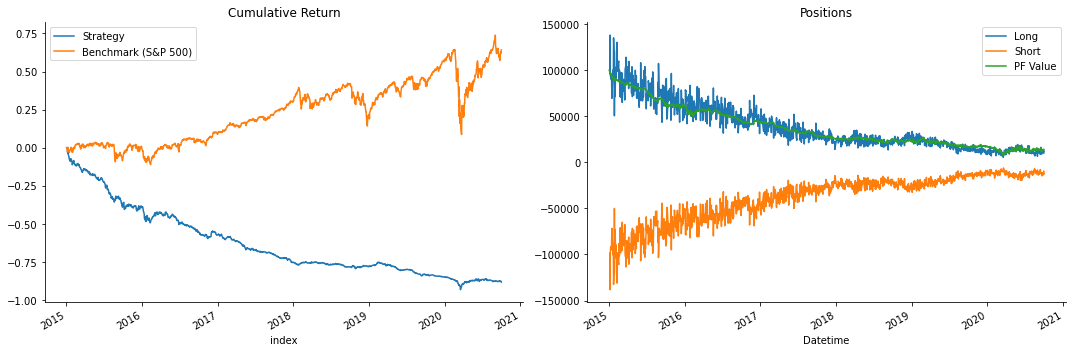

In [134]:
# Plotting returns vs S&P500
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

df = returns.to_frame('Strategy').join(benchmark.to_frame('Benchmark (S&P 500)'))
df.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')

longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout();

C:\Users\Ishan\anaconda3\lib\site-packages\pyfolio\utils.py:316: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  warnings.warn(


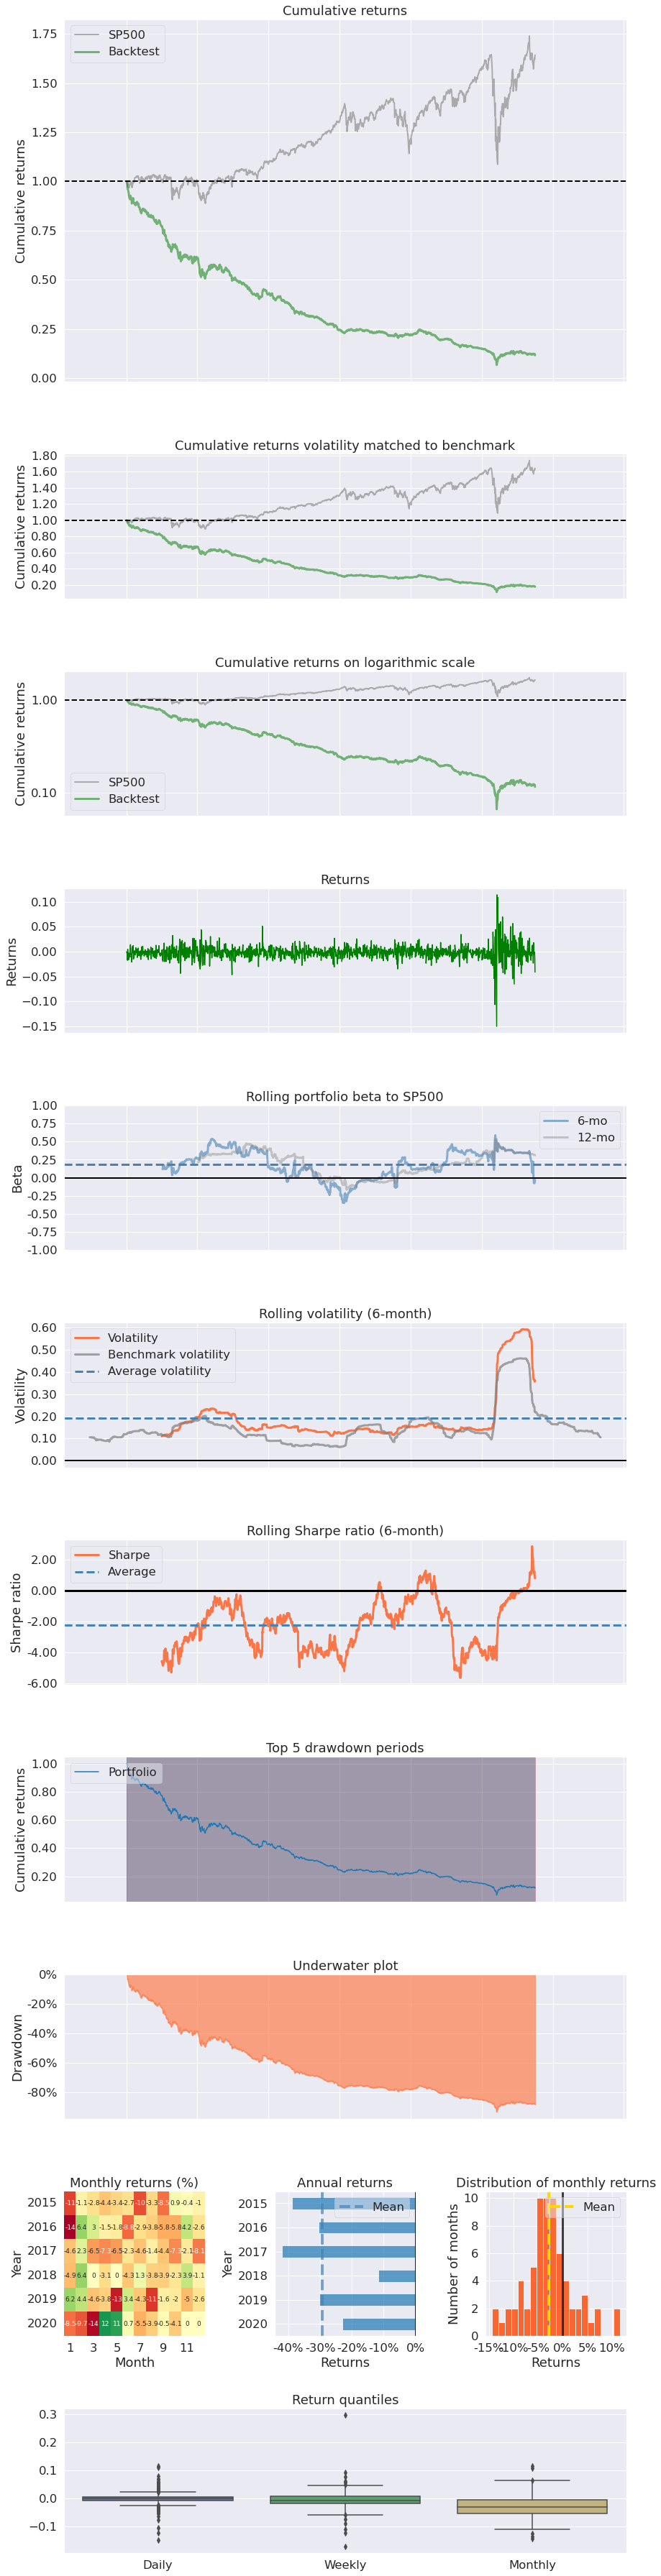

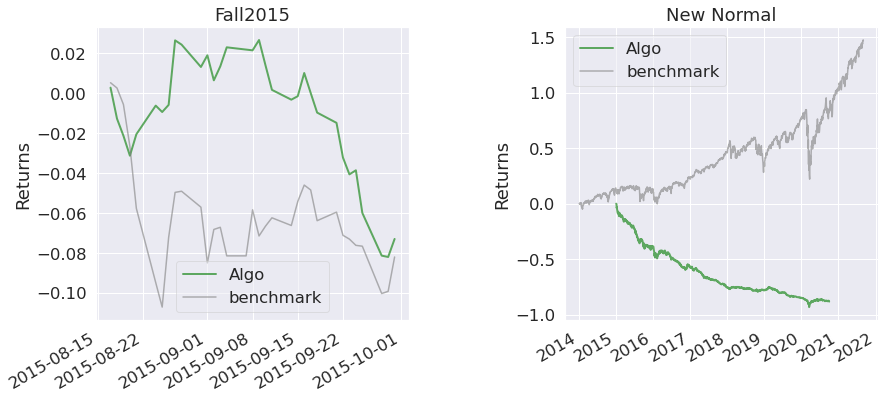

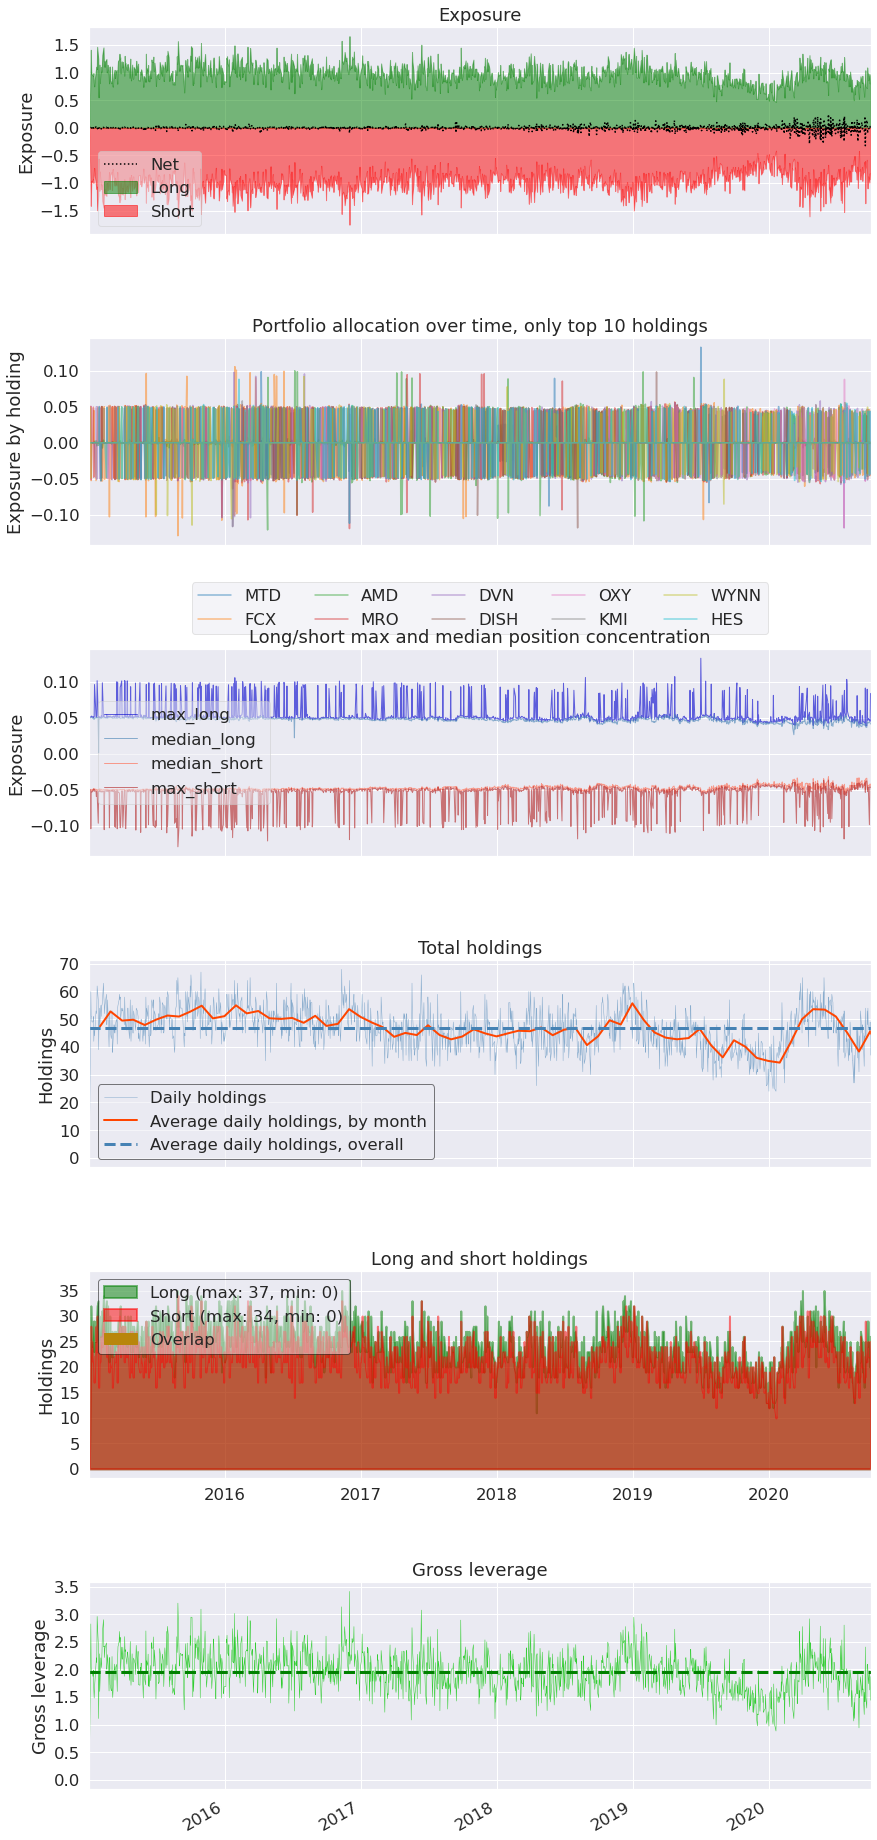

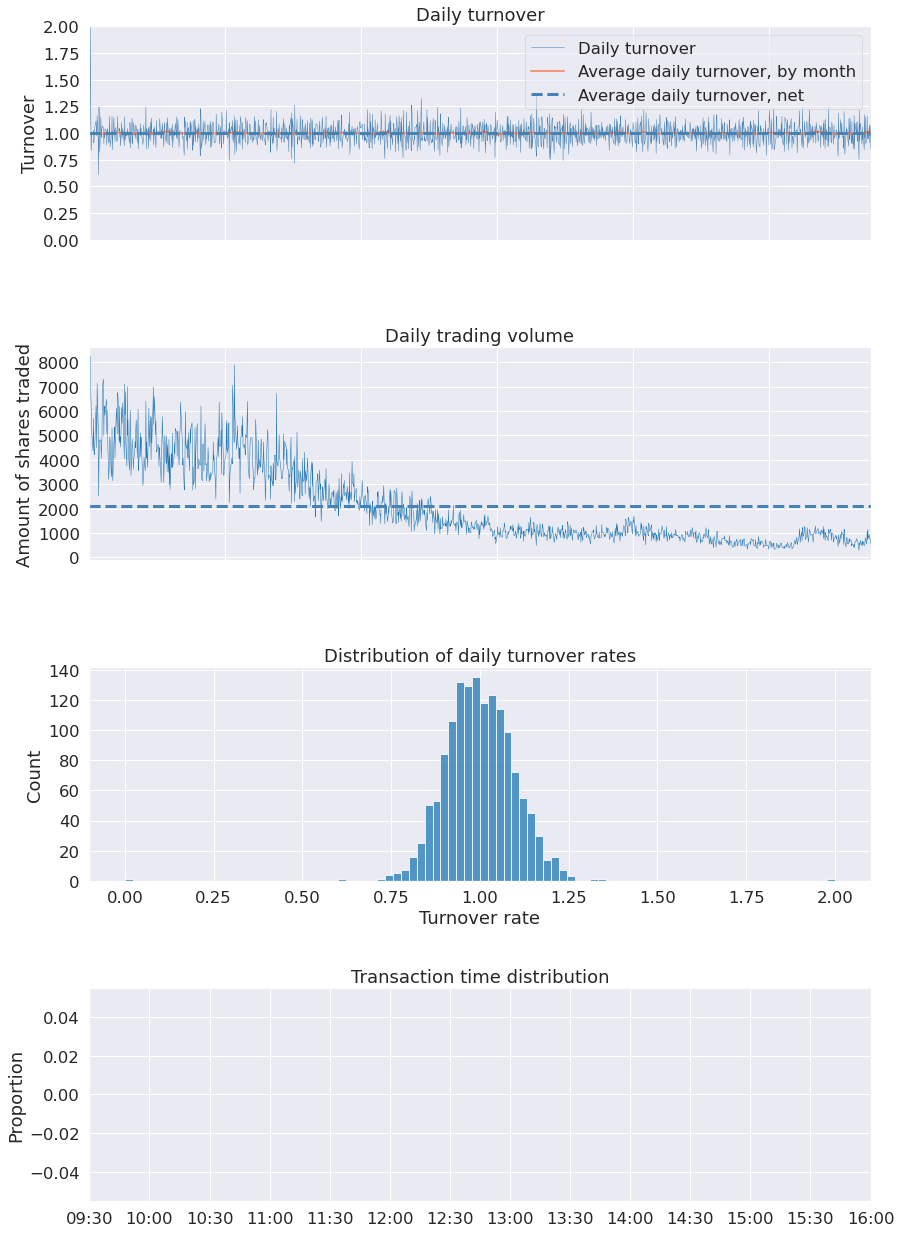

In [135]:
# Complete PyFolio evaluation
pf.create_full_tear_sheet(returns,
                          transactions=transactions,
                          positions=positions,
                          benchmark_rets=benchmark.dropna());